## Analyzes bootstraps/toys for a set of directories,

Sets of input directories are runs with different detector resolutions.

Will do the following:
- Calculate the model parameters (mu, sig2) using OmniFold output weighted events.
    - __Results__: mean mu, mean sig2, RMS mu, RMS sig2
- Read unbinned ML fit results (for about 50 samples) 
    - __Results__: ave fit error for mu and sig2
- Make histogram of OmniFold output and compute covariance matrix for histogram from set of samples
- Run chi2 fit of histogram using full covariance matrix
    - __Results__: mean mu, mean sig2, ave fit err mu, ave fit err sig2, RMS of fit mu, RMS of fit sig2
- Run chi2 fit of histogram using only diagonal elements of covariance matrix
    - __Results__: mean mu, mean sig2, ave fit err mu, ave fit err sig2, RMS of fit mu, RMS of fit sig2


Summary tables and plots will have
- 3 types of inference mean for each model parameter (mu, sig2):  ML/simple calc, chi2 fit full cov, chi2 fit diag cov.
- 3 types of asymptotic error for each model parameter: unbinned ML fit, chi2 fit full cov, chi2 fit diag cov.
- 3 types of RMS of inference values for each model parameter: ML/simple calc, chi2 fit full cov, chi2 fit diag cov.

In [1]:
import matplotlib.pyplot as plt
import numpy as np

from scipy import special


import time

import sys
import os

from datetime import datetime
import subprocess

from os.path import exists

import read_config_utils as cu

import matplotlib as mpl



import iminuit
from iminuit import Minuit
import scipy.stats as stats
from scipy.stats import chi2



/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
n_input_dirs = 4

n_pars = 2

par_names = [ 'mu', 'sig2' ]




set_number = 0

if set_number == 0 :
    input_dirs = np.array([
        'hist-pdf-toy-study-1d-1a-perfect',
        'hist-pdf-toy-study-1d-1a-goodres',
        'hist-pdf-toy-study-1d-1a-nominal-resolution',
        'hist-pdf-toy-study-1d-1b-mediumbad',
    ])

    
    
    
    
    
input_names = np.array([
    'Simple PDF, perfect det. res.',
    'Simple PDF, good det. res.',
    'Simple PDF, nominal det. res.',
    'Simple PDF, bad det. res.',
])

input_det_res = np.array([
    0.0,
    0.25,
    0.50,
    0.75,
])

input_lhr_type = np.array([
    'Simple PDF',
    'Simple PDF',
    'Simple PDF',
    'Simple PDF',
])


n_inference_types = 3

inference_names = np.array([
    'Unbinned ML fit',
    'chi2 fit, full cov.',
    'chi2 fit, diag. cov.',
])



n_hp_vals = 13

hp_min = 0.00001
hp_max = 0.1

hp_vals = np.zeros( shape=(n_hp_vals) )

a = np.power( (hp_max/hp_min), 1./(n_hp_vals-1) )

print('a = %f' % a)
hp_vals[0] = 0.
hp_vals[1] = hp_min
for hpi in range(2,n_hp_vals) :
    hp_vals[hpi] = a * hp_vals[hpi-1]
    
for hpi in range(n_hp_vals) :
    print(' %3d : %.6f' % (hpi, hp_vals[hpi]))


results_inference_mean = np.zeros( shape=(n_hp_vals, n_input_dirs, n_inference_types, n_pars) )

results_fit_err = np.zeros( shape=(n_hp_vals, n_input_dirs, n_inference_types, n_pars) )

results_rms = np.zeros( shape=(n_hp_vals, n_input_dirs, n_inference_types, n_pars) )




results_inference_mean_stat_err = np.zeros( shape=(n_hp_vals, n_input_dirs, n_inference_types, n_pars) )

results_fit_err_stat_err = np.zeros( shape=(n_hp_vals, n_input_dirs, n_inference_types, n_pars) )

results_rms_stat_err = np.zeros( shape=(n_hp_vals, n_input_dirs, n_inference_types, n_pars) )




#hist_nbins = 10
hist_nbins = 20
#hist_nbins = 40


#fitType = 'bin center approximation'
fitType = 'integral within bin'


hist_xlow = -3.
hist_xhigh = 3.

#hist_xlow = -2.
#hist_xhigh = 2.




a = 2.154435
   0 : 0.000000
   1 : 0.000010
   2 : 0.000022
   3 : 0.000046
   4 : 0.000100
   5 : 0.000215
   6 : 0.000464
   7 : 0.001000
   8 : 0.002154
   9 : 0.004642
  10 : 0.010000
  11 : 0.021544
  12 : 0.046416


In [3]:
def calc_mean_cov( weights, fi1, fi2 ) :

    return_dict = {}
    
    wsum = np.sum( weights )
    
    wx1 = np.sum( weights * train_pts[:,fi1] )
    wx2 = np.sum( weights * train_pts[:,fi2] )
    wx1x2 = np.sum( weights * train_pts[:,fi1] * train_pts[:,fi2] )

    x1 = wx1 / wsum
    x2 = wx2 / wsum

    x1x2 = wx1x2 / wsum
    
    cov12 = x1x2 - x1*x2

    
    return_dict["mean_x1"] = x1
    return_dict["mean_x2"] = x2
    return_dict["cov_x1x2"] = cov12    
    
    if fi1 != fi2 :
        wx1x1 = np.sum( weights * train_pts[:,fi1] * train_pts[:,fi1] )
        wx2x2 = np.sum( weights * train_pts[:,fi2] * train_pts[:,fi2] )
        cov11 = wx1x1 / wsum - x1*x1
        cov22 = wx2x2 / wsum - x2*x2

        rms1 = np.sqrt(cov11)
        rms2 = np.sqrt(cov22)
        rho12 = cov12 / (rms1*rms2)     
    
        return_dict["rho12"] = rho12
        return_dict["rms1"] = rms1
        return_dict["rms2"] = rms2
    else :
        rms1 = np.sqrt(cov12)
        return_dict["rms1"] = rms1
        
    return return_dict


    

In [4]:


def f_bin_center_approx(x, par):                      # fit function
    theta   = par[0]
    mu      = par[1]
    sigma2   = par[2]
    
    model_norm =  1. / ( np.sqrt( 2 * 3.14159265 * sigma2 ) )
    
    model_pred = model_norm * np.exp( -0.5 * np.square((x - mu))/sigma2 )
    
    return theta * model_pred



def f_integral_within_bin(x_low, x_high, par):                      # fit function
    theta   = par[0]
    mu      = par[1]
    sigma2   = par[2]
    sigma = np.sqrt(sigma2)
    
    model_pred = 0.5 * ( 1. + special.erf( (x_high - mu )/(sigma*np.sqrt(2.)) ) ) - 0.5 * ( 1. + special.erf( (x_low - mu )/(sigma*np.sqrt(2.)) ) )
    
    return theta * model_pred



class ChiSquared:                   # function to be minimized

    def __init__(self, xHist, bin_edges, covMatInv, fitType, verbose=0):
        self.setData(xHist, bin_edges, covMatInv, verbose)
        self.fitType = fitType
        
    def setData(self, xHist, bin_edges, covMatInv, verbose):
        numVal = np.sum(xHist)
        numBins = len(xHist)
        binLowEdge = np.zeros(numBins)
        binHighEdge = np.zeros(numBins)
        for bi in range(numBins) :
            binLowEdge[bi] = bin_edges[bi]
            binHighEdge[bi] = bin_edges[bi+1]
        binWidth = binHighEdge - binLowEdge
        binCenter = 0.5 * (binLowEdge + binHighEdge)
            
        self.data = xHist, bin_edges, numVal, numBins, binLowEdge, binHighEdge, binWidth, binCenter, covMatInv

        if verbose > 0 :
            print('\n\n setData:')
            print('  numVal: %12.1f  numBins = %d' % (numVal, numBins))
            print('  binLowEdge: ', end='' )
            print('  fitType: %s' % fitType )
            print( binLowEdge)


        
    def chi2LS_integral_within_bin(self, par):
        
        xHist, bin_edges, numVal, numBins, binLowEdge, binHighEdge, binWidth, binCenter, covMatInv = self.data
        
        binProb = f_integral_within_bin(binLowEdge, binHighEdge, par)
        
        nu = numVal*binProb
        
        dy = xHist - nu
        
        cov_inv_times_dy = np.tensordot( covMatInv, dy.T, axes=(1,0) )
        
        dy_times_cov_inv_times_dy =  np.sum( dy.T * cov_inv_times_dy, axis=0)
        
        return dy_times_cov_inv_times_dy
        


    def chi2LS_bin_center_approx(self, par):
        
        xHist, bin_edges, numVal, numBins, binLowEdge, binHighEdge, binWidth, binCenter, covMatInv = self.data
        
        binProb = f_bin_center_approx(binCenter, par) * binWidth
        
        nu = numVal*binProb
        
        dy = xHist - nu
        
        cov_inv_times_dy = np.tensordot( covMatInv, dy.T, axes=(1,0) )
        
        dy_times_cov_inv_times_dy =  np.sum( dy.T * cov_inv_times_dy, axis=0)
        
        return dy_times_cov_inv_times_dy
        


        
    def __call__(self, par):
        if fitType == 'integral within bin' :
            return self.chi2LS_integral_within_bin(par)
        elif fitType == 'bin center approximation' :
            return self.chi2LS_bin_center_approx(par)
        else :
            print('\n\n *** Unknown fitType :  %s\n\n' % fitType )
            return -1

        
        

## Loop over input directories



 ====== Input dir: hist-pdf-toy-study-1d-1a-perfect :  Simple PDF, perfect det. res.
    Unfolding type: Simple PDF ,   detector resolution:  0.00



 shape of train_pts:  (100000, 1)
 shape of true_pts:   (10000, 1)



 shape of main_sample_omnifold_weights: (100000,)


 Sum of ominfold weights:  10007.449

 Simple calculation of model pars:     mean = 0.19260,     sig2 = 0.80919

 Found 500 bootstrap samples.


 boot   0 weights: [0.07695288 0.1132453  0.08179921 ... 0.07942    0.10224509 0.08250124]
 boot   1 weights: [0.08055853 0.11210515 0.08394099 ... 0.08257134 0.10290539 0.08451173]
 boot   2 weights: [0.07999077 0.11628034 0.08371986 ... 0.08207489 0.10547522 0.08438919]
 boot   3 weights: [0.08027876 0.11576523 0.08377686 ... 0.08211724 0.10121322 0.0844365 ]
 boot   4 weights: [0.07477299 0.11180621 0.07925264 ... 0.07705891 0.10576773 0.08033731]
 boot   5 weights: [0.07923957 0.11295059 0.08294659 ... 0.08140637 0.10302028 0.08324765]
 boot   6 weights: [0.07714214 0.11

 boot  97 weights: [0.07960615 0.11512589 0.08238549 ... 0.08081093 0.10229907 0.08284639]
 boot  98 weights: [0.07828271 0.11592142 0.08229646 ... 0.0810772  0.10111918 0.08274715]
 boot  99 weights: [0.08116016 0.11320766 0.08285597 ... 0.08205915 0.10592778 0.08334527]
 boot 100 weights: [0.0801302  0.11617556 0.08388916 ... 0.08198914 0.10039547 0.08460128]
 boot 101 weights: [0.07664885 0.1178957  0.07896832 ... 0.07845708 0.10224098 0.07942256]
 boot 102 weights: [0.07700375 0.1104999  0.08216896 ... 0.07932449 0.10447611 0.08299471]
 boot 103 weights: [0.08048181 0.11343522 0.08420779 ... 0.08306196 0.10218185 0.08461028]
 boot 104 weights: [0.08004825 0.11311816 0.08451438 ... 0.08246519 0.10386696 0.08522115]
 boot 105 weights: [0.08153259 0.11238931 0.08323592 ... 0.08303477 0.1037458  0.08363767]
 boot 106 weights: [0.08005299 0.11647598 0.08294992 ... 0.08154996 0.10517517 0.08319041]
 boot 107 weights: [0.08268349 0.11443581 0.08652482 ... 0.08453118 0.10312954 0.08674628]

 boot 207 weights: [0.07745455 0.1138371  0.08406887 ... 0.08123441 0.10109929 0.08517994]
 boot 208 weights: [0.08025306 0.11621125 0.08267486 ... 0.08164676 0.10374893 0.08314909]
 boot 209 weights: [0.08126284 0.11942691 0.08536844 ... 0.08340673 0.10460223 0.08607368]
 boot 210 weights: [0.07947245 0.11478106 0.08212453 ... 0.08116558 0.1038415  0.08256566]
 boot 211 weights: [0.07793519 0.11582931 0.08148764 ... 0.0798091  0.10180868 0.08194944]
 boot 212 weights: [0.08349363 0.11295521 0.08596117 ... 0.08515139 0.10570411 0.08607628]
 boot 213 weights: [0.08267021 0.11293321 0.08535971 ... 0.08454868 0.10291878 0.08539452]
 boot 214 weights: [0.07703576 0.10966218 0.08298631 ... 0.08045953 0.10652097 0.08383107]
 boot 215 weights: [0.07719829 0.11566783 0.07925603 ... 0.07843146 0.11027247 0.07958555]
 boot 216 weights: [0.07990771 0.11574066 0.08029716 ... 0.07997651 0.1088986  0.08026898]
 boot 217 weights: [0.08247094 0.11194523 0.08543661 ... 0.08440872 0.10039069 0.08602054]

 boot 320 weights: [0.07817927 0.1162842  0.08136254 ... 0.07994198 0.10616931 0.08147317]
 boot 321 weights: [0.07675612 0.11588881 0.0825833  ... 0.07931173 0.10382555 0.0837833 ]
 boot 322 weights: [0.07874712 0.11676145 0.0803693  ... 0.0792925  0.10419762 0.0808956 ]
 boot 323 weights: [0.07734694 0.11652037 0.07959772 ... 0.07834135 0.10738749 0.07987929]
 boot 324 weights: [0.08438179 0.11628806 0.08322224 ... 0.08365229 0.10451868 0.08329719]
 boot 325 weights: [0.07720459 0.11410193 0.083332   ... 0.08028065 0.10801767 0.08451952]
 boot 326 weights: [0.07509509 0.11589215 0.07913425 ... 0.07746131 0.10508127 0.07996456]
 boot 327 weights: [0.07332045 0.11191105 0.07852043 ... 0.07597515 0.10304044 0.07941405]
 boot 328 weights: [0.07718042 0.11405371 0.08238819 ... 0.08025832 0.10250878 0.08288571]
 boot 329 weights: [0.07468705 0.11147579 0.07820981 ... 0.07664624 0.10496223 0.07867159]
 boot 330 weights: [0.07916595 0.11065112 0.08505779 ... 0.08168604 0.10004883 0.08644036]

 boot 418 weights: [0.07632337 0.11174035 0.08080342 ... 0.07835251 0.10656731 0.08161753]
 boot 419 weights: [0.0792168  0.11502329 0.08274572 ... 0.08087685 0.10369543 0.08352392]
 boot 420 weights: [0.08104711 0.11395272 0.08688577 ... 0.08437462 0.10257766 0.08735046]
 boot 421 weights: [0.08386677 0.11393927 0.08827612 ... 0.08601052 0.10073746 0.08886746]
 boot 422 weights: [0.07818476 0.11269595 0.08516757 ... 0.08166173 0.10285879 0.08637147]
 boot 423 weights: [0.07959463 0.11494247 0.084016   ... 0.08172581 0.10033051 0.08481236]
 boot 424 weights: [0.0809741  0.11527486 0.08376952 ... 0.08227017 0.1061951  0.08414361]
 boot 425 weights: [0.07823919 0.11675071 0.08347129 ... 0.08078686 0.10090735 0.08406868]
 boot 426 weights: [0.075695   0.11622238 0.07942857 ... 0.07703381 0.10629324 0.08034538]
 boot 427 weights: [0.08272426 0.11421671 0.08397085 ... 0.08363643 0.10604615 0.08405242]
 boot 428 weights: [0.08019515 0.11469668 0.08426963 ... 0.08224827 0.10258894 0.08502846]

  10 : mu   0.0860 +/-   0.0081  (  0.1978 +/-   0.0066)    sig2   0.7015 +/-   0.0106  (  0.8206 +/-   0.0088)
  11 : mu   0.0992 +/-   0.0082  (  0.2080 +/-   0.0066)    sig2   0.6774 +/-   0.0105  (  0.7971 +/-   0.0087)
  12 : mu   0.0774 +/-   0.0081  (  0.1809 +/-   0.0066)    sig2   0.6814 +/-   0.0102  (  0.7960 +/-   0.0086)
  13 : mu   0.0927 +/-   0.0081  (  0.2042 +/-   0.0066)    sig2   0.6780 +/-   0.0104  (  0.8024 +/-   0.0086)
  14 : mu   0.0951 +/-   0.0081  (  0.2041 +/-   0.0066)    sig2   0.6778 +/-   0.0103  (  0.7987 +/-   0.0086)
  15 : mu   0.0840 +/-   0.0081  (  0.1934 +/-   0.0066)    sig2   0.6900 +/-   0.0102  (  0.8068 +/-   0.0085)
  16 : mu   0.0950 +/-   0.0081  (  0.2102 +/-   0.0066)    sig2   0.7008 +/-   0.0107  (  0.8345 +/-   0.0089)
  17 : mu   0.0884 +/-   0.0081  (  0.2026 +/-   0.0066)    sig2   0.6907 +/-   0.0104  (  0.8217 +/-   0.0087)
  18 : mu   0.0895 +/-   0.0081  (  0.2016 +/-   0.0066)    sig2   0.6968 +/-   0.0103  (  0.8131 +/-   

 129 : mu   0.0965 +/-   0.0081  (  0.2062 +/-   0.0066)    sig2   0.6895 +/-   0.0103  (  0.8073 +/-   0.0086)
 130 : mu   0.0828 +/-   0.0081  (  0.1928 +/-   0.0066)    sig2   0.6875 +/-   0.0103  (  0.8093 +/-   0.0086)
 131 : mu   0.0868 +/-   0.0081  (  0.1911 +/-   0.0066)    sig2   0.6615 +/-   0.0102  (  0.7827 +/-   0.0086)
 132 : mu   0.0742 +/-   0.0081  (  0.1829 +/-   0.0066)    sig2   0.6840 +/-   0.0105  (  0.8093 +/-   0.0088)
 133 : mu   0.0887 +/-   0.0081  (  0.2015 +/-   0.0066)    sig2   0.6784 +/-   0.0105  (  0.8037 +/-   0.0087)
 134 : mu   0.0899 +/-   0.0081  (  0.2091 +/-   0.0066)    sig2   0.6903 +/-   0.0105  (  0.8220 +/-   0.0087)
 135 : mu   0.0890 +/-   0.0081  (  0.1954 +/-   0.0066)    sig2   0.6935 +/-   0.0105  (  0.8100 +/-   0.0086)
 136 : mu   0.0949 +/-   0.0081  (  0.2075 +/-   0.0066)    sig2   0.6788 +/-   0.0102  (  0.8023 +/-   0.0086)
 137 : mu   0.0999 +/-   0.0082  (  0.2031 +/-   0.0066)    sig2   0.6705 +/-   0.0104  (  0.7804 +/-   

 203 : mu   0.0905 +/-   0.0081  (  0.2059 +/-   0.0066)    sig2   0.6826 +/-   0.0106  (  0.8147 +/-   0.0088)
 204 : mu   0.0680 +/-   0.0081  (  0.1822 +/-   0.0066)    sig2   0.7071 +/-   0.0105  (  0.8301 +/-   0.0087)
 205 : mu   0.0751 +/-   0.0081  (  0.1800 +/-   0.0066)    sig2   0.6675 +/-   0.0103  (  0.7887 +/-   0.0086)
 206 : mu   0.0901 +/-   0.0081  (  0.2000 +/-   0.0066)    sig2   0.7126 +/-   0.0104  (  0.8316 +/-   0.0087)
 207 : mu   0.0973 +/-   0.0081  (  0.2027 +/-   0.0066)    sig2   0.6792 +/-   0.0105  (  0.7961 +/-   0.0087)
 208 : mu   0.0835 +/-   0.0081  (  0.1973 +/-   0.0066)    sig2   0.6866 +/-   0.0104  (  0.8077 +/-   0.0087)
 209 : mu   0.0843 +/-   0.0081  (  0.1885 +/-   0.0066)    sig2   0.6801 +/-   0.0104  (  0.7970 +/-   0.0087)
 210 : mu   0.0913 +/-   0.0081  (  0.2065 +/-   0.0066)    sig2   0.6855 +/-   0.0104  (  0.8107 +/-   0.0087)
 211 : mu   0.1037 +/-   0.0082  (  0.2156 +/-   0.0066)    sig2   0.6904 +/-   0.0107  (  0.8152 +/-   

 326 : mu   0.1013 +/-   0.0081  (  0.2202 +/-   0.0066)    sig2   0.6795 +/-   0.0105  (  0.8130 +/-   0.0087)
 327 : mu   0.0931 +/-   0.0081  (  0.2068 +/-   0.0066)    sig2   0.6944 +/-   0.0103  (  0.8131 +/-   0.0086)
 328 : mu   0.0907 +/-   0.0081  (  0.2039 +/-   0.0066)    sig2   0.6927 +/-   0.0105  (  0.8182 +/-   0.0087)
 329 : mu   0.0907 +/-   0.0081  (  0.2051 +/-   0.0066)    sig2   0.6993 +/-   0.0103  (  0.8203 +/-   0.0086)
 330 : mu   0.0937 +/-   0.0081  (  0.2024 +/-   0.0066)    sig2   0.7200 +/-   0.0106  (  0.8392 +/-   0.0088)
 331 : mu   0.0717 +/-   0.0081  (  0.1828 +/-   0.0066)    sig2   0.6841 +/-   0.0104  (  0.8123 +/-   0.0088)
 332 : mu   0.0794 +/-   0.0081  (  0.1928 +/-   0.0066)    sig2   0.7048 +/-   0.0104  (  0.8288 +/-   0.0086)
 333 : mu   0.0972 +/-   0.0081  (  0.2148 +/-   0.0066)    sig2   0.6983 +/-   0.0107  (  0.8258 +/-   0.0088)
 334 : mu   0.0886 +/-   0.0081  (  0.2048 +/-   0.0066)    sig2   0.6953 +/-   0.0104  (  0.8219 +/-   

 447 : mu   0.0727 +/-   0.0081  (  0.1854 +/-   0.0066)    sig2   0.6937 +/-   0.0103  (  0.8146 +/-   0.0086)
 448 : mu   0.0913 +/-   0.0081  (  0.2013 +/-   0.0066)    sig2   0.6804 +/-   0.0105  (  0.7998 +/-   0.0087)
 449 : mu   0.0780 +/-   0.0081  (  0.1866 +/-   0.0066)    sig2   0.6734 +/-   0.0105  (  0.7976 +/-   0.0088)
 450 : mu   0.0875 +/-   0.0081  (  0.2057 +/-   0.0066)    sig2   0.7038 +/-   0.0107  (  0.8351 +/-   0.0088)
 451 : mu   0.0770 +/-   0.0081  (  0.1933 +/-   0.0066)    sig2   0.6830 +/-   0.0103  (  0.8162 +/-   0.0087)
 452 : mu   0.0894 +/-   0.0081  (  0.1993 +/-   0.0066)    sig2   0.6906 +/-   0.0104  (  0.8083 +/-   0.0086)
 453 : mu   0.0940 +/-   0.0081  (  0.2042 +/-   0.0066)    sig2   0.6872 +/-   0.0103  (  0.8026 +/-   0.0085)
 454 : mu   0.0891 +/-   0.0081  (  0.1952 +/-   0.0066)    sig2   0.6968 +/-   0.0104  (  0.8122 +/-   0.0086)
 455 : mu   0.0929 +/-   0.0081  (  0.2071 +/-   0.0066)    sig2   0.6904 +/-   0.0106  (  0.8156 +/-   

  37 : mu   0.0919 +/-   0.0081  (  0.1998 +/-   0.0066)    sig2   0.6672 +/-   0.0104  (  0.7876 +/-   0.0087)
  38 : mu   0.0801 +/-   0.0081  (  0.1923 +/-   0.0066)    sig2   0.7104 +/-   0.0105  (  0.8311 +/-   0.0087)
  39 : mu   0.0712 +/-   0.0081  (  0.1792 +/-   0.0066)    sig2   0.6939 +/-   0.0104  (  0.8174 +/-   0.0087)
  40 : mu   0.0950 +/-   0.0082  (  0.2081 +/-   0.0066)    sig2   0.6922 +/-   0.0105  (  0.8114 +/-   0.0086)
  41 : mu   0.1004 +/-   0.0081  (  0.2144 +/-   0.0066)    sig2   0.6927 +/-   0.0108  (  0.8173 +/-   0.0089)
  42 : mu   0.0921 +/-   0.0081  (  0.2023 +/-   0.0066)    sig2   0.6844 +/-   0.0106  (  0.8058 +/-   0.0087)
  43 : mu   0.0836 +/-   0.0081  (  0.1947 +/-   0.0066)    sig2   0.6884 +/-   0.0101  (  0.8085 +/-   0.0085)
  44 : mu   0.0883 +/-   0.0081  (  0.1946 +/-   0.0066)    sig2   0.6769 +/-   0.0103  (  0.7982 +/-   0.0087)
  45 : mu   0.0994 +/-   0.0081  (  0.2151 +/-   0.0066)    sig2   0.6780 +/-   0.0105  (  0.8054 +/-   

 135 : mu   0.0890 +/-   0.0081  (  0.1954 +/-   0.0066)    sig2   0.6935 +/-   0.0105  (  0.8100 +/-   0.0086)
 136 : mu   0.0949 +/-   0.0081  (  0.2075 +/-   0.0066)    sig2   0.6788 +/-   0.0102  (  0.8023 +/-   0.0086)
 137 : mu   0.0999 +/-   0.0082  (  0.2031 +/-   0.0066)    sig2   0.6705 +/-   0.0104  (  0.7804 +/-   0.0086)
 138 : mu   0.0876 +/-   0.0081  (  0.1992 +/-   0.0066)    sig2   0.6846 +/-   0.0104  (  0.8081 +/-   0.0086)
 139 : mu   0.0871 +/-   0.0081  (  0.1896 +/-   0.0066)    sig2   0.6955 +/-   0.0105  (  0.8092 +/-   0.0087)
 140 : mu   0.0877 +/-   0.0081  (  0.1985 +/-   0.0066)    sig2   0.6945 +/-   0.0104  (  0.8224 +/-   0.0087)
 141 : mu   0.0827 +/-   0.0081  (  0.1906 +/-   0.0066)    sig2   0.6895 +/-   0.0104  (  0.8072 +/-   0.0086)
 142 : mu   0.0874 +/-   0.0081  (  0.2035 +/-   0.0066)    sig2   0.6872 +/-   0.0102  (  0.8166 +/-   0.0086)
 143 : mu   0.0877 +/-   0.0081  (  0.2016 +/-   0.0066)    sig2   0.7013 +/-   0.0104  (  0.8284 +/-   

 235 : mu   0.1045 +/-   0.0081  (  0.2150 +/-   0.0066)    sig2   0.6787 +/-   0.0104  (  0.7983 +/-   0.0086)
 236 : mu   0.0972 +/-   0.0081  (  0.2051 +/-   0.0066)    sig2   0.6830 +/-   0.0104  (  0.8024 +/-   0.0087)
 237 : mu   0.0866 +/-   0.0081  (  0.1980 +/-   0.0066)    sig2   0.6727 +/-   0.0104  (  0.7995 +/-   0.0087)
 238 : mu   0.0930 +/-   0.0081  (  0.2092 +/-   0.0066)    sig2   0.7022 +/-   0.0105  (  0.8224 +/-   0.0087)
 239 : mu   0.0771 +/-   0.0081  (  0.1836 +/-   0.0066)    sig2   0.6892 +/-   0.0105  (  0.8082 +/-   0.0088)
 240 : mu   0.0861 +/-   0.0081  (  0.1916 +/-   0.0066)    sig2   0.6734 +/-   0.0103  (  0.7881 +/-   0.0086)
 241 : mu   0.0860 +/-   0.0081  (  0.1945 +/-   0.0066)    sig2   0.6786 +/-   0.0103  (  0.7993 +/-   0.0086)
 242 : mu   0.0838 +/-   0.0081  (  0.1998 +/-   0.0066)    sig2   0.6905 +/-   0.0104  (  0.8237 +/-   0.0087)
 243 : mu   0.1017 +/-   0.0081  (  0.2099 +/-   0.0066)    sig2   0.6845 +/-   0.0104  (  0.8038 +/-   

 334 : mu   0.0886 +/-   0.0081  (  0.2048 +/-   0.0066)    sig2   0.6953 +/-   0.0104  (  0.8219 +/-   0.0086)
 335 : mu   0.0952 +/-   0.0081  (  0.2016 +/-   0.0066)    sig2   0.6907 +/-   0.0105  (  0.8090 +/-   0.0087)
 336 : mu   0.0824 +/-   0.0081  (  0.1897 +/-   0.0066)    sig2   0.6803 +/-   0.0103  (  0.8034 +/-   0.0087)
 337 : mu   0.0948 +/-   0.0081  (  0.2064 +/-   0.0066)    sig2   0.7123 +/-   0.0107  (  0.8340 +/-   0.0089)
 338 : mu   0.0958 +/-   0.0081  (  0.2082 +/-   0.0066)    sig2   0.7048 +/-   0.0106  (  0.8294 +/-   0.0088)
 339 : mu   0.1006 +/-   0.0081  (  0.2072 +/-   0.0066)    sig2   0.6947 +/-   0.0106  (  0.8145 +/-   0.0087)
 340 : mu   0.0934 +/-   0.0081  (  0.1982 +/-   0.0066)    sig2   0.6963 +/-   0.0103  (  0.8114 +/-   0.0086)
 341 : mu   0.0965 +/-   0.0081  (  0.2028 +/-   0.0066)    sig2   0.6840 +/-   0.0104  (  0.8006 +/-   0.0087)
 342 : mu   0.0898 +/-   0.0081  (  0.1980 +/-   0.0066)    sig2   0.6824 +/-   0.0103  (  0.8030 +/-   

 433 : mu   0.0861 +/-   0.0081  (  0.1980 +/-   0.0066)    sig2   0.7079 +/-   0.0107  (  0.8318 +/-   0.0088)
 434 : mu   0.0975 +/-   0.0082  (  0.2063 +/-   0.0066)    sig2   0.6805 +/-   0.0108  (  0.8049 +/-   0.0089)
 435 : mu   0.1050 +/-   0.0081  (  0.2142 +/-   0.0066)    sig2   0.6832 +/-   0.0106  (  0.8058 +/-   0.0087)
 436 : mu   0.0937 +/-   0.0081  (  0.1981 +/-   0.0066)    sig2   0.6736 +/-   0.0103  (  0.7875 +/-   0.0086)
 437 : mu   0.0832 +/-   0.0081  (  0.1960 +/-   0.0066)    sig2   0.7018 +/-   0.0105  (  0.8249 +/-   0.0087)
 438 : mu   0.0825 +/-   0.0081  (  0.1955 +/-   0.0066)    sig2   0.7053 +/-   0.0104  (  0.8298 +/-   0.0087)
 439 : mu   0.0978 +/-   0.0081  (  0.2102 +/-   0.0066)    sig2   0.6903 +/-   0.0103  (  0.8123 +/-   0.0086)
 440 : mu   0.0855 +/-   0.0081  (  0.1942 +/-   0.0066)    sig2   0.6743 +/-   0.0103  (  0.7972 +/-   0.0087)
 441 : mu   0.0869 +/-   0.0081  (  0.1994 +/-   0.0066)    sig2   0.6968 +/-   0.0104  (  0.8236 +/-   

  23 : mu   0.0932 +/-   0.0081  (  0.1960 +/-   0.0066)    sig2   0.6786 +/-   0.0104  (  0.7963 +/-   0.0086)
  24 : mu   0.0973 +/-   0.0082  (  0.2119 +/-   0.0066)    sig2   0.6960 +/-   0.0106  (  0.8184 +/-   0.0087)
  25 : mu   0.0928 +/-   0.0081  (  0.2008 +/-   0.0066)    sig2   0.6691 +/-   0.0104  (  0.7872 +/-   0.0086)
  26 : mu   0.0924 +/-   0.0081  (  0.2032 +/-   0.0066)    sig2   0.6801 +/-   0.0103  (  0.8042 +/-   0.0086)
  27 : mu   0.0883 +/-   0.0081  (  0.1951 +/-   0.0066)    sig2   0.6890 +/-   0.0104  (  0.8044 +/-   0.0087)
  28 : mu   0.0953 +/-   0.0081  (  0.2033 +/-   0.0066)    sig2   0.6858 +/-   0.0105  (  0.8095 +/-   0.0088)
  29 : mu   0.1008 +/-   0.0081  (  0.2159 +/-   0.0066)    sig2   0.7044 +/-   0.0104  (  0.8303 +/-   0.0087)
  30 : mu   0.0981 +/-   0.0081  (  0.2065 +/-   0.0066)    sig2   0.7035 +/-   0.0106  (  0.8243 +/-   0.0088)
  31 : mu   0.0822 +/-   0.0081  (  0.1944 +/-   0.0066)    sig2   0.7000 +/-   0.0106  (  0.8264 +/-   

 100 : mu   0.0851 +/-   0.0081  (  0.1926 +/-   0.0066)    sig2   0.6967 +/-   0.0106  (  0.8113 +/-   0.0088)
 101 : mu   0.1079 +/-   0.0082  (  0.2231 +/-   0.0066)    sig2   0.6817 +/-   0.0106  (  0.8092 +/-   0.0087)
 102 : mu   0.0914 +/-   0.0081  (  0.2026 +/-   0.0066)    sig2   0.7169 +/-   0.0105  (  0.8338 +/-   0.0087)
 103 : mu   0.0950 +/-   0.0081  (  0.2051 +/-   0.0066)    sig2   0.6976 +/-   0.0105  (  0.8203 +/-   0.0087)
 104 : mu   0.0817 +/-   0.0081  (  0.1926 +/-   0.0066)    sig2   0.6942 +/-   0.0104  (  0.8185 +/-   0.0087)
 105 : mu   0.0907 +/-   0.0081  (  0.2011 +/-   0.0066)    sig2   0.6894 +/-   0.0103  (  0.8127 +/-   0.0086)
 106 : mu   0.0778 +/-   0.0081  (  0.1876 +/-   0.0066)    sig2   0.6918 +/-   0.0107  (  0.8142 +/-   0.0089)
 107 : mu   0.0964 +/-   0.0081  (  0.2022 +/-   0.0066)    sig2   0.6986 +/-   0.0105  (  0.8153 +/-   0.0087)
 108 : mu   0.0967 +/-   0.0081  (  0.2062 +/-   0.0066)    sig2   0.6958 +/-   0.0107  (  0.8131 +/-   

 200 : mu   0.1000 +/-   0.0081  (  0.2221 +/-   0.0066)    sig2   0.6783 +/-   0.0103  (  0.8098 +/-   0.0086)
 201 : mu   0.0860 +/-   0.0081  (  0.1971 +/-   0.0066)    sig2   0.7033 +/-   0.0104  (  0.8222 +/-   0.0086)
 202 : mu   0.0929 +/-   0.0081  (  0.2144 +/-   0.0066)    sig2   0.6667 +/-   0.0104  (  0.8013 +/-   0.0086)
 203 : mu   0.0905 +/-   0.0081  (  0.2059 +/-   0.0066)    sig2   0.6826 +/-   0.0106  (  0.8147 +/-   0.0088)
 204 : mu   0.0680 +/-   0.0081  (  0.1822 +/-   0.0066)    sig2   0.7071 +/-   0.0105  (  0.8301 +/-   0.0087)
 205 : mu   0.0751 +/-   0.0081  (  0.1800 +/-   0.0066)    sig2   0.6675 +/-   0.0103  (  0.7887 +/-   0.0086)
 206 : mu   0.0901 +/-   0.0081  (  0.2000 +/-   0.0066)    sig2   0.7126 +/-   0.0104  (  0.8316 +/-   0.0087)
 207 : mu   0.0973 +/-   0.0081  (  0.2027 +/-   0.0066)    sig2   0.6792 +/-   0.0105  (  0.7961 +/-   0.0087)
 208 : mu   0.0835 +/-   0.0081  (  0.1973 +/-   0.0066)    sig2   0.6866 +/-   0.0104  (  0.8077 +/-   

 299 : mu   0.0835 +/-   0.0081  (  0.1981 +/-   0.0066)    sig2   0.6839 +/-   0.0103  (  0.8096 +/-   0.0086)
 300 : mu   0.0928 +/-   0.0081  (  0.1993 +/-   0.0066)    sig2   0.6949 +/-   0.0104  (  0.8111 +/-   0.0087)
 301 : mu   0.0842 +/-   0.0081  (  0.1960 +/-   0.0066)    sig2   0.6786 +/-   0.0104  (  0.8026 +/-   0.0087)
 302 : mu   0.0848 +/-   0.0081  (  0.2001 +/-   0.0066)    sig2   0.7096 +/-   0.0104  (  0.8341 +/-   0.0087)
 303 : mu   0.0821 +/-   0.0081  (  0.1897 +/-   0.0066)    sig2   0.6777 +/-   0.0104  (  0.8022 +/-   0.0087)
 304 : mu   0.0924 +/-   0.0081  (  0.2046 +/-   0.0066)    sig2   0.6926 +/-   0.0104  (  0.8105 +/-   0.0086)
 305 : mu   0.0969 +/-   0.0081  (  0.2143 +/-   0.0066)    sig2   0.6918 +/-   0.0105  (  0.8176 +/-   0.0087)
 306 : mu   0.0904 +/-   0.0082  (  0.1965 +/-   0.0066)    sig2   0.6793 +/-   0.0106  (  0.8016 +/-   0.0088)
 307 : mu   0.1029 +/-   0.0082  (  0.2120 +/-   0.0066)    sig2   0.6775 +/-   0.0105  (  0.7934 +/-   

 398 : mu   0.0881 +/-   0.0081  (  0.1998 +/-   0.0066)    sig2   0.6873 +/-   0.0105  (  0.8135 +/-   0.0087)
 399 : mu   0.0881 +/-   0.0081  (  0.1995 +/-   0.0066)    sig2   0.6886 +/-   0.0104  (  0.8089 +/-   0.0086)
 400 : mu   0.0919 +/-   0.0081  (  0.1982 +/-   0.0066)    sig2   0.6797 +/-   0.0105  (  0.8007 +/-   0.0088)
 401 : mu   0.0941 +/-   0.0082  (  0.2023 +/-   0.0066)    sig2   0.6685 +/-   0.0105  (  0.7923 +/-   0.0088)
 402 : mu   0.0966 +/-   0.0081  (  0.2055 +/-   0.0066)    sig2   0.6783 +/-   0.0103  (  0.8029 +/-   0.0086)
 403 : mu   0.0865 +/-   0.0081  (  0.1935 +/-   0.0066)    sig2   0.6872 +/-   0.0104  (  0.8073 +/-   0.0087)
 404 : mu   0.0781 +/-   0.0081  (  0.1825 +/-   0.0066)    sig2   0.6760 +/-   0.0103  (  0.7940 +/-   0.0087)
 405 : mu   0.0981 +/-   0.0082  (  0.2138 +/-   0.0066)    sig2   0.6902 +/-   0.0105  (  0.8134 +/-   0.0087)
 406 : mu   0.0986 +/-   0.0081  (  0.2133 +/-   0.0066)    sig2   0.6826 +/-   0.0104  (  0.8075 +/-   

 498 : mu   0.0988 +/-   0.0081  (  0.2069 +/-   0.0066)    sig2   0.6762 +/-   0.0103  (  0.7963 +/-   0.0086)
 499 : mu   0.0848 +/-   0.0082  (  0.1980 +/-   0.0066)    sig2   0.6946 +/-   0.0106  (  0.8170 +/-   0.0088)



 mean:  0.0891, rms  0.0083, mean fit err  0.0081  |  diag. chi2 fit    0.1997, rms  0.0091, mean fit err  0.0066
 sig2:  0.6877, rms  0.0109, mean fit err  0.0104  |  diag. chi2 fit    0.8098, rms  0.0119, mean fit err  0.0087




 ====== End of this dir: hist-pdf-toy-study-1d-1a-perfect :  Simple PDF, perfect det. res.



 ++++ Hyperparameter val  3 :  0.000046 

[[0.40111396 0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.        ]
 [0.         0.1296452  0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.     

  38 : mu   0.1426 +/-   0.0085  (  0.1923 +/-   0.0066)    sig2   0.7724 +/-   0.0114  (  0.8311 +/-   0.0087)
  39 : mu   0.1371 +/-   0.0084  (  0.1792 +/-   0.0066)    sig2   0.7610 +/-   0.0112  (  0.8174 +/-   0.0087)
  40 : mu   0.1611 +/-   0.0085  (  0.2081 +/-   0.0066)    sig2   0.7561 +/-   0.0112  (  0.8114 +/-   0.0086)
  41 : mu   0.1652 +/-   0.0085  (  0.2144 +/-   0.0066)    sig2   0.7600 +/-   0.0116  (  0.8173 +/-   0.0089)
  42 : mu   0.1550 +/-   0.0085  (  0.2023 +/-   0.0066)    sig2   0.7487 +/-   0.0113  (  0.8058 +/-   0.0087)
  43 : mu   0.1484 +/-   0.0084  (  0.1947 +/-   0.0066)    sig2   0.7500 +/-   0.0109  (  0.8085 +/-   0.0085)
  44 : mu   0.1539 +/-   0.0084  (  0.1946 +/-   0.0066)    sig2   0.7431 +/-   0.0111  (  0.7982 +/-   0.0087)
  45 : mu   0.1653 +/-   0.0085  (  0.2151 +/-   0.0066)    sig2   0.7443 +/-   0.0112  (  0.8054 +/-   0.0087)
  46 : mu   0.1533 +/-   0.0085  (  0.1960 +/-   0.0066)    sig2   0.7548 +/-   0.0113  (  0.8098 +/-   

 137 : mu   0.1615 +/-   0.0085  (  0.2031 +/-   0.0066)    sig2   0.7311 +/-   0.0111  (  0.7804 +/-   0.0086)
 138 : mu   0.1534 +/-   0.0085  (  0.1992 +/-   0.0066)    sig2   0.7494 +/-   0.0111  (  0.8081 +/-   0.0086)
 139 : mu   0.1490 +/-   0.0085  (  0.1896 +/-   0.0066)    sig2   0.7570 +/-   0.0113  (  0.8092 +/-   0.0087)
 140 : mu   0.1554 +/-   0.0084  (  0.1985 +/-   0.0066)    sig2   0.7628 +/-   0.0113  (  0.8224 +/-   0.0087)
 141 : mu   0.1456 +/-   0.0084  (  0.1906 +/-   0.0066)    sig2   0.7524 +/-   0.0111  (  0.8072 +/-   0.0086)
 142 : mu   0.1520 +/-   0.0084  (  0.2035 +/-   0.0066)    sig2   0.7500 +/-   0.0110  (  0.8166 +/-   0.0086)
 143 : mu   0.1563 +/-   0.0085  (  0.2016 +/-   0.0066)    sig2   0.7689 +/-   0.0113  (  0.8284 +/-   0.0087)
 144 : mu   0.1537 +/-   0.0085  (  0.1973 +/-   0.0066)    sig2   0.7530 +/-   0.0113  (  0.8093 +/-   0.0087)
 145 : mu   0.1626 +/-   0.0085  (  0.2137 +/-   0.0066)    sig2   0.7632 +/-   0.0112  (  0.8222 +/-   

 239 : mu   0.1435 +/-   0.0084  (  0.1836 +/-   0.0066)    sig2   0.7565 +/-   0.0113  (  0.8082 +/-   0.0088)
 240 : mu   0.1472 +/-   0.0084  (  0.1916 +/-   0.0066)    sig2   0.7343 +/-   0.0110  (  0.7881 +/-   0.0086)
 241 : mu   0.1516 +/-   0.0084  (  0.1945 +/-   0.0066)    sig2   0.7451 +/-   0.0111  (  0.7993 +/-   0.0086)
 242 : mu   0.1519 +/-   0.0084  (  0.1998 +/-   0.0066)    sig2   0.7597 +/-   0.0113  (  0.8237 +/-   0.0087)
 243 : mu   0.1657 +/-   0.0085  (  0.2099 +/-   0.0066)    sig2   0.7471 +/-   0.0111  (  0.8038 +/-   0.0086)
 244 : mu   0.1614 +/-   0.0084  (  0.2061 +/-   0.0066)    sig2   0.7279 +/-   0.0110  (  0.7837 +/-   0.0086)
 245 : mu   0.1497 +/-   0.0084  (  0.1933 +/-   0.0066)    sig2   0.7541 +/-   0.0114  (  0.8104 +/-   0.0088)
 246 : mu   0.1363 +/-   0.0084  (  0.1846 +/-   0.0066)    sig2   0.7667 +/-   0.0114  (  0.8225 +/-   0.0088)
 247 : mu   0.1601 +/-   0.0085  (  0.2078 +/-   0.0066)    sig2   0.7470 +/-   0.0110  (  0.8056 +/-   

 340 : mu   0.1602 +/-   0.0084  (  0.1982 +/-   0.0066)    sig2   0.7609 +/-   0.0110  (  0.8114 +/-   0.0086)
 341 : mu   0.1613 +/-   0.0085  (  0.2028 +/-   0.0066)    sig2   0.7482 +/-   0.0112  (  0.8006 +/-   0.0087)
 342 : mu   0.1536 +/-   0.0084  (  0.1980 +/-   0.0066)    sig2   0.7454 +/-   0.0111  (  0.8030 +/-   0.0086)
 343 : mu   0.1476 +/-   0.0084  (  0.1911 +/-   0.0066)    sig2   0.7526 +/-   0.0112  (  0.8096 +/-   0.0087)
 344 : mu   0.1708 +/-   0.0085  (  0.2177 +/-   0.0066)    sig2   0.7385 +/-   0.0112  (  0.7980 +/-   0.0087)
 345 : mu   0.1603 +/-   0.0085  (  0.2029 +/-   0.0066)    sig2   0.7477 +/-   0.0109  (  0.8025 +/-   0.0085)
 346 : mu   0.1614 +/-   0.0085  (  0.2126 +/-   0.0066)    sig2   0.7499 +/-   0.0112  (  0.8110 +/-   0.0087)
 347 : mu   0.1634 +/-   0.0085  (  0.2113 +/-   0.0066)    sig2   0.7544 +/-   0.0113  (  0.8152 +/-   0.0087)
 348 : mu   0.1596 +/-   0.0085  (  0.2038 +/-   0.0066)    sig2   0.7345 +/-   0.0111  (  0.7897 +/-   

 441 : mu   0.1487 +/-   0.0085  (  0.1994 +/-   0.0066)    sig2   0.7578 +/-   0.0112  (  0.8236 +/-   0.0087)
 442 : mu   0.1665 +/-   0.0085  (  0.2156 +/-   0.0066)    sig2   0.7520 +/-   0.0111  (  0.8078 +/-   0.0086)
 443 : mu   0.1669 +/-   0.0085  (  0.2090 +/-   0.0066)    sig2   0.7649 +/-   0.0111  (  0.8172 +/-   0.0086)
 444 : mu   0.1647 +/-   0.0085  (  0.2126 +/-   0.0066)    sig2   0.7535 +/-   0.0113  (  0.8111 +/-   0.0087)
 445 : mu   0.1552 +/-   0.0084  (  0.2039 +/-   0.0066)    sig2   0.7560 +/-   0.0112  (  0.8182 +/-   0.0087)
 446 : mu   0.1414 +/-   0.0084  (  0.1894 +/-   0.0066)    sig2   0.7399 +/-   0.0111  (  0.8008 +/-   0.0087)
 447 : mu   0.1370 +/-   0.0084  (  0.1854 +/-   0.0066)    sig2   0.7564 +/-   0.0111  (  0.8146 +/-   0.0086)
 448 : mu   0.1565 +/-   0.0085  (  0.2013 +/-   0.0066)    sig2   0.7457 +/-   0.0112  (  0.7998 +/-   0.0087)
 449 : mu   0.1444 +/-   0.0084  (  0.1866 +/-   0.0066)    sig2   0.7431 +/-   0.0112  (  0.7976 +/-   

  34 : mu   0.1415 +/-   0.0084  (  0.1875 +/-   0.0066)    sig2   0.7340 +/-   0.0110  (  0.7941 +/-   0.0086)
  35 : mu   0.1367 +/-   0.0084  (  0.1837 +/-   0.0066)    sig2   0.7817 +/-   0.0113  (  0.8388 +/-   0.0087)
  36 : mu   0.1536 +/-   0.0084  (  0.2025 +/-   0.0066)    sig2   0.7388 +/-   0.0114  (  0.8005 +/-   0.0088)
  37 : mu   0.1531 +/-   0.0085  (  0.1998 +/-   0.0066)    sig2   0.7291 +/-   0.0111  (  0.7876 +/-   0.0087)
  38 : mu   0.1426 +/-   0.0085  (  0.1923 +/-   0.0066)    sig2   0.7724 +/-   0.0114  (  0.8311 +/-   0.0087)
  39 : mu   0.1371 +/-   0.0084  (  0.1792 +/-   0.0066)    sig2   0.7610 +/-   0.0112  (  0.8174 +/-   0.0087)
  40 : mu   0.1611 +/-   0.0085  (  0.2081 +/-   0.0066)    sig2   0.7561 +/-   0.0112  (  0.8114 +/-   0.0086)
  41 : mu   0.1652 +/-   0.0085  (  0.2144 +/-   0.0066)    sig2   0.7600 +/-   0.0116  (  0.8173 +/-   0.0089)
  42 : mu   0.1550 +/-   0.0085  (  0.2023 +/-   0.0066)    sig2   0.7487 +/-   0.0113  (  0.8058 +/-   

 134 : mu   0.1549 +/-   0.0084  (  0.2091 +/-   0.0066)    sig2   0.7566 +/-   0.0113  (  0.8220 +/-   0.0087)
 135 : mu   0.1478 +/-   0.0085  (  0.1954 +/-   0.0066)    sig2   0.7514 +/-   0.0112  (  0.8100 +/-   0.0086)
 136 : mu   0.1593 +/-   0.0084  (  0.2075 +/-   0.0066)    sig2   0.7412 +/-   0.0110  (  0.8023 +/-   0.0086)
 137 : mu   0.1615 +/-   0.0085  (  0.2031 +/-   0.0066)    sig2   0.7311 +/-   0.0111  (  0.7804 +/-   0.0086)
 138 : mu   0.1534 +/-   0.0085  (  0.1992 +/-   0.0066)    sig2   0.7494 +/-   0.0111  (  0.8081 +/-   0.0086)
 139 : mu   0.1490 +/-   0.0085  (  0.1896 +/-   0.0066)    sig2   0.7570 +/-   0.0113  (  0.8092 +/-   0.0087)
 140 : mu   0.1554 +/-   0.0084  (  0.1985 +/-   0.0066)    sig2   0.7628 +/-   0.0113  (  0.8224 +/-   0.0087)
 141 : mu   0.1456 +/-   0.0084  (  0.1906 +/-   0.0066)    sig2   0.7524 +/-   0.0111  (  0.8072 +/-   0.0086)
 142 : mu   0.1520 +/-   0.0084  (  0.2035 +/-   0.0066)    sig2   0.7500 +/-   0.0110  (  0.8166 +/-   

 236 : mu   0.1613 +/-   0.0085  (  0.2051 +/-   0.0066)    sig2   0.7468 +/-   0.0112  (  0.8024 +/-   0.0087)
 237 : mu   0.1541 +/-   0.0084  (  0.1980 +/-   0.0066)    sig2   0.7418 +/-   0.0112  (  0.7995 +/-   0.0087)
 238 : mu   0.1583 +/-   0.0085  (  0.2092 +/-   0.0066)    sig2   0.7653 +/-   0.0113  (  0.8224 +/-   0.0087)
 239 : mu   0.1435 +/-   0.0084  (  0.1836 +/-   0.0066)    sig2   0.7565 +/-   0.0113  (  0.8082 +/-   0.0088)
 240 : mu   0.1472 +/-   0.0084  (  0.1916 +/-   0.0066)    sig2   0.7343 +/-   0.0110  (  0.7881 +/-   0.0086)
 241 : mu   0.1516 +/-   0.0084  (  0.1945 +/-   0.0066)    sig2   0.7451 +/-   0.0111  (  0.7993 +/-   0.0086)
 242 : mu   0.1519 +/-   0.0084  (  0.1998 +/-   0.0066)    sig2   0.7597 +/-   0.0113  (  0.8237 +/-   0.0087)
 243 : mu   0.1657 +/-   0.0085  (  0.2099 +/-   0.0066)    sig2   0.7471 +/-   0.0111  (  0.8038 +/-   0.0086)
 244 : mu   0.1614 +/-   0.0084  (  0.2061 +/-   0.0066)    sig2   0.7279 +/-   0.0110  (  0.7837 +/-   

 337 : mu   0.1582 +/-   0.0085  (  0.2064 +/-   0.0066)    sig2   0.7754 +/-   0.0115  (  0.8340 +/-   0.0089)
 338 : mu   0.1585 +/-   0.0085  (  0.2082 +/-   0.0066)    sig2   0.7680 +/-   0.0114  (  0.8294 +/-   0.0088)
 339 : mu   0.1614 +/-   0.0085  (  0.2072 +/-   0.0066)    sig2   0.7553 +/-   0.0113  (  0.8145 +/-   0.0087)
 340 : mu   0.1602 +/-   0.0084  (  0.1982 +/-   0.0066)    sig2   0.7609 +/-   0.0110  (  0.8114 +/-   0.0086)
 341 : mu   0.1613 +/-   0.0085  (  0.2028 +/-   0.0066)    sig2   0.7482 +/-   0.0112  (  0.8006 +/-   0.0087)
 342 : mu   0.1536 +/-   0.0084  (  0.1980 +/-   0.0066)    sig2   0.7454 +/-   0.0111  (  0.8030 +/-   0.0086)
 343 : mu   0.1476 +/-   0.0084  (  0.1911 +/-   0.0066)    sig2   0.7526 +/-   0.0112  (  0.8096 +/-   0.0087)
 344 : mu   0.1708 +/-   0.0085  (  0.2177 +/-   0.0066)    sig2   0.7385 +/-   0.0112  (  0.7980 +/-   0.0087)
 345 : mu   0.1603 +/-   0.0085  (  0.2029 +/-   0.0066)    sig2   0.7477 +/-   0.0109  (  0.8025 +/-   

 437 : mu   0.1495 +/-   0.0084  (  0.1960 +/-   0.0066)    sig2   0.7686 +/-   0.0113  (  0.8249 +/-   0.0087)
 438 : mu   0.1505 +/-   0.0085  (  0.1955 +/-   0.0066)    sig2   0.7721 +/-   0.0113  (  0.8298 +/-   0.0087)
 439 : mu   0.1647 +/-   0.0085  (  0.2102 +/-   0.0066)    sig2   0.7539 +/-   0.0111  (  0.8123 +/-   0.0086)
 440 : mu   0.1467 +/-   0.0084  (  0.1942 +/-   0.0066)    sig2   0.7374 +/-   0.0111  (  0.7972 +/-   0.0087)
 441 : mu   0.1487 +/-   0.0085  (  0.1994 +/-   0.0066)    sig2   0.7578 +/-   0.0112  (  0.8236 +/-   0.0087)
 442 : mu   0.1665 +/-   0.0085  (  0.2156 +/-   0.0066)    sig2   0.7520 +/-   0.0111  (  0.8078 +/-   0.0086)
 443 : mu   0.1669 +/-   0.0085  (  0.2090 +/-   0.0066)    sig2   0.7649 +/-   0.0111  (  0.8172 +/-   0.0086)
 444 : mu   0.1647 +/-   0.0085  (  0.2126 +/-   0.0066)    sig2   0.7535 +/-   0.0113  (  0.8111 +/-   0.0087)
 445 : mu   0.1552 +/-   0.0084  (  0.2039 +/-   0.0066)    sig2   0.7560 +/-   0.0112  (  0.8182 +/-   

  32 : mu   0.2019 +/-   0.0089  (  0.2008 +/-   0.0066)    sig2   0.8117 +/-   0.0117  (  0.8166 +/-   0.0088)
  33 : mu   0.2071 +/-   0.0089  (  0.2118 +/-   0.0066)    sig2   0.7978 +/-   0.0116  (  0.8080 +/-   0.0088)
  34 : mu   0.1851 +/-   0.0089  (  0.1875 +/-   0.0066)    sig2   0.7836 +/-   0.0113  (  0.7941 +/-   0.0086)
  35 : mu   0.1815 +/-   0.0089  (  0.1837 +/-   0.0066)    sig2   0.8273 +/-   0.0114  (  0.8388 +/-   0.0087)
  36 : mu   0.2004 +/-   0.0089  (  0.2025 +/-   0.0066)    sig2   0.7935 +/-   0.0116  (  0.8005 +/-   0.0088)
  37 : mu   0.1976 +/-   0.0089  (  0.1998 +/-   0.0066)    sig2   0.7805 +/-   0.0114  (  0.7876 +/-   0.0087)
  38 : mu   0.1904 +/-   0.0089  (  0.1923 +/-   0.0066)    sig2   0.8222 +/-   0.0115  (  0.8311 +/-   0.0087)
  39 : mu   0.1805 +/-   0.0089  (  0.1792 +/-   0.0066)    sig2   0.8088 +/-   0.0115  (  0.8174 +/-   0.0087)
  40 : mu   0.2056 +/-   0.0089  (  0.2081 +/-   0.0066)    sig2   0.8034 +/-   0.0115  (  0.8114 +/-   

 137 : mu   0.1983 +/-   0.0089  (  0.2031 +/-   0.0066)    sig2   0.7732 +/-   0.0114  (  0.7804 +/-   0.0086)
 138 : mu   0.1962 +/-   0.0089  (  0.1992 +/-   0.0066)    sig2   0.7960 +/-   0.0114  (  0.8081 +/-   0.0086)
 139 : mu   0.1896 +/-   0.0089  (  0.1896 +/-   0.0066)    sig2   0.8015 +/-   0.0115  (  0.8092 +/-   0.0087)
 140 : mu   0.2003 +/-   0.0089  (  0.1985 +/-   0.0066)    sig2   0.8114 +/-   0.0115  (  0.8224 +/-   0.0087)
 141 : mu   0.1866 +/-   0.0089  (  0.1906 +/-   0.0066)    sig2   0.7978 +/-   0.0114  (  0.8072 +/-   0.0086)
 142 : mu   0.1996 +/-   0.0089  (  0.2035 +/-   0.0066)    sig2   0.8007 +/-   0.0112  (  0.8166 +/-   0.0086)
 143 : mu   0.2019 +/-   0.0089  (  0.2016 +/-   0.0066)    sig2   0.8168 +/-   0.0115  (  0.8284 +/-   0.0087)
 144 : mu   0.1976 +/-   0.0089  (  0.1973 +/-   0.0066)    sig2   0.8016 +/-   0.0115  (  0.8093 +/-   0.0087)
 145 : mu   0.2074 +/-   0.0089  (  0.2137 +/-   0.0066)    sig2   0.8098 +/-   0.0114  (  0.8222 +/-   

 244 : mu   0.2024 +/-   0.0089  (  0.2061 +/-   0.0066)    sig2   0.7754 +/-   0.0114  (  0.7837 +/-   0.0086)
 245 : mu   0.1931 +/-   0.0089  (  0.1933 +/-   0.0066)    sig2   0.8036 +/-   0.0117  (  0.8104 +/-   0.0088)
 246 : mu   0.1795 +/-   0.0089  (  0.1846 +/-   0.0066)    sig2   0.8142 +/-   0.0116  (  0.8225 +/-   0.0088)
 247 : mu   0.2038 +/-   0.0089  (  0.2078 +/-   0.0066)    sig2   0.7940 +/-   0.0113  (  0.8056 +/-   0.0086)
 248 : mu   0.1833 +/-   0.0089  (  0.1841 +/-   0.0066)    sig2   0.8053 +/-   0.0114  (  0.8129 +/-   0.0086)
 249 : mu   0.1846 +/-   0.0089  (  0.1888 +/-   0.0066)    sig2   0.7970 +/-   0.0115  (  0.8057 +/-   0.0088)
 250 : mu   0.1981 +/-   0.0089  (  0.2005 +/-   0.0066)    sig2   0.8254 +/-   0.0116  (  0.8366 +/-   0.0089)
 251 : mu   0.1894 +/-   0.0089  (  0.1947 +/-   0.0066)    sig2   0.7901 +/-   0.0114  (  0.8011 +/-   0.0087)
 252 : mu   0.2054 +/-   0.0089  (  0.2079 +/-   0.0066)    sig2   0.8086 +/-   0.0116  (  0.8207 +/-   

 499 : mu   0.1936 +/-   0.0089  (  0.1980 +/-   0.0066)    sig2   0.8076 +/-   0.0116  (  0.8170 +/-   0.0088)



 mean:  0.1976, rms  0.0089, mean fit err  0.0089  |  diag. chi2 fit    0.1997, rms  0.0091, mean fit err  0.0066
 sig2:  0.8004, rms  0.0113, mean fit err  0.0115  |  diag. chi2 fit    0.8098, rms  0.0119, mean fit err  0.0087




 ====== End of this dir: hist-pdf-toy-study-1d-1a-perfect :  Simple PDF, perfect det. res.



 ++++ Hyperparameter val  6 :  0.000464 

[[0.40111396 0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.        ]
 [0.         0.1296452  0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.        ]
 [0.         0.         0.05020391 0.         0.         0.
  0.         0.         0.         0.         0

  42 : mu   0.2009 +/-   0.0089  (  0.2023 +/-   0.0066)    sig2   0.8004 +/-   0.0116  (  0.8058 +/-   0.0087)
  43 : mu   0.1923 +/-   0.0089  (  0.1947 +/-   0.0066)    sig2   0.7963 +/-   0.0112  (  0.8085 +/-   0.0085)
  44 : mu   0.1957 +/-   0.0089  (  0.1946 +/-   0.0066)    sig2   0.7903 +/-   0.0114  (  0.7982 +/-   0.0087)
  45 : mu   0.2126 +/-   0.0089  (  0.2151 +/-   0.0066)    sig2   0.7967 +/-   0.0115  (  0.8054 +/-   0.0087)
  46 : mu   0.1937 +/-   0.0089  (  0.1960 +/-   0.0066)    sig2   0.7996 +/-   0.0115  (  0.8098 +/-   0.0087)
  47 : mu   0.1965 +/-   0.0089  (  0.2012 +/-   0.0066)    sig2   0.8076 +/-   0.0114  (  0.8184 +/-   0.0087)
  48 : mu   0.2013 +/-   0.0089  (  0.2062 +/-   0.0066)    sig2   0.8176 +/-   0.0114  (  0.8305 +/-   0.0087)
  49 : mu   0.1990 +/-   0.0089  (  0.2014 +/-   0.0066)    sig2   0.8075 +/-   0.0115  (  0.8180 +/-   0.0088)
  50 : mu   0.1971 +/-   0.0089  (  0.1989 +/-   0.0066)    sig2   0.7890 +/-   0.0112  (  0.8013 +/-   

 149 : mu   0.2002 +/-   0.0089  (  0.2006 +/-   0.0066)    sig2   0.7935 +/-   0.0115  (  0.7995 +/-   0.0087)
 150 : mu   0.2135 +/-   0.0089  (  0.2136 +/-   0.0066)    sig2   0.8067 +/-   0.0115  (  0.8159 +/-   0.0087)
 151 : mu   0.2030 +/-   0.0089  (  0.2061 +/-   0.0066)    sig2   0.7988 +/-   0.0113  (  0.8097 +/-   0.0086)
 152 : mu   0.2081 +/-   0.0089  (  0.2136 +/-   0.0066)    sig2   0.7953 +/-   0.0113  (  0.8065 +/-   0.0086)
 153 : mu   0.2061 +/-   0.0089  (  0.2054 +/-   0.0066)    sig2   0.8021 +/-   0.0115  (  0.8094 +/-   0.0087)
 154 : mu   0.1958 +/-   0.0089  (  0.1982 +/-   0.0066)    sig2   0.8109 +/-   0.0113  (  0.8239 +/-   0.0086)
 155 : mu   0.1996 +/-   0.0089  (  0.2022 +/-   0.0066)    sig2   0.7919 +/-   0.0114  (  0.8021 +/-   0.0087)
 156 : mu   0.2030 +/-   0.0089  (  0.2029 +/-   0.0066)    sig2   0.8012 +/-   0.0114  (  0.8138 +/-   0.0087)
 157 : mu   0.1882 +/-   0.0089  (  0.1883 +/-   0.0066)    sig2   0.7956 +/-   0.0115  (  0.8025 +/-   

 256 : mu   0.1966 +/-   0.0089  (  0.1996 +/-   0.0066)    sig2   0.8087 +/-   0.0116  (  0.8187 +/-   0.0088)
 257 : mu   0.1875 +/-   0.0089  (  0.1882 +/-   0.0066)    sig2   0.8173 +/-   0.0115  (  0.8213 +/-   0.0087)
 258 : mu   0.2002 +/-   0.0089  (  0.2013 +/-   0.0066)    sig2   0.8042 +/-   0.0114  (  0.8139 +/-   0.0086)
 259 : mu   0.2095 +/-   0.0089  (  0.2145 +/-   0.0066)    sig2   0.7984 +/-   0.0115  (  0.8080 +/-   0.0087)
 260 : mu   0.1819 +/-   0.0089  (  0.1816 +/-   0.0066)    sig2   0.8129 +/-   0.0116  (  0.8209 +/-   0.0088)
 261 : mu   0.2043 +/-   0.0089  (  0.2038 +/-   0.0066)    sig2   0.8105 +/-   0.0115  (  0.8166 +/-   0.0087)
 262 : mu   0.1918 +/-   0.0089  (  0.1951 +/-   0.0066)    sig2   0.7930 +/-   0.0114  (  0.8020 +/-   0.0087)
 263 : mu   0.2032 +/-   0.0089  (  0.2051 +/-   0.0066)    sig2   0.7884 +/-   0.0116  (  0.7988 +/-   0.0088)
 264 : mu   0.1974 +/-   0.0089  (  0.1983 +/-   0.0066)    sig2   0.8071 +/-   0.0116  (  0.8135 +/-   

 362 : mu   0.1773 +/-   0.0089  (  0.1788 +/-   0.0066)    sig2   0.8096 +/-   0.0116  (  0.8176 +/-   0.0088)
 363 : mu   0.2075 +/-   0.0089  (  0.2086 +/-   0.0066)    sig2   0.7986 +/-   0.0113  (  0.8096 +/-   0.0086)
 364 : mu   0.1991 +/-   0.0089  (  0.2014 +/-   0.0066)    sig2   0.8050 +/-   0.0114  (  0.8166 +/-   0.0087)
 365 : mu   0.1930 +/-   0.0089  (  0.1960 +/-   0.0066)    sig2   0.7870 +/-   0.0114  (  0.7940 +/-   0.0086)
 366 : mu   0.2082 +/-   0.0089  (  0.2098 +/-   0.0066)    sig2   0.8053 +/-   0.0114  (  0.8159 +/-   0.0087)
 367 : mu   0.2048 +/-   0.0089  (  0.2102 +/-   0.0066)    sig2   0.8046 +/-   0.0113  (  0.8185 +/-   0.0086)
 368 : mu   0.1848 +/-   0.0089  (  0.1863 +/-   0.0066)    sig2   0.7974 +/-   0.0114  (  0.8068 +/-   0.0086)
 369 : mu   0.1937 +/-   0.0089  (  0.1906 +/-   0.0066)    sig2   0.8071 +/-   0.0116  (  0.8137 +/-   0.0088)
 370 : mu   0.1931 +/-   0.0089  (  0.1938 +/-   0.0066)    sig2   0.7953 +/-   0.0113  (  0.8045 +/-   

 469 : mu   0.1905 +/-   0.0089  (  0.1921 +/-   0.0066)    sig2   0.8167 +/-   0.0115  (  0.8272 +/-   0.0087)
 470 : mu   0.1934 +/-   0.0089  (  0.1964 +/-   0.0066)    sig2   0.8030 +/-   0.0114  (  0.8147 +/-   0.0087)
 471 : mu   0.1879 +/-   0.0089  (  0.1903 +/-   0.0066)    sig2   0.7955 +/-   0.0112  (  0.8095 +/-   0.0085)
 472 : mu   0.1898 +/-   0.0089  (  0.1917 +/-   0.0066)    sig2   0.8124 +/-   0.0115  (  0.8189 +/-   0.0087)
 473 : mu   0.1952 +/-   0.0089  (  0.1968 +/-   0.0066)    sig2   0.8071 +/-   0.0115  (  0.8149 +/-   0.0087)
 474 : mu   0.2057 +/-   0.0089  (  0.2101 +/-   0.0066)    sig2   0.7806 +/-   0.0114  (  0.7888 +/-   0.0086)
 475 : mu   0.1968 +/-   0.0089  (  0.1987 +/-   0.0066)    sig2   0.7992 +/-   0.0115  (  0.8098 +/-   0.0087)
 476 : mu   0.1946 +/-   0.0089  (  0.1980 +/-   0.0066)    sig2   0.7813 +/-   0.0114  (  0.7906 +/-   0.0086)
 477 : mu   0.1979 +/-   0.0089  (  0.2001 +/-   0.0066)    sig2   0.7966 +/-   0.0115  (  0.8060 +/-   

  13 : mu   0.2033 +/-   0.0090  (  0.2042 +/-   0.0066)    sig2   0.7940 +/-   0.0126  (  0.8024 +/-   0.0086)
  14 : mu   0.2058 +/-   0.0090  (  0.2041 +/-   0.0066)    sig2   0.7935 +/-   0.0126  (  0.7987 +/-   0.0086)
  15 : mu   0.1921 +/-   0.0089  (  0.1934 +/-   0.0066)    sig2   0.8069 +/-   0.0126  (  0.8068 +/-   0.0085)
  16 : mu   0.2124 +/-   0.0090  (  0.2102 +/-   0.0066)    sig2   0.8166 +/-   0.0130  (  0.8345 +/-   0.0089)
  17 : mu   0.2042 +/-   0.0090  (  0.2026 +/-   0.0066)    sig2   0.8119 +/-   0.0127  (  0.8217 +/-   0.0087)
  18 : mu   0.2005 +/-   0.0090  (  0.2016 +/-   0.0066)    sig2   0.8048 +/-   0.0124  (  0.8131 +/-   0.0085)
  19 : mu   0.1882 +/-   0.0090  (  0.1879 +/-   0.0066)    sig2   0.8200 +/-   0.0130  (  0.8219 +/-   0.0088)
  20 : mu   0.2017 +/-   0.0089  (  0.2049 +/-   0.0066)    sig2   0.8188 +/-   0.0129  (  0.8180 +/-   0.0087)
  21 : mu   0.1891 +/-   0.0090  (  0.1897 +/-   0.0066)    sig2   0.8009 +/-   0.0128  (  0.8054 +/-   

 119 : mu   0.1951 +/-   0.0090  (  0.1965 +/-   0.0066)    sig2   0.7994 +/-   0.0128  (  0.8145 +/-   0.0088)
 120 : mu   0.1986 +/-   0.0089  (  0.1981 +/-   0.0066)    sig2   0.8086 +/-   0.0129  (  0.8055 +/-   0.0087)
 121 : mu   0.1793 +/-   0.0089  (  0.1815 +/-   0.0066)    sig2   0.8326 +/-   0.0129  (  0.8244 +/-   0.0086)
 122 : mu   0.1934 +/-   0.0090  (  0.1946 +/-   0.0066)    sig2   0.8073 +/-   0.0127  (  0.8155 +/-   0.0087)
 123 : mu   0.1701 +/-   0.0089  (  0.1710 +/-   0.0066)    sig2   0.8193 +/-   0.0129  (  0.8223 +/-   0.0087)
 124 : mu   0.2072 +/-   0.0090  (  0.2082 +/-   0.0066)    sig2   0.7929 +/-   0.0127  (  0.8050 +/-   0.0087)
 125 : mu   0.2198 +/-   0.0089  (  0.2207 +/-   0.0066)    sig2   0.8089 +/-   0.0128  (  0.8060 +/-   0.0086)
 126 : mu   0.1821 +/-   0.0090  (  0.1846 +/-   0.0066)    sig2   0.7988 +/-   0.0130  (  0.8070 +/-   0.0088)
 127 : mu   0.1884 +/-   0.0090  (  0.1911 +/-   0.0066)    sig2   0.7842 +/-   0.0128  (  0.7961 +/-   

 228 : mu   0.2119 +/-   0.0089  (  0.2129 +/-   0.0066)    sig2   0.8001 +/-   0.0127  (  0.8029 +/-   0.0087)
 229 : mu   0.1942 +/-   0.0090  (  0.1966 +/-   0.0066)    sig2   0.8002 +/-   0.0127  (  0.8057 +/-   0.0086)
 230 : mu   0.1996 +/-   0.0090  (  0.2008 +/-   0.0066)    sig2   0.8188 +/-   0.0129  (  0.8262 +/-   0.0087)
 231 : mu   0.1970 +/-   0.0090  (  0.1959 +/-   0.0066)    sig2   0.7949 +/-   0.0130  (  0.7939 +/-   0.0088)
 232 : mu   0.2051 +/-   0.0090  (  0.2063 +/-   0.0066)    sig2   0.8168 +/-   0.0129  (  0.8250 +/-   0.0088)
 233 : mu   0.1957 +/-   0.0089  (  0.1951 +/-   0.0066)    sig2   0.7967 +/-   0.0127  (  0.7979 +/-   0.0086)
 234 : mu   0.2040 +/-   0.0089  (  0.2011 +/-   0.0066)    sig2   0.8009 +/-   0.0126  (  0.8003 +/-   0.0085)
 235 : mu   0.2138 +/-   0.0090  (  0.2150 +/-   0.0066)    sig2   0.7889 +/-   0.0125  (  0.7983 +/-   0.0086)
 236 : mu   0.2051 +/-   0.0090  (  0.2051 +/-   0.0066)    sig2   0.7963 +/-   0.0127  (  0.8024 +/-   

 336 : mu   0.1941 +/-   0.0089  (  0.1897 +/-   0.0066)    sig2   0.8064 +/-   0.0129  (  0.8034 +/-   0.0087)
 337 : mu   0.2062 +/-   0.0089  (  0.2064 +/-   0.0066)    sig2   0.8315 +/-   0.0131  (  0.8340 +/-   0.0089)
 338 : mu   0.2086 +/-   0.0089  (  0.2082 +/-   0.0066)    sig2   0.8329 +/-   0.0132  (  0.8294 +/-   0.0088)
 339 : mu   0.2061 +/-   0.0090  (  0.2072 +/-   0.0066)    sig2   0.8064 +/-   0.0128  (  0.8145 +/-   0.0087)
 340 : mu   0.2002 +/-   0.0089  (  0.1982 +/-   0.0066)    sig2   0.8062 +/-   0.0125  (  0.8114 +/-   0.0086)
 341 : mu   0.2014 +/-   0.0090  (  0.2028 +/-   0.0066)    sig2   0.7899 +/-   0.0126  (  0.8006 +/-   0.0087)
 342 : mu   0.1981 +/-   0.0090  (  0.1980 +/-   0.0066)    sig2   0.7925 +/-   0.0125  (  0.8030 +/-   0.0086)
 343 : mu   0.1917 +/-   0.0090  (  0.1911 +/-   0.0066)    sig2   0.8011 +/-   0.0127  (  0.8096 +/-   0.0087)
 344 : mu   0.2168 +/-   0.0090  (  0.2177 +/-   0.0066)    sig2   0.7944 +/-   0.0127  (  0.7980 +/-   

 444 : mu   0.2101 +/-   0.0090  (  0.2126 +/-   0.0066)    sig2   0.8059 +/-   0.0128  (  0.8111 +/-   0.0087)
 445 : mu   0.2051 +/-   0.0090  (  0.2039 +/-   0.0066)    sig2   0.8145 +/-   0.0128  (  0.8182 +/-   0.0087)
 446 : mu   0.1881 +/-   0.0089  (  0.1894 +/-   0.0066)    sig2   0.7994 +/-   0.0129  (  0.8008 +/-   0.0087)
 447 : mu   0.1849 +/-   0.0089  (  0.1854 +/-   0.0066)    sig2   0.8125 +/-   0.0126  (  0.8146 +/-   0.0086)
 448 : mu   0.2014 +/-   0.0090  (  0.2013 +/-   0.0066)    sig2   0.7964 +/-   0.0128  (  0.7998 +/-   0.0087)
 449 : mu   0.1876 +/-   0.0090  (  0.1866 +/-   0.0066)    sig2   0.7946 +/-   0.0129  (  0.7976 +/-   0.0088)
 450 : mu   0.2043 +/-   0.0089  (  0.2057 +/-   0.0066)    sig2   0.8330 +/-   0.0131  (  0.8351 +/-   0.0088)
 451 : mu   0.1951 +/-   0.0090  (  0.1933 +/-   0.0066)    sig2   0.8080 +/-   0.0127  (  0.8162 +/-   0.0087)
 452 : mu   0.1970 +/-   0.0089  (  0.1993 +/-   0.0066)    sig2   0.8102 +/-   0.0128  (  0.8083 +/-   

  42 : mu   0.2021 +/-   0.0090  (  0.2023 +/-   0.0066)    sig2   0.8020 +/-   0.0128  (  0.8058 +/-   0.0087)
  43 : mu   0.1947 +/-   0.0089  (  0.1947 +/-   0.0066)    sig2   0.8092 +/-   0.0125  (  0.8085 +/-   0.0085)
  44 : mu   0.1975 +/-   0.0090  (  0.1946 +/-   0.0066)    sig2   0.7948 +/-   0.0127  (  0.7982 +/-   0.0087)
  45 : mu   0.2138 +/-   0.0090  (  0.2151 +/-   0.0066)    sig2   0.7971 +/-   0.0127  (  0.8054 +/-   0.0087)
  46 : mu   0.1948 +/-   0.0090  (  0.1960 +/-   0.0066)    sig2   0.7935 +/-   0.0127  (  0.8098 +/-   0.0087)
  47 : mu   0.1992 +/-   0.0089  (  0.2012 +/-   0.0066)    sig2   0.8223 +/-   0.0129  (  0.8184 +/-   0.0087)
  48 : mu   0.2038 +/-   0.0090  (  0.2062 +/-   0.0066)    sig2   0.8248 +/-   0.0128  (  0.8305 +/-   0.0087)
  49 : mu   0.2011 +/-   0.0089  (  0.2014 +/-   0.0066)    sig2   0.8182 +/-   0.0130  (  0.8180 +/-   0.0088)
  50 : mu   0.2001 +/-   0.0089  (  0.1989 +/-   0.0066)    sig2   0.8021 +/-   0.0125  (  0.8013 +/-   

 150 : mu   0.2155 +/-   0.0089  (  0.2136 +/-   0.0066)    sig2   0.8146 +/-   0.0128  (  0.8159 +/-   0.0087)
 151 : mu   0.2048 +/-   0.0090  (  0.2061 +/-   0.0066)    sig2   0.8016 +/-   0.0126  (  0.8097 +/-   0.0086)
 152 : mu   0.2109 +/-   0.0089  (  0.2136 +/-   0.0066)    sig2   0.8105 +/-   0.0127  (  0.8065 +/-   0.0086)
 153 : mu   0.2082 +/-   0.0089  (  0.2054 +/-   0.0066)    sig2   0.8094 +/-   0.0129  (  0.8094 +/-   0.0087)
 154 : mu   0.1984 +/-   0.0089  (  0.1982 +/-   0.0066)    sig2   0.8239 +/-   0.0128  (  0.8239 +/-   0.0086)
 155 : mu   0.2018 +/-   0.0089  (  0.2022 +/-   0.0066)    sig2   0.8016 +/-   0.0128  (  0.8021 +/-   0.0087)
 156 : mu   0.2056 +/-   0.0090  (  0.2029 +/-   0.0066)    sig2   0.8090 +/-   0.0128  (  0.8138 +/-   0.0087)
 157 : mu   0.1904 +/-   0.0090  (  0.1883 +/-   0.0066)    sig2   0.8011 +/-   0.0129  (  0.8025 +/-   0.0087)
 158 : mu   0.1979 +/-   0.0089  (  0.2006 +/-   0.0066)    sig2   0.8272 +/-   0.0129  (  0.8280 +/-   

 259 : mu   0.2109 +/-   0.0090  (  0.2145 +/-   0.0066)    sig2   0.8017 +/-   0.0127  (  0.8080 +/-   0.0087)
 260 : mu   0.1827 +/-   0.0090  (  0.1816 +/-   0.0066)    sig2   0.8122 +/-   0.0129  (  0.8209 +/-   0.0088)
 261 : mu   0.2056 +/-   0.0090  (  0.2038 +/-   0.0066)    sig2   0.8119 +/-   0.0128  (  0.8166 +/-   0.0087)
 262 : mu   0.1937 +/-   0.0089  (  0.1951 +/-   0.0066)    sig2   0.8032 +/-   0.0128  (  0.8020 +/-   0.0087)
 263 : mu   0.2053 +/-   0.0089  (  0.2051 +/-   0.0066)    sig2   0.7947 +/-   0.0129  (  0.7988 +/-   0.0088)
 264 : mu   0.1991 +/-   0.0089  (  0.1983 +/-   0.0066)    sig2   0.8137 +/-   0.0130  (  0.8135 +/-   0.0088)
 265 : mu   0.1956 +/-   0.0089  (  0.1967 +/-   0.0066)    sig2   0.8221 +/-   0.0127  (  0.8266 +/-   0.0086)
 266 : mu   0.2008 +/-   0.0090  (  0.1999 +/-   0.0066)    sig2   0.7971 +/-   0.0128  (  0.7988 +/-   0.0087)
 267 : mu   0.2088 +/-   0.0090  (  0.2039 +/-   0.0066)    sig2   0.7913 +/-   0.0127  (  0.8034 +/-   

 368 : mu   0.1866 +/-   0.0089  (  0.1863 +/-   0.0066)    sig2   0.8025 +/-   0.0127  (  0.8068 +/-   0.0086)
 369 : mu   0.1948 +/-   0.0090  (  0.1906 +/-   0.0066)    sig2   0.8061 +/-   0.0129  (  0.8137 +/-   0.0088)
 370 : mu   0.1956 +/-   0.0089  (  0.1938 +/-   0.0066)    sig2   0.8049 +/-   0.0127  (  0.8045 +/-   0.0086)
 371 : mu   0.2078 +/-   0.0090  (  0.2101 +/-   0.0066)    sig2   0.7940 +/-   0.0125  (  0.8006 +/-   0.0086)
 372 : mu   0.1981 +/-   0.0089  (  0.1984 +/-   0.0066)    sig2   0.8062 +/-   0.0126  (  0.8084 +/-   0.0085)
 373 : mu   0.2097 +/-   0.0090  (  0.2124 +/-   0.0066)    sig2   0.8008 +/-   0.0128  (  0.8068 +/-   0.0087)
 374 : mu   0.2075 +/-   0.0090  (  0.2089 +/-   0.0066)    sig2   0.8004 +/-   0.0129  (  0.8031 +/-   0.0087)
 375 : mu   0.1829 +/-   0.0089  (  0.1838 +/-   0.0066)    sig2   0.8178 +/-   0.0128  (  0.8096 +/-   0.0086)
 376 : mu   0.2061 +/-   0.0089  (  0.2052 +/-   0.0066)    sig2   0.8097 +/-   0.0127  (  0.8127 +/-   

 476 : mu   0.1968 +/-   0.0090  (  0.1980 +/-   0.0066)    sig2   0.7819 +/-   0.0125  (  0.7906 +/-   0.0086)
 477 : mu   0.1996 +/-   0.0089  (  0.2001 +/-   0.0066)    sig2   0.8038 +/-   0.0128  (  0.8060 +/-   0.0087)
 478 : mu   0.1993 +/-   0.0089  (  0.1980 +/-   0.0066)    sig2   0.8017 +/-   0.0128  (  0.8013 +/-   0.0087)
 479 : mu   0.1967 +/-   0.0089  (  0.1971 +/-   0.0066)    sig2   0.8013 +/-   0.0127  (  0.8057 +/-   0.0087)
 480 : mu   0.1911 +/-   0.0089  (  0.1902 +/-   0.0066)    sig2   0.8168 +/-   0.0128  (  0.8136 +/-   0.0086)
 481 : mu   0.1880 +/-   0.0090  (  0.1871 +/-   0.0066)    sig2   0.7893 +/-   0.0125  (  0.7997 +/-   0.0086)
 482 : mu   0.1877 +/-   0.0089  (  0.1923 +/-   0.0066)    sig2   0.8221 +/-   0.0131  (  0.8187 +/-   0.0088)
 483 : mu   0.1979 +/-   0.0089  (  0.1977 +/-   0.0066)    sig2   0.7841 +/-   0.0126  (  0.7856 +/-   0.0086)
 484 : mu   0.2116 +/-   0.0089  (  0.2119 +/-   0.0066)    sig2   0.8118 +/-   0.0127  (  0.8086 +/-   

  19 : mu   0.1873 +/-   0.0090  (  0.1879 +/-   0.0066)    sig2   0.8208 +/-   0.0164  (  0.8219 +/-   0.0088)
  20 : mu   0.2015 +/-   0.0090  (  0.2049 +/-   0.0066)    sig2   0.8334 +/-   0.0167  (  0.8180 +/-   0.0087)
  21 : mu   0.1890 +/-   0.0090  (  0.1897 +/-   0.0066)    sig2   0.8155 +/-   0.0163  (  0.8054 +/-   0.0087)
  22 : mu   0.1995 +/-   0.0090  (  0.2009 +/-   0.0066)    sig2   0.8200 +/-   0.0163  (  0.8105 +/-   0.0086)
  23 : mu   0.1981 +/-   0.0090  (  0.1960 +/-   0.0066)    sig2   0.7919 +/-   0.0155  (  0.7963 +/-   0.0086)
  24 : mu   0.2103 +/-   0.0090  (  0.2119 +/-   0.0066)    sig2   0.8295 +/-   0.0165  (  0.8184 +/-   0.0087)
  25 : mu   0.2013 +/-   0.0090  (  0.2008 +/-   0.0066)    sig2   0.7913 +/-   0.0157  (  0.7872 +/-   0.0086)
  26 : mu   0.2052 +/-   0.0090  (  0.2032 +/-   0.0066)    sig2   0.8170 +/-   0.0160  (  0.8042 +/-   0.0086)
  27 : mu   0.1934 +/-   0.0090  (  0.1951 +/-   0.0066)    sig2   0.8033 +/-   0.0160  (  0.8044 +/-   

 134 : mu   0.2054 +/-   0.0090  (  0.2091 +/-   0.0066)    sig2   0.8247 +/-   0.0165  (  0.8220 +/-   0.0087)
 135 : mu   0.1926 +/-   0.0090  (  0.1954 +/-   0.0066)    sig2   0.8218 +/-   0.0162  (  0.8100 +/-   0.0086)
 136 : mu   0.2064 +/-   0.0089  (  0.2075 +/-   0.0066)    sig2   0.8217 +/-   0.0162  (  0.8023 +/-   0.0086)
 137 : mu   0.2005 +/-   0.0090  (  0.2031 +/-   0.0066)    sig2   0.7874 +/-   0.0156  (  0.7804 +/-   0.0086)
 138 : mu   0.1990 +/-   0.0090  (  0.1992 +/-   0.0066)    sig2   0.8164 +/-   0.0161  (  0.8081 +/-   0.0086)
 139 : mu   0.1898 +/-   0.0090  (  0.1896 +/-   0.0066)    sig2   0.8011 +/-   0.0156  (  0.8092 +/-   0.0087)
 140 : mu   0.2018 +/-   0.0090  (  0.1985 +/-   0.0066)    sig2   0.8208 +/-   0.0162  (  0.8224 +/-   0.0087)
 141 : mu   0.1887 +/-   0.0090  (  0.1906 +/-   0.0066)    sig2   0.8086 +/-   0.0160  (  0.8072 +/-   0.0086)
 142 : mu   0.2035 +/-   0.0089  (  0.2035 +/-   0.0066)    sig2   0.8405 +/-   0.0165  (  0.8166 +/-   

 293 : mu   0.2029 +/-   0.0090  (  0.1993 +/-   0.0066)    sig2   0.8084 +/-   0.0158  (  0.7990 +/-   0.0086)
 294 : mu   0.1925 +/-   0.0090  (  0.1904 +/-   0.0066)    sig2   0.8296 +/-   0.0164  (  0.8185 +/-   0.0087)
 295 : mu   0.2046 +/-   0.0090  (  0.2031 +/-   0.0066)    sig2   0.8109 +/-   0.0161  (  0.7991 +/-   0.0086)
 296 : mu   0.1977 +/-   0.0090  (  0.1931 +/-   0.0066)    sig2   0.7977 +/-   0.0156  (  0.7913 +/-   0.0086)
 297 : mu   0.2100 +/-   0.0090  (  0.2092 +/-   0.0066)    sig2   0.7981 +/-   0.0156  (  0.7919 +/-   0.0086)
 298 : mu   0.2001 +/-   0.0090  (  0.1992 +/-   0.0066)    sig2   0.8267 +/-   0.0163  (  0.8129 +/-   0.0086)
 299 : mu   0.1964 +/-   0.0090  (  0.1981 +/-   0.0066)    sig2   0.8134 +/-   0.0160  (  0.8096 +/-   0.0086)
 300 : mu   0.1994 +/-   0.0090  (  0.1993 +/-   0.0066)    sig2   0.8118 +/-   0.0161  (  0.8111 +/-   0.0087)
 301 : mu   0.1957 +/-   0.0090  (  0.1960 +/-   0.0066)    sig2   0.8059 +/-   0.0160  (  0.8026 +/-   

 384 : mu   0.1881 +/-   0.0090  (  0.1870 +/-   0.0066)    sig2   0.8230 +/-   0.0164  (  0.8162 +/-   0.0087)
 385 : mu   0.2002 +/-   0.0089  (  0.2014 +/-   0.0066)    sig2   0.8368 +/-   0.0165  (  0.8203 +/-   0.0086)
 386 : mu   0.2114 +/-   0.0090  (  0.2114 +/-   0.0066)    sig2   0.7879 +/-   0.0157  (  0.7992 +/-   0.0088)
 387 : mu   0.1979 +/-   0.0090  (  0.1991 +/-   0.0066)    sig2   0.8344 +/-   0.0168  (  0.8312 +/-   0.0088)
 388 : mu   0.2004 +/-   0.0090  (  0.2012 +/-   0.0066)    sig2   0.8124 +/-   0.0163  (  0.8063 +/-   0.0087)
 389 : mu   0.1868 +/-   0.0089  (  0.1849 +/-   0.0066)    sig2   0.8342 +/-   0.0163  (  0.8133 +/-   0.0085)
 390 : mu   0.2111 +/-   0.0090  (  0.2123 +/-   0.0066)    sig2   0.8038 +/-   0.0159  (  0.8059 +/-   0.0087)
 391 : mu   0.2012 +/-   0.0090  (  0.2011 +/-   0.0066)    sig2   0.8228 +/-   0.0163  (  0.8124 +/-   0.0087)
 392 : mu   0.1947 +/-   0.0090  (  0.1941 +/-   0.0066)    sig2   0.8022 +/-   0.0159  (  0.7980 +/-   

[[0.40111396 0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.        ]
 [0.         0.1296452  0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.        ]
 [0.         0.         0.05020391 0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.        ]
 [0.         0.         0.         0.02459528 0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.        ]
 [0.         0.         0.         0.         0.01165575 0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.


  51 : mu   0.2078 +/-   0.0090  (  0.2078 +/-   0.0066)    sig2   0.7973 +/-   0.0160  (  0.7972 +/-   0.0087)
  52 : mu   0.2049 +/-   0.0090  (  0.2061 +/-   0.0066)    sig2   0.8040 +/-   0.0159  (  0.7922 +/-   0.0086)
  53 : mu   0.1963 +/-   0.0089  (  0.1955 +/-   0.0066)    sig2   0.8219 +/-   0.0161  (  0.8079 +/-   0.0086)
  54 : mu   0.2028 +/-   0.0090  (  0.2011 +/-   0.0066)    sig2   0.8203 +/-   0.0161  (  0.8168 +/-   0.0086)
  55 : mu   0.1934 +/-   0.0090  (  0.1936 +/-   0.0066)    sig2   0.8204 +/-   0.0166  (  0.8169 +/-   0.0088)
  56 : mu   0.2150 +/-   0.0090  (  0.2164 +/-   0.0066)    sig2   0.7866 +/-   0.0155  (  0.7965 +/-   0.0087)
  57 : mu   0.2142 +/-   0.0090  (  0.2157 +/-   0.0066)    sig2   0.8033 +/-   0.0161  (  0.7939 +/-   0.0087)
  58 : mu   0.1947 +/-   0.0090  (  0.1956 +/-   0.0066)    sig2   0.8428 +/-   0.0168  (  0.8252 +/-   0.0087)
  59 : mu   0.2024 +/-   0.0090  (  0.2011 +/-   0.0066)    sig2   0.7991 +/-   0.0159  (  0.7948 +/-   

 156 : mu   0.2064 +/-   0.0090  (  0.2029 +/-   0.0066)    sig2   0.8161 +/-   0.0162  (  0.8138 +/-   0.0087)
 157 : mu   0.1887 +/-   0.0090  (  0.1883 +/-   0.0066)    sig2   0.8002 +/-   0.0160  (  0.8025 +/-   0.0087)
 158 : mu   0.1986 +/-   0.0090  (  0.2006 +/-   0.0066)    sig2   0.8402 +/-   0.0166  (  0.8280 +/-   0.0087)
 159 : mu   0.2006 +/-   0.0090  (  0.1998 +/-   0.0066)    sig2   0.7901 +/-   0.0155  (  0.8002 +/-   0.0086)
 160 : mu   0.1955 +/-   0.0090  (  0.1938 +/-   0.0066)    sig2   0.8218 +/-   0.0166  (  0.8233 +/-   0.0088)
 161 : mu   0.2145 +/-   0.0090  (  0.2134 +/-   0.0066)    sig2   0.7809 +/-   0.0155  (  0.7856 +/-   0.0087)
 162 : mu   0.1991 +/-   0.0090  (  0.1995 +/-   0.0066)    sig2   0.8239 +/-   0.0162  (  0.8196 +/-   0.0087)
 163 : mu   0.2082 +/-   0.0090  (  0.2059 +/-   0.0066)    sig2   0.8401 +/-   0.0166  (  0.8203 +/-   0.0086)
 164 : mu   0.2072 +/-   0.0090  (  0.2065 +/-   0.0066)    sig2   0.8215 +/-   0.0164  (  0.8193 +/-   

 262 : mu   0.1945 +/-   0.0090  (  0.1951 +/-   0.0066)    sig2   0.7985 +/-   0.0157  (  0.8020 +/-   0.0087)
 263 : mu   0.2027 +/-   0.0090  (  0.2051 +/-   0.0066)    sig2   0.7924 +/-   0.0160  (  0.7988 +/-   0.0088)
 264 : mu   0.2008 +/-   0.0090  (  0.1983 +/-   0.0066)    sig2   0.8049 +/-   0.0160  (  0.8135 +/-   0.0088)
 265 : mu   0.1976 +/-   0.0090  (  0.1967 +/-   0.0066)    sig2   0.8383 +/-   0.0163  (  0.8266 +/-   0.0086)
 266 : mu   0.2020 +/-   0.0090  (  0.1999 +/-   0.0066)    sig2   0.7912 +/-   0.0157  (  0.7988 +/-   0.0087)
 267 : mu   0.2075 +/-   0.0090  (  0.2039 +/-   0.0066)    sig2   0.7999 +/-   0.0158  (  0.8034 +/-   0.0087)
 268 : mu   0.1892 +/-   0.0090  (  0.1897 +/-   0.0066)    sig2   0.8315 +/-   0.0165  (  0.8218 +/-   0.0087)
 269 : mu   0.2134 +/-   0.0090  (  0.2140 +/-   0.0066)    sig2   0.8161 +/-   0.0161  (  0.8146 +/-   0.0087)
 270 : mu   0.2112 +/-   0.0090  (  0.2090 +/-   0.0066)    sig2   0.8296 +/-   0.0163  (  0.8215 +/-   

 367 : mu   0.2096 +/-   0.0090  (  0.2102 +/-   0.0066)    sig2   0.8317 +/-   0.0163  (  0.8185 +/-   0.0086)
 368 : mu   0.1877 +/-   0.0090  (  0.1863 +/-   0.0066)    sig2   0.8222 +/-   0.0163  (  0.8068 +/-   0.0086)
 369 : mu   0.1940 +/-   0.0091  (  0.1906 +/-   0.0066)    sig2   0.7897 +/-   0.0156  (  0.8137 +/-   0.0088)
 370 : mu   0.1972 +/-   0.0090  (  0.1938 +/-   0.0066)    sig2   0.8086 +/-   0.0158  (  0.8045 +/-   0.0086)
 371 : mu   0.2072 +/-   0.0090  (  0.2101 +/-   0.0066)    sig2   0.8116 +/-   0.0159  (  0.8006 +/-   0.0086)
 372 : mu   0.1981 +/-   0.0090  (  0.1984 +/-   0.0066)    sig2   0.8153 +/-   0.0158  (  0.8084 +/-   0.0085)
 373 : mu   0.2119 +/-   0.0090  (  0.2124 +/-   0.0066)    sig2   0.8018 +/-   0.0158  (  0.8068 +/-   0.0087)
 374 : mu   0.2083 +/-   0.0090  (  0.2089 +/-   0.0066)    sig2   0.8077 +/-   0.0163  (  0.8031 +/-   0.0087)
 375 : mu   0.1827 +/-   0.0090  (  0.1838 +/-   0.0066)    sig2   0.8101 +/-   0.0158  (  0.8096 +/-   

 473 : mu   0.1966 +/-   0.0090  (  0.1968 +/-   0.0066)    sig2   0.8141 +/-   0.0163  (  0.8149 +/-   0.0087)
 474 : mu   0.2085 +/-   0.0090  (  0.2101 +/-   0.0066)    sig2   0.7865 +/-   0.0155  (  0.7888 +/-   0.0086)
 475 : mu   0.1992 +/-   0.0090  (  0.1987 +/-   0.0066)    sig2   0.8117 +/-   0.0161  (  0.8098 +/-   0.0087)
 476 : mu   0.1980 +/-   0.0090  (  0.1980 +/-   0.0066)    sig2   0.7800 +/-   0.0152  (  0.7906 +/-   0.0086)
 477 : mu   0.1990 +/-   0.0090  (  0.2001 +/-   0.0066)    sig2   0.7949 +/-   0.0156  (  0.8060 +/-   0.0087)
 478 : mu   0.1974 +/-   0.0090  (  0.1980 +/-   0.0066)    sig2   0.7960 +/-   0.0157  (  0.8013 +/-   0.0087)
 479 : mu   0.1972 +/-   0.0090  (  0.1971 +/-   0.0066)    sig2   0.8197 +/-   0.0164  (  0.8057 +/-   0.0087)
 480 : mu   0.1918 +/-   0.0090  (  0.1902 +/-   0.0066)    sig2   0.8312 +/-   0.0164  (  0.8136 +/-   0.0086)
 481 : mu   0.1889 +/-   0.0090  (  0.1871 +/-   0.0066)    sig2   0.8122 +/-   0.0160  (  0.7997 +/-   

  16 : mu   0.2152 +/-   0.0092  (  0.2102 +/-   0.0066)    sig2   0.8330 +/-   0.0207  (  0.8345 +/-   0.0089)
  17 : mu   0.2091 +/-   0.0091  (  0.2026 +/-   0.0066)    sig2   0.8455 +/-   0.0210  (  0.8217 +/-   0.0087)
  18 : mu   0.2028 +/-   0.0090  (  0.2016 +/-   0.0066)    sig2   0.8566 +/-   0.0207  (  0.8131 +/-   0.0085)
  19 : mu   0.1861 +/-   0.0092  (  0.1879 +/-   0.0066)    sig2   0.8090 +/-   0.0197  (  0.8219 +/-   0.0088)
  20 : mu   0.2008 +/-   0.0092  (  0.2049 +/-   0.0066)    sig2   0.8251 +/-   0.0205  (  0.8180 +/-   0.0087)
  21 : mu   0.1890 +/-   0.0092  (  0.1897 +/-   0.0066)    sig2   0.8041 +/-   0.0195  (  0.8054 +/-   0.0087)
  22 : mu   0.2005 +/-   0.0091  (  0.2009 +/-   0.0066)    sig2   0.8318 +/-   0.0205  (  0.8105 +/-   0.0086)
  23 : mu   0.1997 +/-   0.0091  (  0.1960 +/-   0.0066)    sig2   0.8058 +/-   0.0192  (  0.7963 +/-   0.0086)
  24 : mu   0.2118 +/-   0.0092  (  0.2119 +/-   0.0066)    sig2   0.8257 +/-   0.0203  (  0.8184 +/-   

 119 : mu   0.1977 +/-   0.0092  (  0.1965 +/-   0.0066)    sig2   0.8094 +/-   0.0196  (  0.8145 +/-   0.0088)
 120 : mu   0.2000 +/-   0.0091  (  0.1981 +/-   0.0066)    sig2   0.8229 +/-   0.0202  (  0.8055 +/-   0.0087)
 121 : mu   0.1807 +/-   0.0091  (  0.1815 +/-   0.0066)    sig2   0.8469 +/-   0.0208  (  0.8244 +/-   0.0086)
 122 : mu   0.1960 +/-   0.0091  (  0.1946 +/-   0.0066)    sig2   0.8258 +/-   0.0199  (  0.8155 +/-   0.0087)
 123 : mu   0.1694 +/-   0.0092  (  0.1710 +/-   0.0066)    sig2   0.8218 +/-   0.0198  (  0.8223 +/-   0.0087)
 124 : mu   0.2124 +/-   0.0092  (  0.2082 +/-   0.0066)    sig2   0.7969 +/-   0.0191  (  0.8050 +/-   0.0087)
 125 : mu   0.2201 +/-   0.0091  (  0.2207 +/-   0.0066)    sig2   0.8142 +/-   0.0199  (  0.8060 +/-   0.0086)
 126 : mu   0.1825 +/-   0.0092  (  0.1846 +/-   0.0066)    sig2   0.7947 +/-   0.0194  (  0.8070 +/-   0.0088)
 127 : mu   0.1892 +/-   0.0092  (  0.1911 +/-   0.0066)    sig2   0.7727 +/-   0.0187  (  0.7961 +/-   

 223 : mu   0.2089 +/-   0.0093  (  0.2093 +/-   0.0066)    sig2   0.7977 +/-   0.0192  (  0.8177 +/-   0.0088)
 224 : mu   0.2068 +/-   0.0091  (  0.2046 +/-   0.0066)    sig2   0.8513 +/-   0.0212  (  0.8271 +/-   0.0087)
 225 : mu   0.2103 +/-   0.0091  (  0.2085 +/-   0.0066)    sig2   0.8193 +/-   0.0199  (  0.8093 +/-   0.0087)
 226 : mu   0.1948 +/-   0.0092  (  0.1954 +/-   0.0066)    sig2   0.8093 +/-   0.0195  (  0.8250 +/-   0.0088)
 227 : mu   0.1983 +/-   0.0092  (  0.1986 +/-   0.0066)    sig2   0.7972 +/-   0.0193  (  0.8148 +/-   0.0088)
 228 : mu   0.2138 +/-   0.0092  (  0.2129 +/-   0.0066)    sig2   0.8022 +/-   0.0193  (  0.8029 +/-   0.0087)
 229 : mu   0.1960 +/-   0.0091  (  0.1966 +/-   0.0066)    sig2   0.8145 +/-   0.0197  (  0.8057 +/-   0.0086)
 230 : mu   0.2031 +/-   0.0092  (  0.2008 +/-   0.0066)    sig2   0.8276 +/-   0.0203  (  0.8262 +/-   0.0087)
 231 : mu   0.1959 +/-   0.0092  (  0.1959 +/-   0.0066)    sig2   0.7669 +/-   0.0183  (  0.7939 +/-   

 327 : mu   0.2043 +/-   0.0091  (  0.2068 +/-   0.0066)    sig2   0.8378 +/-   0.0205  (  0.8131 +/-   0.0086)
 328 : mu   0.2032 +/-   0.0092  (  0.2039 +/-   0.0066)    sig2   0.8141 +/-   0.0198  (  0.8182 +/-   0.0087)
 329 : mu   0.2070 +/-   0.0091  (  0.2051 +/-   0.0066)    sig2   0.8498 +/-   0.0208  (  0.8203 +/-   0.0086)
 330 : mu   0.2051 +/-   0.0093  (  0.2024 +/-   0.0066)    sig2   0.8252 +/-   0.0201  (  0.8392 +/-   0.0088)
 331 : mu   0.1851 +/-   0.0092  (  0.1828 +/-   0.0066)    sig2   0.8102 +/-   0.0197  (  0.8123 +/-   0.0088)
 332 : mu   0.1939 +/-   0.0091  (  0.1928 +/-   0.0066)    sig2   0.8617 +/-   0.0215  (  0.8288 +/-   0.0086)
 333 : mu   0.2132 +/-   0.0092  (  0.2148 +/-   0.0066)    sig2   0.8196 +/-   0.0203  (  0.8258 +/-   0.0088)
 334 : mu   0.2099 +/-   0.0091  (  0.2048 +/-   0.0066)    sig2   0.8627 +/-   0.0214  (  0.8219 +/-   0.0086)
 335 : mu   0.2029 +/-   0.0093  (  0.2016 +/-   0.0066)    sig2   0.7894 +/-   0.0190  (  0.8090 +/-   

 430 : mu   0.1845 +/-   0.0091  (  0.1787 +/-   0.0066)    sig2   0.8308 +/-   0.0201  (  0.8052 +/-   0.0086)
 431 : mu   0.2183 +/-   0.0091  (  0.2178 +/-   0.0066)    sig2   0.8419 +/-   0.0207  (  0.8145 +/-   0.0086)
 432 : mu   0.1917 +/-   0.0091  (  0.1891 +/-   0.0066)    sig2   0.8165 +/-   0.0201  (  0.8092 +/-   0.0087)
 433 : mu   0.2000 +/-   0.0092  (  0.1980 +/-   0.0066)    sig2   0.8194 +/-   0.0202  (  0.8318 +/-   0.0088)
 434 : mu   0.2081 +/-   0.0092  (  0.2063 +/-   0.0066)    sig2   0.7813 +/-   0.0191  (  0.8049 +/-   0.0089)
 435 : mu   0.2142 +/-   0.0091  (  0.2142 +/-   0.0066)    sig2   0.8132 +/-   0.0199  (  0.8058 +/-   0.0087)
 436 : mu   0.1967 +/-   0.0091  (  0.1981 +/-   0.0066)    sig2   0.7896 +/-   0.0189  (  0.7875 +/-   0.0086)
 437 : mu   0.1975 +/-   0.0091  (  0.1960 +/-   0.0066)    sig2   0.8369 +/-   0.0204  (  0.8249 +/-   0.0087)
 438 : mu   0.1992 +/-   0.0091  (  0.1955 +/-   0.0066)    sig2   0.8435 +/-   0.0206  (  0.8298 +/-   

  24 : mu   0.2147 +/-   0.0098  (  0.2119 +/-   0.0066)    sig2   0.8199 +/-   0.0278  (  0.8184 +/-   0.0087)
  25 : mu   0.2027 +/-   0.0096  (  0.2008 +/-   0.0066)    sig2   0.7837 +/-   0.0252  (  0.7872 +/-   0.0086)
  26 : mu   0.2064 +/-   0.0095  (  0.2032 +/-   0.0066)    sig2   0.8313 +/-   0.0272  (  0.8042 +/-   0.0086)
  27 : mu   0.1936 +/-   0.0097  (  0.1951 +/-   0.0066)    sig2   0.8013 +/-   0.0269  (  0.8044 +/-   0.0087)
  28 : mu   0.2013 +/-   0.0097  (  0.2033 +/-   0.0066)    sig2   0.7868 +/-   0.0251  (  0.8095 +/-   0.0088)
  29 : mu   0.2144 +/-   0.0096  (  0.2159 +/-   0.0066)    sig2   0.8627 +/-   0.0293  (  0.8303 +/-   0.0087)
  30 : mu   0.2052 +/-   0.0097  (  0.2065 +/-   0.0066)    sig2   0.8272 +/-   0.0276  (  0.8243 +/-   0.0088)
  31 : mu   0.1973 +/-   0.0097  (  0.1944 +/-   0.0066)    sig2   0.8079 +/-   0.0269  (  0.8264 +/-   0.0088)
  32 : mu   0.2020 +/-   0.0097  (  0.2008 +/-   0.0066)    sig2   0.7975 +/-   0.0262  (  0.8166 +/-   

 220 : mu   0.2181 +/-   0.0096  (  0.2173 +/-   0.0066)    sig2   0.8465 +/-   0.0287  (  0.8142 +/-   0.0087)
 221 : mu   0.1902 +/-   0.0097  (  0.1923 +/-   0.0066)    sig2   0.8062 +/-   0.0267  (  0.8117 +/-   0.0087)
 222 : mu   0.1978 +/-   0.0097  (  0.2019 +/-   0.0066)    sig2   0.8342 +/-   0.0280  (  0.8235 +/-   0.0086)
 223 : mu   0.2057 +/-   0.0096  (  0.2093 +/-   0.0066)    sig2   0.8158 +/-   0.0270  (  0.8177 +/-   0.0088)
 224 : mu   0.2035 +/-   0.0097  (  0.2046 +/-   0.0066)    sig2   0.8512 +/-   0.0296  (  0.8271 +/-   0.0087)
 225 : mu   0.2117 +/-   0.0097  (  0.2085 +/-   0.0066)    sig2   0.8132 +/-   0.0268  (  0.8093 +/-   0.0087)
 226 : mu   0.1965 +/-   0.0097  (  0.1954 +/-   0.0066)    sig2   0.8242 +/-   0.0274  (  0.8250 +/-   0.0088)
 227 : mu   0.1984 +/-   0.0098  (  0.1986 +/-   0.0066)    sig2   0.7802 +/-   0.0252  (  0.8148 +/-   0.0088)
 228 : mu   0.2132 +/-   0.0097  (  0.2129 +/-   0.0066)    sig2   0.7931 +/-   0.0255  (  0.8029 +/-   

 337 : mu   0.2069 +/-   0.0098  (  0.2064 +/-   0.0066)    sig2   0.8149 +/-   0.0271  (  0.8340 +/-   0.0089)
 338 : mu   0.2088 +/-   0.0098  (  0.2082 +/-   0.0066)    sig2   0.8128 +/-   0.0268  (  0.8294 +/-   0.0088)
 339 : mu   0.2143 +/-   0.0097  (  0.2072 +/-   0.0066)    sig2   0.8073 +/-   0.0264  (  0.8145 +/-   0.0087)
 340 : mu   0.2054 +/-   0.0096  (  0.1982 +/-   0.0066)    sig2   0.8515 +/-   0.0287  (  0.8114 +/-   0.0086)
 341 : mu   0.2034 +/-   0.0096  (  0.2028 +/-   0.0066)    sig2   0.8039 +/-   0.0260  (  0.8006 +/-   0.0087)
 342 : mu   0.1973 +/-   0.0096  (  0.1980 +/-   0.0066)    sig2   0.8247 +/-   0.0273  (  0.8030 +/-   0.0086)
 343 : mu   0.1947 +/-   0.0096  (  0.1911 +/-   0.0066)    sig2   0.8188 +/-   0.0267  (  0.8096 +/-   0.0087)
 344 : mu   0.2192 +/-   0.0096  (  0.2177 +/-   0.0066)    sig2   0.8204 +/-   0.0272  (  0.7980 +/-   0.0087)
 345 : mu   0.2050 +/-   0.0095  (  0.2029 +/-   0.0066)    sig2   0.8450 +/-   0.0279  (  0.8025 +/-   

 439 : mu   0.2127 +/-   0.0097  (  0.2102 +/-   0.0066)    sig2   0.8063 +/-   0.0261  (  0.8123 +/-   0.0086)
 440 : mu   0.1923 +/-   0.0096  (  0.1942 +/-   0.0066)    sig2   0.7846 +/-   0.0254  (  0.7972 +/-   0.0087)
 441 : mu   0.1975 +/-   0.0096  (  0.1994 +/-   0.0066)    sig2   0.8549 +/-   0.0289  (  0.8236 +/-   0.0087)
 442 : mu   0.2154 +/-   0.0096  (  0.2156 +/-   0.0066)    sig2   0.8391 +/-   0.0281  (  0.8078 +/-   0.0086)
 443 : mu   0.2121 +/-   0.0096  (  0.2090 +/-   0.0066)    sig2   0.8449 +/-   0.0283  (  0.8172 +/-   0.0086)
 444 : mu   0.2164 +/-   0.0097  (  0.2126 +/-   0.0066)    sig2   0.8038 +/-   0.0267  (  0.8111 +/-   0.0087)
 445 : mu   0.2065 +/-   0.0096  (  0.2039 +/-   0.0066)    sig2   0.8361 +/-   0.0276  (  0.8182 +/-   0.0087)
 446 : mu   0.1881 +/-   0.0097  (  0.1894 +/-   0.0066)    sig2   0.7746 +/-   0.0252  (  0.8008 +/-   0.0087)
 447 : mu   0.1892 +/-   0.0095  (  0.1854 +/-   0.0066)    sig2   0.8804 +/-   0.0309  (  0.8146 +/-   

 boot  12 weights: [0.11578551 0.09613837 0.12313345 ... 0.09717817 0.10692696 0.11170235]
 boot  13 weights: [0.11322903 0.10145685 0.12336251 ... 0.10335092 0.11130928 0.11242257]
 boot  14 weights: [0.11626174 0.09405853 0.12823845 ... 0.0958121  0.10939313 0.11352446]
 boot  15 weights: [0.11813103 0.0956604  0.12616896 ... 0.0977057  0.11125792 0.11525972]
 boot  16 weights: [0.11588423 0.09692909 0.12651481 ... 0.09932609 0.11068077 0.11336153]
 boot  17 weights: [0.11361824 0.09757922 0.12597968 ... 0.09928131 0.10941668 0.11170529]
 boot  18 weights: [0.11734836 0.09833048 0.11887656 ... 0.10054548 0.11333831 0.11595672]
 boot  19 weights: [0.11959622 0.09459447 0.12373391 ... 0.09699784 0.11281596 0.1169332 ]
 boot  20 weights: [0.11556007 0.09661948 0.12390334 ... 0.09927382 0.11240366 0.11437183]
 boot  21 weights: [0.12009    0.09524549 0.12409707 ... 0.0971307  0.11135761 0.1164816 ]
 boot  22 weights: [0.11728461 0.09398333 0.12776538 ... 0.09532738 0.10934347 0.11403878]

 boot 104 weights: [0.11325939 0.09867532 0.12913234 ... 0.10068746 0.10952662 0.11134804]
 boot 105 weights: [0.11562109 0.09559306 0.12375925 ... 0.09784685 0.1108797  0.11366699]
 boot 106 weights: [0.11673649 0.09249077 0.12256643 ... 0.09432013 0.10868316 0.11344091]
 boot 107 weights: [0.11441873 0.09648294 0.12613862 ... 0.09848356 0.1092082  0.11204543]
 boot 108 weights: [0.11685929 0.09595373 0.1221088  ... 0.09776213 0.11029869 0.11404445]
 boot 109 weights: [0.11398136 0.10138423 0.12498428 ... 0.10288934 0.10805399 0.11067632]
 boot 110 weights: [0.11937007 0.0935353  0.12311852 ... 0.09517075 0.1103503  0.1157464 ]
 boot 111 weights: [0.114852   0.09700986 0.12915013 ... 0.09864195 0.10723481 0.11099975]
 boot 112 weights: [0.11591668 0.09721755 0.12369838 ... 0.09892745 0.11037525 0.11375733]
 boot 113 weights: [0.11376172 0.09968248 0.121806   ... 0.10220208 0.11278468 0.11349798]
 boot 114 weights: [0.11890799 0.09518994 0.11722335 ... 0.09819357 0.11636745 0.11863823]

 boot 217 weights: [0.11249372 0.09738045 0.12336751 ... 0.0986334  0.10688888 0.10987749]
 boot 218 weights: [0.11467182 0.09952243 0.12264731 ... 0.10192047 0.11129827 0.11305714]
 boot 219 weights: [0.11634641 0.09654675 0.11898447 ... 0.09894624 0.1129578  0.11528308]
 boot 220 weights: [0.11905455 0.09431783 0.1217882  ... 0.09725278 0.11450426 0.11755607]
 boot 221 weights: [0.11671123 0.09588794 0.12660387 ... 0.09699518 0.10779161 0.11263831]
 boot 222 weights: [0.11318523 0.09675252 0.12340864 ... 0.09799768 0.10786997 0.11093162]
 boot 223 weights: [0.11273002 0.09710799 0.13093561 ... 0.09837583 0.10527047 0.10883866]
 boot 224 weights: [0.11975534 0.0926276  0.12388012 ... 0.09472376 0.1115589  0.11655684]
 boot 225 weights: [0.11622649 0.09783852 0.12808144 ... 0.0993191  0.10892897 0.11278632]
 boot 226 weights: [0.11678934 0.09507243 0.12193409 ... 0.09726203 0.11074357 0.11428014]
 boot 227 weights: [0.11053455 0.09926221 0.13375912 ... 0.09991112 0.10326208 0.10648406]

 boot 309 weights: [0.11809949 0.09702548 0.12322066 ... 0.09844104 0.1109769  0.11521075]
 boot 310 weights: [0.11579855 0.0958543  0.12916462 ... 0.09761542 0.1093305  0.11291115]
 boot 311 weights: [0.10959076 0.10132826 0.1228423  ... 0.10295131 0.10874971 0.10920956]
 boot 312 weights: [0.11647834 0.09680946 0.12796974 ... 0.09939479 0.11175923 0.1142914 ]
 boot 313 weights: [0.11690288 0.0969774  0.12307124 ... 0.09905795 0.11127976 0.11446971]
 boot 314 weights: [0.11776936 0.09740981 0.12222452 ... 0.09974495 0.11377192 0.11638388]
 boot 315 weights: [0.11587318 0.09874975 0.12196183 ... 0.10087624 0.1116036  0.11395464]
 boot 316 weights: [0.11919272 0.09437215 0.1294636  ... 0.09595261 0.10906207 0.11461282]
 boot 317 weights: [0.116106   0.0970093  0.12202924 ... 0.09813087 0.10848849 0.11272765]
 boot 318 weights: [0.11535083 0.09568702 0.12861503 ... 0.09800065 0.11020072 0.11304569]
 boot 319 weights: [0.11729119 0.09652226 0.12172818 ... 0.09739954 0.10866842 0.11364139]

 boot 414 weights: [0.11808944 0.09575923 0.12073816 ... 0.09811604 0.11374276 0.1168187 ]
 boot 415 weights: [0.1142878  0.09783065 0.1257147  ... 0.09940784 0.10707469 0.11058787]
 boot 416 weights: [0.11356623 0.10218936 0.1253733  ... 0.1036601  0.1089805  0.1111223 ]
 boot 417 weights: [0.12322215 0.09261817 0.12340139 ... 0.09455485 0.11206588 0.11867531]
 boot 418 weights: [0.11354858 0.09613277 0.12970812 ... 0.09820514 0.10931271 0.11158398]
 boot 419 weights: [0.11647816 0.09663481 0.12542878 ... 0.09853941 0.11065853 0.11390759]
 boot 420 weights: [0.11566093 0.0982911  0.12579124 ... 0.10024144 0.11112693 0.11374506]
 boot 421 weights: [0.11859961 0.09751478 0.12365531 ... 0.09997456 0.11362994 0.1167194 ]
 boot 422 weights: [0.11599847 0.09713497 0.12724881 ... 0.09850538 0.10859962 0.11271332]
 boot 423 weights: [0.11422015 0.10119027 0.12392637 ... 0.10267683 0.10963852 0.11198895]
 boot 424 weights: [0.1186586  0.09819448 0.12315551 ... 0.10048671 0.11324005 0.11637944]

   1 : mu  -0.4851 +/-   0.0039  (  0.2118 +/-   0.0066)    sig2   0.4783 +/-   0.0067  (  0.7856 +/-   0.0087)
   2 : mu  -0.4873 +/-   0.0039  (  0.2101 +/-   0.0066)    sig2   0.4804 +/-   0.0067  (  0.8134 +/-   0.0086)
   3 : mu  -0.4867 +/-   0.0039  (  0.1942 +/-   0.0066)    sig2   0.4820 +/-   0.0069  (  0.8069 +/-   0.0088)
   4 : mu  -0.4884 +/-   0.0039  (  0.1991 +/-   0.0066)    sig2   0.4825 +/-   0.0068  (  0.8149 +/-   0.0086)
   5 : mu  -0.4864 +/-   0.0039  (  0.1905 +/-   0.0066)    sig2   0.4820 +/-   0.0068  (  0.8054 +/-   0.0087)
   6 : mu  -0.4898 +/-   0.0039  (  0.1916 +/-   0.0066)    sig2   0.4784 +/-   0.0067  (  0.8139 +/-   0.0086)
   7 : mu  -0.4809 +/-   0.0039  (  0.2033 +/-   0.0066)    sig2   0.4858 +/-   0.0069  (  0.8259 +/-   0.0086)
   8 : mu  -0.4906 +/-   0.0038  (  0.1969 +/-   0.0066)    sig2   0.4675 +/-   0.0065  (  0.7955 +/-   0.0085)
   9 : mu  -0.4828 +/-   0.0039  (  0.1981 +/-   0.0066)    sig2   0.4837 +/-   0.0068  (  0.8025 +/-   

 110 : mu  -0.4917 +/-   0.0038  (  0.1987 +/-   0.0066)    sig2   0.4779 +/-   0.0067  (  0.8206 +/-   0.0088)
 111 : mu  -0.4833 +/-   0.0039  (  0.2063 +/-   0.0066)    sig2   0.4887 +/-   0.0069  (  0.8195 +/-   0.0088)
 112 : mu  -0.4914 +/-   0.0038  (  0.2141 +/-   0.0066)    sig2   0.4692 +/-   0.0065  (  0.8086 +/-   0.0085)
 113 : mu  -0.4886 +/-   0.0039  (  0.2058 +/-   0.0066)    sig2   0.4761 +/-   0.0067  (  0.8141 +/-   0.0087)
 114 : mu  -0.4873 +/-   0.0039  (  0.1947 +/-   0.0066)    sig2   0.4860 +/-   0.0067  (  0.8215 +/-   0.0087)
 115 : mu  -0.4819 +/-   0.0039  (  0.2194 +/-   0.0066)    sig2   0.4859 +/-   0.0069  (  0.7960 +/-   0.0088)
 116 : mu  -0.4989 +/-   0.0038  (  0.1812 +/-   0.0066)    sig2   0.4748 +/-   0.0065  (  0.8087 +/-   0.0085)
 117 : mu  -0.4860 +/-   0.0039  (  0.2074 +/-   0.0065)    sig2   0.4834 +/-   0.0068  (  0.7930 +/-   0.0086)
 118 : mu  -0.4908 +/-   0.0038  (  0.1918 +/-   0.0066)    sig2   0.4767 +/-   0.0067  (  0.8129 +/-   

 184 : mu  -0.4935 +/-   0.0038  (  0.2001 +/-   0.0066)    sig2   0.4689 +/-   0.0066  (  0.8041 +/-   0.0085)
 185 : mu  -0.4852 +/-   0.0039  (  0.2002 +/-   0.0066)    sig2   0.4797 +/-   0.0068  (  0.8005 +/-   0.0086)
 186 : mu  -0.4927 +/-   0.0038  (  0.2026 +/-   0.0066)    sig2   0.4771 +/-   0.0067  (  0.8209 +/-   0.0088)
 187 : mu  -0.4884 +/-   0.0039  (  0.2010 +/-   0.0066)    sig2   0.4833 +/-   0.0068  (  0.8007 +/-   0.0086)
 188 : mu  -0.4979 +/-   0.0038  (  0.1686 +/-   0.0066)    sig2   0.4781 +/-   0.0066  (  0.8158 +/-   0.0088)
 189 : mu  -0.4896 +/-   0.0038  (  0.1884 +/-   0.0066)    sig2   0.4802 +/-   0.0067  (  0.8236 +/-   0.0086)
 190 : mu  -0.4862 +/-   0.0039  (  0.2028 +/-   0.0066)    sig2   0.4832 +/-   0.0067  (  0.8056 +/-   0.0087)
 191 : mu  -0.4907 +/-   0.0039  (  0.2087 +/-   0.0066)    sig2   0.4823 +/-   0.0068  (  0.8398 +/-   0.0087)
 192 : mu  -0.4786 +/-   0.0040  (  0.2075 +/-   0.0066)    sig2   0.4954 +/-   0.0071  (  0.8091 +/-   

 258 : mu  -0.4902 +/-   0.0038  (  0.1929 +/-   0.0066)    sig2   0.4770 +/-   0.0066  (  0.8071 +/-   0.0085)
 259 : mu  -0.4847 +/-   0.0039  (  0.1953 +/-   0.0066)    sig2   0.4774 +/-   0.0067  (  0.8155 +/-   0.0086)
 260 : mu  -0.4881 +/-   0.0039  (  0.2095 +/-   0.0066)    sig2   0.4763 +/-   0.0068  (  0.8132 +/-   0.0087)
 261 : mu  -0.4820 +/-   0.0039  (  0.1998 +/-   0.0066)    sig2   0.4807 +/-   0.0068  (  0.8031 +/-   0.0087)
 262 : mu  -0.4839 +/-   0.0039  (  0.2098 +/-   0.0066)    sig2   0.4891 +/-   0.0069  (  0.8046 +/-   0.0087)
 263 : mu  -0.4828 +/-   0.0040  (  0.2263 +/-   0.0066)    sig2   0.4918 +/-   0.0071  (  0.8198 +/-   0.0086)
 264 : mu  -0.4859 +/-   0.0039  (  0.1996 +/-   0.0066)    sig2   0.4769 +/-   0.0066  (  0.7999 +/-   0.0086)
 265 : mu  -0.4856 +/-   0.0039  (  0.2007 +/-   0.0066)    sig2   0.4848 +/-   0.0068  (  0.8161 +/-   0.0087)
 266 : mu  -0.4869 +/-   0.0039  (  0.1894 +/-   0.0066)    sig2   0.4821 +/-   0.0069  (  0.8307 +/-   

 369 : mu  -0.4943 +/-   0.0038  (  0.1742 +/-   0.0066)    sig2   0.4662 +/-   0.0064  (  0.8031 +/-   0.0085)
 370 : mu  -0.4882 +/-   0.0039  (  0.2089 +/-   0.0066)    sig2   0.4843 +/-   0.0068  (  0.8293 +/-   0.0086)
 371 : mu  -0.4899 +/-   0.0038  (  0.1822 +/-   0.0065)    sig2   0.4696 +/-   0.0065  (  0.7677 +/-   0.0085)
 372 : mu  -0.4874 +/-   0.0039  (  0.2061 +/-   0.0066)    sig2   0.4893 +/-   0.0069  (  0.8304 +/-   0.0088)
 373 : mu  -0.4885 +/-   0.0039  (  0.2117 +/-   0.0066)    sig2   0.4778 +/-   0.0067  (  0.7933 +/-   0.0086)
 374 : mu  -0.4891 +/-   0.0038  (  0.1942 +/-   0.0066)    sig2   0.4769 +/-   0.0066  (  0.8150 +/-   0.0086)
 375 : mu  -0.4947 +/-   0.0038  (  0.1873 +/-   0.0066)    sig2   0.4671 +/-   0.0065  (  0.8073 +/-   0.0085)
 376 : mu  -0.4892 +/-   0.0039  (  0.2032 +/-   0.0066)    sig2   0.4795 +/-   0.0067  (  0.8082 +/-   0.0086)
 377 : mu  -0.4902 +/-   0.0038  (  0.1991 +/-   0.0066)    sig2   0.4768 +/-   0.0067  (  0.8068 +/-   

 478 : mu  -0.4790 +/-   0.0040  (  0.2035 +/-   0.0066)    sig2   0.4895 +/-   0.0070  (  0.8146 +/-   0.0087)
 479 : mu  -0.4875 +/-   0.0039  (  0.2113 +/-   0.0066)    sig2   0.4820 +/-   0.0068  (  0.7929 +/-   0.0087)
 480 : mu  -0.4937 +/-   0.0038  (  0.1978 +/-   0.0066)    sig2   0.4742 +/-   0.0066  (  0.8102 +/-   0.0085)
 481 : mu  -0.4807 +/-   0.0040  (  0.2062 +/-   0.0066)    sig2   0.4949 +/-   0.0070  (  0.7978 +/-   0.0088)
 482 : mu  -0.4848 +/-   0.0040  (  0.2064 +/-   0.0066)    sig2   0.4938 +/-   0.0070  (  0.8349 +/-   0.0087)
 483 : mu  -0.4821 +/-   0.0039  (  0.2026 +/-   0.0066)    sig2   0.4804 +/-   0.0067  (  0.8202 +/-   0.0086)
 484 : mu  -0.4873 +/-   0.0038  (  0.1825 +/-   0.0066)    sig2   0.4813 +/-   0.0067  (  0.8007 +/-   0.0086)
 485 : mu  -0.4949 +/-   0.0038  (  0.1909 +/-   0.0066)    sig2   0.4767 +/-   0.0068  (  0.8036 +/-   0.0087)
 486 : mu  -0.4878 +/-   0.0039  (  0.1903 +/-   0.0066)    sig2   0.4797 +/-   0.0067  (  0.7912 +/-   

  59 : mu   0.1513 +/-   0.0090  (  0.1750 +/-   0.0066)    sig2   0.7704 +/-   0.0111  (  0.8063 +/-   0.0087)
  60 : mu   0.1684 +/-   0.0090  (  0.1958 +/-   0.0066)    sig2   0.7628 +/-   0.0108  (  0.8029 +/-   0.0086)
  61 : mu   0.1762 +/-   0.0090  (  0.2019 +/-   0.0066)    sig2   0.7776 +/-   0.0109  (  0.8139 +/-   0.0086)
  62 : mu   0.1740 +/-   0.0090  (  0.2028 +/-   0.0066)    sig2   0.7590 +/-   0.0109  (  0.7955 +/-   0.0087)
  63 : mu   0.1717 +/-   0.0090  (  0.2016 +/-   0.0066)    sig2   0.7691 +/-   0.0108  (  0.8121 +/-   0.0085)
  64 : mu   0.1594 +/-   0.0090  (  0.1832 +/-   0.0066)    sig2   0.7557 +/-   0.0110  (  0.7884 +/-   0.0086)
  65 : mu   0.1726 +/-   0.0090  (  0.1987 +/-   0.0066)    sig2   0.7575 +/-   0.0111  (  0.7907 +/-   0.0087)
  66 : mu   0.1723 +/-   0.0090  (  0.2017 +/-   0.0066)    sig2   0.7802 +/-   0.0108  (  0.8230 +/-   0.0087)
  67 : mu   0.1707 +/-   0.0090  (  0.1927 +/-   0.0065)    sig2   0.7476 +/-   0.0109  (  0.7765 +/-   

 160 : mu   0.1755 +/-   0.0090  (  0.2005 +/-   0.0066)    sig2   0.7679 +/-   0.0108  (  0.8073 +/-   0.0086)
 161 : mu   0.1822 +/-   0.0090  (  0.2081 +/-   0.0066)    sig2   0.7650 +/-   0.0108  (  0.8002 +/-   0.0085)
 162 : mu   0.1587 +/-   0.0090  (  0.1889 +/-   0.0066)    sig2   0.7626 +/-   0.0109  (  0.8024 +/-   0.0087)
 163 : mu   0.1621 +/-   0.0090  (  0.1845 +/-   0.0066)    sig2   0.7749 +/-   0.0109  (  0.8114 +/-   0.0087)
 164 : mu   0.1864 +/-   0.0090  (  0.2135 +/-   0.0066)    sig2   0.7891 +/-   0.0109  (  0.8398 +/-   0.0088)
 165 : mu   0.1738 +/-   0.0090  (  0.1958 +/-   0.0065)    sig2   0.7571 +/-   0.0109  (  0.7895 +/-   0.0086)
 166 : mu   0.1659 +/-   0.0090  (  0.1895 +/-   0.0066)    sig2   0.7847 +/-   0.0109  (  0.8239 +/-   0.0086)
 167 : mu   0.1550 +/-   0.0090  (  0.1838 +/-   0.0066)    sig2   0.7860 +/-   0.0109  (  0.8253 +/-   0.0087)
 168 : mu   0.1759 +/-   0.0090  (  0.2035 +/-   0.0066)    sig2   0.7921 +/-   0.0110  (  0.8337 +/-   

 262 : mu   0.1818 +/-   0.0090  (  0.2098 +/-   0.0066)    sig2   0.7631 +/-   0.0108  (  0.8046 +/-   0.0087)
 263 : mu   0.1977 +/-   0.0091  (  0.2263 +/-   0.0066)    sig2   0.7755 +/-   0.0108  (  0.8198 +/-   0.0086)
 264 : mu   0.1758 +/-   0.0091  (  0.1996 +/-   0.0066)    sig2   0.7638 +/-   0.0108  (  0.7999 +/-   0.0086)
 265 : mu   0.1699 +/-   0.0090  (  0.2007 +/-   0.0066)    sig2   0.7757 +/-   0.0109  (  0.8161 +/-   0.0087)
 266 : mu   0.1640 +/-   0.0090  (  0.1894 +/-   0.0066)    sig2   0.7844 +/-   0.0109  (  0.8307 +/-   0.0088)
 267 : mu   0.1715 +/-   0.0090  (  0.1989 +/-   0.0066)    sig2   0.7651 +/-   0.0111  (  0.7977 +/-   0.0088)
 268 : mu   0.1720 +/-   0.0090  (  0.2012 +/-   0.0066)    sig2   0.7744 +/-   0.0108  (  0.8141 +/-   0.0086)
 269 : mu   0.1822 +/-   0.0090  (  0.2080 +/-   0.0066)    sig2   0.7641 +/-   0.0111  (  0.7987 +/-   0.0088)
 270 : mu   0.1873 +/-   0.0090  (  0.2115 +/-   0.0066)    sig2   0.7573 +/-   0.0109  (  0.7898 +/-   

 364 : mu   0.1766 +/-   0.0090  (  0.2013 +/-   0.0066)    sig2   0.7763 +/-   0.0110  (  0.8127 +/-   0.0086)
 365 : mu   0.1745 +/-   0.0090  (  0.2002 +/-   0.0066)    sig2   0.7789 +/-   0.0109  (  0.8137 +/-   0.0086)
 366 : mu   0.1690 +/-   0.0090  (  0.2000 +/-   0.0066)    sig2   0.7651 +/-   0.0109  (  0.8022 +/-   0.0086)
 367 : mu   0.1523 +/-   0.0090  (  0.1772 +/-   0.0066)    sig2   0.7655 +/-   0.0109  (  0.7991 +/-   0.0086)
 368 : mu   0.1733 +/-   0.0090  (  0.1967 +/-   0.0066)    sig2   0.7532 +/-   0.0107  (  0.7889 +/-   0.0085)
 369 : mu   0.1512 +/-   0.0090  (  0.1742 +/-   0.0066)    sig2   0.7684 +/-   0.0109  (  0.8031 +/-   0.0085)
 370 : mu   0.1803 +/-   0.0090  (  0.2089 +/-   0.0066)    sig2   0.7848 +/-   0.0107  (  0.8293 +/-   0.0086)
 371 : mu   0.1592 +/-   0.0090  (  0.1822 +/-   0.0065)    sig2   0.7409 +/-   0.0109  (  0.7677 +/-   0.0085)
 372 : mu   0.1761 +/-   0.0090  (  0.2061 +/-   0.0066)    sig2   0.7905 +/-   0.0111  (  0.8304 +/-   

 466 : mu   0.1744 +/-   0.0090  (  0.1975 +/-   0.0066)    sig2   0.7859 +/-   0.0109  (  0.8249 +/-   0.0086)
 467 : mu   0.1745 +/-   0.0090  (  0.2028 +/-   0.0065)    sig2   0.7564 +/-   0.0109  (  0.7867 +/-   0.0086)
 468 : mu   0.1712 +/-   0.0090  (  0.1976 +/-   0.0066)    sig2   0.7606 +/-   0.0108  (  0.7960 +/-   0.0085)
 469 : mu   0.1698 +/-   0.0090  (  0.1933 +/-   0.0066)    sig2   0.7873 +/-   0.0110  (  0.8257 +/-   0.0087)
 470 : mu   0.1593 +/-   0.0090  (  0.1852 +/-   0.0066)    sig2   0.7663 +/-   0.0110  (  0.8021 +/-   0.0087)
 471 : mu   0.1690 +/-   0.0090  (  0.1990 +/-   0.0066)    sig2   0.7762 +/-   0.0108  (  0.8168 +/-   0.0086)
 472 : mu   0.1703 +/-   0.0090  (  0.1984 +/-   0.0066)    sig2   0.7836 +/-   0.0111  (  0.8234 +/-   0.0088)
 473 : mu   0.1934 +/-   0.0091  (  0.2222 +/-   0.0066)    sig2   0.7639 +/-   0.0109  (  0.7990 +/-   0.0086)
 474 : mu   0.1769 +/-   0.0090  (  0.2051 +/-   0.0066)    sig2   0.7751 +/-   0.0109  (  0.8184 +/-   

   7 : mu   0.1737 +/-   0.0090  (  0.2033 +/-   0.0066)    sig2   0.7828 +/-   0.0108  (  0.8259 +/-   0.0086)
   8 : mu   0.1750 +/-   0.0091  (  0.1969 +/-   0.0066)    sig2   0.7657 +/-   0.0109  (  0.7955 +/-   0.0085)
   9 : mu   0.1759 +/-   0.0090  (  0.1981 +/-   0.0066)    sig2   0.7660 +/-   0.0108  (  0.8025 +/-   0.0086)
  10 : mu   0.1654 +/-   0.0090  (  0.1953 +/-   0.0066)    sig2   0.7775 +/-   0.0109  (  0.8172 +/-   0.0087)
  11 : mu   0.1747 +/-   0.0090  (  0.2029 +/-   0.0066)    sig2   0.7769 +/-   0.0111  (  0.8168 +/-   0.0088)
  12 : mu   0.1555 +/-   0.0090  (  0.1841 +/-   0.0066)    sig2   0.7786 +/-   0.0108  (  0.8212 +/-   0.0085)
  13 : mu   0.1541 +/-   0.0090  (  0.1773 +/-   0.0066)    sig2   0.7726 +/-   0.0108  (  0.8122 +/-   0.0087)
  14 : mu   0.1825 +/-   0.0090  (  0.2103 +/-   0.0066)    sig2   0.7712 +/-   0.0108  (  0.8065 +/-   0.0085)
  15 : mu   0.1766 +/-   0.0090  (  0.2039 +/-   0.0066)    sig2   0.7662 +/-   0.0108  (  0.8045 +/-   

 107 : mu   0.1805 +/-   0.0090  (  0.2106 +/-   0.0066)    sig2   0.7857 +/-   0.0110  (  0.8287 +/-   0.0088)
 108 : mu   0.1742 +/-   0.0090  (  0.1990 +/-   0.0066)    sig2   0.7822 +/-   0.0110  (  0.8213 +/-   0.0087)
 109 : mu   0.1721 +/-   0.0091  (  0.1925 +/-   0.0066)    sig2   0.7725 +/-   0.0111  (  0.8065 +/-   0.0087)
 110 : mu   0.1688 +/-   0.0090  (  0.1987 +/-   0.0066)    sig2   0.7807 +/-   0.0111  (  0.8206 +/-   0.0088)
 111 : mu   0.1810 +/-   0.0090  (  0.2063 +/-   0.0066)    sig2   0.7777 +/-   0.0110  (  0.8195 +/-   0.0088)
 112 : mu   0.1832 +/-   0.0091  (  0.2141 +/-   0.0066)    sig2   0.7713 +/-   0.0108  (  0.8086 +/-   0.0085)
 113 : mu   0.1832 +/-   0.0090  (  0.2058 +/-   0.0066)    sig2   0.7751 +/-   0.0109  (  0.8141 +/-   0.0087)
 114 : mu   0.1685 +/-   0.0090  (  0.1947 +/-   0.0066)    sig2   0.7808 +/-   0.0109  (  0.8215 +/-   0.0087)
 115 : mu   0.1915 +/-   0.0090  (  0.2194 +/-   0.0066)    sig2   0.7614 +/-   0.0111  (  0.7960 +/-   

 209 : mu   0.1491 +/-   0.0091  (  0.1741 +/-   0.0066)    sig2   0.7684 +/-   0.0109  (  0.8040 +/-   0.0085)
 210 : mu   0.1757 +/-   0.0090  (  0.2032 +/-   0.0066)    sig2   0.7835 +/-   0.0111  (  0.8276 +/-   0.0089)
 211 : mu   0.1619 +/-   0.0090  (  0.1899 +/-   0.0066)    sig2   0.7659 +/-   0.0108  (  0.8038 +/-   0.0086)
 212 : mu   0.1781 +/-   0.0090  (  0.2077 +/-   0.0066)    sig2   0.7863 +/-   0.0110  (  0.8351 +/-   0.0088)
 213 : mu   0.1567 +/-   0.0090  (  0.1807 +/-   0.0066)    sig2   0.7693 +/-   0.0108  (  0.8072 +/-   0.0085)
 214 : mu   0.1726 +/-   0.0091  (  0.1969 +/-   0.0066)    sig2   0.7692 +/-   0.0109  (  0.8012 +/-   0.0085)
 215 : mu   0.1813 +/-   0.0090  (  0.2086 +/-   0.0066)    sig2   0.7636 +/-   0.0110  (  0.8013 +/-   0.0088)
 216 : mu   0.1735 +/-   0.0090  (  0.1995 +/-   0.0066)    sig2   0.7702 +/-   0.0109  (  0.8132 +/-   0.0087)
 217 : mu   0.1699 +/-   0.0090  (  0.1937 +/-   0.0066)    sig2   0.8025 +/-   0.0110  (  0.8487 +/-   

 311 : mu   0.1583 +/-   0.0090  (  0.1861 +/-   0.0066)    sig2   0.7949 +/-   0.0108  (  0.8441 +/-   0.0087)
 312 : mu   0.1841 +/-   0.0090  (  0.2107 +/-   0.0066)    sig2   0.7663 +/-   0.0109  (  0.8066 +/-   0.0087)
 313 : mu   0.1800 +/-   0.0090  (  0.2048 +/-   0.0066)    sig2   0.7795 +/-   0.0111  (  0.8197 +/-   0.0088)
 314 : mu   0.1588 +/-   0.0090  (  0.1825 +/-   0.0066)    sig2   0.7651 +/-   0.0110  (  0.8015 +/-   0.0087)
 315 : mu   0.1756 +/-   0.0090  (  0.2014 +/-   0.0066)    sig2   0.7656 +/-   0.0108  (  0.8017 +/-   0.0085)
 316 : mu   0.1741 +/-   0.0090  (  0.2024 +/-   0.0066)    sig2   0.7626 +/-   0.0108  (  0.7997 +/-   0.0086)
 317 : mu   0.1651 +/-   0.0090  (  0.1934 +/-   0.0066)    sig2   0.7804 +/-   0.0108  (  0.8231 +/-   0.0086)
 318 : mu   0.1786 +/-   0.0090  (  0.2059 +/-   0.0066)    sig2   0.7751 +/-   0.0109  (  0.8175 +/-   0.0087)
 319 : mu   0.1642 +/-   0.0090  (  0.1924 +/-   0.0066)    sig2   0.7770 +/-   0.0109  (  0.8203 +/-   

 413 : mu   0.1650 +/-   0.0090  (  0.1924 +/-   0.0066)    sig2   0.7746 +/-   0.0110  (  0.8135 +/-   0.0086)
 414 : mu   0.1790 +/-   0.0090  (  0.2063 +/-   0.0066)    sig2   0.7812 +/-   0.0109  (  0.8188 +/-   0.0087)
 415 : mu   0.1765 +/-   0.0090  (  0.2051 +/-   0.0066)    sig2   0.7794 +/-   0.0108  (  0.8223 +/-   0.0086)
 416 : mu   0.1765 +/-   0.0090  (  0.2033 +/-   0.0066)    sig2   0.7577 +/-   0.0108  (  0.7939 +/-   0.0085)
 417 : mu   0.1708 +/-   0.0090  (  0.2023 +/-   0.0066)    sig2   0.7657 +/-   0.0109  (  0.8051 +/-   0.0087)
 418 : mu   0.1813 +/-   0.0090  (  0.2066 +/-   0.0066)    sig2   0.7759 +/-   0.0108  (  0.8153 +/-   0.0086)
 419 : mu   0.1817 +/-   0.0090  (  0.2043 +/-   0.0066)    sig2   0.7641 +/-   0.0108  (  0.8050 +/-   0.0086)
 420 : mu   0.1672 +/-   0.0090  (  0.1932 +/-   0.0066)    sig2   0.7633 +/-   0.0109  (  0.8030 +/-   0.0087)
 421 : mu   0.1891 +/-   0.0090  (  0.2153 +/-   0.0066)    sig2   0.7628 +/-   0.0109  (  0.7951 +/-   

   6 : mu   0.1755 +/-   0.0091  (  0.1916 +/-   0.0066)    sig2   0.7865 +/-   0.0114  (  0.8139 +/-   0.0086)
   7 : mu   0.1847 +/-   0.0091  (  0.2033 +/-   0.0066)    sig2   0.7950 +/-   0.0113  (  0.8259 +/-   0.0086)
   8 : mu   0.1836 +/-   0.0092  (  0.1969 +/-   0.0066)    sig2   0.7753 +/-   0.0114  (  0.7955 +/-   0.0085)
   9 : mu   0.1869 +/-   0.0091  (  0.1981 +/-   0.0066)    sig2   0.7781 +/-   0.0113  (  0.8025 +/-   0.0086)
  10 : mu   0.1764 +/-   0.0091  (  0.1953 +/-   0.0066)    sig2   0.7893 +/-   0.0114  (  0.8172 +/-   0.0087)
  11 : mu   0.1853 +/-   0.0091  (  0.2029 +/-   0.0066)    sig2   0.7891 +/-   0.0116  (  0.8168 +/-   0.0088)
  12 : mu   0.1670 +/-   0.0091  (  0.1841 +/-   0.0066)    sig2   0.7903 +/-   0.0113  (  0.8212 +/-   0.0085)
  13 : mu   0.1665 +/-   0.0091  (  0.1773 +/-   0.0066)    sig2   0.7851 +/-   0.0114  (  0.8122 +/-   0.0087)
  14 : mu   0.1927 +/-   0.0091  (  0.2103 +/-   0.0066)    sig2   0.7827 +/-   0.0112  (  0.8065 +/-   

 106 : mu   0.1993 +/-   0.0091  (  0.2190 +/-   0.0066)    sig2   0.8064 +/-   0.0113  (  0.8361 +/-   0.0087)
 107 : mu   0.1924 +/-   0.0092  (  0.2106 +/-   0.0066)    sig2   0.7996 +/-   0.0115  (  0.8287 +/-   0.0088)
 108 : mu   0.1846 +/-   0.0091  (  0.1990 +/-   0.0066)    sig2   0.7941 +/-   0.0115  (  0.8213 +/-   0.0087)
 109 : mu   0.1835 +/-   0.0092  (  0.1925 +/-   0.0066)    sig2   0.7856 +/-   0.0117  (  0.8065 +/-   0.0087)
 110 : mu   0.1777 +/-   0.0091  (  0.1987 +/-   0.0066)    sig2   0.7906 +/-   0.0115  (  0.8206 +/-   0.0088)
 111 : mu   0.1909 +/-   0.0091  (  0.2063 +/-   0.0066)    sig2   0.7892 +/-   0.0114  (  0.8195 +/-   0.0088)
 112 : mu   0.1942 +/-   0.0092  (  0.2141 +/-   0.0066)    sig2   0.7837 +/-   0.0113  (  0.8086 +/-   0.0085)
 113 : mu   0.1940 +/-   0.0092  (  0.2058 +/-   0.0066)    sig2   0.7877 +/-   0.0114  (  0.8141 +/-   0.0087)
 114 : mu   0.1806 +/-   0.0092  (  0.1947 +/-   0.0066)    sig2   0.7943 +/-   0.0115  (  0.8215 +/-   

 210 : mu   0.1862 +/-   0.0091  (  0.2032 +/-   0.0066)    sig2   0.7957 +/-   0.0116  (  0.8276 +/-   0.0089)
 211 : mu   0.1720 +/-   0.0092  (  0.1899 +/-   0.0066)    sig2   0.7764 +/-   0.0113  (  0.8038 +/-   0.0086)
 212 : mu   0.1912 +/-   0.0091  (  0.2077 +/-   0.0066)    sig2   0.8015 +/-   0.0115  (  0.8351 +/-   0.0088)
 213 : mu   0.1662 +/-   0.0091  (  0.1807 +/-   0.0066)    sig2   0.7787 +/-   0.0112  (  0.8072 +/-   0.0085)
 214 : mu   0.1811 +/-   0.0092  (  0.1969 +/-   0.0066)    sig2   0.7784 +/-   0.0113  (  0.8012 +/-   0.0085)
 215 : mu   0.1897 +/-   0.0091  (  0.2086 +/-   0.0066)    sig2   0.7734 +/-   0.0115  (  0.8013 +/-   0.0088)
 216 : mu   0.1840 +/-   0.0092  (  0.1995 +/-   0.0066)    sig2   0.7820 +/-   0.0114  (  0.8132 +/-   0.0087)
 217 : mu   0.1826 +/-   0.0092  (  0.1937 +/-   0.0066)    sig2   0.8168 +/-   0.0115  (  0.8487 +/-   0.0088)
 218 : mu   0.1869 +/-   0.0091  (  0.2024 +/-   0.0066)    sig2   0.7953 +/-   0.0116  (  0.8226 +/-   

 313 : mu   0.1895 +/-   0.0091  (  0.2048 +/-   0.0066)    sig2   0.7907 +/-   0.0115  (  0.8197 +/-   0.0088)
 314 : mu   0.1675 +/-   0.0091  (  0.1825 +/-   0.0066)    sig2   0.7742 +/-   0.0115  (  0.8015 +/-   0.0087)
 315 : mu   0.1867 +/-   0.0092  (  0.2014 +/-   0.0066)    sig2   0.7780 +/-   0.0114  (  0.8017 +/-   0.0085)
 316 : mu   0.1834 +/-   0.0091  (  0.2024 +/-   0.0066)    sig2   0.7727 +/-   0.0113  (  0.7997 +/-   0.0086)
 317 : mu   0.1775 +/-   0.0091  (  0.1934 +/-   0.0066)    sig2   0.7937 +/-   0.0114  (  0.8231 +/-   0.0086)
 318 : mu   0.1904 +/-   0.0091  (  0.2059 +/-   0.0066)    sig2   0.7886 +/-   0.0114  (  0.8175 +/-   0.0087)
 319 : mu   0.1761 +/-   0.0091  (  0.1924 +/-   0.0066)    sig2   0.7897 +/-   0.0114  (  0.8203 +/-   0.0087)
 320 : mu   0.1733 +/-   0.0091  (  0.1899 +/-   0.0066)    sig2   0.7882 +/-   0.0115  (  0.8159 +/-   0.0088)
 321 : mu   0.1796 +/-   0.0092  (  0.1908 +/-   0.0066)    sig2   0.7936 +/-   0.0115  (  0.8235 +/-   

 416 : mu   0.1867 +/-   0.0091  (  0.2033 +/-   0.0066)    sig2   0.7689 +/-   0.0113  (  0.7939 +/-   0.0085)
 417 : mu   0.1800 +/-   0.0091  (  0.2023 +/-   0.0066)    sig2   0.7758 +/-   0.0114  (  0.8051 +/-   0.0087)
 418 : mu   0.1914 +/-   0.0091  (  0.2066 +/-   0.0066)    sig2   0.7873 +/-   0.0113  (  0.8153 +/-   0.0086)
 419 : mu   0.1918 +/-   0.0091  (  0.2043 +/-   0.0066)    sig2   0.7754 +/-   0.0113  (  0.8050 +/-   0.0086)
 420 : mu   0.1763 +/-   0.0091  (  0.1932 +/-   0.0066)    sig2   0.7729 +/-   0.0114  (  0.8030 +/-   0.0087)
 421 : mu   0.1987 +/-   0.0091  (  0.2153 +/-   0.0066)    sig2   0.7741 +/-   0.0113  (  0.7951 +/-   0.0087)
 422 : mu   0.1964 +/-   0.0091  (  0.2173 +/-   0.0066)    sig2   0.7912 +/-   0.0116  (  0.8158 +/-   0.0088)
 423 : mu   0.1917 +/-   0.0091  (  0.2090 +/-   0.0066)    sig2   0.7837 +/-   0.0115  (  0.8085 +/-   0.0087)
 424 : mu   0.1788 +/-   0.0091  (  0.1947 +/-   0.0066)    sig2   0.7772 +/-   0.0115  (  0.8055 +/-   

  10 : mu   0.1862 +/-   0.0091  (  0.1953 +/-   0.0066)    sig2   0.8354 +/-   0.0129  (  0.8172 +/-   0.0087)
  11 : mu   0.1936 +/-   0.0091  (  0.2029 +/-   0.0066)    sig2   0.8307 +/-   0.0131  (  0.8168 +/-   0.0088)
  12 : mu   0.1775 +/-   0.0091  (  0.1841 +/-   0.0066)    sig2   0.8359 +/-   0.0128  (  0.8212 +/-   0.0085)
  13 : mu   0.1766 +/-   0.0091  (  0.1773 +/-   0.0066)    sig2   0.8321 +/-   0.0130  (  0.8122 +/-   0.0087)
  14 : mu   0.2019 +/-   0.0091  (  0.2103 +/-   0.0066)    sig2   0.8218 +/-   0.0127  (  0.8065 +/-   0.0085)
  15 : mu   0.1962 +/-   0.0091  (  0.2039 +/-   0.0066)    sig2   0.8191 +/-   0.0128  (  0.8045 +/-   0.0086)
  16 : mu   0.1745 +/-   0.0091  (  0.1776 +/-   0.0066)    sig2   0.8141 +/-   0.0128  (  0.8013 +/-   0.0085)
  17 : mu   0.1842 +/-   0.0091  (  0.1878 +/-   0.0066)    sig2   0.8276 +/-   0.0129  (  0.8137 +/-   0.0086)
  18 : mu   0.1849 +/-   0.0091  (  0.1905 +/-   0.0066)    sig2   0.8262 +/-   0.0130  (  0.8077 +/-   

 110 : mu   0.1880 +/-   0.0091  (  0.1987 +/-   0.0066)    sig2   0.8382 +/-   0.0131  (  0.8206 +/-   0.0088)
 111 : mu   0.2010 +/-   0.0091  (  0.2063 +/-   0.0066)    sig2   0.8349 +/-   0.0130  (  0.8195 +/-   0.0088)
 112 : mu   0.2057 +/-   0.0091  (  0.2141 +/-   0.0066)    sig2   0.8282 +/-   0.0128  (  0.8086 +/-   0.0085)
 113 : mu   0.2046 +/-   0.0091  (  0.2058 +/-   0.0066)    sig2   0.8321 +/-   0.0130  (  0.8141 +/-   0.0087)
 114 : mu   0.1914 +/-   0.0091  (  0.1947 +/-   0.0066)    sig2   0.8402 +/-   0.0130  (  0.8215 +/-   0.0087)
 115 : mu   0.2106 +/-   0.0091  (  0.2194 +/-   0.0066)    sig2   0.8127 +/-   0.0131  (  0.7960 +/-   0.0088)
 116 : mu   0.1729 +/-   0.0091  (  0.1812 +/-   0.0066)    sig2   0.8221 +/-   0.0127  (  0.8087 +/-   0.0085)
 117 : mu   0.1971 +/-   0.0091  (  0.2074 +/-   0.0065)    sig2   0.8090 +/-   0.0128  (  0.7930 +/-   0.0086)
 118 : mu   0.1874 +/-   0.0091  (  0.1918 +/-   0.0066)    sig2   0.8267 +/-   0.0128  (  0.8129 +/-   

 212 : mu   0.2014 +/-   0.0091  (  0.2077 +/-   0.0066)    sig2   0.8503 +/-   0.0131  (  0.8351 +/-   0.0088)
 213 : mu   0.1763 +/-   0.0091  (  0.1807 +/-   0.0066)    sig2   0.8198 +/-   0.0126  (  0.8072 +/-   0.0085)
 214 : mu   0.1919 +/-   0.0091  (  0.1969 +/-   0.0066)    sig2   0.8212 +/-   0.0128  (  0.8012 +/-   0.0085)
 215 : mu   0.1996 +/-   0.0091  (  0.2086 +/-   0.0066)    sig2   0.8152 +/-   0.0130  (  0.8013 +/-   0.0088)
 216 : mu   0.1955 +/-   0.0091  (  0.1995 +/-   0.0066)    sig2   0.8300 +/-   0.0131  (  0.8132 +/-   0.0087)
 217 : mu   0.1929 +/-   0.0091  (  0.1937 +/-   0.0066)    sig2   0.8678 +/-   0.0131  (  0.8487 +/-   0.0088)
 218 : mu   0.1960 +/-   0.0091  (  0.2024 +/-   0.0066)    sig2   0.8396 +/-   0.0131  (  0.8226 +/-   0.0088)
 219 : mu   0.1809 +/-   0.0091  (  0.1838 +/-   0.0066)    sig2   0.8305 +/-   0.0128  (  0.8151 +/-   0.0085)
 220 : mu   0.1975 +/-   0.0091  (  0.2028 +/-   0.0066)    sig2   0.8324 +/-   0.0130  (  0.8190 +/-   

 314 : mu   0.1771 +/-   0.0091  (  0.1825 +/-   0.0066)    sig2   0.8159 +/-   0.0130  (  0.8015 +/-   0.0087)
 315 : mu   0.1970 +/-   0.0091  (  0.2014 +/-   0.0066)    sig2   0.8178 +/-   0.0128  (  0.8017 +/-   0.0085)
 316 : mu   0.1927 +/-   0.0091  (  0.2024 +/-   0.0066)    sig2   0.8120 +/-   0.0128  (  0.7997 +/-   0.0086)
 317 : mu   0.1871 +/-   0.0091  (  0.1934 +/-   0.0066)    sig2   0.8370 +/-   0.0128  (  0.8231 +/-   0.0086)
 318 : mu   0.2003 +/-   0.0091  (  0.2059 +/-   0.0066)    sig2   0.8337 +/-   0.0130  (  0.8175 +/-   0.0087)
 319 : mu   0.1864 +/-   0.0091  (  0.1924 +/-   0.0066)    sig2   0.8353 +/-   0.0129  (  0.8203 +/-   0.0087)
 320 : mu   0.1834 +/-   0.0091  (  0.1899 +/-   0.0066)    sig2   0.8355 +/-   0.0131  (  0.8159 +/-   0.0088)
 321 : mu   0.1904 +/-   0.0091  (  0.1908 +/-   0.0066)    sig2   0.8412 +/-   0.0131  (  0.8235 +/-   0.0088)
 322 : mu   0.2029 +/-   0.0091  (  0.2075 +/-   0.0066)    sig2   0.8185 +/-   0.0129  (  0.7993 +/-   

 415 : mu   0.1984 +/-   0.0091  (  0.2051 +/-   0.0066)    sig2   0.8391 +/-   0.0128  (  0.8223 +/-   0.0086)
 416 : mu   0.1970 +/-   0.0091  (  0.2033 +/-   0.0066)    sig2   0.8075 +/-   0.0128  (  0.7939 +/-   0.0085)
 417 : mu   0.1906 +/-   0.0091  (  0.2023 +/-   0.0066)    sig2   0.8202 +/-   0.0130  (  0.8051 +/-   0.0087)
 418 : mu   0.2006 +/-   0.0091  (  0.2066 +/-   0.0066)    sig2   0.8299 +/-   0.0128  (  0.8153 +/-   0.0086)
 419 : mu   0.2030 +/-   0.0091  (  0.2043 +/-   0.0066)    sig2   0.8205 +/-   0.0129  (  0.8050 +/-   0.0086)
 420 : mu   0.1874 +/-   0.0091  (  0.1932 +/-   0.0066)    sig2   0.8188 +/-   0.0131  (  0.8030 +/-   0.0087)
 421 : mu   0.2090 +/-   0.0091  (  0.2153 +/-   0.0066)    sig2   0.8165 +/-   0.0129  (  0.7951 +/-   0.0087)
 422 : mu   0.2056 +/-   0.0091  (  0.2173 +/-   0.0066)    sig2   0.8335 +/-   0.0131  (  0.8158 +/-   0.0088)
 423 : mu   0.2012 +/-   0.0091  (  0.2090 +/-   0.0066)    sig2   0.8239 +/-   0.0129  (  0.8085 +/-   

   9 : mu   0.1946 +/-   0.0092  (  0.1981 +/-   0.0066)    sig2   0.8101 +/-   0.0133  (  0.8025 +/-   0.0086)
  10 : mu   0.1854 +/-   0.0091  (  0.1953 +/-   0.0066)    sig2   0.8323 +/-   0.0137  (  0.8172 +/-   0.0087)
  11 : mu   0.1931 +/-   0.0091  (  0.2029 +/-   0.0066)    sig2   0.8284 +/-   0.0139  (  0.8168 +/-   0.0088)
  12 : mu   0.1753 +/-   0.0092  (  0.1841 +/-   0.0066)    sig2   0.8279 +/-   0.0135  (  0.8212 +/-   0.0085)
  13 : mu   0.1734 +/-   0.0092  (  0.1773 +/-   0.0066)    sig2   0.8198 +/-   0.0136  (  0.8122 +/-   0.0087)
  14 : mu   0.1997 +/-   0.0092  (  0.2103 +/-   0.0066)    sig2   0.8136 +/-   0.0132  (  0.8065 +/-   0.0085)
  15 : mu   0.1944 +/-   0.0091  (  0.2039 +/-   0.0066)    sig2   0.8122 +/-   0.0134  (  0.8045 +/-   0.0086)
  16 : mu   0.1717 +/-   0.0092  (  0.1776 +/-   0.0066)    sig2   0.8042 +/-   0.0133  (  0.8013 +/-   0.0085)
  17 : mu   0.1820 +/-   0.0092  (  0.1878 +/-   0.0066)    sig2   0.8189 +/-   0.0136  (  0.8137 +/-   

 116 : mu   0.1724 +/-   0.0091  (  0.1812 +/-   0.0066)    sig2   0.8203 +/-   0.0135  (  0.8087 +/-   0.0085)
 117 : mu   0.1959 +/-   0.0092  (  0.2074 +/-   0.0065)    sig2   0.8041 +/-   0.0135  (  0.7930 +/-   0.0086)
 118 : mu   0.1867 +/-   0.0092  (  0.1918 +/-   0.0066)    sig2   0.8243 +/-   0.0135  (  0.8129 +/-   0.0086)
 119 : mu   0.1807 +/-   0.0091  (  0.1906 +/-   0.0066)    sig2   0.8184 +/-   0.0137  (  0.8104 +/-   0.0087)
 120 : mu   0.1915 +/-   0.0092  (  0.1988 +/-   0.0066)    sig2   0.7987 +/-   0.0135  (  0.7917 +/-   0.0087)
 121 : mu   0.1841 +/-   0.0092  (  0.1910 +/-   0.0066)    sig2   0.8124 +/-   0.0138  (  0.8013 +/-   0.0088)
 122 : mu   0.1918 +/-   0.0092  (  0.1970 +/-   0.0066)    sig2   0.8263 +/-   0.0138  (  0.8166 +/-   0.0088)
 123 : mu   0.1850 +/-   0.0091  (  0.1905 +/-   0.0065)    sig2   0.8187 +/-   0.0136  (  0.8015 +/-   0.0086)
 124 : mu   0.1846 +/-   0.0092  (  0.1913 +/-   0.0066)    sig2   0.8225 +/-   0.0136  (  0.8086 +/-   

 224 : mu   0.2025 +/-   0.0092  (  0.2113 +/-   0.0066)    sig2   0.8238 +/-   0.0136  (  0.8147 +/-   0.0087)
 225 : mu   0.1915 +/-   0.0092  (  0.1984 +/-   0.0066)    sig2   0.8282 +/-   0.0141  (  0.8213 +/-   0.0090)
 226 : mu   0.1916 +/-   0.0092  (  0.1980 +/-   0.0066)    sig2   0.8473 +/-   0.0142  (  0.8376 +/-   0.0089)
 227 : mu   0.2095 +/-   0.0092  (  0.2162 +/-   0.0066)    sig2   0.8378 +/-   0.0138  (  0.8279 +/-   0.0088)
 228 : mu   0.1914 +/-   0.0091  (  0.1969 +/-   0.0066)    sig2   0.8226 +/-   0.0135  (  0.8114 +/-   0.0086)
 229 : mu   0.1913 +/-   0.0092  (  0.2039 +/-   0.0066)    sig2   0.8241 +/-   0.0137  (  0.8140 +/-   0.0087)
 230 : mu   0.2053 +/-   0.0092  (  0.2156 +/-   0.0066)    sig2   0.8109 +/-   0.0136  (  0.8050 +/-   0.0087)
 231 : mu   0.1861 +/-   0.0092  (  0.1931 +/-   0.0066)    sig2   0.8116 +/-   0.0134  (  0.8005 +/-   0.0085)
 232 : mu   0.1963 +/-   0.0092  (  0.2048 +/-   0.0066)    sig2   0.8311 +/-   0.0138  (  0.8203 +/-   

 333 : mu   0.1909 +/-   0.0092  (  0.2020 +/-   0.0066)    sig2   0.8189 +/-   0.0138  (  0.8085 +/-   0.0088)
 334 : mu   0.1813 +/-   0.0092  (  0.1881 +/-   0.0065)    sig2   0.7944 +/-   0.0132  (  0.7877 +/-   0.0085)
 335 : mu   0.2074 +/-   0.0092  (  0.2104 +/-   0.0066)    sig2   0.8209 +/-   0.0138  (  0.8107 +/-   0.0088)
 336 : mu   0.2059 +/-   0.0092  (  0.2162 +/-   0.0066)    sig2   0.8232 +/-   0.0134  (  0.8104 +/-   0.0085)
 337 : mu   0.2037 +/-   0.0092  (  0.2100 +/-   0.0066)    sig2   0.8047 +/-   0.0135  (  0.7925 +/-   0.0086)
 338 : mu   0.1757 +/-   0.0092  (  0.1843 +/-   0.0066)    sig2   0.8232 +/-   0.0136  (  0.8186 +/-   0.0087)
 339 : mu   0.1921 +/-   0.0092  (  0.1984 +/-   0.0066)    sig2   0.8050 +/-   0.0135  (  0.8035 +/-   0.0087)
 340 : mu   0.1846 +/-   0.0092  (  0.1905 +/-   0.0066)    sig2   0.8240 +/-   0.0137  (  0.8124 +/-   0.0087)
 341 : mu   0.1860 +/-   0.0092  (  0.1915 +/-   0.0066)    sig2   0.8023 +/-   0.0135  (  0.7920 +/-   

 441 : mu   0.1853 +/-   0.0092  (  0.1928 +/-   0.0066)    sig2   0.8176 +/-   0.0137  (  0.8108 +/-   0.0087)
 442 : mu   0.1945 +/-   0.0092  (  0.1995 +/-   0.0066)    sig2   0.8164 +/-   0.0136  (  0.8101 +/-   0.0087)
 443 : mu   0.1828 +/-   0.0091  (  0.1906 +/-   0.0066)    sig2   0.8413 +/-   0.0138  (  0.8339 +/-   0.0087)
 444 : mu   0.1807 +/-   0.0092  (  0.1897 +/-   0.0066)    sig2   0.8205 +/-   0.0137  (  0.8066 +/-   0.0086)
 445 : mu   0.1797 +/-   0.0092  (  0.1888 +/-   0.0066)    sig2   0.8137 +/-   0.0135  (  0.8109 +/-   0.0086)
 446 : mu   0.1850 +/-   0.0091  (  0.1944 +/-   0.0066)    sig2   0.8578 +/-   0.0141  (  0.8420 +/-   0.0088)
 447 : mu   0.1882 +/-   0.0092  (  0.1961 +/-   0.0066)    sig2   0.8145 +/-   0.0135  (  0.8051 +/-   0.0086)
 448 : mu   0.2037 +/-   0.0092  (  0.2107 +/-   0.0066)    sig2   0.8462 +/-   0.0137  (  0.8298 +/-   0.0087)
 449 : mu   0.1855 +/-   0.0092  (  0.1920 +/-   0.0066)    sig2   0.8162 +/-   0.0137  (  0.8028 +/-   

  39 : mu   0.1875 +/-   0.0094  (  0.1883 +/-   0.0066)    sig2   0.8108 +/-   0.0138  (  0.8164 +/-   0.0088)
  40 : mu   0.1974 +/-   0.0093  (  0.1959 +/-   0.0065)    sig2   0.7908 +/-   0.0134  (  0.7912 +/-   0.0087)
  41 : mu   0.1847 +/-   0.0093  (  0.1853 +/-   0.0066)    sig2   0.8119 +/-   0.0135  (  0.8095 +/-   0.0086)
  42 : mu   0.1926 +/-   0.0093  (  0.1922 +/-   0.0066)    sig2   0.8005 +/-   0.0134  (  0.8036 +/-   0.0086)
  43 : mu   0.2073 +/-   0.0094  (  0.2088 +/-   0.0066)    sig2   0.8047 +/-   0.0135  (  0.8062 +/-   0.0087)
  44 : mu   0.2023 +/-   0.0093  (  0.2023 +/-   0.0066)    sig2   0.8155 +/-   0.0137  (  0.8172 +/-   0.0088)
  45 : mu   0.1950 +/-   0.0093  (  0.1940 +/-   0.0066)    sig2   0.8216 +/-   0.0137  (  0.8237 +/-   0.0087)
  46 : mu   0.2191 +/-   0.0093  (  0.2139 +/-   0.0066)    sig2   0.7977 +/-   0.0134  (  0.7993 +/-   0.0086)
  47 : mu   0.2119 +/-   0.0093  (  0.2133 +/-   0.0065)    sig2   0.7947 +/-   0.0134  (  0.7954 +/-   

 148 : mu   0.1969 +/-   0.0093  (  0.2012 +/-   0.0066)    sig2   0.8231 +/-   0.0135  (  0.8140 +/-   0.0085)
 149 : mu   0.2000 +/-   0.0093  (  0.1990 +/-   0.0066)    sig2   0.8266 +/-   0.0138  (  0.8325 +/-   0.0088)
 150 : mu   0.2067 +/-   0.0094  (  0.2056 +/-   0.0065)    sig2   0.7815 +/-   0.0134  (  0.7885 +/-   0.0087)
 151 : mu   0.1886 +/-   0.0093  (  0.1873 +/-   0.0066)    sig2   0.8159 +/-   0.0135  (  0.8189 +/-   0.0086)
 152 : mu   0.1847 +/-   0.0093  (  0.1898 +/-   0.0066)    sig2   0.8174 +/-   0.0136  (  0.8127 +/-   0.0086)
 153 : mu   0.1961 +/-   0.0093  (  0.1960 +/-   0.0066)    sig2   0.8002 +/-   0.0134  (  0.8044 +/-   0.0086)
 154 : mu   0.2004 +/-   0.0093  (  0.2010 +/-   0.0066)    sig2   0.8237 +/-   0.0139  (  0.8175 +/-   0.0088)
 155 : mu   0.1887 +/-   0.0093  (  0.1880 +/-   0.0066)    sig2   0.8053 +/-   0.0136  (  0.8052 +/-   0.0087)
 156 : mu   0.1842 +/-   0.0093  (  0.1861 +/-   0.0066)    sig2   0.8097 +/-   0.0132  (  0.8094 +/-   

 256 : mu   0.1850 +/-   0.0094  (  0.1833 +/-   0.0066)    sig2   0.7858 +/-   0.0133  (  0.7918 +/-   0.0086)
 257 : mu   0.1838 +/-   0.0093  (  0.1847 +/-   0.0066)    sig2   0.7849 +/-   0.0132  (  0.7941 +/-   0.0086)
 258 : mu   0.1909 +/-   0.0093  (  0.1929 +/-   0.0066)    sig2   0.8043 +/-   0.0133  (  0.8071 +/-   0.0085)
 259 : mu   0.1966 +/-   0.0094  (  0.1953 +/-   0.0066)    sig2   0.8073 +/-   0.0134  (  0.8155 +/-   0.0086)
 260 : mu   0.2138 +/-   0.0094  (  0.2095 +/-   0.0066)    sig2   0.8070 +/-   0.0134  (  0.8132 +/-   0.0087)
 261 : mu   0.1992 +/-   0.0093  (  0.1998 +/-   0.0066)    sig2   0.8028 +/-   0.0135  (  0.8031 +/-   0.0087)
 262 : mu   0.2083 +/-   0.0093  (  0.2098 +/-   0.0066)    sig2   0.8013 +/-   0.0135  (  0.8046 +/-   0.0087)
 263 : mu   0.2249 +/-   0.0093  (  0.2263 +/-   0.0066)    sig2   0.8144 +/-   0.0134  (  0.8198 +/-   0.0086)
 264 : mu   0.2024 +/-   0.0094  (  0.1996 +/-   0.0066)    sig2   0.7981 +/-   0.0134  (  0.7999 +/-   

 448 : mu   0.2097 +/-   0.0093  (  0.2107 +/-   0.0066)    sig2   0.8349 +/-   0.0137  (  0.8298 +/-   0.0087)
 449 : mu   0.1935 +/-   0.0094  (  0.1920 +/-   0.0066)    sig2   0.8018 +/-   0.0135  (  0.8028 +/-   0.0086)
 450 : mu   0.1961 +/-   0.0093  (  0.1932 +/-   0.0066)    sig2   0.8027 +/-   0.0135  (  0.8040 +/-   0.0087)
 451 : mu   0.1938 +/-   0.0093  (  0.1977 +/-   0.0066)    sig2   0.8040 +/-   0.0137  (  0.8106 +/-   0.0089)
 452 : mu   0.2019 +/-   0.0093  (  0.2029 +/-   0.0066)    sig2   0.8102 +/-   0.0134  (  0.8105 +/-   0.0086)
 453 : mu   0.2050 +/-   0.0094  (  0.2017 +/-   0.0066)    sig2   0.8166 +/-   0.0135  (  0.8188 +/-   0.0086)
 454 : mu   0.1936 +/-   0.0093  (  0.1928 +/-   0.0065)    sig2   0.7983 +/-   0.0133  (  0.7914 +/-   0.0085)
 455 : mu   0.2019 +/-   0.0093  (  0.2010 +/-   0.0066)    sig2   0.7973 +/-   0.0135  (  0.8001 +/-   0.0086)
 456 : mu   0.1872 +/-   0.0093  (  0.1910 +/-   0.0066)    sig2   0.7994 +/-   0.0134  (  0.8129 +/-   

  53 : mu   0.1894 +/-   0.0093  (  0.1901 +/-   0.0066)    sig2   0.8059 +/-   0.0135  (  0.8023 +/-   0.0086)
  54 : mu   0.2002 +/-   0.0093  (  0.1990 +/-   0.0066)    sig2   0.8122 +/-   0.0136  (  0.8203 +/-   0.0087)
  55 : mu   0.1922 +/-   0.0093  (  0.1927 +/-   0.0065)    sig2   0.7863 +/-   0.0134  (  0.7867 +/-   0.0086)
  56 : mu   0.2228 +/-   0.0093  (  0.2245 +/-   0.0066)    sig2   0.8309 +/-   0.0137  (  0.8341 +/-   0.0087)
  57 : mu   0.2053 +/-   0.0093  (  0.2035 +/-   0.0066)    sig2   0.8300 +/-   0.0138  (  0.8356 +/-   0.0088)
  58 : mu   0.2082 +/-   0.0094  (  0.2070 +/-   0.0066)    sig2   0.8076 +/-   0.0132  (  0.8190 +/-   0.0085)
  59 : mu   0.1750 +/-   0.0094  (  0.1750 +/-   0.0066)    sig2   0.8003 +/-   0.0136  (  0.8063 +/-   0.0087)
  60 : mu   0.1939 +/-   0.0093  (  0.1958 +/-   0.0066)    sig2   0.8018 +/-   0.0135  (  0.8029 +/-   0.0086)
  61 : mu   0.2012 +/-   0.0093  (  0.2019 +/-   0.0066)    sig2   0.8109 +/-   0.0134  (  0.8139 +/-   

 161 : mu   0.2063 +/-   0.0093  (  0.2081 +/-   0.0066)    sig2   0.7960 +/-   0.0132  (  0.8002 +/-   0.0085)
 162 : mu   0.1897 +/-   0.0093  (  0.1889 +/-   0.0066)    sig2   0.8029 +/-   0.0136  (  0.8024 +/-   0.0087)
 163 : mu   0.1854 +/-   0.0094  (  0.1845 +/-   0.0066)    sig2   0.8071 +/-   0.0135  (  0.8114 +/-   0.0087)
 164 : mu   0.2125 +/-   0.0093  (  0.2135 +/-   0.0066)    sig2   0.8412 +/-   0.0139  (  0.8398 +/-   0.0088)
 165 : mu   0.1971 +/-   0.0093  (  0.1958 +/-   0.0065)    sig2   0.7887 +/-   0.0133  (  0.7895 +/-   0.0086)
 166 : mu   0.1913 +/-   0.0093  (  0.1895 +/-   0.0066)    sig2   0.8220 +/-   0.0136  (  0.8239 +/-   0.0086)
 167 : mu   0.1834 +/-   0.0093  (  0.1838 +/-   0.0066)    sig2   0.8221 +/-   0.0136  (  0.8253 +/-   0.0087)
 168 : mu   0.2026 +/-   0.0093  (  0.2035 +/-   0.0066)    sig2   0.8251 +/-   0.0136  (  0.8337 +/-   0.0087)
 169 : mu   0.1997 +/-   0.0093  (  0.1966 +/-   0.0066)    sig2   0.8077 +/-   0.0136  (  0.8085 +/-   

 270 : mu   0.2101 +/-   0.0093  (  0.2115 +/-   0.0066)    sig2   0.7876 +/-   0.0134  (  0.7898 +/-   0.0087)
 271 : mu   0.1978 +/-   0.0093  (  0.1985 +/-   0.0066)    sig2   0.8242 +/-   0.0138  (  0.8307 +/-   0.0088)
 272 : mu   0.1967 +/-   0.0093  (  0.1983 +/-   0.0066)    sig2   0.7935 +/-   0.0132  (  0.7984 +/-   0.0085)
 273 : mu   0.2084 +/-   0.0093  (  0.2080 +/-   0.0066)    sig2   0.7972 +/-   0.0134  (  0.8019 +/-   0.0087)
 274 : mu   0.2128 +/-   0.0093  (  0.2085 +/-   0.0066)    sig2   0.8184 +/-   0.0139  (  0.8193 +/-   0.0088)
 275 : mu   0.1953 +/-   0.0093  (  0.1961 +/-   0.0065)    sig2   0.7889 +/-   0.0134  (  0.7902 +/-   0.0086)
 276 : mu   0.1906 +/-   0.0093  (  0.1921 +/-   0.0066)    sig2   0.8178 +/-   0.0134  (  0.8181 +/-   0.0085)
 277 : mu   0.1995 +/-   0.0094  (  0.1973 +/-   0.0066)    sig2   0.8039 +/-   0.0134  (  0.8093 +/-   0.0086)
 278 : mu   0.2028 +/-   0.0093  (  0.2015 +/-   0.0066)    sig2   0.7915 +/-   0.0134  (  0.7988 +/-   

 378 : mu   0.2034 +/-   0.0093  (  0.2029 +/-   0.0066)    sig2   0.8099 +/-   0.0136  (  0.8064 +/-   0.0087)
 379 : mu   0.2271 +/-   0.0093  (  0.2263 +/-   0.0065)    sig2   0.7797 +/-   0.0131  (  0.7848 +/-   0.0086)
 380 : mu   0.1998 +/-   0.0093  (  0.2005 +/-   0.0065)    sig2   0.7948 +/-   0.0133  (  0.7927 +/-   0.0086)
 381 : mu   0.1992 +/-   0.0093  (  0.1993 +/-   0.0066)    sig2   0.8113 +/-   0.0135  (  0.8135 +/-   0.0087)
 382 : mu   0.1965 +/-   0.0094  (  0.1960 +/-   0.0066)    sig2   0.8128 +/-   0.0133  (  0.8174 +/-   0.0086)
 383 : mu   0.2095 +/-   0.0093  (  0.2092 +/-   0.0066)    sig2   0.8291 +/-   0.0138  (  0.8320 +/-   0.0087)
 384 : mu   0.2057 +/-   0.0093  (  0.2069 +/-   0.0066)    sig2   0.7999 +/-   0.0134  (  0.8114 +/-   0.0087)
 385 : mu   0.2028 +/-   0.0093  (  0.2023 +/-   0.0066)    sig2   0.8202 +/-   0.0134  (  0.8237 +/-   0.0086)
 386 : mu   0.2084 +/-   0.0093  (  0.2073 +/-   0.0066)    sig2   0.8295 +/-   0.0140  (  0.8350 +/-   

 488 : mu   0.1958 +/-   0.0093  (  0.1975 +/-   0.0066)    sig2   0.8046 +/-   0.0135  (  0.8102 +/-   0.0088)
 489 : mu   0.1804 +/-   0.0093  (  0.1816 +/-   0.0065)    sig2   0.7849 +/-   0.0136  (  0.7887 +/-   0.0088)
 490 : mu   0.1899 +/-   0.0093  (  0.1894 +/-   0.0066)    sig2   0.7984 +/-   0.0135  (  0.8024 +/-   0.0087)
 491 : mu   0.1941 +/-   0.0093  (  0.1952 +/-   0.0066)    sig2   0.8200 +/-   0.0135  (  0.8179 +/-   0.0086)
 492 : mu   0.1948 +/-   0.0093  (  0.1922 +/-   0.0066)    sig2   0.8068 +/-   0.0134  (  0.8037 +/-   0.0086)
 493 : mu   0.2088 +/-   0.0094  (  0.2085 +/-   0.0066)    sig2   0.8138 +/-   0.0136  (  0.8136 +/-   0.0087)
 494 : mu   0.2188 +/-   0.0093  (  0.2188 +/-   0.0066)    sig2   0.8453 +/-   0.0136  (  0.8455 +/-   0.0086)
 495 : mu   0.2114 +/-   0.0093  (  0.2097 +/-   0.0066)    sig2   0.8184 +/-   0.0136  (  0.8243 +/-   0.0087)
 496 : mu   0.2044 +/-   0.0093  (  0.2079 +/-   0.0066)    sig2   0.8085 +/-   0.0135  (  0.8194 +/-   

  32 : mu   0.1778 +/-   0.0093  (  0.1810 +/-   0.0066)    sig2   0.8276 +/-   0.0157  (  0.8228 +/-   0.0087)
  33 : mu   0.2042 +/-   0.0093  (  0.2061 +/-   0.0066)    sig2   0.8096 +/-   0.0156  (  0.8053 +/-   0.0087)
  34 : mu   0.1866 +/-   0.0093  (  0.1874 +/-   0.0066)    sig2   0.8046 +/-   0.0151  (  0.8061 +/-   0.0086)
  35 : mu   0.1939 +/-   0.0093  (  0.1927 +/-   0.0066)    sig2   0.8232 +/-   0.0154  (  0.8129 +/-   0.0085)
  36 : mu   0.1963 +/-   0.0094  (  0.1976 +/-   0.0066)    sig2   0.8255 +/-   0.0156  (  0.8346 +/-   0.0088)
  37 : mu   0.1913 +/-   0.0093  (  0.1913 +/-   0.0066)    sig2   0.8457 +/-   0.0157  (  0.8266 +/-   0.0085)
  38 : mu   0.1952 +/-   0.0093  (  0.1960 +/-   0.0066)    sig2   0.8319 +/-   0.0155  (  0.8201 +/-   0.0085)
  39 : mu   0.1877 +/-   0.0094  (  0.1883 +/-   0.0066)    sig2   0.8190 +/-   0.0158  (  0.8164 +/-   0.0088)
  40 : mu   0.1957 +/-   0.0094  (  0.1959 +/-   0.0065)    sig2   0.7860 +/-   0.0150  (  0.7912 +/-   

 138 : mu   0.1951 +/-   0.0094  (  0.1936 +/-   0.0066)    sig2   0.8200 +/-   0.0157  (  0.8244 +/-   0.0088)
 139 : mu   0.1971 +/-   0.0093  (  0.1960 +/-   0.0065)    sig2   0.7888 +/-   0.0147  (  0.7858 +/-   0.0084)
 140 : mu   0.1951 +/-   0.0093  (  0.1975 +/-   0.0066)    sig2   0.8196 +/-   0.0153  (  0.8208 +/-   0.0087)
 141 : mu   0.1936 +/-   0.0093  (  0.1942 +/-   0.0066)    sig2   0.8155 +/-   0.0151  (  0.8029 +/-   0.0084)
 142 : mu   0.2003 +/-   0.0094  (  0.2024 +/-   0.0066)    sig2   0.8256 +/-   0.0156  (  0.8273 +/-   0.0088)
 143 : mu   0.2082 +/-   0.0093  (  0.2073 +/-   0.0066)    sig2   0.8316 +/-   0.0157  (  0.8231 +/-   0.0087)
 144 : mu   0.1919 +/-   0.0094  (  0.1921 +/-   0.0066)    sig2   0.8183 +/-   0.0156  (  0.8262 +/-   0.0088)
 145 : mu   0.2088 +/-   0.0093  (  0.2116 +/-   0.0066)    sig2   0.8345 +/-   0.0154  (  0.8204 +/-   0.0085)
 146 : mu   0.2015 +/-   0.0093  (  0.2038 +/-   0.0066)    sig2   0.8081 +/-   0.0153  (  0.8012 +/-   

 245 : mu   0.1886 +/-   0.0093  (  0.1895 +/-   0.0066)    sig2   0.8060 +/-   0.0153  (  0.8115 +/-   0.0087)
 246 : mu   0.1738 +/-   0.0094  (  0.1790 +/-   0.0066)    sig2   0.8235 +/-   0.0155  (  0.8225 +/-   0.0086)
 247 : mu   0.1887 +/-   0.0093  (  0.1925 +/-   0.0066)    sig2   0.8208 +/-   0.0155  (  0.8201 +/-   0.0087)
 248 : mu   0.1909 +/-   0.0093  (  0.1902 +/-   0.0066)    sig2   0.8221 +/-   0.0154  (  0.8102 +/-   0.0086)
 249 : mu   0.1977 +/-   0.0094  (  0.1975 +/-   0.0066)    sig2   0.8242 +/-   0.0156  (  0.8254 +/-   0.0087)
 250 : mu   0.1856 +/-   0.0094  (  0.1850 +/-   0.0066)    sig2   0.8089 +/-   0.0152  (  0.8119 +/-   0.0086)
 251 : mu   0.1937 +/-   0.0094  (  0.1948 +/-   0.0066)    sig2   0.7922 +/-   0.0151  (  0.8029 +/-   0.0087)
 252 : mu   0.2000 +/-   0.0094  (  0.2018 +/-   0.0066)    sig2   0.8364 +/-   0.0158  (  0.8375 +/-   0.0088)
 253 : mu   0.1869 +/-   0.0093  (  0.1886 +/-   0.0066)    sig2   0.8056 +/-   0.0153  (  0.8037 +/-   

 353 : mu   0.1917 +/-   0.0094  (  0.1907 +/-   0.0066)    sig2   0.8210 +/-   0.0155  (  0.8159 +/-   0.0087)
 354 : mu   0.1874 +/-   0.0094  (  0.1877 +/-   0.0066)    sig2   0.7904 +/-   0.0152  (  0.8104 +/-   0.0089)
 355 : mu   0.2106 +/-   0.0093  (  0.2115 +/-   0.0066)    sig2   0.8080 +/-   0.0152  (  0.7992 +/-   0.0086)
 356 : mu   0.1916 +/-   0.0093  (  0.1957 +/-   0.0066)    sig2   0.8348 +/-   0.0157  (  0.8274 +/-   0.0086)
 357 : mu   0.1884 +/-   0.0093  (  0.1936 +/-   0.0066)    sig2   0.8441 +/-   0.0157  (  0.8208 +/-   0.0085)
 358 : mu   0.1855 +/-   0.0094  (  0.1891 +/-   0.0066)    sig2   0.7987 +/-   0.0150  (  0.8022 +/-   0.0086)
 359 : mu   0.2085 +/-   0.0093  (  0.2120 +/-   0.0065)    sig2   0.7992 +/-   0.0149  (  0.7875 +/-   0.0085)
 360 : mu   0.1912 +/-   0.0094  (  0.1920 +/-   0.0066)    sig2   0.8155 +/-   0.0154  (  0.8129 +/-   0.0086)
 361 : mu   0.1950 +/-   0.0094  (  0.1960 +/-   0.0066)    sig2   0.8040 +/-   0.0153  (  0.8046 +/-   

 461 : mu   0.2095 +/-   0.0093  (  0.2148 +/-   0.0066)    sig2   0.8078 +/-   0.0153  (  0.7998 +/-   0.0086)
 462 : mu   0.1902 +/-   0.0093  (  0.1915 +/-   0.0065)    sig2   0.7945 +/-   0.0151  (  0.7808 +/-   0.0085)
 463 : mu   0.1858 +/-   0.0093  (  0.1867 +/-   0.0066)    sig2   0.8034 +/-   0.0151  (  0.8010 +/-   0.0086)
 464 : mu   0.2049 +/-   0.0094  (  0.2026 +/-   0.0066)    sig2   0.8000 +/-   0.0154  (  0.8083 +/-   0.0087)
 465 : mu   0.1818 +/-   0.0093  (  0.1802 +/-   0.0065)    sig2   0.7931 +/-   0.0153  (  0.7950 +/-   0.0087)
 466 : mu   0.2001 +/-   0.0093  (  0.1975 +/-   0.0066)    sig2   0.8439 +/-   0.0158  (  0.8249 +/-   0.0086)
 467 : mu   0.1991 +/-   0.0093  (  0.2028 +/-   0.0065)    sig2   0.7867 +/-   0.0149  (  0.7867 +/-   0.0086)
 468 : mu   0.1949 +/-   0.0093  (  0.1976 +/-   0.0066)    sig2   0.8057 +/-   0.0152  (  0.7960 +/-   0.0085)
 469 : mu   0.1928 +/-   0.0093  (  0.1933 +/-   0.0066)    sig2   0.8310 +/-   0.0157  (  0.8257 +/-   

   5 : mu   0.1909 +/-   0.0094  (  0.1905 +/-   0.0066)    sig2   0.7992 +/-   0.0153  (  0.8054 +/-   0.0087)
   6 : mu   0.1893 +/-   0.0093  (  0.1916 +/-   0.0066)    sig2   0.8191 +/-   0.0154  (  0.8139 +/-   0.0086)
   7 : mu   0.2012 +/-   0.0093  (  0.2033 +/-   0.0066)    sig2   0.8358 +/-   0.0157  (  0.8259 +/-   0.0086)
   8 : mu   0.2008 +/-   0.0094  (  0.1969 +/-   0.0066)    sig2   0.8008 +/-   0.0151  (  0.7955 +/-   0.0085)
   9 : mu   0.1978 +/-   0.0093  (  0.1981 +/-   0.0066)    sig2   0.8144 +/-   0.0154  (  0.8025 +/-   0.0086)
  10 : mu   0.1964 +/-   0.0093  (  0.1953 +/-   0.0066)    sig2   0.8367 +/-   0.0158  (  0.8172 +/-   0.0087)
  11 : mu   0.2012 +/-   0.0093  (  0.2029 +/-   0.0066)    sig2   0.8181 +/-   0.0156  (  0.8168 +/-   0.0088)
  12 : mu   0.1801 +/-   0.0093  (  0.1841 +/-   0.0066)    sig2   0.8352 +/-   0.0156  (  0.8212 +/-   0.0085)
  13 : mu   0.1766 +/-   0.0093  (  0.1773 +/-   0.0066)    sig2   0.8127 +/-   0.0155  (  0.8122 +/-   

 109 : mu   0.1937 +/-   0.0094  (  0.1925 +/-   0.0066)    sig2   0.7925 +/-   0.0152  (  0.8065 +/-   0.0087)
 110 : mu   0.1949 +/-   0.0094  (  0.1987 +/-   0.0066)    sig2   0.8127 +/-   0.0155  (  0.8206 +/-   0.0088)
 111 : mu   0.2037 +/-   0.0094  (  0.2063 +/-   0.0066)    sig2   0.8110 +/-   0.0155  (  0.8195 +/-   0.0088)
 112 : mu   0.2120 +/-   0.0094  (  0.2141 +/-   0.0066)    sig2   0.8079 +/-   0.0151  (  0.8086 +/-   0.0085)
 113 : mu   0.2096 +/-   0.0093  (  0.2058 +/-   0.0066)    sig2   0.8356 +/-   0.0159  (  0.8141 +/-   0.0087)
 114 : mu   0.1968 +/-   0.0093  (  0.1947 +/-   0.0066)    sig2   0.8362 +/-   0.0159  (  0.8215 +/-   0.0087)
 115 : mu   0.2173 +/-   0.0094  (  0.2194 +/-   0.0066)    sig2   0.7906 +/-   0.0152  (  0.7960 +/-   0.0088)
 116 : mu   0.1784 +/-   0.0093  (  0.1812 +/-   0.0066)    sig2   0.8148 +/-   0.0153  (  0.8087 +/-   0.0085)
 117 : mu   0.2053 +/-   0.0093  (  0.2074 +/-   0.0065)    sig2   0.8097 +/-   0.0154  (  0.7930 +/-   

 217 : mu   0.1904 +/-   0.0094  (  0.1937 +/-   0.0066)    sig2   0.8451 +/-   0.0160  (  0.8487 +/-   0.0088)
 218 : mu   0.2037 +/-   0.0094  (  0.2024 +/-   0.0066)    sig2   0.8144 +/-   0.0154  (  0.8226 +/-   0.0088)
 219 : mu   0.1844 +/-   0.0093  (  0.1838 +/-   0.0066)    sig2   0.8313 +/-   0.0157  (  0.8151 +/-   0.0085)
 220 : mu   0.2041 +/-   0.0093  (  0.2028 +/-   0.0066)    sig2   0.8273 +/-   0.0158  (  0.8190 +/-   0.0088)
 221 : mu   0.2018 +/-   0.0093  (  0.2046 +/-   0.0066)    sig2   0.8258 +/-   0.0155  (  0.8177 +/-   0.0086)
 222 : mu   0.1945 +/-   0.0094  (  0.1955 +/-   0.0066)    sig2   0.8288 +/-   0.0153  (  0.8225 +/-   0.0085)
 223 : mu   0.2080 +/-   0.0093  (  0.2098 +/-   0.0066)    sig2   0.8152 +/-   0.0152  (  0.8115 +/-   0.0085)
 224 : mu   0.2098 +/-   0.0093  (  0.2113 +/-   0.0066)    sig2   0.8196 +/-   0.0155  (  0.8147 +/-   0.0087)
 225 : mu   0.1967 +/-   0.0094  (  0.1984 +/-   0.0066)    sig2   0.8060 +/-   0.0157  (  0.8213 +/-   

 325 : mu   0.2174 +/-   0.0093  (  0.2199 +/-   0.0066)    sig2   0.8131 +/-   0.0154  (  0.8017 +/-   0.0086)
 326 : mu   0.1979 +/-   0.0093  (  0.2013 +/-   0.0066)    sig2   0.8073 +/-   0.0156  (  0.8117 +/-   0.0089)
 327 : mu   0.2019 +/-   0.0093  (  0.2032 +/-   0.0066)    sig2   0.8100 +/-   0.0153  (  0.8063 +/-   0.0086)
 328 : mu   0.1992 +/-   0.0094  (  0.2004 +/-   0.0066)    sig2   0.8098 +/-   0.0150  (  0.8116 +/-   0.0085)
 329 : mu   0.1946 +/-   0.0094  (  0.1980 +/-   0.0066)    sig2   0.8007 +/-   0.0156  (  0.8143 +/-   0.0089)
 330 : mu   0.1975 +/-   0.0094  (  0.1975 +/-   0.0066)    sig2   0.8056 +/-   0.0152  (  0.8046 +/-   0.0086)
 331 : mu   0.2099 +/-   0.0094  (  0.2077 +/-   0.0066)    sig2   0.8263 +/-   0.0157  (  0.8206 +/-   0.0087)
 332 : mu   0.2051 +/-   0.0093  (  0.2073 +/-   0.0066)    sig2   0.8196 +/-   0.0156  (  0.8163 +/-   0.0087)
 333 : mu   0.2002 +/-   0.0093  (  0.2020 +/-   0.0066)    sig2   0.8148 +/-   0.0156  (  0.8085 +/-   

 433 : mu   0.2002 +/-   0.0093  (  0.2040 +/-   0.0066)    sig2   0.8344 +/-   0.0157  (  0.8250 +/-   0.0087)
 434 : mu   0.2047 +/-   0.0094  (  0.2059 +/-   0.0066)    sig2   0.7957 +/-   0.0150  (  0.8085 +/-   0.0087)
 435 : mu   0.1877 +/-   0.0093  (  0.1899 +/-   0.0065)    sig2   0.7950 +/-   0.0152  (  0.7883 +/-   0.0087)
 436 : mu   0.1970 +/-   0.0093  (  0.1966 +/-   0.0066)    sig2   0.8139 +/-   0.0157  (  0.8052 +/-   0.0087)
 437 : mu   0.2012 +/-   0.0093  (  0.2038 +/-   0.0065)    sig2   0.7794 +/-   0.0152  (  0.7855 +/-   0.0088)
 438 : mu   0.1939 +/-   0.0094  (  0.1930 +/-   0.0066)    sig2   0.8196 +/-   0.0156  (  0.8127 +/-   0.0087)
 439 : mu   0.1973 +/-   0.0093  (  0.1991 +/-   0.0066)    sig2   0.8021 +/-   0.0150  (  0.8010 +/-   0.0085)
 440 : mu   0.1901 +/-   0.0094  (  0.1888 +/-   0.0066)    sig2   0.7810 +/-   0.0153  (  0.7863 +/-   0.0088)
 441 : mu   0.1935 +/-   0.0093  (  0.1928 +/-   0.0066)    sig2   0.8169 +/-   0.0157  (  0.8108 +/-   

  29 : mu   0.1972 +/-   0.0096  (  0.1985 +/-   0.0066)    sig2   0.8161 +/-   0.0198  (  0.8030 +/-   0.0086)
  30 : mu   0.1814 +/-   0.0096  (  0.1800 +/-   0.0066)    sig2   0.7996 +/-   0.0193  (  0.8024 +/-   0.0087)
  31 : mu   0.2113 +/-   0.0097  (  0.2145 +/-   0.0066)    sig2   0.8220 +/-   0.0202  (  0.8212 +/-   0.0088)
  32 : mu   0.1828 +/-   0.0097  (  0.1810 +/-   0.0066)    sig2   0.8105 +/-   0.0195  (  0.8228 +/-   0.0087)
  33 : mu   0.2049 +/-   0.0097  (  0.2061 +/-   0.0066)    sig2   0.7927 +/-   0.0192  (  0.8053 +/-   0.0087)
  34 : mu   0.1857 +/-   0.0096  (  0.1874 +/-   0.0066)    sig2   0.8082 +/-   0.0191  (  0.8061 +/-   0.0086)
  35 : mu   0.1930 +/-   0.0096  (  0.1927 +/-   0.0066)    sig2   0.8400 +/-   0.0203  (  0.8129 +/-   0.0085)
  36 : mu   0.2001 +/-   0.0097  (  0.1976 +/-   0.0066)    sig2   0.8355 +/-   0.0203  (  0.8346 +/-   0.0088)
  37 : mu   0.1895 +/-   0.0096  (  0.1913 +/-   0.0066)    sig2   0.8476 +/-   0.0205  (  0.8266 +/-   

 132 : mu   0.2009 +/-   0.0097  (  0.1998 +/-   0.0066)    sig2   0.8219 +/-   0.0201  (  0.8169 +/-   0.0087)
 133 : mu   0.2013 +/-   0.0097  (  0.2024 +/-   0.0066)    sig2   0.8261 +/-   0.0198  (  0.8299 +/-   0.0087)
 134 : mu   0.1987 +/-   0.0097  (  0.1973 +/-   0.0066)    sig2   0.8045 +/-   0.0194  (  0.8033 +/-   0.0087)
 135 : mu   0.1802 +/-   0.0097  (  0.1807 +/-   0.0066)    sig2   0.7995 +/-   0.0191  (  0.8077 +/-   0.0087)
 136 : mu   0.2090 +/-   0.0096  (  0.2092 +/-   0.0066)    sig2   0.7967 +/-   0.0189  (  0.7939 +/-   0.0086)
 137 : mu   0.1965 +/-   0.0097  (  0.2017 +/-   0.0066)    sig2   0.7978 +/-   0.0196  (  0.8072 +/-   0.0087)
 138 : mu   0.1919 +/-   0.0097  (  0.1936 +/-   0.0066)    sig2   0.8152 +/-   0.0199  (  0.8244 +/-   0.0088)
 139 : mu   0.1919 +/-   0.0095  (  0.1960 +/-   0.0065)    sig2   0.8073 +/-   0.0190  (  0.7858 +/-   0.0084)
 140 : mu   0.2003 +/-   0.0096  (  0.1975 +/-   0.0066)    sig2   0.8443 +/-   0.0205  (  0.8208 +/-   

 238 : mu   0.1857 +/-   0.0096  (  0.1868 +/-   0.0066)    sig2   0.8182 +/-   0.0198  (  0.7993 +/-   0.0086)
 239 : mu   0.1780 +/-   0.0097  (  0.1792 +/-   0.0066)    sig2   0.8286 +/-   0.0202  (  0.8437 +/-   0.0088)
 240 : mu   0.2022 +/-   0.0096  (  0.2034 +/-   0.0065)    sig2   0.8049 +/-   0.0190  (  0.7946 +/-   0.0085)
 241 : mu   0.2098 +/-   0.0097  (  0.2102 +/-   0.0066)    sig2   0.8089 +/-   0.0194  (  0.8173 +/-   0.0087)
 242 : mu   0.1930 +/-   0.0096  (  0.1918 +/-   0.0066)    sig2   0.8223 +/-   0.0200  (  0.8217 +/-   0.0088)
 243 : mu   0.2059 +/-   0.0095  (  0.2032 +/-   0.0066)    sig2   0.8214 +/-   0.0194  (  0.8076 +/-   0.0086)
 244 : mu   0.2051 +/-   0.0097  (  0.2025 +/-   0.0066)    sig2   0.7853 +/-   0.0193  (  0.8143 +/-   0.0090)
 245 : mu   0.1873 +/-   0.0096  (  0.1895 +/-   0.0066)    sig2   0.7980 +/-   0.0190  (  0.8115 +/-   0.0087)
 246 : mu   0.1787 +/-   0.0096  (  0.1790 +/-   0.0066)    sig2   0.8325 +/-   0.0201  (  0.8225 +/-   

 344 : mu   0.1947 +/-   0.0095  (  0.1977 +/-   0.0066)    sig2   0.8444 +/-   0.0206  (  0.8168 +/-   0.0086)
 345 : mu   0.2023 +/-   0.0096  (  0.2033 +/-   0.0066)    sig2   0.8544 +/-   0.0210  (  0.8206 +/-   0.0086)
 346 : mu   0.1973 +/-   0.0096  (  0.1951 +/-   0.0065)    sig2   0.7802 +/-   0.0184  (  0.7889 +/-   0.0086)
 347 : mu   0.2029 +/-   0.0096  (  0.2032 +/-   0.0066)    sig2   0.8123 +/-   0.0195  (  0.8102 +/-   0.0087)
 348 : mu   0.2003 +/-   0.0096  (  0.1965 +/-   0.0065)    sig2   0.7888 +/-   0.0187  (  0.7910 +/-   0.0087)
 349 : mu   0.2021 +/-   0.0096  (  0.1979 +/-   0.0066)    sig2   0.7990 +/-   0.0195  (  0.7900 +/-   0.0087)
 350 : mu   0.1903 +/-   0.0097  (  0.1933 +/-   0.0066)    sig2   0.7908 +/-   0.0191  (  0.8082 +/-   0.0088)
 351 : mu   0.2078 +/-   0.0096  (  0.2069 +/-   0.0066)    sig2   0.8185 +/-   0.0200  (  0.7997 +/-   0.0086)
 352 : mu   0.1922 +/-   0.0096  (  0.1934 +/-   0.0066)    sig2   0.8214 +/-   0.0201  (  0.8209 +/-   

 449 : mu   0.1942 +/-   0.0097  (  0.1920 +/-   0.0066)    sig2   0.7937 +/-   0.0191  (  0.8028 +/-   0.0086)
 450 : mu   0.1935 +/-   0.0096  (  0.1932 +/-   0.0066)    sig2   0.8093 +/-   0.0196  (  0.8040 +/-   0.0087)
 451 : mu   0.1958 +/-   0.0096  (  0.1977 +/-   0.0066)    sig2   0.8006 +/-   0.0196  (  0.8106 +/-   0.0089)
 452 : mu   0.2027 +/-   0.0096  (  0.2029 +/-   0.0066)    sig2   0.8107 +/-   0.0193  (  0.8105 +/-   0.0086)
 453 : mu   0.2008 +/-   0.0097  (  0.2017 +/-   0.0066)    sig2   0.8196 +/-   0.0197  (  0.8188 +/-   0.0086)
 454 : mu   0.1936 +/-   0.0095  (  0.1928 +/-   0.0065)    sig2   0.8167 +/-   0.0195  (  0.7914 +/-   0.0085)
 455 : mu   0.2014 +/-   0.0096  (  0.2010 +/-   0.0066)    sig2   0.7940 +/-   0.0188  (  0.8001 +/-   0.0086)
 456 : mu   0.1915 +/-   0.0096  (  0.1910 +/-   0.0066)    sig2   0.8319 +/-   0.0205  (  0.8129 +/-   0.0087)
 457 : mu   0.1883 +/-   0.0097  (  0.1868 +/-   0.0066)    sig2   0.8236 +/-   0.0204  (  0.8306 +/-   

  49 : mu   0.2114 +/-   0.0097  (  0.2121 +/-   0.0066)    sig2   0.8023 +/-   0.0268  (  0.8098 +/-   0.0087)
  50 : mu   0.1870 +/-   0.0096  (  0.1878 +/-   0.0066)    sig2   0.8029 +/-   0.0259  (  0.7962 +/-   0.0086)
  51 : mu   0.1986 +/-   0.0095  (  0.2003 +/-   0.0066)    sig2   0.8031 +/-   0.0261  (  0.7908 +/-   0.0086)
  52 : mu   0.2053 +/-   0.0098  (  0.2045 +/-   0.0066)    sig2   0.7545 +/-   0.0244  (  0.8024 +/-   0.0089)
  53 : mu   0.1929 +/-   0.0095  (  0.1901 +/-   0.0066)    sig2   0.8376 +/-   0.0282  (  0.8023 +/-   0.0086)
  54 : mu   0.2029 +/-   0.0095  (  0.1990 +/-   0.0066)    sig2   0.8426 +/-   0.0283  (  0.8203 +/-   0.0087)
  55 : mu   0.1898 +/-   0.0096  (  0.1927 +/-   0.0065)    sig2   0.7826 +/-   0.0256  (  0.7867 +/-   0.0086)
  56 : mu   0.2292 +/-   0.0098  (  0.2245 +/-   0.0066)    sig2   0.8277 +/-   0.0283  (  0.8341 +/-   0.0087)
  57 : mu   0.2056 +/-   0.0099  (  0.2035 +/-   0.0066)    sig2   0.8060 +/-   0.0270  (  0.8356 +/-   

 151 : mu   0.1875 +/-   0.0097  (  0.1873 +/-   0.0066)    sig2   0.8009 +/-   0.0262  (  0.8189 +/-   0.0086)
 152 : mu   0.1885 +/-   0.0097  (  0.1898 +/-   0.0066)    sig2   0.8097 +/-   0.0267  (  0.8127 +/-   0.0086)
 153 : mu   0.1988 +/-   0.0098  (  0.1960 +/-   0.0066)    sig2   0.7775 +/-   0.0253  (  0.8044 +/-   0.0086)
 154 : mu   0.1999 +/-   0.0097  (  0.2010 +/-   0.0066)    sig2   0.8107 +/-   0.0273  (  0.8175 +/-   0.0088)
 155 : mu   0.1862 +/-   0.0098  (  0.1880 +/-   0.0066)    sig2   0.7630 +/-   0.0247  (  0.8052 +/-   0.0087)
 156 : mu   0.1845 +/-   0.0094  (  0.1861 +/-   0.0066)    sig2   0.8696 +/-   0.0294  (  0.8094 +/-   0.0084)
 157 : mu   0.2048 +/-   0.0097  (  0.2025 +/-   0.0066)    sig2   0.7821 +/-   0.0256  (  0.8017 +/-   0.0087)
 158 : mu   0.2016 +/-   0.0096  (  0.2009 +/-   0.0066)    sig2   0.8327 +/-   0.0279  (  0.8169 +/-   0.0085)
 159 : mu   0.1861 +/-   0.0097  (  0.1878 +/-   0.0066)    sig2   0.7649 +/-   0.0244  (  0.8019 +/-   

 254 : mu   0.1863 +/-   0.0096  (  0.1893 +/-   0.0066)    sig2   0.8295 +/-   0.0275  (  0.8146 +/-   0.0086)
 255 : mu   0.2103 +/-   0.0096  (  0.2065 +/-   0.0066)    sig2   0.7977 +/-   0.0261  (  0.7989 +/-   0.0086)
 256 : mu   0.1853 +/-   0.0097  (  0.1833 +/-   0.0066)    sig2   0.7853 +/-   0.0258  (  0.7918 +/-   0.0086)
 257 : mu   0.1836 +/-   0.0095  (  0.1847 +/-   0.0066)    sig2   0.8200 +/-   0.0272  (  0.7941 +/-   0.0086)
 258 : mu   0.1872 +/-   0.0095  (  0.1929 +/-   0.0066)    sig2   0.8273 +/-   0.0274  (  0.8071 +/-   0.0085)
 259 : mu   0.1926 +/-   0.0097  (  0.1953 +/-   0.0066)    sig2   0.8153 +/-   0.0270  (  0.8155 +/-   0.0086)
 260 : mu   0.2144 +/-   0.0097  (  0.2095 +/-   0.0066)    sig2   0.8100 +/-   0.0269  (  0.8132 +/-   0.0087)
 261 : mu   0.2009 +/-   0.0097  (  0.1998 +/-   0.0066)    sig2   0.7921 +/-   0.0261  (  0.8031 +/-   0.0087)
 262 : mu   0.2079 +/-   0.0098  (  0.2098 +/-   0.0066)    sig2   0.7690 +/-   0.0248  (  0.8046 +/-   

 357 : mu   0.1933 +/-   0.0096  (  0.1936 +/-   0.0066)    sig2   0.8522 +/-   0.0293  (  0.8208 +/-   0.0085)
 358 : mu   0.1894 +/-   0.0096  (  0.1891 +/-   0.0066)    sig2   0.8097 +/-   0.0268  (  0.8022 +/-   0.0086)
 359 : mu   0.2121 +/-   0.0095  (  0.2120 +/-   0.0065)    sig2   0.8168 +/-   0.0264  (  0.7875 +/-   0.0085)
 360 : mu   0.1934 +/-   0.0095  (  0.1920 +/-   0.0066)    sig2   0.8437 +/-   0.0285  (  0.8129 +/-   0.0086)
 361 : mu   0.1965 +/-   0.0097  (  0.1960 +/-   0.0066)    sig2   0.7893 +/-   0.0264  (  0.8046 +/-   0.0087)
 362 : mu   0.1943 +/-   0.0096  (  0.1938 +/-   0.0066)    sig2   0.8298 +/-   0.0271  (  0.8143 +/-   0.0086)
 363 : mu   0.1980 +/-   0.0096  (  0.2012 +/-   0.0066)    sig2   0.8195 +/-   0.0275  (  0.8197 +/-   0.0087)
 364 : mu   0.2035 +/-   0.0098  (  0.2013 +/-   0.0066)    sig2   0.8023 +/-   0.0269  (  0.8127 +/-   0.0086)
 365 : mu   0.2019 +/-   0.0097  (  0.2002 +/-   0.0066)    sig2   0.8154 +/-   0.0272  (  0.8137 +/-   

 460 : mu   0.1978 +/-   0.0097  (  0.1950 +/-   0.0066)    sig2   0.7959 +/-   0.0268  (  0.8074 +/-   0.0087)
 461 : mu   0.2142 +/-   0.0096  (  0.2148 +/-   0.0066)    sig2   0.8118 +/-   0.0268  (  0.7998 +/-   0.0086)
 462 : mu   0.1910 +/-   0.0096  (  0.1915 +/-   0.0065)    sig2   0.7910 +/-   0.0257  (  0.7808 +/-   0.0085)
 463 : mu   0.1843 +/-   0.0096  (  0.1867 +/-   0.0066)    sig2   0.8056 +/-   0.0266  (  0.8010 +/-   0.0086)
 464 : mu   0.2024 +/-   0.0098  (  0.2026 +/-   0.0066)    sig2   0.7820 +/-   0.0257  (  0.8083 +/-   0.0087)
 465 : mu   0.1806 +/-   0.0097  (  0.1802 +/-   0.0065)    sig2   0.7583 +/-   0.0243  (  0.7950 +/-   0.0087)
 466 : mu   0.1959 +/-   0.0095  (  0.1975 +/-   0.0066)    sig2   0.8773 +/-   0.0304  (  0.8249 +/-   0.0086)
 467 : mu   0.2042 +/-   0.0095  (  0.2028 +/-   0.0065)    sig2   0.7961 +/-   0.0259  (  0.7867 +/-   0.0086)
 468 : mu   0.1977 +/-   0.0096  (  0.1976 +/-   0.0066)    sig2   0.8104 +/-   0.0266  (  0.7960 +/-   

   2 : mu   0.2083 +/-   0.0099  (  0.2101 +/-   0.0066)    sig2   0.8170 +/-   0.0273  (  0.8134 +/-   0.0086)
   3 : mu   0.1928 +/-   0.0099  (  0.1942 +/-   0.0066)    sig2   0.7837 +/-   0.0255  (  0.8069 +/-   0.0088)
   4 : mu   0.1997 +/-   0.0098  (  0.1991 +/-   0.0066)    sig2   0.8487 +/-   0.0287  (  0.8149 +/-   0.0086)
   5 : mu   0.1852 +/-   0.0099  (  0.1905 +/-   0.0066)    sig2   0.7789 +/-   0.0255  (  0.8054 +/-   0.0087)
   6 : mu   0.1889 +/-   0.0098  (  0.1916 +/-   0.0066)    sig2   0.8390 +/-   0.0284  (  0.8139 +/-   0.0086)
   7 : mu   0.1994 +/-   0.0099  (  0.2033 +/-   0.0066)    sig2   0.8536 +/-   0.0295  (  0.8259 +/-   0.0086)
   8 : mu   0.1982 +/-   0.0098  (  0.1969 +/-   0.0066)    sig2   0.8196 +/-   0.0272  (  0.7955 +/-   0.0085)
   9 : mu   0.1990 +/-   0.0098  (  0.1981 +/-   0.0066)    sig2   0.8101 +/-   0.0267  (  0.8025 +/-   0.0086)
  10 : mu   0.1987 +/-   0.0100  (  0.1953 +/-   0.0066)    sig2   0.8120 +/-   0.0273  (  0.8172 +/-   

 104 : mu   0.1969 +/-   0.0099  (  0.1967 +/-   0.0066)    sig2   0.7918 +/-   0.0260  (  0.8125 +/-   0.0087)
 105 : mu   0.2039 +/-   0.0100  (  0.2032 +/-   0.0066)    sig2   0.8203 +/-   0.0279  (  0.8292 +/-   0.0087)
 106 : mu   0.2177 +/-   0.0098  (  0.2190 +/-   0.0066)    sig2   0.8940 +/-   0.0312  (  0.8361 +/-   0.0087)
 107 : mu   0.2099 +/-   0.0100  (  0.2106 +/-   0.0066)    sig2   0.8194 +/-   0.0277  (  0.8287 +/-   0.0088)
 108 : mu   0.2021 +/-   0.0099  (  0.1990 +/-   0.0066)    sig2   0.8365 +/-   0.0284  (  0.8213 +/-   0.0087)
 109 : mu   0.1898 +/-   0.0098  (  0.1925 +/-   0.0066)    sig2   0.8180 +/-   0.0276  (  0.8065 +/-   0.0087)
 110 : mu   0.1936 +/-   0.0099  (  0.1987 +/-   0.0066)    sig2   0.8162 +/-   0.0275  (  0.8206 +/-   0.0088)
 111 : mu   0.2034 +/-   0.0099  (  0.2063 +/-   0.0066)    sig2   0.8210 +/-   0.0276  (  0.8195 +/-   0.0088)
 112 : mu   0.2065 +/-   0.0098  (  0.2141 +/-   0.0066)    sig2   0.8455 +/-   0.0285  (  0.8086 +/-   

 207 : mu   0.2031 +/-   0.0098  (  0.2055 +/-   0.0066)    sig2   0.8081 +/-   0.0269  (  0.7962 +/-   0.0086)
 208 : mu   0.2054 +/-   0.0098  (  0.2048 +/-   0.0065)    sig2   0.8054 +/-   0.0265  (  0.7953 +/-   0.0085)
 209 : mu   0.1715 +/-   0.0098  (  0.1741 +/-   0.0066)    sig2   0.8331 +/-   0.0282  (  0.8040 +/-   0.0085)
 210 : mu   0.2027 +/-   0.0100  (  0.2032 +/-   0.0066)    sig2   0.7864 +/-   0.0264  (  0.8276 +/-   0.0089)
 211 : mu   0.1859 +/-   0.0099  (  0.1899 +/-   0.0066)    sig2   0.8055 +/-   0.0272  (  0.8038 +/-   0.0086)
 212 : mu   0.2003 +/-   0.0100  (  0.2077 +/-   0.0066)    sig2   0.8240 +/-   0.0280  (  0.8351 +/-   0.0088)
 213 : mu   0.1788 +/-   0.0099  (  0.1807 +/-   0.0066)    sig2   0.8162 +/-   0.0274  (  0.8072 +/-   0.0085)
 214 : mu   0.1932 +/-   0.0098  (  0.1969 +/-   0.0066)    sig2   0.8302 +/-   0.0279  (  0.8012 +/-   0.0085)
 215 : mu   0.2053 +/-   0.0099  (  0.2086 +/-   0.0066)    sig2   0.7639 +/-   0.0249  (  0.8013 +/-   

 310 : mu   0.2101 +/-   0.0098  (  0.2082 +/-   0.0066)    sig2   0.8131 +/-   0.0267  (  0.7985 +/-   0.0085)
 311 : mu   0.1866 +/-   0.0101  (  0.1861 +/-   0.0066)    sig2   0.8259 +/-   0.0283  (  0.8441 +/-   0.0087)
 312 : mu   0.2156 +/-   0.0099  (  0.2107 +/-   0.0066)    sig2   0.7984 +/-   0.0266  (  0.8066 +/-   0.0087)
 313 : mu   0.2056 +/-   0.0100  (  0.2048 +/-   0.0066)    sig2   0.7973 +/-   0.0266  (  0.8197 +/-   0.0088)
 314 : mu   0.1825 +/-   0.0099  (  0.1825 +/-   0.0066)    sig2   0.7844 +/-   0.0259  (  0.8015 +/-   0.0087)
 315 : mu   0.2018 +/-   0.0098  (  0.2014 +/-   0.0066)    sig2   0.8308 +/-   0.0281  (  0.8017 +/-   0.0085)
 316 : mu   0.1972 +/-   0.0099  (  0.2024 +/-   0.0066)    sig2   0.7935 +/-   0.0263  (  0.7997 +/-   0.0086)
 317 : mu   0.1979 +/-   0.0099  (  0.1934 +/-   0.0066)    sig2   0.8428 +/-   0.0288  (  0.8231 +/-   0.0086)
 318 : mu   0.2028 +/-   0.0099  (  0.2059 +/-   0.0066)    sig2   0.8007 +/-   0.0266  (  0.8175 +/-   

 412 : mu   0.1845 +/-   0.0099  (  0.1840 +/-   0.0066)    sig2   0.7932 +/-   0.0263  (  0.8102 +/-   0.0087)
 413 : mu   0.1916 +/-   0.0099  (  0.1924 +/-   0.0066)    sig2   0.8176 +/-   0.0276  (  0.8135 +/-   0.0086)
 414 : mu   0.2066 +/-   0.0100  (  0.2063 +/-   0.0066)    sig2   0.8050 +/-   0.0271  (  0.8188 +/-   0.0087)
 415 : mu   0.2016 +/-   0.0098  (  0.2051 +/-   0.0066)    sig2   0.8755 +/-   0.0307  (  0.8223 +/-   0.0086)
 416 : mu   0.2031 +/-   0.0098  (  0.2033 +/-   0.0066)    sig2   0.8163 +/-   0.0269  (  0.7939 +/-   0.0085)
 417 : mu   0.1931 +/-   0.0099  (  0.2023 +/-   0.0066)    sig2   0.7848 +/-   0.0261  (  0.8051 +/-   0.0087)
 418 : mu   0.2121 +/-   0.0099  (  0.2066 +/-   0.0066)    sig2   0.8086 +/-   0.0267  (  0.8153 +/-   0.0086)
 419 : mu   0.2040 +/-   0.0099  (  0.2043 +/-   0.0066)    sig2   0.8016 +/-   0.0264  (  0.8050 +/-   0.0086)
 420 : mu   0.1938 +/-   0.0098  (  0.1932 +/-   0.0066)    sig2   0.7895 +/-   0.0255  (  0.8030 +/-   

 boot   5 weights: [0.10537758 0.09139652 0.12256418 ... 0.10475259 0.11114331 0.07628801]
 boot   6 weights: [0.1052357  0.09396726 0.12398238 ... 0.10474418 0.10808157 0.07815976]
 boot   7 weights: [0.1078235  0.0949986  0.12258973 ... 0.10731954 0.10064763 0.07625063]
 boot   8 weights: [0.10493107 0.09137026 0.12175463 ... 0.1043362  0.11424304 0.07620887]
 boot   9 weights: [0.10511649 0.09249338 0.1231754  ... 0.10456728 0.11275179 0.07653756]
 boot  10 weights: [0.10665102 0.08992631 0.12266911 ... 0.10588329 0.10676738 0.07414189]
 boot  11 weights: [0.10898448 0.09283815 0.12107704 ... 0.10833216 0.10448896 0.07482152]
 boot  12 weights: [0.1035552  0.09307256 0.12095718 ... 0.10313311 0.12252739 0.07828466]
 boot  13 weights: [0.10697554 0.09269292 0.12145277 ... 0.10635754 0.1122126  0.07581104]
 boot  14 weights: [0.10394405 0.09347216 0.12409107 ... 0.10348534 0.10514517 0.07888026]
 boot  15 weights: [0.10558137 0.08965184 0.12126472 ... 0.10488821 0.11912402 0.0733308 ]

 boot  97 weights: [0.10502935 0.09337774 0.12213572 ... 0.10455    0.10964413 0.07772433]
 boot  98 weights: [0.10518804 0.09228859 0.121251   ... 0.10463526 0.11649342 0.07664518]
 boot  99 weights: [0.10593987 0.09166814 0.12131526 ... 0.10539539 0.11472126 0.07386169]
 boot 100 weights: [0.1063201  0.09431864 0.12053742 ... 0.10581245 0.11394058 0.07840921]
 boot 101 weights: [0.10497432 0.09471294 0.12260537 ... 0.10452959 0.10425985 0.07943723]
 boot 102 weights: [0.10346979 0.09057401 0.12376862 ... 0.10288696 0.11172063 0.07599333]
 boot 103 weights: [0.10702965 0.09340142 0.12161494 ... 0.10649021 0.10960836 0.0752371 ]
 boot 104 weights: [0.10758328 0.09441031 0.12133128 ... 0.10708632 0.10619271 0.07609773]
 boot 105 weights: [0.1052283  0.09223165 0.12385127 ... 0.1046202  0.10092174 0.07753732]
 boot 106 weights: [0.11024107 0.09317308 0.12115452 ... 0.10956671 0.10582105 0.07237295]
 boot 107 weights: [0.10431432 0.09303598 0.12426762 ... 0.10384776 0.10332245 0.0762248 ]

 boot 199 weights: [0.10208288 0.09284497 0.12439887 ... 0.10167919 0.11239119 0.07821634]
 boot 200 weights: [0.10506911 0.08961486 0.12475975 ... 0.10440466 0.10840593 0.07242153]
 boot 201 weights: [0.10938337 0.09355129 0.12154029 ... 0.1087521  0.10431515 0.07351019]
 boot 202 weights: [0.10414936 0.09345038 0.1246901  ... 0.1036996  0.11121049 0.07709557]
 boot 203 weights: [0.10308409 0.0906885  0.12433627 ... 0.10249357 0.1051128  0.07783177]
 boot 204 weights: [0.10561921 0.09381573 0.12567222 ... 0.10512146 0.09856943 0.07686426]
 boot 205 weights: [0.1056363  0.09296192 0.12556806 ... 0.10510821 0.09839504 0.0748531 ]
 boot 206 weights: [0.10558417 0.09396624 0.12112463 ... 0.10509605 0.10301169 0.07923377]
 boot 207 weights: [0.10483856 0.08713912 0.12783212 ... 0.1040234  0.10302598 0.06952232]
 boot 208 weights: [0.10637228 0.09314994 0.12201936 ... 0.1058434  0.10963174 0.07458766]
 boot 209 weights: [0.10484274 0.09395525 0.12226777 ... 0.10433387 0.10574439 0.08020319]

 boot 291 weights: [0.10645463 0.09202417 0.12264638 ... 0.10583594 0.10931881 0.07553832]
 boot 292 weights: [0.10781004 0.09442949 0.11781762 ... 0.10729359 0.11136488 0.07687922]
 boot 293 weights: [0.10397898 0.0904818  0.12362892 ... 0.10340311 0.12096073 0.07433985]
 boot 294 weights: [0.1053311  0.09034484 0.12440446 ... 0.1046576  0.11091559 0.07394557]
 boot 295 weights: [0.1044083  0.09137426 0.12414393 ... 0.10378817 0.10234026 0.0767257 ]
 boot 296 weights: [0.10698816 0.09555888 0.11892909 ... 0.10654537 0.11001797 0.07957113]
 boot 297 weights: [0.10159122 0.08859144 0.12751301 ... 0.10089084 0.1006172  0.07670293]
 boot 298 weights: [0.10523938 0.09291476 0.1210556  ... 0.10476957 0.11508711 0.07552146]
 boot 299 weights: [0.10722489 0.09428102 0.12165598 ... 0.10672388 0.1144189  0.07566685]
 boot 300 weights: [0.10344347 0.09158729 0.123378   ... 0.10288731 0.10194726 0.08039924]
 boot 301 weights: [0.10305997 0.09143576 0.12492596 ... 0.10249293 0.11032346 0.07769844]

 boot 383 weights: [0.10773827 0.09110394 0.12111832 ... 0.10707352 0.11361888 0.07228763]
 boot 384 weights: [0.10283276 0.09241794 0.12321447 ... 0.10234967 0.11210999 0.07898251]
 boot 385 weights: [0.10350593 0.09234456 0.12454281 ... 0.10304859 0.121922   0.07614113]
 boot 386 weights: [0.10701314 0.09327071 0.12077011 ... 0.10646581 0.09848571 0.0760484 ]
 boot 387 weights: [0.10575271 0.09545461 0.12000837 ... 0.1054088  0.11731031 0.0769208 ]
 boot 388 weights: [0.10621023 0.09536099 0.12313266 ... 0.10580371 0.09654263 0.07689462]
 boot 389 weights: [0.10483508 0.0910529  0.12627255 ... 0.10427074 0.09657991 0.07301837]
 boot 390 weights: [0.10653705 0.09450604 0.12151123 ... 0.10606317 0.11407905 0.07621688]
 boot 391 weights: [0.10764821 0.09577779 0.1204977  ... 0.10721611 0.10910641 0.07682186]
 boot 392 weights: [0.10619537 0.09375546 0.11985428 ... 0.10567948 0.11366279 0.07716228]
 boot 393 weights: [0.10554905 0.0930922  0.12040744 ... 0.10504285 0.1087858  0.0772199 ]

 boot 484 weights: [0.10471158 0.09514004 0.11979696 ... 0.10431797 0.10760096 0.08108045]
 boot 485 weights: [0.10401297 0.09330155 0.12201105 ... 0.10359144 0.11062631 0.07713868]
 boot 486 weights: [0.10681912 0.09499052 0.12039763 ... 0.10636639 0.10624012 0.07721776]
 boot 487 weights: [0.10695798 0.09679698 0.1200767  ... 0.10658829 0.10032596 0.07965115]
 boot 488 weights: [0.10742904 0.09178096 0.12462724 ... 0.10679749 0.10316084 0.0730066 ]
 boot 489 weights: [0.10756621 0.09249157 0.12419202 ... 0.10695169 0.09502021 0.07410966]
 boot 490 weights: [0.10723951 0.09538715 0.11910047 ... 0.10677653 0.10051308 0.07951697]
 boot 491 weights: [0.10565973 0.0898291  0.12478946 ... 0.10493521 0.10767375 0.07390759]
 boot 492 weights: [0.10559567 0.09380961 0.12390061 ... 0.1051285  0.10273439 0.07743429]
 boot 493 weights: [0.10430876 0.09156252 0.12274614 ... 0.10375099 0.11152194 0.07707531]
 boot 494 weights: [0.10591698 0.09288901 0.12433433 ... 0.10537624 0.10605208 0.07510535]

  42 : mu   0.0602 +/-   0.0030  (  0.2135 +/-   0.0060)    sig2   1.1372 +/-   0.0035  (  0.8199 +/-   0.0081)
  43 : mu   0.0555 +/-   0.0030  (  0.2094 +/-   0.0060)    sig2   1.1420 +/-   0.0035  (  0.8059 +/-   0.0080)
  44 : mu   0.0595 +/-   0.0030  (  0.1944 +/-   0.0060)    sig2   1.1413 +/-   0.0035  (  0.8084 +/-   0.0079)
  45 : mu   0.0582 +/-   0.0030  (  0.1928 +/-   0.0060)    sig2   1.1359 +/-   0.0035  (  0.8094 +/-   0.0078)
  46 : mu   0.0543 +/-   0.0030  (  0.1966 +/-   0.0060)    sig2   1.1424 +/-   0.0035  (  0.8137 +/-   0.0078)
  47 : mu   0.0519 +/-   0.0030  (  0.1928 +/-   0.0060)    sig2   1.1454 +/-   0.0035  (  0.8377 +/-   0.0081)
  48 : mu   0.0558 +/-   0.0030  (  0.1827 +/-   0.0060)    sig2   1.1402 +/-   0.0035  (  0.7869 +/-   0.0082)
  49 : mu   0.0542 +/-   0.0030  (  0.1978 +/-   0.0060)    sig2   1.1426 +/-   0.0035  (  0.8243 +/-   0.0082)
  50 : mu   0.0553 +/-   0.0030  (  0.1927 +/-   0.0060)    sig2   1.1429 +/-   0.0035  (  0.7996 +/-   

 120 : mu   0.0542 +/-   0.0030  (  0.1943 +/-   0.0060)    sig2   1.1416 +/-   0.0035  (  0.8210 +/-   0.0079)
 121 : mu   0.0520 +/-   0.0030  (  0.2155 +/-   0.0060)    sig2   1.1399 +/-   0.0034  (  0.8131 +/-   0.0080)
 122 : mu   0.0521 +/-   0.0030  (  0.2002 +/-   0.0060)    sig2   1.1437 +/-   0.0035  (  0.8138 +/-   0.0081)
 123 : mu   0.0594 +/-   0.0030  (  0.1918 +/-   0.0060)    sig2   1.1327 +/-   0.0035  (  0.8296 +/-   0.0080)
 124 : mu   0.0501 +/-   0.0030  (  0.1937 +/-   0.0059)    sig2   1.1416 +/-   0.0034  (  0.7487 +/-   0.0080)
 125 : mu   0.0556 +/-   0.0030  (  0.1980 +/-   0.0060)    sig2   1.1341 +/-   0.0034  (  0.8071 +/-   0.0080)
 126 : mu   0.0557 +/-   0.0030  (  0.1997 +/-   0.0060)    sig2   1.1429 +/-   0.0035  (  0.8134 +/-   0.0080)
 127 : mu   0.0520 +/-   0.0030  (  0.1985 +/-   0.0060)    sig2   1.1441 +/-   0.0034  (  0.8208 +/-   0.0082)
 128 : mu   0.0517 +/-   0.0030  (  0.1962 +/-   0.0060)    sig2   1.1439 +/-   0.0034  (  0.7991 +/-   

 198 : mu   0.0588 +/-   0.0030  (  0.1927 +/-   0.0060)    sig2   1.1423 +/-   0.0035  (  0.8255 +/-   0.0081)
 199 : mu   0.0600 +/-   0.0030  (  0.2150 +/-   0.0060)    sig2   1.1421 +/-   0.0035  (  0.8354 +/-   0.0079)
 200 : mu   0.0567 +/-   0.0030  (  0.2216 +/-   0.0060)    sig2   1.1398 +/-   0.0035  (  0.8165 +/-   0.0080)
 201 : mu   0.0546 +/-   0.0030  (  0.1869 +/-   0.0060)    sig2   1.1458 +/-   0.0035  (  0.7914 +/-   0.0082)
 202 : mu   0.0535 +/-   0.0030  (  0.2031 +/-   0.0060)    sig2   1.1505 +/-   0.0035  (  0.8251 +/-   0.0081)
 203 : mu   0.0558 +/-   0.0030  (  0.1978 +/-   0.0060)    sig2   1.1380 +/-   0.0035  (  0.8326 +/-   0.0081)
 204 : mu   0.0558 +/-   0.0030  (  0.1967 +/-   0.0060)    sig2   1.1429 +/-   0.0035  (  0.7973 +/-   0.0080)
 205 : mu   0.0532 +/-   0.0030  (  0.2108 +/-   0.0060)    sig2   1.1441 +/-   0.0035  (  0.7944 +/-   0.0079)
 206 : mu   0.0547 +/-   0.0030  (  0.1840 +/-   0.0060)    sig2   1.1424 +/-   0.0035  (  0.8202 +/-   

 276 : mu   0.0536 +/-   0.0030  (  0.2173 +/-   0.0060)    sig2   1.1423 +/-   0.0035  (  0.8370 +/-   0.0081)
 277 : mu   0.0502 +/-   0.0030  (  0.1838 +/-   0.0061)    sig2   1.1416 +/-   0.0034  (  0.8430 +/-   0.0079)
 278 : mu   0.0498 +/-   0.0030  (  0.1916 +/-   0.0060)    sig2   1.1436 +/-   0.0034  (  0.8233 +/-   0.0082)
 279 : mu   0.0484 +/-   0.0030  (  0.1806 +/-   0.0060)    sig2   1.1480 +/-   0.0034  (  0.8098 +/-   0.0080)
 280 : mu   0.0535 +/-   0.0030  (  0.2009 +/-   0.0060)    sig2   1.1458 +/-   0.0035  (  0.8332 +/-   0.0080)
 281 : mu   0.0547 +/-   0.0030  (  0.2023 +/-   0.0060)    sig2   1.1430 +/-   0.0035  (  0.7945 +/-   0.0079)
 282 : mu   0.0517 +/-   0.0030  (  0.2193 +/-   0.0060)    sig2   1.1437 +/-   0.0035  (  0.8305 +/-   0.0082)
 283 : mu   0.0579 +/-   0.0030  (  0.1886 +/-   0.0060)    sig2   1.1355 +/-   0.0035  (  0.8049 +/-   0.0081)
 284 : mu   0.0593 +/-   0.0030  (  0.1967 +/-   0.0060)    sig2   1.1406 +/-   0.0035  (  0.8059 +/-   

 354 : mu   0.0516 +/-   0.0030  (  0.1938 +/-   0.0060)    sig2   1.1464 +/-   0.0035  (  0.8241 +/-   0.0082)
 355 : mu   0.0545 +/-   0.0030  (  0.1904 +/-   0.0060)    sig2   1.1437 +/-   0.0035  (  0.7751 +/-   0.0079)
 356 : mu   0.0557 +/-   0.0030  (  0.2038 +/-   0.0060)    sig2   1.1448 +/-   0.0035  (  0.7883 +/-   0.0079)
 357 : mu   0.0543 +/-   0.0030  (  0.1860 +/-   0.0060)    sig2   1.1438 +/-   0.0035  (  0.8168 +/-   0.0080)
 358 : mu   0.0590 +/-   0.0030  (  0.2177 +/-   0.0060)    sig2   1.1355 +/-   0.0035  (  0.8116 +/-   0.0082)
 359 : mu   0.0569 +/-   0.0030  (  0.1878 +/-   0.0060)    sig2   1.1410 +/-   0.0035  (  0.8255 +/-   0.0080)
 360 : mu   0.0605 +/-   0.0030  (  0.2016 +/-   0.0060)    sig2   1.1395 +/-   0.0035  (  0.7952 +/-   0.0080)
 361 : mu   0.0578 +/-   0.0030  (  0.1938 +/-   0.0060)    sig2   1.1451 +/-   0.0035  (  0.8285 +/-   0.0082)
 362 : mu   0.0541 +/-   0.0030  (  0.1981 +/-   0.0060)    sig2   1.1390 +/-   0.0034  (  0.7812 +/-   

 432 : mu   0.0522 +/-   0.0030  (  0.1975 +/-   0.0060)    sig2   1.1478 +/-   0.0035  (  0.8488 +/-   0.0081)
 433 : mu   0.0535 +/-   0.0030  (  0.1939 +/-   0.0060)    sig2   1.1463 +/-   0.0035  (  0.8402 +/-   0.0080)
 434 : mu   0.0559 +/-   0.0030  (  0.1911 +/-   0.0060)    sig2   1.1414 +/-   0.0035  (  0.7853 +/-   0.0080)
 435 : mu   0.0572 +/-   0.0030  (  0.2067 +/-   0.0060)    sig2   1.1394 +/-   0.0035  (  0.8084 +/-   0.0081)
 436 : mu   0.0508 +/-   0.0030  (  0.1792 +/-   0.0060)    sig2   1.1420 +/-   0.0034  (  0.8169 +/-   0.0080)
 437 : mu   0.0568 +/-   0.0030  (  0.2041 +/-   0.0060)    sig2   1.1427 +/-   0.0035  (  0.8290 +/-   0.0080)
 438 : mu   0.0546 +/-   0.0030  (  0.1818 +/-   0.0060)    sig2   1.1428 +/-   0.0035  (  0.8008 +/-   0.0078)
 439 : mu   0.0562 +/-   0.0030  (  0.1945 +/-   0.0060)    sig2   1.1401 +/-   0.0035  (  0.8157 +/-   0.0080)
 440 : mu   0.0600 +/-   0.0030  (  0.2107 +/-   0.0060)    sig2   1.1436 +/-   0.0035  (  0.8326 +/-   

   3 : mu   0.3888 +/-   0.0098  (  0.1886 +/-   0.0060)    sig2   1.1042 +/-   0.0117  (  0.8146 +/-   0.0080)
   4 : mu   0.3918 +/-   0.0098  (  0.1914 +/-   0.0060)    sig2   1.1307 +/-   0.0119  (  0.8423 +/-   0.0081)
   5 : mu   0.3894 +/-   0.0099  (  0.1983 +/-   0.0060)    sig2   1.1047 +/-   0.0119  (  0.8221 +/-   0.0081)
   6 : mu   0.3937 +/-   0.0099  (  0.1995 +/-   0.0060)    sig2   1.1029 +/-   0.0118  (  0.8104 +/-   0.0080)
   7 : mu   0.3921 +/-   0.0099  (  0.1917 +/-   0.0060)    sig2   1.0991 +/-   0.0119  (  0.7914 +/-   0.0080)
   8 : mu   0.4044 +/-   0.0099  (  0.2119 +/-   0.0060)    sig2   1.0997 +/-   0.0119  (  0.8218 +/-   0.0079)
   9 : mu   0.3836 +/-   0.0099  (  0.1928 +/-   0.0060)    sig2   1.1171 +/-   0.0120  (  0.8280 +/-   0.0082)
  10 : mu   0.3899 +/-   0.0098  (  0.1972 +/-   0.0060)    sig2   1.1036 +/-   0.0118  (  0.8065 +/-   0.0081)
  11 : mu   0.4000 +/-   0.0099  (  0.1925 +/-   0.0060)    sig2   1.1075 +/-   0.0119  (  0.7885 +/-   

  88 : mu   0.4192 +/-   0.0101  (  0.2303 +/-   0.0060)    sig2   1.1016 +/-   0.0123  (  0.8344 +/-   0.0080)
  89 : mu   0.4052 +/-   0.0100  (  0.2064 +/-   0.0060)    sig2   1.0867 +/-   0.0120  (  0.8020 +/-   0.0079)
  90 : mu   0.3935 +/-   0.0100  (  0.1964 +/-   0.0060)    sig2   1.1005 +/-   0.0120  (  0.8198 +/-   0.0081)
  91 : mu   0.4014 +/-   0.0100  (  0.2096 +/-   0.0060)    sig2   1.0997 +/-   0.0122  (  0.8181 +/-   0.0080)
  92 : mu   0.4055 +/-   0.0099  (  0.2022 +/-   0.0060)    sig2   1.1045 +/-   0.0120  (  0.8184 +/-   0.0079)
  93 : mu   0.4004 +/-   0.0098  (  0.1948 +/-   0.0060)    sig2   1.1112 +/-   0.0118  (  0.8221 +/-   0.0080)
  94 : mu   0.3833 +/-   0.0099  (  0.1905 +/-   0.0060)    sig2   1.1002 +/-   0.0120  (  0.8031 +/-   0.0081)
  95 : mu   0.4144 +/-   0.0101  (  0.2140 +/-   0.0060)    sig2   1.0864 +/-   0.0122  (  0.7890 +/-   0.0080)
  96 : mu   0.3878 +/-   0.0099  (  0.1890 +/-   0.0060)    sig2   1.0973 +/-   0.0119  (  0.7955 +/-   

 174 : mu   0.3962 +/-   0.0099  (  0.2016 +/-   0.0060)    sig2   1.0979 +/-   0.0119  (  0.8020 +/-   0.0080)
 175 : mu   0.3737 +/-   0.0098  (  0.1905 +/-   0.0060)    sig2   1.1223 +/-   0.0120  (  0.8292 +/-   0.0080)
 176 : mu   0.3828 +/-   0.0099  (  0.1976 +/-   0.0060)    sig2   1.1018 +/-   0.0120  (  0.8056 +/-   0.0080)
 177 : mu   0.3884 +/-   0.0099  (  0.1928 +/-   0.0060)    sig2   1.0909 +/-   0.0119  (  0.7836 +/-   0.0080)
 178 : mu   0.3826 +/-   0.0098  (  0.1854 +/-   0.0060)    sig2   1.1026 +/-   0.0118  (  0.7868 +/-   0.0079)
 179 : mu   0.3846 +/-   0.0097  (  0.1828 +/-   0.0060)    sig2   1.1278 +/-   0.0118  (  0.8281 +/-   0.0082)
 180 : mu   0.4029 +/-   0.0099  (  0.2017 +/-   0.0060)    sig2   1.0980 +/-   0.0119  (  0.8182 +/-   0.0079)
 181 : mu   0.3877 +/-   0.0098  (  0.1837 +/-   0.0060)    sig2   1.1119 +/-   0.0118  (  0.8112 +/-   0.0082)
 182 : mu   0.3922 +/-   0.0099  (  0.1931 +/-   0.0060)    sig2   1.1018 +/-   0.0119  (  0.8015 +/-   

 260 : mu   0.4075 +/-   0.0099  (  0.2077 +/-   0.0060)    sig2   1.1239 +/-   0.0122  (  0.8294 +/-   0.0081)
 261 : mu   0.3893 +/-   0.0098  (  0.1941 +/-   0.0060)    sig2   1.1193 +/-   0.0118  (  0.8309 +/-   0.0081)
 262 : mu   0.3910 +/-   0.0098  (  0.1961 +/-   0.0060)    sig2   1.1088 +/-   0.0118  (  0.8208 +/-   0.0082)
 263 : mu   0.3975 +/-   0.0097  (  0.1929 +/-   0.0060)    sig2   1.1157 +/-   0.0118  (  0.8090 +/-   0.0081)
 264 : mu   0.3924 +/-   0.0098  (  0.1914 +/-   0.0060)    sig2   1.1073 +/-   0.0118  (  0.8214 +/-   0.0080)
 265 : mu   0.3914 +/-   0.0098  (  0.1922 +/-   0.0060)    sig2   1.1161 +/-   0.0118  (  0.8317 +/-   0.0080)
 266 : mu   0.3997 +/-   0.0099  (  0.1987 +/-   0.0060)    sig2   1.1062 +/-   0.0119  (  0.8138 +/-   0.0081)
 267 : mu   0.3821 +/-   0.0098  (  0.1961 +/-   0.0060)    sig2   1.1102 +/-   0.0119  (  0.8189 +/-   0.0080)
 268 : mu   0.3908 +/-   0.0100  (  0.1929 +/-   0.0060)    sig2   1.0838 +/-   0.0118  (  0.7906 +/-   

 346 : mu   0.4040 +/-   0.0099  (  0.1940 +/-   0.0060)    sig2   1.0928 +/-   0.0118  (  0.8044 +/-   0.0078)
 347 : mu   0.3997 +/-   0.0099  (  0.2037 +/-   0.0060)    sig2   1.1010 +/-   0.0121  (  0.7856 +/-   0.0080)
 348 : mu   0.4111 +/-   0.0099  (  0.2075 +/-   0.0060)    sig2   1.1035 +/-   0.0120  (  0.8133 +/-   0.0080)
 349 : mu   0.4113 +/-   0.0101  (  0.2173 +/-   0.0060)    sig2   1.0919 +/-   0.0121  (  0.7983 +/-   0.0081)
 350 : mu   0.4128 +/-   0.0100  (  0.2110 +/-   0.0060)    sig2   1.0899 +/-   0.0119  (  0.8120 +/-   0.0080)
 351 : mu   0.3992 +/-   0.0099  (  0.2000 +/-   0.0060)    sig2   1.0897 +/-   0.0118  (  0.7882 +/-   0.0078)
 352 : mu   0.3830 +/-   0.0097  (  0.1886 +/-   0.0060)    sig2   1.1281 +/-   0.0119  (  0.8118 +/-   0.0081)
 353 : mu   0.4036 +/-   0.0099  (  0.1958 +/-   0.0060)    sig2   1.1035 +/-   0.0119  (  0.8009 +/-   0.0079)
 354 : mu   0.3852 +/-   0.0097  (  0.1938 +/-   0.0060)    sig2   1.1339 +/-   0.0120  (  0.8241 +/-   

 432 : mu   0.3877 +/-   0.0099  (  0.1975 +/-   0.0060)    sig2   1.1327 +/-   0.0120  (  0.8488 +/-   0.0081)
 433 : mu   0.3816 +/-   0.0098  (  0.1939 +/-   0.0060)    sig2   1.1207 +/-   0.0118  (  0.8402 +/-   0.0080)
 434 : mu   0.3951 +/-   0.0098  (  0.1911 +/-   0.0060)    sig2   1.1117 +/-   0.0119  (  0.7853 +/-   0.0080)
 435 : mu   0.4088 +/-   0.0100  (  0.2067 +/-   0.0060)    sig2   1.0969 +/-   0.0122  (  0.8084 +/-   0.0081)
 436 : mu   0.3745 +/-   0.0097  (  0.1792 +/-   0.0060)    sig2   1.1100 +/-   0.0116  (  0.8169 +/-   0.0080)
 437 : mu   0.3962 +/-   0.0099  (  0.2041 +/-   0.0060)    sig2   1.1107 +/-   0.0120  (  0.8290 +/-   0.0080)
 438 : mu   0.3843 +/-   0.0098  (  0.1818 +/-   0.0060)    sig2   1.1020 +/-   0.0116  (  0.8008 +/-   0.0078)
 439 : mu   0.3898 +/-   0.0099  (  0.1945 +/-   0.0060)    sig2   1.1034 +/-   0.0118  (  0.8157 +/-   0.0080)
 440 : mu   0.4037 +/-   0.0099  (  0.2107 +/-   0.0060)    sig2   1.1004 +/-   0.0118  (  0.8326 +/-   

   9 : mu   0.1935 +/-   0.0103  (  0.1928 +/-   0.0060)    sig2   0.9190 +/-   0.0142  (  0.8280 +/-   0.0082)
  10 : mu   0.2018 +/-   0.0103  (  0.1972 +/-   0.0060)    sig2   0.8961 +/-   0.0141  (  0.8065 +/-   0.0081)
  11 : mu   0.2009 +/-   0.0103  (  0.1925 +/-   0.0060)    sig2   0.8905 +/-   0.0143  (  0.7885 +/-   0.0080)
  12 : mu   0.2104 +/-   0.0103  (  0.2107 +/-   0.0061)    sig2   0.9280 +/-   0.0139  (  0.8504 +/-   0.0080)
  13 : mu   0.2084 +/-   0.0103  (  0.1982 +/-   0.0060)    sig2   0.8994 +/-   0.0142  (  0.8073 +/-   0.0081)
  14 : mu   0.1996 +/-   0.0103  (  0.1984 +/-   0.0060)    sig2   0.9002 +/-   0.0141  (  0.8183 +/-   0.0079)
  15 : mu   0.2154 +/-   0.0103  (  0.2113 +/-   0.0060)    sig2   0.9197 +/-   0.0140  (  0.8338 +/-   0.0082)
  16 : mu   0.2172 +/-   0.0103  (  0.2116 +/-   0.0060)    sig2   0.9004 +/-   0.0141  (  0.8096 +/-   0.0081)
  17 : mu   0.2076 +/-   0.0103  (  0.1984 +/-   0.0060)    sig2   0.8979 +/-   0.0140  (  0.8164 +/-   

  97 : mu   0.2021 +/-   0.0103  (  0.2006 +/-   0.0060)    sig2   0.9154 +/-   0.0140  (  0.8267 +/-   0.0081)
  98 : mu   0.1998 +/-   0.0102  (  0.1950 +/-   0.0060)    sig2   0.9412 +/-   0.0142  (  0.8439 +/-   0.0083)
  99 : mu   0.2096 +/-   0.0103  (  0.2101 +/-   0.0060)    sig2   0.9122 +/-   0.0140  (  0.8324 +/-   0.0081)
 100 : mu   0.1968 +/-   0.0103  (  0.1896 +/-   0.0060)    sig2   0.8980 +/-   0.0140  (  0.8142 +/-   0.0080)
 101 : mu   0.1883 +/-   0.0103  (  0.1866 +/-   0.0060)    sig2   0.9141 +/-   0.0142  (  0.8184 +/-   0.0080)
 102 : mu   0.2013 +/-   0.0103  (  0.2001 +/-   0.0060)    sig2   0.9439 +/-   0.0142  (  0.8413 +/-   0.0082)
 103 : mu   0.2139 +/-   0.0103  (  0.2037 +/-   0.0060)    sig2   0.9005 +/-   0.0140  (  0.8078 +/-   0.0080)
 104 : mu   0.2027 +/-   0.0103  (  0.1947 +/-   0.0060)    sig2   0.8925 +/-   0.0140  (  0.8041 +/-   0.0080)
 105 : mu   0.2019 +/-   0.0103  (  0.1950 +/-   0.0060)    sig2   0.8906 +/-   0.0142  (  0.8020 +/-   

 186 : mu   0.1789 +/-   0.0103  (  0.1801 +/-   0.0060)    sig2   0.8992 +/-   0.0141  (  0.8163 +/-   0.0080)
 187 : mu   0.2082 +/-   0.0103  (  0.2115 +/-   0.0060)    sig2   0.9143 +/-   0.0143  (  0.8160 +/-   0.0082)
 188 : mu   0.1985 +/-   0.0103  (  0.1976 +/-   0.0060)    sig2   0.9082 +/-   0.0140  (  0.8279 +/-   0.0080)
 189 : mu   0.1955 +/-   0.0103  (  0.1856 +/-   0.0060)    sig2   0.9282 +/-   0.0141  (  0.8218 +/-   0.0080)
 190 : mu   0.2004 +/-   0.0103  (  0.1960 +/-   0.0060)    sig2   0.8888 +/-   0.0142  (  0.7955 +/-   0.0079)
 191 : mu   0.2000 +/-   0.0103  (  0.1927 +/-   0.0060)    sig2   0.9162 +/-   0.0143  (  0.8140 +/-   0.0080)
 192 : mu   0.1795 +/-   0.0103  (  0.1735 +/-   0.0060)    sig2   0.8898 +/-   0.0141  (  0.7996 +/-   0.0081)
 193 : mu   0.2034 +/-   0.0103  (  0.2010 +/-   0.0060)    sig2   0.8981 +/-   0.0144  (  0.8084 +/-   0.0080)
 194 : mu   0.2184 +/-   0.0103  (  0.2087 +/-   0.0060)    sig2   0.9141 +/-   0.0140  (  0.8181 +/-   

 276 : mu   0.2165 +/-   0.0103  (  0.2173 +/-   0.0060)    sig2   0.9271 +/-   0.0141  (  0.8370 +/-   0.0081)
 277 : mu   0.1897 +/-   0.0102  (  0.1838 +/-   0.0061)    sig2   0.9355 +/-   0.0138  (  0.8430 +/-   0.0079)
 278 : mu   0.1979 +/-   0.0103  (  0.1916 +/-   0.0060)    sig2   0.9175 +/-   0.0142  (  0.8233 +/-   0.0082)
 279 : mu   0.1842 +/-   0.0103  (  0.1806 +/-   0.0060)    sig2   0.9129 +/-   0.0142  (  0.8098 +/-   0.0080)
 280 : mu   0.1996 +/-   0.0103  (  0.2009 +/-   0.0060)    sig2   0.9220 +/-   0.0141  (  0.8332 +/-   0.0080)
 281 : mu   0.2053 +/-   0.0104  (  0.2023 +/-   0.0060)    sig2   0.8843 +/-   0.0141  (  0.7945 +/-   0.0079)
 282 : mu   0.2181 +/-   0.0103  (  0.2193 +/-   0.0060)    sig2   0.9267 +/-   0.0143  (  0.8305 +/-   0.0082)
 283 : mu   0.1966 +/-   0.0103  (  0.1886 +/-   0.0060)    sig2   0.9109 +/-   0.0143  (  0.8049 +/-   0.0081)
 284 : mu   0.2085 +/-   0.0103  (  0.1967 +/-   0.0060)    sig2   0.9013 +/-   0.0142  (  0.8059 +/-   

 365 : mu   0.1922 +/-   0.0103  (  0.1838 +/-   0.0060)    sig2   0.9169 +/-   0.0139  (  0.8256 +/-   0.0082)
 366 : mu   0.2132 +/-   0.0103  (  0.2043 +/-   0.0060)    sig2   0.9127 +/-   0.0143  (  0.8155 +/-   0.0080)
 367 : mu   0.2050 +/-   0.0103  (  0.1918 +/-   0.0060)    sig2   0.9017 +/-   0.0141  (  0.8103 +/-   0.0080)
 368 : mu   0.2085 +/-   0.0103  (  0.1986 +/-   0.0060)    sig2   0.9153 +/-   0.0139  (  0.8287 +/-   0.0079)
 369 : mu   0.2151 +/-   0.0103  (  0.2050 +/-   0.0060)    sig2   0.9154 +/-   0.0145  (  0.8109 +/-   0.0081)
 370 : mu   0.2183 +/-   0.0104  (  0.2146 +/-   0.0060)    sig2   0.8768 +/-   0.0140  (  0.7912 +/-   0.0079)
 371 : mu   0.2069 +/-   0.0103  (  0.2016 +/-   0.0060)    sig2   0.9023 +/-   0.0141  (  0.8115 +/-   0.0080)
 372 : mu   0.2157 +/-   0.0103  (  0.2078 +/-   0.0060)    sig2   0.9067 +/-   0.0139  (  0.8245 +/-   0.0079)
 373 : mu   0.2101 +/-   0.0103  (  0.2098 +/-   0.0060)    sig2   0.9378 +/-   0.0144  (  0.8397 +/-   

[[0.52287161 0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.        ]
 [0.         0.18179768 0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.        ]
 [0.         0.         0.05448986 0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.        ]
 [0.         0.         0.         0.02383234 0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.        ]
 [0.         0.         0.         0.         0.01197205 0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.


  49 : mu   0.1826 +/-   0.0105  (  0.1978 +/-   0.0060)    sig2   0.8069 +/-   0.0137  (  0.8243 +/-   0.0082)
  50 : mu   0.1782 +/-   0.0105  (  0.1927 +/-   0.0060)    sig2   0.7832 +/-   0.0133  (  0.7996 +/-   0.0079)
  51 : mu   0.1687 +/-   0.0105  (  0.1829 +/-   0.0060)    sig2   0.7908 +/-   0.0136  (  0.8023 +/-   0.0081)
  52 : mu   0.1778 +/-   0.0105  (  0.1916 +/-   0.0060)    sig2   0.7888 +/-   0.0135  (  0.8096 +/-   0.0080)
  53 : mu   0.1672 +/-   0.0105  (  0.1822 +/-   0.0060)    sig2   0.7933 +/-   0.0136  (  0.8231 +/-   0.0081)
  54 : mu   0.1811 +/-   0.0105  (  0.1979 +/-   0.0060)    sig2   0.7899 +/-   0.0135  (  0.8025 +/-   0.0080)
  55 : mu   0.1869 +/-   0.0105  (  0.2034 +/-   0.0060)    sig2   0.7726 +/-   0.0133  (  0.7890 +/-   0.0079)
  56 : mu   0.1937 +/-   0.0105  (  0.2055 +/-   0.0060)    sig2   0.7751 +/-   0.0136  (  0.7918 +/-   0.0081)
  57 : mu   0.1682 +/-   0.0105  (  0.1825 +/-   0.0060)    sig2   0.8015 +/-   0.0137  (  0.8104 +/-   

 149 : mu   0.1840 +/-   0.0105  (  0.1962 +/-   0.0060)    sig2   0.7774 +/-   0.0134  (  0.7843 +/-   0.0079)
 150 : mu   0.1690 +/-   0.0105  (  0.1814 +/-   0.0060)    sig2   0.8086 +/-   0.0133  (  0.8299 +/-   0.0080)
 151 : mu   0.1939 +/-   0.0105  (  0.2112 +/-   0.0060)    sig2   0.8000 +/-   0.0133  (  0.8145 +/-   0.0080)
 152 : mu   0.1976 +/-   0.0105  (  0.2111 +/-   0.0060)    sig2   0.7961 +/-   0.0135  (  0.8069 +/-   0.0080)
 153 : mu   0.1762 +/-   0.0105  (  0.1926 +/-   0.0060)    sig2   0.7979 +/-   0.0135  (  0.8201 +/-   0.0080)
 154 : mu   0.1919 +/-   0.0105  (  0.2056 +/-   0.0060)    sig2   0.7826 +/-   0.0133  (  0.8120 +/-   0.0079)
 155 : mu   0.1728 +/-   0.0105  (  0.1837 +/-   0.0060)    sig2   0.8017 +/-   0.0135  (  0.8166 +/-   0.0080)
 156 : mu   0.1935 +/-   0.0105  (  0.2103 +/-   0.0060)    sig2   0.8007 +/-   0.0136  (  0.8053 +/-   0.0081)
 157 : mu   0.1889 +/-   0.0105  (  0.2009 +/-   0.0060)    sig2   0.7861 +/-   0.0136  (  0.7981 +/-   

 250 : mu   0.1856 +/-   0.0105  (  0.2003 +/-   0.0060)    sig2   0.8103 +/-   0.0137  (  0.8310 +/-   0.0081)
 251 : mu   0.1856 +/-   0.0105  (  0.1985 +/-   0.0060)    sig2   0.7797 +/-   0.0135  (  0.7854 +/-   0.0081)
 252 : mu   0.2024 +/-   0.0105  (  0.2214 +/-   0.0060)    sig2   0.7941 +/-   0.0133  (  0.8258 +/-   0.0080)
 253 : mu   0.1953 +/-   0.0105  (  0.2097 +/-   0.0060)    sig2   0.8149 +/-   0.0138  (  0.8249 +/-   0.0083)
 254 : mu   0.1548 +/-   0.0105  (  0.1698 +/-   0.0060)    sig2   0.8120 +/-   0.0134  (  0.8306 +/-   0.0080)
 255 : mu   0.1824 +/-   0.0105  (  0.1961 +/-   0.0060)    sig2   0.8242 +/-   0.0135  (  0.8498 +/-   0.0080)
 256 : mu   0.1805 +/-   0.0105  (  0.1940 +/-   0.0060)    sig2   0.7779 +/-   0.0134  (  0.7910 +/-   0.0079)
 257 : mu   0.1849 +/-   0.0105  (  0.2036 +/-   0.0060)    sig2   0.8033 +/-   0.0134  (  0.8170 +/-   0.0080)
 258 : mu   0.1821 +/-   0.0105  (  0.1974 +/-   0.0060)    sig2   0.7828 +/-   0.0134  (  0.7926 +/-   

 351 : mu   0.1833 +/-   0.0105  (  0.2000 +/-   0.0060)    sig2   0.7728 +/-   0.0132  (  0.7882 +/-   0.0078)
 352 : mu   0.1767 +/-   0.0105  (  0.1886 +/-   0.0060)    sig2   0.8030 +/-   0.0139  (  0.8118 +/-   0.0081)
 353 : mu   0.1852 +/-   0.0105  (  0.1958 +/-   0.0060)    sig2   0.7837 +/-   0.0134  (  0.8009 +/-   0.0079)
 354 : mu   0.1774 +/-   0.0105  (  0.1938 +/-   0.0060)    sig2   0.8111 +/-   0.0139  (  0.8241 +/-   0.0082)
 355 : mu   0.1796 +/-   0.0105  (  0.1904 +/-   0.0060)    sig2   0.7644 +/-   0.0134  (  0.7751 +/-   0.0079)
 356 : mu   0.1922 +/-   0.0105  (  0.2038 +/-   0.0060)    sig2   0.7764 +/-   0.0135  (  0.7883 +/-   0.0079)
 357 : mu   0.1725 +/-   0.0105  (  0.1860 +/-   0.0060)    sig2   0.8009 +/-   0.0134  (  0.8168 +/-   0.0080)
 358 : mu   0.2058 +/-   0.0105  (  0.2177 +/-   0.0060)    sig2   0.7984 +/-   0.0135  (  0.8116 +/-   0.0082)
 359 : mu   0.1784 +/-   0.0105  (  0.1878 +/-   0.0060)    sig2   0.8057 +/-   0.0134  (  0.8255 +/-   

 452 : mu   0.1657 +/-   0.0105  (  0.1776 +/-   0.0060)    sig2   0.7790 +/-   0.0133  (  0.7998 +/-   0.0078)
 453 : mu   0.2103 +/-   0.0105  (  0.2298 +/-   0.0060)    sig2   0.7917 +/-   0.0134  (  0.8201 +/-   0.0080)
 454 : mu   0.1948 +/-   0.0105  (  0.2094 +/-   0.0060)    sig2   0.7978 +/-   0.0134  (  0.8162 +/-   0.0080)
 455 : mu   0.1856 +/-   0.0105  (  0.1993 +/-   0.0060)    sig2   0.7900 +/-   0.0135  (  0.8160 +/-   0.0080)
 456 : mu   0.2105 +/-   0.0105  (  0.2223 +/-   0.0060)    sig2   0.8097 +/-   0.0138  (  0.8159 +/-   0.0082)
 457 : mu   0.1767 +/-   0.0105  (  0.1886 +/-   0.0060)    sig2   0.7986 +/-   0.0137  (  0.8161 +/-   0.0081)
 458 : mu   0.1855 +/-   0.0105  (  0.2006 +/-   0.0060)    sig2   0.8066 +/-   0.0136  (  0.8241 +/-   0.0080)
 459 : mu   0.1817 +/-   0.0105  (  0.1892 +/-   0.0060)    sig2   0.7980 +/-   0.0139  (  0.8088 +/-   0.0082)
 460 : mu   0.1733 +/-   0.0105  (  0.1884 +/-   0.0060)    sig2   0.7936 +/-   0.0139  (  0.8074 +/-   

  50 : mu   0.1753 +/-   0.0105  (  0.1927 +/-   0.0060)    sig2   0.7563 +/-   0.0138  (  0.7996 +/-   0.0079)
  51 : mu   0.1666 +/-   0.0105  (  0.1829 +/-   0.0060)    sig2   0.7660 +/-   0.0141  (  0.8023 +/-   0.0081)
  52 : mu   0.1761 +/-   0.0105  (  0.1916 +/-   0.0060)    sig2   0.7713 +/-   0.0140  (  0.8096 +/-   0.0080)
  53 : mu   0.1655 +/-   0.0105  (  0.1822 +/-   0.0060)    sig2   0.7752 +/-   0.0141  (  0.8231 +/-   0.0081)
  54 : mu   0.1791 +/-   0.0105  (  0.1979 +/-   0.0060)    sig2   0.7661 +/-   0.0140  (  0.8025 +/-   0.0080)
  55 : mu   0.1854 +/-   0.0105  (  0.2034 +/-   0.0060)    sig2   0.7560 +/-   0.0138  (  0.7890 +/-   0.0079)
  56 : mu   0.1921 +/-   0.0105  (  0.2055 +/-   0.0060)    sig2   0.7578 +/-   0.0142  (  0.7918 +/-   0.0081)
  57 : mu   0.1656 +/-   0.0105  (  0.1825 +/-   0.0060)    sig2   0.7725 +/-   0.0142  (  0.8104 +/-   0.0081)
  58 : mu   0.1897 +/-   0.0105  (  0.2068 +/-   0.0060)    sig2   0.8037 +/-   0.0142  (  0.8438 +/-   

 152 : mu   0.1957 +/-   0.0105  (  0.2111 +/-   0.0060)    sig2   0.7753 +/-   0.0140  (  0.8069 +/-   0.0080)
 153 : mu   0.1748 +/-   0.0105  (  0.1926 +/-   0.0060)    sig2   0.7794 +/-   0.0140  (  0.8201 +/-   0.0080)
 154 : mu   0.1901 +/-   0.0105  (  0.2056 +/-   0.0060)    sig2   0.7660 +/-   0.0138  (  0.8120 +/-   0.0079)
 155 : mu   0.1700 +/-   0.0105  (  0.1837 +/-   0.0060)    sig2   0.7752 +/-   0.0140  (  0.8166 +/-   0.0080)
 156 : mu   0.1913 +/-   0.0105  (  0.2103 +/-   0.0060)    sig2   0.7640 +/-   0.0140  (  0.8053 +/-   0.0081)
 157 : mu   0.1864 +/-   0.0105  (  0.2009 +/-   0.0060)    sig2   0.7617 +/-   0.0142  (  0.7981 +/-   0.0081)
 158 : mu   0.1812 +/-   0.0105  (  0.1962 +/-   0.0060)    sig2   0.7717 +/-   0.0139  (  0.8135 +/-   0.0081)
 159 : mu   0.1800 +/-   0.0105  (  0.1972 +/-   0.0060)    sig2   0.7888 +/-   0.0142  (  0.8325 +/-   0.0082)
 160 : mu   0.1502 +/-   0.0105  (  0.1651 +/-   0.0060)    sig2   0.7408 +/-   0.0141  (  0.7771 +/-   

 255 : mu   0.1805 +/-   0.0105  (  0.1961 +/-   0.0060)    sig2   0.8022 +/-   0.0140  (  0.8498 +/-   0.0080)
 256 : mu   0.1781 +/-   0.0105  (  0.1940 +/-   0.0060)    sig2   0.7523 +/-   0.0139  (  0.7910 +/-   0.0079)
 257 : mu   0.1831 +/-   0.0105  (  0.2036 +/-   0.0060)    sig2   0.7789 +/-   0.0139  (  0.8170 +/-   0.0080)
 258 : mu   0.1796 +/-   0.0105  (  0.1974 +/-   0.0060)    sig2   0.7550 +/-   0.0139  (  0.7926 +/-   0.0080)
 259 : mu   0.1774 +/-   0.0105  (  0.1947 +/-   0.0060)    sig2   0.7797 +/-   0.0138  (  0.8299 +/-   0.0080)
 260 : mu   0.1904 +/-   0.0105  (  0.2077 +/-   0.0060)    sig2   0.7879 +/-   0.0143  (  0.8294 +/-   0.0081)
 261 : mu   0.1760 +/-   0.0105  (  0.1941 +/-   0.0060)    sig2   0.7882 +/-   0.0141  (  0.8309 +/-   0.0081)
 262 : mu   0.1779 +/-   0.0105  (  0.1961 +/-   0.0060)    sig2   0.7794 +/-   0.0141  (  0.8208 +/-   0.0082)
 263 : mu   0.1800 +/-   0.0105  (  0.1929 +/-   0.0060)    sig2   0.7706 +/-   0.0141  (  0.8090 +/-   

 357 : mu   0.1704 +/-   0.0105  (  0.1860 +/-   0.0060)    sig2   0.7793 +/-   0.0139  (  0.8168 +/-   0.0080)
 358 : mu   0.2041 +/-   0.0105  (  0.2177 +/-   0.0060)    sig2   0.7777 +/-   0.0141  (  0.8116 +/-   0.0082)
 359 : mu   0.1756 +/-   0.0105  (  0.1878 +/-   0.0060)    sig2   0.7812 +/-   0.0139  (  0.8255 +/-   0.0080)
 360 : mu   0.1821 +/-   0.0105  (  0.2016 +/-   0.0060)    sig2   0.7579 +/-   0.0139  (  0.7952 +/-   0.0080)
 361 : mu   0.1788 +/-   0.0105  (  0.1938 +/-   0.0060)    sig2   0.7855 +/-   0.0143  (  0.8285 +/-   0.0082)
 362 : mu   0.1789 +/-   0.0105  (  0.1981 +/-   0.0060)    sig2   0.7411 +/-   0.0138  (  0.7812 +/-   0.0078)
 363 : mu   0.1667 +/-   0.0105  (  0.1830 +/-   0.0060)    sig2   0.7528 +/-   0.0141  (  0.7913 +/-   0.0081)
 364 : mu   0.1753 +/-   0.0105  (  0.1912 +/-   0.0060)    sig2   0.7613 +/-   0.0140  (  0.8020 +/-   0.0081)
 365 : mu   0.1696 +/-   0.0105  (  0.1838 +/-   0.0060)    sig2   0.7829 +/-   0.0140  (  0.8256 +/-   

 460 : mu   0.1709 +/-   0.0105  (  0.1884 +/-   0.0060)    sig2   0.7689 +/-   0.0144  (  0.8074 +/-   0.0081)
 461 : mu   0.1861 +/-   0.0105  (  0.2015 +/-   0.0060)    sig2   0.7793 +/-   0.0144  (  0.8145 +/-   0.0082)
 462 : mu   0.1916 +/-   0.0105  (  0.2046 +/-   0.0060)    sig2   0.7489 +/-   0.0140  (  0.7852 +/-   0.0080)
 463 : mu   0.1949 +/-   0.0105  (  0.2115 +/-   0.0060)    sig2   0.7563 +/-   0.0139  (  0.7913 +/-   0.0079)
 464 : mu   0.1756 +/-   0.0105  (  0.1913 +/-   0.0060)    sig2   0.7947 +/-   0.0143  (  0.8270 +/-   0.0081)
 465 : mu   0.1712 +/-   0.0105  (  0.1846 +/-   0.0060)    sig2   0.7618 +/-   0.0144  (  0.7954 +/-   0.0081)
 466 : mu   0.1743 +/-   0.0105  (  0.1928 +/-   0.0060)    sig2   0.7693 +/-   0.0139  (  0.8135 +/-   0.0080)
 467 : mu   0.1617 +/-   0.0105  (  0.1751 +/-   0.0060)    sig2   0.7673 +/-   0.0140  (  0.8103 +/-   0.0079)
 468 : mu   0.1733 +/-   0.0105  (  0.1878 +/-   0.0060)    sig2   0.7736 +/-   0.0143  (  0.8119 +/-   

   3 : mu   0.1717 +/-   0.0105  (  0.1886 +/-   0.0060)    sig2   0.7731 +/-   0.0139  (  0.8146 +/-   0.0080)
   4 : mu   0.1777 +/-   0.0105  (  0.1914 +/-   0.0060)    sig2   0.7972 +/-   0.0142  (  0.8423 +/-   0.0081)
   5 : mu   0.1788 +/-   0.0105  (  0.1983 +/-   0.0060)    sig2   0.7792 +/-   0.0139  (  0.8221 +/-   0.0081)
   6 : mu   0.1797 +/-   0.0105  (  0.1995 +/-   0.0060)    sig2   0.7689 +/-   0.0137  (  0.8104 +/-   0.0080)
   7 : mu   0.1758 +/-   0.0105  (  0.1917 +/-   0.0060)    sig2   0.7500 +/-   0.0139  (  0.7914 +/-   0.0080)
   8 : mu   0.1948 +/-   0.0105  (  0.2119 +/-   0.0060)    sig2   0.7773 +/-   0.0139  (  0.8218 +/-   0.0079)
   9 : mu   0.1735 +/-   0.0105  (  0.1928 +/-   0.0060)    sig2   0.7804 +/-   0.0142  (  0.8280 +/-   0.0082)
  10 : mu   0.1813 +/-   0.0105  (  0.1972 +/-   0.0060)    sig2   0.7666 +/-   0.0140  (  0.8065 +/-   0.0081)
  11 : mu   0.1764 +/-   0.0105  (  0.1925 +/-   0.0060)    sig2   0.7518 +/-   0.0140  (  0.7885 +/-   

 104 : mu   0.1796 +/-   0.0105  (  0.1947 +/-   0.0060)    sig2   0.7665 +/-   0.0139  (  0.8041 +/-   0.0080)
 105 : mu   0.1795 +/-   0.0105  (  0.1950 +/-   0.0060)    sig2   0.7583 +/-   0.0140  (  0.8020 +/-   0.0079)
 106 : mu   0.1839 +/-   0.0105  (  0.1951 +/-   0.0060)    sig2   0.7495 +/-   0.0143  (  0.7830 +/-   0.0081)
 107 : mu   0.1832 +/-   0.0105  (  0.1994 +/-   0.0060)    sig2   0.7826 +/-   0.0140  (  0.8246 +/-   0.0081)
 108 : mu   0.1907 +/-   0.0105  (  0.2064 +/-   0.0060)    sig2   0.7862 +/-   0.0141  (  0.8248 +/-   0.0081)
 109 : mu   0.1839 +/-   0.0105  (  0.2031 +/-   0.0060)    sig2   0.7847 +/-   0.0139  (  0.8253 +/-   0.0080)
 110 : mu   0.1550 +/-   0.0105  (  0.1736 +/-   0.0060)    sig2   0.7847 +/-   0.0136  (  0.8293 +/-   0.0079)
 111 : mu   0.1849 +/-   0.0105  (  0.2002 +/-   0.0060)    sig2   0.7766 +/-   0.0139  (  0.8131 +/-   0.0079)
 112 : mu   0.1823 +/-   0.0105  (  0.1968 +/-   0.0060)    sig2   0.7745 +/-   0.0138  (  0.8181 +/-   

 206 : mu   0.1639 +/-   0.0105  (  0.1840 +/-   0.0060)    sig2   0.7779 +/-   0.0138  (  0.8202 +/-   0.0080)
 207 : mu   0.1974 +/-   0.0105  (  0.2181 +/-   0.0060)    sig2   0.7853 +/-   0.0145  (  0.8141 +/-   0.0084)
 208 : mu   0.1897 +/-   0.0105  (  0.2027 +/-   0.0060)    sig2   0.7812 +/-   0.0144  (  0.8197 +/-   0.0082)
 209 : mu   0.1739 +/-   0.0105  (  0.1864 +/-   0.0060)    sig2   0.7755 +/-   0.0140  (  0.8132 +/-   0.0080)
 210 : mu   0.1792 +/-   0.0105  (  0.1959 +/-   0.0060)    sig2   0.7839 +/-   0.0142  (  0.8159 +/-   0.0082)
 211 : mu   0.1800 +/-   0.0105  (  0.1942 +/-   0.0060)    sig2   0.7609 +/-   0.0138  (  0.8004 +/-   0.0079)
 212 : mu   0.1881 +/-   0.0105  (  0.2047 +/-   0.0060)    sig2   0.7737 +/-   0.0139  (  0.8108 +/-   0.0080)
 213 : mu   0.1897 +/-   0.0105  (  0.2032 +/-   0.0060)    sig2   0.7620 +/-   0.0138  (  0.8062 +/-   0.0079)
 214 : mu   0.1781 +/-   0.0105  (  0.1931 +/-   0.0060)    sig2   0.7713 +/-   0.0141  (  0.8060 +/-   

 309 : mu   0.1745 +/-   0.0105  (  0.1908 +/-   0.0060)    sig2   0.7676 +/-   0.0139  (  0.8044 +/-   0.0079)
 310 : mu   0.1885 +/-   0.0105  (  0.2023 +/-   0.0060)    sig2   0.7928 +/-   0.0139  (  0.8318 +/-   0.0080)
 311 : mu   0.1561 +/-   0.0105  (  0.1712 +/-   0.0060)    sig2   0.7633 +/-   0.0137  (  0.7956 +/-   0.0078)
 312 : mu   0.1867 +/-   0.0105  (  0.2024 +/-   0.0060)    sig2   0.7793 +/-   0.0138  (  0.8240 +/-   0.0080)
 313 : mu   0.1756 +/-   0.0105  (  0.1924 +/-   0.0060)    sig2   0.7688 +/-   0.0142  (  0.8083 +/-   0.0082)
 314 : mu   0.2018 +/-   0.0105  (  0.2176 +/-   0.0060)    sig2   0.7634 +/-   0.0137  (  0.8079 +/-   0.0079)
 315 : mu   0.1929 +/-   0.0105  (  0.2065 +/-   0.0060)    sig2   0.7622 +/-   0.0138  (  0.7994 +/-   0.0079)
 316 : mu   0.1870 +/-   0.0105  (  0.2013 +/-   0.0060)    sig2   0.7904 +/-   0.0143  (  0.8271 +/-   0.0082)
 317 : mu   0.1738 +/-   0.0105  (  0.1920 +/-   0.0060)    sig2   0.7747 +/-   0.0139  (  0.8182 +/-   

 412 : mu   0.1791 +/-   0.0105  (  0.1986 +/-   0.0060)    sig2   0.7933 +/-   0.0139  (  0.8352 +/-   0.0081)
 413 : mu   0.1986 +/-   0.0105  (  0.2094 +/-   0.0060)    sig2   0.7706 +/-   0.0139  (  0.8067 +/-   0.0080)
 414 : mu   0.1855 +/-   0.0105  (  0.2044 +/-   0.0060)    sig2   0.7692 +/-   0.0140  (  0.8149 +/-   0.0080)
 415 : mu   0.1832 +/-   0.0105  (  0.2034 +/-   0.0060)    sig2   0.7908 +/-   0.0139  (  0.8318 +/-   0.0079)
 416 : mu   0.1858 +/-   0.0105  (  0.2058 +/-   0.0060)    sig2   0.7866 +/-   0.0140  (  0.8313 +/-   0.0080)
 417 : mu   0.1929 +/-   0.0105  (  0.2066 +/-   0.0060)    sig2   0.7736 +/-   0.0140  (  0.8118 +/-   0.0081)
 418 : mu   0.1837 +/-   0.0105  (  0.1996 +/-   0.0060)    sig2   0.8019 +/-   0.0143  (  0.8367 +/-   0.0082)
 419 : mu   0.1608 +/-   0.0105  (  0.1823 +/-   0.0060)    sig2   0.8033 +/-   0.0142  (  0.8435 +/-   0.0080)
 420 : mu   0.1925 +/-   0.0105  (  0.2059 +/-   0.0060)    sig2   0.7830 +/-   0.0141  (  0.8273 +/-   

   5 : mu   0.1885 +/-   0.0104  (  0.1983 +/-   0.0060)    sig2   0.8642 +/-   0.0169  (  0.8221 +/-   0.0081)
   6 : mu   0.1889 +/-   0.0104  (  0.1995 +/-   0.0060)    sig2   0.8490 +/-   0.0167  (  0.8104 +/-   0.0080)
   7 : mu   0.1851 +/-   0.0104  (  0.1917 +/-   0.0060)    sig2   0.8237 +/-   0.0166  (  0.7914 +/-   0.0080)
   8 : mu   0.2045 +/-   0.0104  (  0.2119 +/-   0.0060)    sig2   0.8529 +/-   0.0165  (  0.8218 +/-   0.0079)
   9 : mu   0.1852 +/-   0.0104  (  0.1928 +/-   0.0060)    sig2   0.8730 +/-   0.0171  (  0.8280 +/-   0.0082)
  10 : mu   0.1898 +/-   0.0104  (  0.1972 +/-   0.0060)    sig2   0.8437 +/-   0.0168  (  0.8065 +/-   0.0081)
  11 : mu   0.1846 +/-   0.0104  (  0.1925 +/-   0.0060)    sig2   0.8174 +/-   0.0166  (  0.7885 +/-   0.0080)
  12 : mu   0.2010 +/-   0.0104  (  0.2107 +/-   0.0061)    sig2   0.8843 +/-   0.0168  (  0.8504 +/-   0.0080)
  13 : mu   0.1956 +/-   0.0104  (  0.1982 +/-   0.0060)    sig2   0.8403 +/-   0.0169  (  0.8073 +/-   

 107 : mu   0.1913 +/-   0.0104  (  0.1994 +/-   0.0060)    sig2   0.8561 +/-   0.0167  (  0.8246 +/-   0.0081)
 108 : mu   0.1997 +/-   0.0104  (  0.2064 +/-   0.0060)    sig2   0.8580 +/-   0.0169  (  0.8248 +/-   0.0081)
 109 : mu   0.1921 +/-   0.0104  (  0.2031 +/-   0.0060)    sig2   0.8576 +/-   0.0166  (  0.8253 +/-   0.0080)
 110 : mu   0.1645 +/-   0.0104  (  0.1736 +/-   0.0060)    sig2   0.8647 +/-   0.0165  (  0.8293 +/-   0.0079)
 111 : mu   0.1927 +/-   0.0104  (  0.2002 +/-   0.0060)    sig2   0.8410 +/-   0.0164  (  0.8131 +/-   0.0079)
 112 : mu   0.1919 +/-   0.0104  (  0.1968 +/-   0.0060)    sig2   0.8521 +/-   0.0166  (  0.8181 +/-   0.0080)
 113 : mu   0.1760 +/-   0.0104  (  0.1884 +/-   0.0060)    sig2   0.8330 +/-   0.0169  (  0.7985 +/-   0.0081)
 114 : mu   0.1989 +/-   0.0104  (  0.2056 +/-   0.0060)    sig2   0.8549 +/-   0.0163  (  0.8227 +/-   0.0078)
 115 : mu   0.1789 +/-   0.0104  (  0.1865 +/-   0.0060)    sig2   0.8651 +/-   0.0170  (  0.8313 +/-   

 209 : mu   0.1844 +/-   0.0105  (  0.1864 +/-   0.0060)    sig2   0.8481 +/-   0.0168  (  0.8132 +/-   0.0080)
 210 : mu   0.1857 +/-   0.0104  (  0.1959 +/-   0.0060)    sig2   0.8451 +/-   0.0169  (  0.8159 +/-   0.0082)
 211 : mu   0.1878 +/-   0.0104  (  0.1942 +/-   0.0060)    sig2   0.8331 +/-   0.0165  (  0.8004 +/-   0.0079)
 212 : mu   0.1969 +/-   0.0104  (  0.2047 +/-   0.0060)    sig2   0.8425 +/-   0.0166  (  0.8108 +/-   0.0080)
 213 : mu   0.1999 +/-   0.0104  (  0.2032 +/-   0.0060)    sig2   0.8323 +/-   0.0164  (  0.8062 +/-   0.0079)
 214 : mu   0.1847 +/-   0.0104  (  0.1931 +/-   0.0060)    sig2   0.8316 +/-   0.0165  (  0.8060 +/-   0.0080)
 215 : mu   0.2043 +/-   0.0104  (  0.2107 +/-   0.0060)    sig2   0.8612 +/-   0.0167  (  0.8321 +/-   0.0081)
 216 : mu   0.1955 +/-   0.0104  (  0.2067 +/-   0.0060)    sig2   0.8207 +/-   0.0166  (  0.7903 +/-   0.0080)
 217 : mu   0.1927 +/-   0.0104  (  0.2008 +/-   0.0060)    sig2   0.8339 +/-   0.0166  (  0.8027 +/-   

 312 : mu   0.1962 +/-   0.0104  (  0.2024 +/-   0.0060)    sig2   0.8571 +/-   0.0166  (  0.8240 +/-   0.0080)
 313 : mu   0.1843 +/-   0.0104  (  0.1924 +/-   0.0060)    sig2   0.8445 +/-   0.0169  (  0.8083 +/-   0.0082)
 314 : mu   0.2118 +/-   0.0104  (  0.2176 +/-   0.0060)    sig2   0.8448 +/-   0.0165  (  0.8079 +/-   0.0079)
 315 : mu   0.1991 +/-   0.0104  (  0.2065 +/-   0.0060)    sig2   0.8232 +/-   0.0162  (  0.7994 +/-   0.0079)
 316 : mu   0.1942 +/-   0.0104  (  0.2013 +/-   0.0060)    sig2   0.8532 +/-   0.0169  (  0.8271 +/-   0.0082)
 317 : mu   0.1830 +/-   0.0104  (  0.1920 +/-   0.0060)    sig2   0.8521 +/-   0.0166  (  0.8182 +/-   0.0080)
 318 : mu   0.1883 +/-   0.0104  (  0.1971 +/-   0.0060)    sig2   0.8452 +/-   0.0165  (  0.8190 +/-   0.0080)
 319 : mu   0.2041 +/-   0.0104  (  0.2109 +/-   0.0060)    sig2   0.8355 +/-   0.0168  (  0.8027 +/-   0.0082)
 320 : mu   0.1928 +/-   0.0104  (  0.1983 +/-   0.0060)    sig2   0.8871 +/-   0.0174  (  0.8382 +/-   

 415 : mu   0.1916 +/-   0.0104  (  0.2034 +/-   0.0060)    sig2   0.8598 +/-   0.0165  (  0.8318 +/-   0.0079)
 416 : mu   0.1957 +/-   0.0104  (  0.2058 +/-   0.0060)    sig2   0.8712 +/-   0.0169  (  0.8313 +/-   0.0080)
 417 : mu   0.2024 +/-   0.0104  (  0.2066 +/-   0.0060)    sig2   0.8460 +/-   0.0168  (  0.8118 +/-   0.0081)
 418 : mu   0.1915 +/-   0.0104  (  0.1996 +/-   0.0060)    sig2   0.8652 +/-   0.0169  (  0.8367 +/-   0.0082)
 419 : mu   0.1699 +/-   0.0104  (  0.1823 +/-   0.0060)    sig2   0.8741 +/-   0.0168  (  0.8435 +/-   0.0080)
 420 : mu   0.2022 +/-   0.0105  (  0.2059 +/-   0.0060)    sig2   0.8511 +/-   0.0166  (  0.8273 +/-   0.0080)
 421 : mu   0.2046 +/-   0.0104  (  0.2065 +/-   0.0060)    sig2   0.8498 +/-   0.0172  (  0.8122 +/-   0.0083)
 422 : mu   0.2150 +/-   0.0104  (  0.2238 +/-   0.0060)    sig2   0.8428 +/-   0.0165  (  0.8102 +/-   0.0080)
 423 : mu   0.1830 +/-   0.0104  (  0.1969 +/-   0.0059)    sig2   0.8074 +/-   0.0165  (  0.7742 +/-   

   8 : mu   0.2045 +/-   0.0104  (  0.2119 +/-   0.0060)    sig2   0.8529 +/-   0.0165  (  0.8218 +/-   0.0079)
   9 : mu   0.1852 +/-   0.0104  (  0.1928 +/-   0.0060)    sig2   0.8730 +/-   0.0171  (  0.8280 +/-   0.0082)
  10 : mu   0.1898 +/-   0.0104  (  0.1972 +/-   0.0060)    sig2   0.8437 +/-   0.0168  (  0.8065 +/-   0.0081)
  11 : mu   0.1846 +/-   0.0104  (  0.1925 +/-   0.0060)    sig2   0.8174 +/-   0.0166  (  0.7885 +/-   0.0080)
  12 : mu   0.2010 +/-   0.0104  (  0.2107 +/-   0.0061)    sig2   0.8843 +/-   0.0168  (  0.8504 +/-   0.0080)
  13 : mu   0.1956 +/-   0.0104  (  0.1982 +/-   0.0060)    sig2   0.8403 +/-   0.0169  (  0.8073 +/-   0.0081)
  14 : mu   0.1900 +/-   0.0104  (  0.1984 +/-   0.0060)    sig2   0.8487 +/-   0.0165  (  0.8183 +/-   0.0079)
  15 : mu   0.2041 +/-   0.0104  (  0.2113 +/-   0.0060)    sig2   0.8745 +/-   0.0170  (  0.8338 +/-   0.0082)
  16 : mu   0.2036 +/-   0.0104  (  0.2116 +/-   0.0060)    sig2   0.8436 +/-   0.0168  (  0.8096 +/-   

 110 : mu   0.1645 +/-   0.0104  (  0.1736 +/-   0.0060)    sig2   0.8647 +/-   0.0165  (  0.8293 +/-   0.0079)
 111 : mu   0.1927 +/-   0.0104  (  0.2002 +/-   0.0060)    sig2   0.8410 +/-   0.0164  (  0.8131 +/-   0.0079)
 112 : mu   0.1919 +/-   0.0104  (  0.1968 +/-   0.0060)    sig2   0.8521 +/-   0.0166  (  0.8181 +/-   0.0080)
 113 : mu   0.1760 +/-   0.0104  (  0.1884 +/-   0.0060)    sig2   0.8330 +/-   0.0169  (  0.7985 +/-   0.0081)
 114 : mu   0.1989 +/-   0.0104  (  0.2056 +/-   0.0060)    sig2   0.8549 +/-   0.0163  (  0.8227 +/-   0.0078)
 115 : mu   0.1789 +/-   0.0104  (  0.1865 +/-   0.0060)    sig2   0.8651 +/-   0.0170  (  0.8313 +/-   0.0081)
 116 : mu   0.1974 +/-   0.0104  (  0.2070 +/-   0.0060)    sig2   0.8474 +/-   0.0165  (  0.8210 +/-   0.0079)
 117 : mu   0.1934 +/-   0.0104  (  0.1987 +/-   0.0060)    sig2   0.8397 +/-   0.0168  (  0.8041 +/-   0.0080)
 118 : mu   0.1972 +/-   0.0104  (  0.2054 +/-   0.0060)    sig2   0.8630 +/-   0.0168  (  0.8307 +/-   

 212 : mu   0.1969 +/-   0.0104  (  0.2047 +/-   0.0060)    sig2   0.8425 +/-   0.0166  (  0.8108 +/-   0.0080)
 213 : mu   0.1999 +/-   0.0104  (  0.2032 +/-   0.0060)    sig2   0.8323 +/-   0.0164  (  0.8062 +/-   0.0079)
 214 : mu   0.1847 +/-   0.0104  (  0.1931 +/-   0.0060)    sig2   0.8316 +/-   0.0165  (  0.8060 +/-   0.0080)
 215 : mu   0.2043 +/-   0.0104  (  0.2107 +/-   0.0060)    sig2   0.8612 +/-   0.0167  (  0.8321 +/-   0.0081)
 216 : mu   0.1955 +/-   0.0104  (  0.2067 +/-   0.0060)    sig2   0.8207 +/-   0.0166  (  0.7903 +/-   0.0080)
 217 : mu   0.1927 +/-   0.0104  (  0.2008 +/-   0.0060)    sig2   0.8339 +/-   0.0166  (  0.8027 +/-   0.0080)
 218 : mu   0.1844 +/-   0.0104  (  0.1954 +/-   0.0060)    sig2   0.8392 +/-   0.0165  (  0.8061 +/-   0.0079)
 219 : mu   0.1997 +/-   0.0104  (  0.2050 +/-   0.0060)    sig2   0.8413 +/-   0.0164  (  0.8120 +/-   0.0079)
 220 : mu   0.1995 +/-   0.0104  (  0.2056 +/-   0.0060)    sig2   0.8579 +/-   0.0168  (  0.8244 +/-   

 314 : mu   0.2118 +/-   0.0104  (  0.2176 +/-   0.0060)    sig2   0.8448 +/-   0.0165  (  0.8079 +/-   0.0079)
 315 : mu   0.1991 +/-   0.0104  (  0.2065 +/-   0.0060)    sig2   0.8232 +/-   0.0162  (  0.7994 +/-   0.0079)
 316 : mu   0.1942 +/-   0.0104  (  0.2013 +/-   0.0060)    sig2   0.8532 +/-   0.0169  (  0.8271 +/-   0.0082)
 317 : mu   0.1830 +/-   0.0104  (  0.1920 +/-   0.0060)    sig2   0.8521 +/-   0.0166  (  0.8182 +/-   0.0080)
 318 : mu   0.1883 +/-   0.0104  (  0.1971 +/-   0.0060)    sig2   0.8452 +/-   0.0165  (  0.8190 +/-   0.0080)
 319 : mu   0.2041 +/-   0.0104  (  0.2109 +/-   0.0060)    sig2   0.8355 +/-   0.0168  (  0.8027 +/-   0.0082)
 320 : mu   0.1928 +/-   0.0104  (  0.1983 +/-   0.0060)    sig2   0.8871 +/-   0.0174  (  0.8382 +/-   0.0083)
 321 : mu   0.2071 +/-   0.0104  (  0.2136 +/-   0.0060)    sig2   0.8585 +/-   0.0165  (  0.8267 +/-   0.0080)
 322 : mu   0.2104 +/-   0.0104  (  0.2228 +/-   0.0060)    sig2   0.8354 +/-   0.0169  (  0.8011 +/-   

 416 : mu   0.1957 +/-   0.0104  (  0.2058 +/-   0.0060)    sig2   0.8712 +/-   0.0169  (  0.8313 +/-   0.0080)
 417 : mu   0.2024 +/-   0.0104  (  0.2066 +/-   0.0060)    sig2   0.8460 +/-   0.0168  (  0.8118 +/-   0.0081)
 418 : mu   0.1915 +/-   0.0104  (  0.1996 +/-   0.0060)    sig2   0.8652 +/-   0.0169  (  0.8367 +/-   0.0082)
 419 : mu   0.1699 +/-   0.0104  (  0.1823 +/-   0.0060)    sig2   0.8741 +/-   0.0168  (  0.8435 +/-   0.0080)
 420 : mu   0.2022 +/-   0.0105  (  0.2059 +/-   0.0060)    sig2   0.8511 +/-   0.0166  (  0.8273 +/-   0.0080)
 421 : mu   0.2046 +/-   0.0104  (  0.2065 +/-   0.0060)    sig2   0.8498 +/-   0.0172  (  0.8122 +/-   0.0083)
 422 : mu   0.2150 +/-   0.0104  (  0.2238 +/-   0.0060)    sig2   0.8428 +/-   0.0165  (  0.8102 +/-   0.0080)
 423 : mu   0.1830 +/-   0.0104  (  0.1969 +/-   0.0059)    sig2   0.8074 +/-   0.0165  (  0.7742 +/-   0.0080)
 424 : mu   0.1844 +/-   0.0103  (  0.1934 +/-   0.0060)    sig2   0.8807 +/-   0.0169  (  0.8349 +/-   

   9 : mu   0.1836 +/-   0.0105  (  0.1928 +/-   0.0060)    sig2   0.8335 +/-   0.0190  (  0.8280 +/-   0.0082)
  10 : mu   0.1888 +/-   0.0105  (  0.1972 +/-   0.0060)    sig2   0.8020 +/-   0.0182  (  0.8065 +/-   0.0081)
  11 : mu   0.1834 +/-   0.0105  (  0.1925 +/-   0.0060)    sig2   0.7823 +/-   0.0179  (  0.7885 +/-   0.0080)
  12 : mu   0.1996 +/-   0.0105  (  0.2107 +/-   0.0061)    sig2   0.8582 +/-   0.0190  (  0.8504 +/-   0.0080)
  13 : mu   0.1936 +/-   0.0106  (  0.1982 +/-   0.0060)    sig2   0.7960 +/-   0.0182  (  0.8073 +/-   0.0081)
  14 : mu   0.1888 +/-   0.0105  (  0.1984 +/-   0.0060)    sig2   0.8186 +/-   0.0181  (  0.8183 +/-   0.0079)
  15 : mu   0.2029 +/-   0.0105  (  0.2113 +/-   0.0060)    sig2   0.8273 +/-   0.0187  (  0.8338 +/-   0.0082)
  16 : mu   0.2023 +/-   0.0105  (  0.2116 +/-   0.0060)    sig2   0.8054 +/-   0.0183  (  0.8096 +/-   0.0081)
  17 : mu   0.1934 +/-   0.0106  (  0.1984 +/-   0.0060)    sig2   0.8065 +/-   0.0179  (  0.8164 +/-   

 111 : mu   0.1920 +/-   0.0105  (  0.2002 +/-   0.0060)    sig2   0.8198 +/-   0.0182  (  0.8131 +/-   0.0079)
 112 : mu   0.1907 +/-   0.0105  (  0.1968 +/-   0.0060)    sig2   0.8244 +/-   0.0184  (  0.8181 +/-   0.0080)
 113 : mu   0.1749 +/-   0.0106  (  0.1884 +/-   0.0060)    sig2   0.7849 +/-   0.0179  (  0.7985 +/-   0.0081)
 114 : mu   0.1982 +/-   0.0105  (  0.2056 +/-   0.0060)    sig2   0.8256 +/-   0.0179  (  0.8227 +/-   0.0078)
 115 : mu   0.1771 +/-   0.0106  (  0.1865 +/-   0.0060)    sig2   0.8244 +/-   0.0186  (  0.8313 +/-   0.0081)
 116 : mu   0.1963 +/-   0.0105  (  0.2070 +/-   0.0060)    sig2   0.8146 +/-   0.0180  (  0.8210 +/-   0.0079)
 117 : mu   0.1915 +/-   0.0106  (  0.1987 +/-   0.0060)    sig2   0.7843 +/-   0.0176  (  0.8041 +/-   0.0080)
 118 : mu   0.1960 +/-   0.0105  (  0.2054 +/-   0.0060)    sig2   0.8262 +/-   0.0184  (  0.8307 +/-   0.0080)
 119 : mu   0.2055 +/-   0.0105  (  0.2160 +/-   0.0060)    sig2   0.8331 +/-   0.0188  (  0.8287 +/-   

 213 : mu   0.1983 +/-   0.0106  (  0.2032 +/-   0.0060)    sig2   0.7982 +/-   0.0177  (  0.8062 +/-   0.0079)
 214 : mu   0.1842 +/-   0.0105  (  0.1931 +/-   0.0060)    sig2   0.8086 +/-   0.0183  (  0.8060 +/-   0.0080)
 215 : mu   0.2034 +/-   0.0105  (  0.2107 +/-   0.0060)    sig2   0.8290 +/-   0.0186  (  0.8321 +/-   0.0081)
 216 : mu   0.1952 +/-   0.0106  (  0.2067 +/-   0.0060)    sig2   0.7771 +/-   0.0176  (  0.7903 +/-   0.0080)
 217 : mu   0.1916 +/-   0.0105  (  0.2008 +/-   0.0060)    sig2   0.7991 +/-   0.0180  (  0.8027 +/-   0.0080)
 218 : mu   0.1835 +/-   0.0105  (  0.1954 +/-   0.0060)    sig2   0.8032 +/-   0.0178  (  0.8061 +/-   0.0079)
 219 : mu   0.1986 +/-   0.0105  (  0.2050 +/-   0.0060)    sig2   0.8102 +/-   0.0180  (  0.8120 +/-   0.0079)
 220 : mu   0.1974 +/-   0.0106  (  0.2056 +/-   0.0060)    sig2   0.8157 +/-   0.0183  (  0.8244 +/-   0.0080)
 221 : mu   0.1878 +/-   0.0106  (  0.1924 +/-   0.0060)    sig2   0.7942 +/-   0.0178  (  0.8113 +/-   

 315 : mu   0.1990 +/-   0.0105  (  0.2065 +/-   0.0060)    sig2   0.8000 +/-   0.0178  (  0.7994 +/-   0.0079)
 316 : mu   0.1932 +/-   0.0106  (  0.2013 +/-   0.0060)    sig2   0.8130 +/-   0.0184  (  0.8271 +/-   0.0082)
 317 : mu   0.1818 +/-   0.0105  (  0.1920 +/-   0.0060)    sig2   0.8176 +/-   0.0182  (  0.8182 +/-   0.0080)
 318 : mu   0.1875 +/-   0.0105  (  0.1971 +/-   0.0060)    sig2   0.8177 +/-   0.0182  (  0.8190 +/-   0.0080)
 319 : mu   0.2037 +/-   0.0105  (  0.2109 +/-   0.0060)    sig2   0.8044 +/-   0.0185  (  0.8027 +/-   0.0082)
 320 : mu   0.1902 +/-   0.0106  (  0.1983 +/-   0.0060)    sig2   0.8290 +/-   0.0190  (  0.8382 +/-   0.0083)
 321 : mu   0.2065 +/-   0.0105  (  0.2136 +/-   0.0060)    sig2   0.8363 +/-   0.0186  (  0.8267 +/-   0.0080)
 322 : mu   0.2102 +/-   0.0105  (  0.2228 +/-   0.0060)    sig2   0.8010 +/-   0.0186  (  0.8011 +/-   0.0082)
 323 : mu   0.1712 +/-   0.0105  (  0.1794 +/-   0.0060)    sig2   0.7958 +/-   0.0179  (  0.8028 +/-   

 418 : mu   0.1900 +/-   0.0106  (  0.1996 +/-   0.0060)    sig2   0.8321 +/-   0.0188  (  0.8367 +/-   0.0082)
 419 : mu   0.1683 +/-   0.0105  (  0.1823 +/-   0.0060)    sig2   0.8287 +/-   0.0181  (  0.8435 +/-   0.0080)
 420 : mu   0.2008 +/-   0.0106  (  0.2059 +/-   0.0060)    sig2   0.8198 +/-   0.0183  (  0.8273 +/-   0.0080)
 421 : mu   0.2030 +/-   0.0105  (  0.2065 +/-   0.0060)    sig2   0.8133 +/-   0.0191  (  0.8122 +/-   0.0083)
 422 : mu   0.2145 +/-   0.0105  (  0.2238 +/-   0.0060)    sig2   0.8165 +/-   0.0184  (  0.8102 +/-   0.0080)
 423 : mu   0.1830 +/-   0.0105  (  0.1969 +/-   0.0059)    sig2   0.7734 +/-   0.0176  (  0.7742 +/-   0.0080)
 424 : mu   0.1831 +/-   0.0104  (  0.1934 +/-   0.0060)    sig2   0.8538 +/-   0.0190  (  0.8349 +/-   0.0080)
 425 : mu   0.2000 +/-   0.0106  (  0.2111 +/-   0.0060)    sig2   0.7800 +/-   0.0181  (  0.8001 +/-   0.0082)
 426 : mu   0.2122 +/-   0.0105  (  0.2226 +/-   0.0061)    sig2   0.8505 +/-   0.0189  (  0.8454 +/-   

  11 : mu   0.1931 +/-   0.0109  (  0.1925 +/-   0.0060)    sig2   0.7615 +/-   0.0180  (  0.7885 +/-   0.0080)
  12 : mu   0.2116 +/-   0.0109  (  0.2107 +/-   0.0061)    sig2   0.8314 +/-   0.0190  (  0.8504 +/-   0.0080)
  13 : mu   0.1996 +/-   0.0109  (  0.1982 +/-   0.0060)    sig2   0.7829 +/-   0.0185  (  0.8073 +/-   0.0081)
  14 : mu   0.1974 +/-   0.0109  (  0.1984 +/-   0.0060)    sig2   0.8001 +/-   0.0183  (  0.8183 +/-   0.0079)
  15 : mu   0.2118 +/-   0.0109  (  0.2113 +/-   0.0060)    sig2   0.8079 +/-   0.0189  (  0.8338 +/-   0.0082)
  16 : mu   0.2125 +/-   0.0109  (  0.2116 +/-   0.0060)    sig2   0.7836 +/-   0.0183  (  0.8096 +/-   0.0081)
  17 : mu   0.1987 +/-   0.0109  (  0.1984 +/-   0.0060)    sig2   0.7953 +/-   0.0183  (  0.8164 +/-   0.0079)
  18 : mu   0.1845 +/-   0.0109  (  0.1857 +/-   0.0060)    sig2   0.7948 +/-   0.0183  (  0.8182 +/-   0.0080)
  19 : mu   0.2059 +/-   0.0109  (  0.2086 +/-   0.0060)    sig2   0.7989 +/-   0.0187  (  0.8095 +/-   

 112 : mu   0.1980 +/-   0.0109  (  0.1968 +/-   0.0060)    sig2   0.8080 +/-   0.0188  (  0.8181 +/-   0.0080)
 113 : mu   0.1862 +/-   0.0109  (  0.1884 +/-   0.0060)    sig2   0.7610 +/-   0.0179  (  0.7985 +/-   0.0081)
 114 : mu   0.2013 +/-   0.0108  (  0.2056 +/-   0.0060)    sig2   0.8191 +/-   0.0186  (  0.8227 +/-   0.0078)
 115 : mu   0.1874 +/-   0.0109  (  0.1865 +/-   0.0060)    sig2   0.8006 +/-   0.0187  (  0.8313 +/-   0.0081)
 116 : mu   0.2059 +/-   0.0109  (  0.2070 +/-   0.0060)    sig2   0.7946 +/-   0.0181  (  0.8210 +/-   0.0079)
 117 : mu   0.1981 +/-   0.0109  (  0.1987 +/-   0.0060)    sig2   0.7708 +/-   0.0179  (  0.8041 +/-   0.0080)
 118 : mu   0.2061 +/-   0.0109  (  0.2054 +/-   0.0060)    sig2   0.8045 +/-   0.0185  (  0.8307 +/-   0.0080)
 119 : mu   0.2175 +/-   0.0109  (  0.2160 +/-   0.0060)    sig2   0.8068 +/-   0.0187  (  0.8287 +/-   0.0080)
 120 : mu   0.1948 +/-   0.0109  (  0.1943 +/-   0.0060)    sig2   0.8052 +/-   0.0184  (  0.8210 +/-   

 213 : mu   0.2022 +/-   0.0109  (  0.2032 +/-   0.0060)    sig2   0.7901 +/-   0.0182  (  0.8062 +/-   0.0079)
 214 : mu   0.1938 +/-   0.0109  (  0.1931 +/-   0.0060)    sig2   0.7873 +/-   0.0184  (  0.8060 +/-   0.0080)
 215 : mu   0.2101 +/-   0.0109  (  0.2107 +/-   0.0060)    sig2   0.8143 +/-   0.0190  (  0.8321 +/-   0.0081)
 216 : mu   0.2032 +/-   0.0109  (  0.2067 +/-   0.0060)    sig2   0.7608 +/-   0.0178  (  0.7903 +/-   0.0080)
 217 : mu   0.2000 +/-   0.0109  (  0.2008 +/-   0.0060)    sig2   0.7812 +/-   0.0182  (  0.8027 +/-   0.0080)
 218 : mu   0.1937 +/-   0.0109  (  0.1954 +/-   0.0060)    sig2   0.7818 +/-   0.0179  (  0.8061 +/-   0.0079)
 219 : mu   0.2029 +/-   0.0109  (  0.2050 +/-   0.0060)    sig2   0.8011 +/-   0.0185  (  0.8120 +/-   0.0079)
 220 : mu   0.2046 +/-   0.0109  (  0.2056 +/-   0.0060)    sig2   0.8002 +/-   0.0186  (  0.8244 +/-   0.0080)
 221 : mu   0.1923 +/-   0.0109  (  0.1924 +/-   0.0060)    sig2   0.7846 +/-   0.0182  (  0.8113 +/-   

 315 : mu   0.2032 +/-   0.0108  (  0.2065 +/-   0.0060)    sig2   0.7912 +/-   0.0183  (  0.7994 +/-   0.0079)
 316 : mu   0.2027 +/-   0.0110  (  0.2013 +/-   0.0060)    sig2   0.7925 +/-   0.0185  (  0.8271 +/-   0.0082)
 317 : mu   0.1892 +/-   0.0109  (  0.1920 +/-   0.0060)    sig2   0.8012 +/-   0.0185  (  0.8182 +/-   0.0080)
 318 : mu   0.1962 +/-   0.0109  (  0.1971 +/-   0.0060)    sig2   0.7990 +/-   0.0184  (  0.8190 +/-   0.0080)
 319 : mu   0.2118 +/-   0.0109  (  0.2109 +/-   0.0060)    sig2   0.7867 +/-   0.0187  (  0.8027 +/-   0.0082)
 320 : mu   0.1982 +/-   0.0110  (  0.1983 +/-   0.0060)    sig2   0.8105 +/-   0.0193  (  0.8382 +/-   0.0083)
 321 : mu   0.2122 +/-   0.0109  (  0.2136 +/-   0.0060)    sig2   0.8239 +/-   0.0191  (  0.8267 +/-   0.0080)
 322 : mu   0.2253 +/-   0.0109  (  0.2228 +/-   0.0060)    sig2   0.7694 +/-   0.0183  (  0.8011 +/-   0.0082)
 323 : mu   0.1776 +/-   0.0109  (  0.1794 +/-   0.0060)    sig2   0.7814 +/-   0.0183  (  0.8028 +/-   

 416 : mu   0.2068 +/-   0.0109  (  0.2058 +/-   0.0060)    sig2   0.8019 +/-   0.0185  (  0.8313 +/-   0.0080)
 417 : mu   0.2087 +/-   0.0109  (  0.2066 +/-   0.0060)    sig2   0.7921 +/-   0.0186  (  0.8118 +/-   0.0081)
 418 : mu   0.2000 +/-   0.0109  (  0.1996 +/-   0.0060)    sig2   0.8093 +/-   0.0190  (  0.8367 +/-   0.0082)
 419 : mu   0.1794 +/-   0.0110  (  0.1823 +/-   0.0060)    sig2   0.8044 +/-   0.0182  (  0.8435 +/-   0.0080)
 420 : mu   0.2074 +/-   0.0109  (  0.2059 +/-   0.0060)    sig2   0.8054 +/-   0.0186  (  0.8273 +/-   0.0080)
 421 : mu   0.2117 +/-   0.0109  (  0.2065 +/-   0.0060)    sig2   0.7928 +/-   0.0193  (  0.8122 +/-   0.0083)
 422 : mu   0.2225 +/-   0.0109  (  0.2238 +/-   0.0060)    sig2   0.7997 +/-   0.0186  (  0.8102 +/-   0.0080)
 423 : mu   0.1945 +/-   0.0108  (  0.1969 +/-   0.0059)    sig2   0.7499 +/-   0.0176  (  0.7742 +/-   0.0080)
 424 : mu   0.1930 +/-   0.0109  (  0.1934 +/-   0.0060)    sig2   0.8301 +/-   0.0193  (  0.8349 +/-   

   9 : mu   0.1937 +/-   0.0110  (  0.1928 +/-   0.0060)    sig2   0.8005 +/-   0.0276  (  0.8280 +/-   0.0082)
  10 : mu   0.1979 +/-   0.0108  (  0.1972 +/-   0.0060)    sig2   0.8199 +/-   0.0289  (  0.8065 +/-   0.0081)
  11 : mu   0.1953 +/-   0.0108  (  0.1925 +/-   0.0060)    sig2   0.7983 +/-   0.0276  (  0.7885 +/-   0.0080)
  12 : mu   0.2147 +/-   0.0107  (  0.2107 +/-   0.0061)    sig2   0.8911 +/-   0.0317  (  0.8504 +/-   0.0080)
  13 : mu   0.2006 +/-   0.0109  (  0.1982 +/-   0.0060)    sig2   0.8011 +/-   0.0278  (  0.8073 +/-   0.0081)
  14 : mu   0.1995 +/-   0.0107  (  0.1984 +/-   0.0060)    sig2   0.8425 +/-   0.0288  (  0.8183 +/-   0.0079)
  15 : mu   0.2130 +/-   0.0107  (  0.2113 +/-   0.0060)    sig2   0.8551 +/-   0.0307  (  0.8338 +/-   0.0082)
  16 : mu   0.2139 +/-   0.0108  (  0.2116 +/-   0.0060)    sig2   0.8092 +/-   0.0277  (  0.8096 +/-   0.0081)
  17 : mu   0.2020 +/-   0.0107  (  0.1984 +/-   0.0060)    sig2   0.8511 +/-   0.0296  (  0.8164 +/-   

 108 : mu   0.2089 +/-   0.0108  (  0.2064 +/-   0.0060)    sig2   0.8422 +/-   0.0299  (  0.8248 +/-   0.0081)
 109 : mu   0.2042 +/-   0.0107  (  0.2031 +/-   0.0060)    sig2   0.8543 +/-   0.0297  (  0.8253 +/-   0.0080)
 110 : mu   0.1731 +/-   0.0107  (  0.1736 +/-   0.0060)    sig2   0.8531 +/-   0.0290  (  0.8293 +/-   0.0079)
 111 : mu   0.1999 +/-   0.0108  (  0.2002 +/-   0.0060)    sig2   0.8333 +/-   0.0288  (  0.8131 +/-   0.0079)
 112 : mu   0.1987 +/-   0.0108  (  0.1968 +/-   0.0060)    sig2   0.8213 +/-   0.0282  (  0.8181 +/-   0.0080)
 113 : mu   0.1879 +/-   0.0108  (  0.1884 +/-   0.0060)    sig2   0.7991 +/-   0.0273  (  0.7985 +/-   0.0081)
 114 : mu   0.2025 +/-   0.0106  (  0.2056 +/-   0.0060)    sig2   0.8644 +/-   0.0296  (  0.8227 +/-   0.0078)
 115 : mu   0.1888 +/-   0.0109  (  0.1865 +/-   0.0060)    sig2   0.8247 +/-   0.0285  (  0.8313 +/-   0.0081)
 116 : mu   0.2096 +/-   0.0106  (  0.2070 +/-   0.0060)    sig2   0.8758 +/-   0.0307  (  0.8210 +/-   

 206 : mu   0.1868 +/-   0.0107  (  0.1840 +/-   0.0060)    sig2   0.8495 +/-   0.0294  (  0.8202 +/-   0.0080)
 207 : mu   0.2187 +/-   0.0110  (  0.2181 +/-   0.0060)    sig2   0.7830 +/-   0.0270  (  0.8141 +/-   0.0084)
 208 : mu   0.2044 +/-   0.0109  (  0.2027 +/-   0.0060)    sig2   0.8073 +/-   0.0278  (  0.8197 +/-   0.0082)
 209 : mu   0.1872 +/-   0.0109  (  0.1864 +/-   0.0060)    sig2   0.8169 +/-   0.0280  (  0.8132 +/-   0.0080)
 210 : mu   0.1959 +/-   0.0110  (  0.1959 +/-   0.0060)    sig2   0.7843 +/-   0.0262  (  0.8159 +/-   0.0082)
 211 : mu   0.1908 +/-   0.0107  (  0.1942 +/-   0.0060)    sig2   0.8189 +/-   0.0276  (  0.8004 +/-   0.0079)
 212 : mu   0.2065 +/-   0.0108  (  0.2047 +/-   0.0060)    sig2   0.8204 +/-   0.0280  (  0.8108 +/-   0.0080)
 213 : mu   0.2056 +/-   0.0106  (  0.2032 +/-   0.0060)    sig2   0.8513 +/-   0.0297  (  0.8062 +/-   0.0079)
 214 : mu   0.1945 +/-   0.0108  (  0.1931 +/-   0.0060)    sig2   0.8044 +/-   0.0276  (  0.8060 +/-   

 305 : mu   0.1878 +/-   0.0110  (  0.1871 +/-   0.0060)    sig2   0.8143 +/-   0.0285  (  0.8346 +/-   0.0081)
 306 : mu   0.1769 +/-   0.0108  (  0.1720 +/-   0.0060)    sig2   0.8057 +/-   0.0280  (  0.8039 +/-   0.0081)
 307 : mu   0.1888 +/-   0.0109  (  0.1876 +/-   0.0060)    sig2   0.7938 +/-   0.0269  (  0.8043 +/-   0.0080)
 308 : mu   0.1987 +/-   0.0109  (  0.1991 +/-   0.0060)    sig2   0.8117 +/-   0.0279  (  0.8270 +/-   0.0081)
 309 : mu   0.1894 +/-   0.0107  (  0.1908 +/-   0.0060)    sig2   0.8284 +/-   0.0282  (  0.8044 +/-   0.0079)
 310 : mu   0.2022 +/-   0.0107  (  0.2023 +/-   0.0060)    sig2   0.8477 +/-   0.0292  (  0.8318 +/-   0.0080)
 311 : mu   0.1695 +/-   0.0107  (  0.1712 +/-   0.0060)    sig2   0.8228 +/-   0.0275  (  0.7956 +/-   0.0078)
 312 : mu   0.2029 +/-   0.0107  (  0.2024 +/-   0.0060)    sig2   0.8469 +/-   0.0294  (  0.8240 +/-   0.0080)
 313 : mu   0.1928 +/-   0.0110  (  0.1924 +/-   0.0060)    sig2   0.7704 +/-   0.0259  (  0.8083 +/-   

 404 : mu   0.2116 +/-   0.0108  (  0.2116 +/-   0.0060)    sig2   0.8257 +/-   0.0282  (  0.8176 +/-   0.0080)
 405 : mu   0.2002 +/-   0.0107  (  0.2000 +/-   0.0060)    sig2   0.8010 +/-   0.0272  (  0.7913 +/-   0.0080)
 406 : mu   0.1938 +/-   0.0108  (  0.1914 +/-   0.0060)    sig2   0.8020 +/-   0.0282  (  0.8038 +/-   0.0082)
 407 : mu   0.1831 +/-   0.0108  (  0.1830 +/-   0.0060)    sig2   0.8119 +/-   0.0279  (  0.8016 +/-   0.0080)
 408 : mu   0.1712 +/-   0.0109  (  0.1691 +/-   0.0060)    sig2   0.8082 +/-   0.0272  (  0.8174 +/-   0.0080)
 409 : mu   0.1992 +/-   0.0109  (  0.1972 +/-   0.0060)    sig2   0.8210 +/-   0.0288  (  0.8215 +/-   0.0081)
 410 : mu   0.2036 +/-   0.0108  (  0.2032 +/-   0.0060)    sig2   0.8071 +/-   0.0284  (  0.8117 +/-   0.0082)
 411 : mu   0.1954 +/-   0.0108  (  0.1921 +/-   0.0060)    sig2   0.8026 +/-   0.0269  (  0.7945 +/-   0.0079)
 412 : mu   0.1998 +/-   0.0107  (  0.1986 +/-   0.0060)    sig2   0.8526 +/-   0.0302  (  0.8352 +/-   

[[0.52287161 0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.        ]
 [0.         0.18179768 0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.        ]
 [0.         0.         0.05448986 0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.        ]
 [0.         0.         0.         0.02383234 0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.        ]
 [0.         0.         0.         0.         0.01197205 0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.


  48 : mu   0.1837 +/-   0.0110  (  0.1827 +/-   0.0060)    sig2   0.7439 +/-   0.0247  (  0.7869 +/-   0.0082)
  49 : mu   0.1939 +/-   0.0111  (  0.1978 +/-   0.0060)    sig2   0.8034 +/-   0.0278  (  0.8243 +/-   0.0082)
  50 : mu   0.1918 +/-   0.0108  (  0.1927 +/-   0.0060)    sig2   0.8237 +/-   0.0282  (  0.7996 +/-   0.0079)
  51 : mu   0.1836 +/-   0.0109  (  0.1829 +/-   0.0060)    sig2   0.8019 +/-   0.0273  (  0.8023 +/-   0.0081)
  52 : mu   0.1902 +/-   0.0109  (  0.1916 +/-   0.0060)    sig2   0.8341 +/-   0.0296  (  0.8096 +/-   0.0080)
  53 : mu   0.1822 +/-   0.0111  (  0.1822 +/-   0.0060)    sig2   0.8059 +/-   0.0278  (  0.8231 +/-   0.0081)
  54 : mu   0.1934 +/-   0.0108  (  0.1979 +/-   0.0060)    sig2   0.8283 +/-   0.0287  (  0.8025 +/-   0.0080)
  55 : mu   0.1963 +/-   0.0108  (  0.2034 +/-   0.0060)    sig2   0.8090 +/-   0.0273  (  0.7890 +/-   0.0079)
  56 : mu   0.2024 +/-   0.0110  (  0.2055 +/-   0.0060)    sig2   0.7611 +/-   0.0257  (  0.7918 +/-   

 146 : mu   0.2082 +/-   0.0110  (  0.2127 +/-   0.0060)    sig2   0.8135 +/-   0.0280  (  0.8128 +/-   0.0080)
 147 : mu   0.2032 +/-   0.0110  (  0.2087 +/-   0.0060)    sig2   0.8210 +/-   0.0280  (  0.8245 +/-   0.0081)
 148 : mu   0.1818 +/-   0.0110  (  0.1862 +/-   0.0060)    sig2   0.8302 +/-   0.0285  (  0.8284 +/-   0.0080)
 149 : mu   0.1977 +/-   0.0109  (  0.1962 +/-   0.0060)    sig2   0.7865 +/-   0.0264  (  0.7843 +/-   0.0079)
 150 : mu   0.1813 +/-   0.0110  (  0.1814 +/-   0.0060)    sig2   0.8375 +/-   0.0286  (  0.8299 +/-   0.0080)
 151 : mu   0.2090 +/-   0.0109  (  0.2112 +/-   0.0060)    sig2   0.8296 +/-   0.0285  (  0.8145 +/-   0.0080)
 152 : mu   0.2035 +/-   0.0109  (  0.2111 +/-   0.0060)    sig2   0.8197 +/-   0.0278  (  0.8069 +/-   0.0080)
 153 : mu   0.1895 +/-   0.0109  (  0.1926 +/-   0.0060)    sig2   0.8368 +/-   0.0293  (  0.8201 +/-   0.0080)
 154 : mu   0.2035 +/-   0.0108  (  0.2056 +/-   0.0060)    sig2   0.8457 +/-   0.0292  (  0.8120 +/-   

 244 : mu   0.2136 +/-   0.0110  (  0.2180 +/-   0.0060)    sig2   0.8097 +/-   0.0277  (  0.8208 +/-   0.0081)
 245 : mu   0.2094 +/-   0.0109  (  0.2077 +/-   0.0060)    sig2   0.8053 +/-   0.0273  (  0.8065 +/-   0.0080)
 246 : mu   0.1899 +/-   0.0111  (  0.1914 +/-   0.0060)    sig2   0.7625 +/-   0.0265  (  0.8099 +/-   0.0083)
 247 : mu   0.1954 +/-   0.0108  (  0.1994 +/-   0.0060)    sig2   0.8144 +/-   0.0270  (  0.7908 +/-   0.0078)
 248 : mu   0.2145 +/-   0.0109  (  0.2218 +/-   0.0060)    sig2   0.8727 +/-   0.0310  (  0.8428 +/-   0.0080)
 249 : mu   0.2181 +/-   0.0110  (  0.2225 +/-   0.0060)    sig2   0.8292 +/-   0.0292  (  0.8253 +/-   0.0082)
 250 : mu   0.1931 +/-   0.0109  (  0.2003 +/-   0.0060)    sig2   0.8606 +/-   0.0309  (  0.8310 +/-   0.0081)
 251 : mu   0.1971 +/-   0.0109  (  0.1985 +/-   0.0060)    sig2   0.7675 +/-   0.0261  (  0.7854 +/-   0.0081)
 252 : mu   0.2183 +/-   0.0109  (  0.2214 +/-   0.0060)    sig2   0.8493 +/-   0.0301  (  0.8258 +/-   

 342 : mu   0.1941 +/-   0.0109  (  0.1978 +/-   0.0060)    sig2   0.8395 +/-   0.0294  (  0.8281 +/-   0.0080)
 343 : mu   0.2066 +/-   0.0109  (  0.2053 +/-   0.0060)    sig2   0.7853 +/-   0.0262  (  0.7975 +/-   0.0081)
 344 : mu   0.1981 +/-   0.0108  (  0.2025 +/-   0.0060)    sig2   0.8758 +/-   0.0308  (  0.8179 +/-   0.0079)
 345 : mu   0.2074 +/-   0.0109  (  0.2071 +/-   0.0060)    sig2   0.8154 +/-   0.0281  (  0.8099 +/-   0.0081)
 346 : mu   0.1924 +/-   0.0109  (  0.1940 +/-   0.0060)    sig2   0.8338 +/-   0.0283  (  0.8044 +/-   0.0078)
 347 : mu   0.2066 +/-   0.0109  (  0.2037 +/-   0.0060)    sig2   0.7929 +/-   0.0268  (  0.7856 +/-   0.0080)
 348 : mu   0.2018 +/-   0.0110  (  0.2075 +/-   0.0060)    sig2   0.7987 +/-   0.0269  (  0.8133 +/-   0.0080)
 349 : mu   0.2146 +/-   0.0109  (  0.2173 +/-   0.0060)    sig2   0.7995 +/-   0.0277  (  0.7983 +/-   0.0081)
 350 : mu   0.2090 +/-   0.0110  (  0.2110 +/-   0.0060)    sig2   0.8150 +/-   0.0282  (  0.8120 +/-   

 441 : mu   0.2040 +/-   0.0109  (  0.2056 +/-   0.0061)    sig2   0.8756 +/-   0.0312  (  0.8476 +/-   0.0080)
 442 : mu   0.1954 +/-   0.0109  (  0.1939 +/-   0.0060)    sig2   0.8266 +/-   0.0284  (  0.8195 +/-   0.0081)
 443 : mu   0.1927 +/-   0.0109  (  0.1933 +/-   0.0060)    sig2   0.8231 +/-   0.0281  (  0.8153 +/-   0.0080)
 444 : mu   0.2002 +/-   0.0110  (  0.2028 +/-   0.0060)    sig2   0.8094 +/-   0.0278  (  0.8129 +/-   0.0081)
 445 : mu   0.1995 +/-   0.0109  (  0.2021 +/-   0.0060)    sig2   0.7984 +/-   0.0270  (  0.8009 +/-   0.0080)
 446 : mu   0.1901 +/-   0.0109  (  0.1956 +/-   0.0060)    sig2   0.8302 +/-   0.0290  (  0.8201 +/-   0.0080)
 447 : mu   0.1913 +/-   0.0109  (  0.1929 +/-   0.0060)    sig2   0.8548 +/-   0.0300  (  0.8274 +/-   0.0080)
 448 : mu   0.1954 +/-   0.0108  (  0.1991 +/-   0.0060)    sig2   0.8288 +/-   0.0286  (  0.8018 +/-   0.0079)
 449 : mu   0.1989 +/-   0.0109  (  0.2019 +/-   0.0060)    sig2   0.8438 +/-   0.0292  (  0.8298 +/-   

  31 : mu   0.2036 +/-   0.0108  (  0.2050 +/-   0.0060)    sig2   0.8430 +/-   0.0291  (  0.8113 +/-   0.0080)
  32 : mu   0.1842 +/-   0.0110  (  0.1864 +/-   0.0060)    sig2   0.7667 +/-   0.0255  (  0.7972 +/-   0.0081)
  33 : mu   0.1965 +/-   0.0108  (  0.2028 +/-   0.0060)    sig2   0.7948 +/-   0.0261  (  0.7820 +/-   0.0078)
  34 : mu   0.1856 +/-   0.0108  (  0.1910 +/-   0.0060)    sig2   0.8570 +/-   0.0299  (  0.8079 +/-   0.0079)
  35 : mu   0.1999 +/-   0.0109  (  0.1995 +/-   0.0060)    sig2   0.8453 +/-   0.0298  (  0.8226 +/-   0.0080)
  36 : mu   0.1992 +/-   0.0109  (  0.2015 +/-   0.0060)    sig2   0.8301 +/-   0.0284  (  0.8205 +/-   0.0080)
  37 : mu   0.1940 +/-   0.0111  (  0.1982 +/-   0.0060)    sig2   0.8091 +/-   0.0277  (  0.8333 +/-   0.0081)
  38 : mu   0.2018 +/-   0.0109  (  0.2043 +/-   0.0060)    sig2   0.8231 +/-   0.0287  (  0.8146 +/-   0.0080)
  39 : mu   0.1956 +/-   0.0109  (  0.1988 +/-   0.0060)    sig2   0.8212 +/-   0.0280  (  0.8171 +/-   

 129 : mu   0.2114 +/-   0.0111  (  0.2119 +/-   0.0060)    sig2   0.7884 +/-   0.0269  (  0.8233 +/-   0.0083)
 130 : mu   0.1856 +/-   0.0110  (  0.1887 +/-   0.0061)    sig2   0.8607 +/-   0.0300  (  0.8352 +/-   0.0080)
 131 : mu   0.2190 +/-   0.0109  (  0.2166 +/-   0.0060)    sig2   0.7886 +/-   0.0274  (  0.7943 +/-   0.0081)
 132 : mu   0.1853 +/-   0.0110  (  0.1867 +/-   0.0060)    sig2   0.8161 +/-   0.0284  (  0.8159 +/-   0.0081)
 133 : mu   0.2108 +/-   0.0109  (  0.2159 +/-   0.0060)    sig2   0.8378 +/-   0.0288  (  0.8242 +/-   0.0080)
 134 : mu   0.1917 +/-   0.0110  (  0.1900 +/-   0.0060)    sig2   0.8087 +/-   0.0284  (  0.8204 +/-   0.0082)
 135 : mu   0.2024 +/-   0.0110  (  0.2056 +/-   0.0060)    sig2   0.8014 +/-   0.0273  (  0.8076 +/-   0.0081)
 136 : mu   0.2002 +/-   0.0110  (  0.2022 +/-   0.0060)    sig2   0.7665 +/-   0.0258  (  0.8031 +/-   0.0082)
 137 : mu   0.1984 +/-   0.0111  (  0.2017 +/-   0.0060)    sig2   0.7958 +/-   0.0269  (  0.8276 +/-   

 227 : mu   0.2100 +/-   0.0111  (  0.2144 +/-   0.0060)    sig2   0.8134 +/-   0.0284  (  0.8341 +/-   0.0082)
 228 : mu   0.1817 +/-   0.0110  (  0.1867 +/-   0.0060)    sig2   0.8457 +/-   0.0300  (  0.8363 +/-   0.0081)
 229 : mu   0.1822 +/-   0.0109  (  0.1852 +/-   0.0060)    sig2   0.8638 +/-   0.0310  (  0.8275 +/-   0.0080)
 230 : mu   0.1953 +/-   0.0110  (  0.1992 +/-   0.0060)    sig2   0.7771 +/-   0.0262  (  0.7943 +/-   0.0080)
 231 : mu   0.2029 +/-   0.0110  (  0.2051 +/-   0.0060)    sig2   0.7761 +/-   0.0264  (  0.8021 +/-   0.0081)
 232 : mu   0.1890 +/-   0.0108  (  0.1922 +/-   0.0060)    sig2   0.8406 +/-   0.0291  (  0.8114 +/-   0.0079)
 233 : mu   0.2067 +/-   0.0110  (  0.2114 +/-   0.0060)    sig2   0.8422 +/-   0.0294  (  0.8391 +/-   0.0081)
 234 : mu   0.1953 +/-   0.0108  (  0.1998 +/-   0.0060)    sig2   0.8316 +/-   0.0286  (  0.7978 +/-   0.0079)
 235 : mu   0.2073 +/-   0.0109  (  0.2074 +/-   0.0060)    sig2   0.8510 +/-   0.0294  (  0.8261 +/-   

 325 : mu   0.2044 +/-   0.0111  (  0.2075 +/-   0.0060)    sig2   0.8311 +/-   0.0290  (  0.8406 +/-   0.0082)
 326 : mu   0.1862 +/-   0.0109  (  0.1888 +/-   0.0060)    sig2   0.8156 +/-   0.0277  (  0.8101 +/-   0.0080)
 327 : mu   0.2130 +/-   0.0109  (  0.2191 +/-   0.0060)    sig2   0.8089 +/-   0.0271  (  0.8013 +/-   0.0079)
 328 : mu   0.1871 +/-   0.0109  (  0.1924 +/-   0.0060)    sig2   0.8444 +/-   0.0300  (  0.8191 +/-   0.0080)
 329 : mu   0.2069 +/-   0.0110  (  0.2098 +/-   0.0060)    sig2   0.7442 +/-   0.0245  (  0.7816 +/-   0.0081)
 330 : mu   0.2019 +/-   0.0110  (  0.2041 +/-   0.0060)    sig2   0.8337 +/-   0.0291  (  0.8320 +/-   0.0081)
 331 : mu   0.1833 +/-   0.0108  (  0.1864 +/-   0.0060)    sig2   0.8273 +/-   0.0287  (  0.8008 +/-   0.0080)
 332 : mu   0.1899 +/-   0.0110  (  0.1931 +/-   0.0060)    sig2   0.8368 +/-   0.0296  (  0.8377 +/-   0.0082)
 333 : mu   0.1906 +/-   0.0109  (  0.1968 +/-   0.0060)    sig2   0.8399 +/-   0.0289  (  0.8147 +/-   

 423 : mu   0.1916 +/-   0.0109  (  0.1969 +/-   0.0059)    sig2   0.7610 +/-   0.0251  (  0.7742 +/-   0.0080)
 424 : mu   0.1876 +/-   0.0110  (  0.1934 +/-   0.0060)    sig2   0.8386 +/-   0.0295  (  0.8349 +/-   0.0080)
 425 : mu   0.2060 +/-   0.0111  (  0.2111 +/-   0.0060)    sig2   0.7630 +/-   0.0258  (  0.8001 +/-   0.0082)
 426 : mu   0.2198 +/-   0.0110  (  0.2226 +/-   0.0061)    sig2   0.8676 +/-   0.0306  (  0.8454 +/-   0.0080)
 427 : mu   0.1791 +/-   0.0110  (  0.1772 +/-   0.0060)    sig2   0.8360 +/-   0.0294  (  0.8371 +/-   0.0081)
 428 : mu   0.2100 +/-   0.0109  (  0.2119 +/-   0.0060)    sig2   0.8378 +/-   0.0287  (  0.8266 +/-   0.0080)
 429 : mu   0.1854 +/-   0.0109  (  0.1877 +/-   0.0060)    sig2   0.8097 +/-   0.0278  (  0.8150 +/-   0.0081)
 430 : mu   0.1878 +/-   0.0108  (  0.1910 +/-   0.0060)    sig2   0.8403 +/-   0.0297  (  0.8012 +/-   0.0080)
 431 : mu   0.2010 +/-   0.0110  (  0.2049 +/-   0.0060)    sig2   0.8272 +/-   0.0285  (  0.8262 +/-   

 boot   8 weights: [0.1136473  0.10965908 0.0555284  ... 0.09858078 0.12556298 0.12507418]
 boot   9 weights: [0.11624715 0.11075996 0.05601159 ... 0.09557955 0.12875863 0.12848306]
 boot  10 weights: [0.11781932 0.11373083 0.05554528 ... 0.0987332  0.1217232  0.12208085]
 boot  11 weights: [0.11392724 0.10966041 0.05773616 ... 0.09786185 0.12526387 0.12489846]
 boot  12 weights: [0.11404635 0.10997925 0.05470692 ... 0.09828346 0.12467038 0.12423631]
 boot  13 weights: [0.11632014 0.11202722 0.05796623 ... 0.0987768  0.12183974 0.12222556]
 boot  14 weights: [0.11664015 0.1129381  0.0614772  ... 0.09910368 0.11900322 0.11951699]
 boot  15 weights: [0.11701168 0.11319634 0.05914545 ... 0.09886928 0.1209731  0.12119015]
 boot  16 weights: [0.11585849 0.1116391  0.0525789  ... 0.0990815  0.12526141 0.12510254]
 boot  17 weights: [0.11340418 0.10974431 0.06284903 ... 0.09732906 0.12073401 0.12044666]
 boot  18 weights: [0.11806592 0.1124578  0.05350174 ... 0.09596739 0.12909685 0.12902759]

 boot  99 weights: [0.11460042 0.11119555 0.05303773 ... 0.10022915 0.12283944 0.12251973]
 boot 100 weights: [0.11489271 0.1101395  0.05804028 ... 0.0959288  0.12424259 0.12401241]
 boot 101 weights: [0.11705246 0.11306122 0.05039259 ... 0.0992389  0.12401514 0.12401661]
 boot 102 weights: [0.11359557 0.10993902 0.0561127  ... 0.0981994  0.12391013 0.1234284 ]
 boot 103 weights: [0.11453178 0.11161486 0.05146555 ... 0.10133451 0.12230031 0.12188277]
 boot 104 weights: [0.1164011  0.1123309  0.05411286 ... 0.09853256 0.12424377 0.12400465]
 boot 105 weights: [0.1181203  0.11251374 0.05431101 ... 0.09668549 0.12733954 0.12755622]
 boot 106 weights: [0.11530929 0.11144989 0.05848605 ... 0.09872794 0.12123274 0.12125174]
 boot 107 weights: [0.11511808 0.11199982 0.05766495 ... 0.10003854 0.11955463 0.11967453]
 boot 108 weights: [0.11691602 0.11257646 0.05575444 ... 0.09759269 0.12274558 0.12287076]
 boot 109 weights: [0.11285771 0.10952061 0.05727909 ... 0.09761294 0.12218692 0.12152203]

 boot 190 weights: [0.11592753 0.11209694 0.05715935 ... 0.09868461 0.12245032 0.12250159]
 boot 191 weights: [0.11720831 0.1135459  0.05366444 ... 0.10033639 0.12217726 0.12232933]
 boot 192 weights: [0.12041203 0.11546372 0.05510643 ... 0.09773061 0.12286295 0.12350194]
 boot 193 weights: [0.11485791 0.11101369 0.0575798  ... 0.09828613 0.12323701 0.12302038]
 boot 194 weights: [0.11912905 0.11536349 0.0533477  ... 0.10018737 0.11996298 0.1204733 ]
 boot 195 weights: [0.11637759 0.11236342 0.05704692 ... 0.09839085 0.12156634 0.12172405]
 boot 196 weights: [0.11632518 0.11288454 0.05258118 ... 0.10090062 0.12119391 0.12133999]
 boot 197 weights: [0.11440126 0.11029717 0.05679624 ... 0.09724257 0.12393851 0.12358546]
 boot 198 weights: [0.11591748 0.11146997 0.05552618 ... 0.09835366 0.12379089 0.12388237]
 boot 199 weights: [0.113027   0.10995018 0.06042371 ... 0.09953615 0.12034307 0.12017446]
 boot 200 weights: [0.11700524 0.11262793 0.05569855 ... 0.09827072 0.12466247 0.12469894]

 boot 282 weights: [0.11489649 0.11164105 0.05283391 ... 0.09992696 0.12337762 0.12294522]
 boot 283 weights: [0.11688392 0.1123324  0.05267027 ... 0.09754904 0.12624624 0.12612291]
 boot 284 weights: [0.11701808 0.11294069 0.05141463 ... 0.09829084 0.12467958 0.12438865]
 boot 285 weights: [0.1181475  0.11338164 0.05340961 ... 0.09744927 0.12613986 0.1262611 ]
 boot 286 weights: [0.11609153 0.11247212 0.05324537 ... 0.1001835  0.1218     0.12190693]
 boot 287 weights: [0.11488328 0.11166322 0.0565444  ... 0.09930203 0.12165052 0.12136739]
 boot 288 weights: [0.11582261 0.11226347 0.05530047 ... 0.09921415 0.12043753 0.12048482]
 boot 289 weights: [0.11491551 0.1111384  0.05503692 ... 0.09848678 0.12430466 0.12394635]
 boot 290 weights: [0.11619818 0.10977431 0.05959177 ... 0.09292592 0.13152032 0.1311627 ]
 boot 291 weights: [0.11743075 0.11291267 0.05397394 ... 0.09810893 0.12374734 0.12387148]
 boot 292 weights: [0.11453572 0.11025446 0.06265178 ... 0.09676035 0.12336546 0.12324413]

 boot 383 weights: [0.1167703  0.11224461 0.05458865 ... 0.09783947 0.12572333 0.12565075]
 boot 384 weights: [0.11545087 0.1121444  0.05240655 ... 0.10039385 0.12228646 0.12210874]
 boot 385 weights: [0.11454915 0.11034419 0.05755447 ... 0.0971029  0.12471212 0.1242968 ]
 boot 386 weights: [0.11477594 0.11029845 0.05701155 ... 0.09755276 0.12628245 0.12604769]
 boot 387 weights: [0.11391054 0.10999808 0.05965309 ... 0.09787579 0.12297176 0.12278328]
 boot 388 weights: [0.11806351 0.113849   0.05658015 ... 0.09871498 0.12174543 0.12212882]
 boot 389 weights: [0.11546135 0.11034672 0.05647867 ... 0.09574404 0.12643607 0.12620719]
 boot 390 weights: [0.11761694 0.11263107 0.05600617 ... 0.09660862 0.12575394 0.12575742]
 boot 391 weights: [0.11993222 0.11592248 0.04800903 ... 0.09942343 0.12426311 0.12440698]
 boot 392 weights: [0.11718079 0.11241598 0.05375982 ... 0.0972868  0.12560081 0.12559183]
 boot 393 weights: [0.11424796 0.10948874 0.05795824 ... 0.0974377  0.12579346 0.12565299]

 boot 475 weights: [0.11648709 0.11133581 0.05759695 ... 0.09658809 0.12496725 0.12514433]
 boot 476 weights: [0.11644333 0.11184905 0.05539519 ... 0.09783003 0.12596639 0.12590243]
 boot 477 weights: [0.11774163 0.11250068 0.05532889 ... 0.09650879 0.12736315 0.1273775 ]
 boot 478 weights: [0.11774575 0.11377669 0.05670389 ... 0.09926522 0.12091184 0.12136472]
 boot 479 weights: [0.11666924 0.11216753 0.05600402 ... 0.09747943 0.12381132 0.12384965]
 boot 480 weights: [0.11405181 0.1098286  0.05685286 ... 0.0970216  0.12450546 0.12405455]
 boot 481 weights: [0.1142371  0.11243498 0.05033204 ... 0.10225374 0.11824444 0.11795013]
 boot 482 weights: [0.11524069 0.11089159 0.05544278 ... 0.0970659  0.12591135 0.12554313]
 boot 483 weights: [0.11609632 0.11048406 0.056816   ... 0.09510652 0.1288836  0.12853075]
 boot 484 weights: [0.1152608  0.11222354 0.05726921 ... 0.09986906 0.12028757 0.12024908]
 boot 485 weights: [0.11770477 0.11292601 0.0578989  ... 0.09777415 0.12310919 0.1234111 ]

  26 : mu   0.6513 +/-   0.0042  (  0.1765 +/-   0.0053)    sig2   0.7730 +/-   0.0047  (  0.8457 +/-   0.0071)
  27 : mu   0.6526 +/-   0.0042  (  0.1942 +/-   0.0053)    sig2   0.7771 +/-   0.0046  (  0.8526 +/-   0.0072)
  28 : mu   0.6524 +/-   0.0042  (  0.2009 +/-   0.0053)    sig2   0.7783 +/-   0.0046  (  0.8295 +/-   0.0072)
  29 : mu   0.6556 +/-   0.0042  (  0.2002 +/-   0.0053)    sig2   0.7718 +/-   0.0046  (  0.8402 +/-   0.0072)
  30 : mu   0.6609 +/-   0.0042  (  0.2038 +/-   0.0053)    sig2   0.7740 +/-   0.0047  (  0.8555 +/-   0.0073)
  31 : mu   0.6523 +/-   0.0042  (  0.1941 +/-   0.0053)    sig2   0.7754 +/-   0.0046  (  0.8202 +/-   0.0072)
  32 : mu   0.6613 +/-   0.0042  (  0.2056 +/-   0.0053)    sig2   0.7730 +/-   0.0046  (  0.8384 +/-   0.0073)
  33 : mu   0.6565 +/-   0.0042  (  0.2127 +/-   0.0053)    sig2   0.7789 +/-   0.0046  (  0.8682 +/-   0.0072)
  34 : mu   0.6526 +/-   0.0042  (  0.2048 +/-   0.0053)    sig2   0.7710 +/-   0.0046  (  0.8190 +/-   

 107 : mu   0.6542 +/-   0.0042  (  0.1850 +/-   0.0053)    sig2   0.7760 +/-   0.0046  (  0.8366 +/-   0.0071)
 108 : mu   0.6550 +/-   0.0042  (  0.2069 +/-   0.0053)    sig2   0.7773 +/-   0.0046  (  0.8382 +/-   0.0072)
 109 : mu   0.6546 +/-   0.0042  (  0.2106 +/-   0.0054)    sig2   0.7765 +/-   0.0046  (  0.8902 +/-   0.0074)
 110 : mu   0.6551 +/-   0.0042  (  0.1969 +/-   0.0053)    sig2   0.7802 +/-   0.0047  (  0.8643 +/-   0.0072)
 111 : mu   0.6546 +/-   0.0042  (  0.2154 +/-   0.0053)    sig2   0.7718 +/-   0.0047  (  0.8045 +/-   0.0070)
 112 : mu   0.6569 +/-   0.0042  (  0.1918 +/-   0.0053)    sig2   0.7747 +/-   0.0047  (  0.8333 +/-   0.0072)
 113 : mu   0.6512 +/-   0.0042  (  0.1896 +/-   0.0053)    sig2   0.7780 +/-   0.0046  (  0.8321 +/-   0.0072)
 114 : mu   0.6511 +/-   0.0042  (  0.1663 +/-   0.0053)    sig2   0.7799 +/-   0.0046  (  0.8398 +/-   0.0072)
 115 : mu   0.6511 +/-   0.0042  (  0.1925 +/-   0.0053)    sig2   0.7793 +/-   0.0046  (  0.8039 +/-   

 188 : mu   0.6597 +/-   0.0042  (  0.2167 +/-   0.0053)    sig2   0.7772 +/-   0.0047  (  0.8346 +/-   0.0071)
 189 : mu   0.6472 +/-   0.0042  (  0.1876 +/-   0.0053)    sig2   0.7820 +/-   0.0046  (  0.8332 +/-   0.0072)
 190 : mu   0.6528 +/-   0.0042  (  0.1937 +/-   0.0053)    sig2   0.7749 +/-   0.0047  (  0.8446 +/-   0.0072)
 191 : mu   0.6555 +/-   0.0042  (  0.1921 +/-   0.0053)    sig2   0.7750 +/-   0.0046  (  0.8153 +/-   0.0071)
 192 : mu   0.6516 +/-   0.0042  (  0.2050 +/-   0.0053)    sig2   0.7791 +/-   0.0047  (  0.8133 +/-   0.0072)
 193 : mu   0.6539 +/-   0.0042  (  0.1947 +/-   0.0053)    sig2   0.7732 +/-   0.0047  (  0.8476 +/-   0.0072)
 194 : mu   0.6552 +/-   0.0042  (  0.1940 +/-   0.0053)    sig2   0.7791 +/-   0.0046  (  0.8061 +/-   0.0071)
 195 : mu   0.6603 +/-   0.0042  (  0.1998 +/-   0.0053)    sig2   0.7781 +/-   0.0047  (  0.8432 +/-   0.0072)
 196 : mu   0.6567 +/-   0.0042  (  0.1933 +/-   0.0053)    sig2   0.7751 +/-   0.0047  (  0.8142 +/-   

 269 : mu   0.6569 +/-   0.0042  (  0.2047 +/-   0.0053)    sig2   0.7777 +/-   0.0047  (  0.8302 +/-   0.0071)
 270 : mu   0.6584 +/-   0.0043  (  0.2183 +/-   0.0053)    sig2   0.7685 +/-   0.0047  (  0.8330 +/-   0.0072)
 271 : mu   0.6539 +/-   0.0042  (  0.1850 +/-   0.0053)    sig2   0.7783 +/-   0.0046  (  0.8585 +/-   0.0070)
 272 : mu   0.6559 +/-   0.0042  (  0.1950 +/-   0.0053)    sig2   0.7799 +/-   0.0047  (  0.8538 +/-   0.0073)
 273 : mu   0.6532 +/-   0.0042  (  0.2102 +/-   0.0053)    sig2   0.7753 +/-   0.0046  (  0.8377 +/-   0.0072)
 274 : mu   0.6541 +/-   0.0042  (  0.1941 +/-   0.0053)    sig2   0.7698 +/-   0.0046  (  0.8297 +/-   0.0072)
 275 : mu   0.6586 +/-   0.0042  (  0.2046 +/-   0.0053)    sig2   0.7806 +/-   0.0047  (  0.8429 +/-   0.0072)
 276 : mu   0.6582 +/-   0.0042  (  0.2064 +/-   0.0053)    sig2   0.7711 +/-   0.0047  (  0.8505 +/-   0.0072)
 277 : mu   0.6566 +/-   0.0042  (  0.2175 +/-   0.0053)    sig2   0.7720 +/-   0.0047  (  0.8327 +/-   

 350 : mu   0.6647 +/-   0.0042  (  0.2192 +/-   0.0053)    sig2   0.7722 +/-   0.0047  (  0.8335 +/-   0.0071)
 351 : mu   0.6590 +/-   0.0042  (  0.1985 +/-   0.0053)    sig2   0.7741 +/-   0.0047  (  0.8350 +/-   0.0071)
 352 : mu   0.6565 +/-   0.0042  (  0.1924 +/-   0.0053)    sig2   0.7747 +/-   0.0047  (  0.8431 +/-   0.0071)
 353 : mu   0.6557 +/-   0.0042  (  0.1971 +/-   0.0053)    sig2   0.7747 +/-   0.0046  (  0.8361 +/-   0.0071)
 354 : mu   0.6519 +/-   0.0042  (  0.2079 +/-   0.0053)    sig2   0.7757 +/-   0.0046  (  0.8181 +/-   0.0071)
 355 : mu   0.6574 +/-   0.0042  (  0.2125 +/-   0.0053)    sig2   0.7748 +/-   0.0046  (  0.8487 +/-   0.0072)
 356 : mu   0.6458 +/-   0.0042  (  0.1811 +/-   0.0053)    sig2   0.7803 +/-   0.0046  (  0.8515 +/-   0.0072)
 357 : mu   0.6560 +/-   0.0042  (  0.2060 +/-   0.0053)    sig2   0.7765 +/-   0.0046  (  0.8382 +/-   0.0073)
 358 : mu   0.6505 +/-   0.0042  (  0.2029 +/-   0.0053)    sig2   0.7777 +/-   0.0047  (  0.8602 +/-   

 430 : mu   0.6573 +/-   0.0042  (  0.2238 +/-   0.0053)    sig2   0.7739 +/-   0.0046  (  0.8466 +/-   0.0072)
 431 : mu   0.6521 +/-   0.0041  (  0.1878 +/-   0.0053)    sig2   0.7828 +/-   0.0046  (  0.8334 +/-   0.0072)
 432 : mu   0.6619 +/-   0.0042  (  0.2069 +/-   0.0053)    sig2   0.7755 +/-   0.0047  (  0.8408 +/-   0.0071)
 433 : mu   0.6523 +/-   0.0042  (  0.1860 +/-   0.0053)    sig2   0.7747 +/-   0.0046  (  0.8309 +/-   0.0070)
 434 : mu   0.6497 +/-   0.0042  (  0.1867 +/-   0.0053)    sig2   0.7749 +/-   0.0046  (  0.8439 +/-   0.0071)
 435 : mu   0.6536 +/-   0.0042  (  0.2198 +/-   0.0053)    sig2   0.7821 +/-   0.0046  (  0.8348 +/-   0.0072)
 436 : mu   0.6625 +/-   0.0042  (  0.2176 +/-   0.0053)    sig2   0.7714 +/-   0.0047  (  0.8167 +/-   0.0070)
 437 : mu   0.6614 +/-   0.0042  (  0.2048 +/-   0.0053)    sig2   0.7743 +/-   0.0046  (  0.8798 +/-   0.0072)
 438 : mu   0.6517 +/-   0.0042  (  0.1703 +/-   0.0053)    sig2   0.7815 +/-   0.0046  (  0.8406 +/-   

   3 : mu   0.2934 +/-   0.0134  (  0.1934 +/-   0.0053)    sig2   0.5737 +/-   0.0194  (  0.8262 +/-   0.0072)
   4 : mu   0.3230 +/-   0.0092  (  0.2021 +/-   0.0053)    sig2   0.6217 +/-   0.0132  (  0.8643 +/-   0.0073)
   5 : mu   0.3119 +/-   0.0101  (  0.2119 +/-   0.0053)    sig2   0.5877 +/-   0.0138  (  0.8193 +/-   0.0072)
   6 : mu   0.3145 +/-   0.0098  (  0.2063 +/-   0.0053)    sig2   0.5968 +/-   0.0133  (  0.8312 +/-   0.0071)
   7 : mu   0.3371 +/-   0.0089  (  0.2024 +/-   0.0054)    sig2   0.6342 +/-   0.0129  (  0.8824 +/-   0.0072)
   8 : mu   0.3200 +/-   0.0095  (  0.2003 +/-   0.0053)    sig2   0.5952 +/-   0.0127  (  0.8469 +/-   0.0071)
   9 : mu   0.3259 +/-   0.0090  (  0.2196 +/-   0.0053)    sig2   0.6113 +/-   0.0121  (  0.8434 +/-   0.0072)
  10 : mu   0.1897 +/-   0.0072  (  0.1985 +/-   0.0053)    sig2   0.4427 +/-   0.0058  (  0.8262 +/-   0.0072)
  11 : mu   0.3148 +/-   0.0092  (  0.1972 +/-   0.0053)    sig2   0.6101 +/-   0.0130  (  0.8441 +/-   

 111 : mu   0.3190 +/-   0.0096  (  0.2154 +/-   0.0053)    sig2   0.5933 +/-   0.0127  (  0.8045 +/-   0.0070)
 112 : mu   0.2024 +/-   0.0077  (  0.1918 +/-   0.0053)    sig2   0.4450 +/-   0.0063  (  0.8333 +/-   0.0072)
 113 : mu   0.1946 +/-   0.0074  (  0.1896 +/-   0.0053)    sig2   0.4460 +/-   0.0061  (  0.8321 +/-   0.0072)
 114 : mu   0.2847 +/-   0.0127  (  0.1663 +/-   0.0053)    sig2   0.5739 +/-   0.0200  (  0.8398 +/-   0.0072)
 115 : mu   0.3112 +/-   0.0094  (  0.1925 +/-   0.0053)    sig2   0.6075 +/-   0.0130  (  0.8039 +/-   0.0070)
 116 : mu   0.3116 +/-   0.0105  (  0.1911 +/-   0.0053)    sig2   0.5924 +/-   0.0149  (  0.8458 +/-   0.0072)
 117 : mu   0.3146 +/-   0.0099  (  0.2022 +/-   0.0053)    sig2   0.6038 +/-   0.0142  (  0.8063 +/-   0.0072)
 118 : mu   0.3222 +/-   0.0094  (  0.2070 +/-   0.0053)    sig2   0.6036 +/-   0.0127  (  0.8358 +/-   0.0071)
 119 : mu   0.3113 +/-   0.0101  (  0.1923 +/-   0.0053)    sig2   0.5976 +/-   0.0148  (  0.8391 +/-   

 217 : mu   0.3215 +/-   0.0091  (  0.2080 +/-   0.0053)    sig2   0.6295 +/-   0.0135  (  0.8405 +/-   0.0072)
 218 : mu   0.3133 +/-   0.0089  (  0.1919 +/-   0.0053)    sig2   0.6110 +/-   0.0126  (  0.8580 +/-   0.0072)
 219 : mu   0.3025 +/-   0.0116  (  0.1941 +/-   0.0053)    sig2   0.5817 +/-   0.0169  (  0.8347 +/-   0.0072)
 220 : mu   0.3468 +/-   0.0090  (  0.2351 +/-   0.0053)    sig2   0.6335 +/-   0.0121  (  0.8447 +/-   0.0071)
 221 : mu   0.3257 +/-   0.0093  (  0.2085 +/-   0.0053)    sig2   0.6107 +/-   0.0126  (  0.8193 +/-   0.0071)
 222 : mu   0.3227 +/-   0.0093  (  0.1899 +/-   0.0053)    sig2   0.6178 +/-   0.0140  (  0.8603 +/-   0.0073)
 223 : mu   0.3090 +/-   0.0113  (  0.2081 +/-   0.0053)    sig2   0.5760 +/-   0.0154  (  0.8243 +/-   0.0072)
 224 : mu   0.3194 +/-   0.0108  (  0.1969 +/-   0.0053)    sig2   0.5879 +/-   0.0147  (  0.8540 +/-   0.0072)
 225 : mu   0.3008 +/-   0.0108  (  0.1916 +/-   0.0053)    sig2   0.5842 +/-   0.0154  (  0.8274 +/-   

 326 : mu   0.3166 +/-   0.0101  (  0.1901 +/-   0.0053)    sig2   0.5950 +/-   0.0142  (  0.8352 +/-   0.0072)
 327 : mu   0.3207 +/-   0.0094  (  0.1962 +/-   0.0053)    sig2   0.6189 +/-   0.0133  (  0.8503 +/-   0.0072)
 328 : mu   0.3073 +/-   0.0100  (  0.1940 +/-   0.0053)    sig2   0.5999 +/-   0.0145  (  0.8413 +/-   0.0072)
 329 : mu   0.3220 +/-   0.0093  (  0.1963 +/-   0.0053)    sig2   0.6224 +/-   0.0137  (  0.8599 +/-   0.0073)
 330 : mu   0.3341 +/-   0.0089  (  0.2052 +/-   0.0053)    sig2   0.6364 +/-   0.0123  (  0.8511 +/-   0.0071)
 331 : mu   0.3064 +/-   0.0113  (  0.2101 +/-   0.0053)    sig2   0.5794 +/-   0.0157  (  0.8200 +/-   0.0071)
 332 : mu   0.3359 +/-   0.0090  (  0.2002 +/-   0.0053)    sig2   0.6288 +/-   0.0129  (  0.8718 +/-   0.0071)
 333 : mu   0.2034 +/-   0.0080  (  0.1994 +/-   0.0053)    sig2   0.4525 +/-   0.0070  (  0.8165 +/-   0.0072)
 334 : mu   0.2193 +/-   0.0124  (  0.2005 +/-   0.0053)    sig2   0.4670 +/-   0.0120  (  0.8088 +/-   

 433 : mu   0.3078 +/-   0.0107  (  0.1860 +/-   0.0053)    sig2   0.5855 +/-   0.0154  (  0.8309 +/-   0.0070)
 434 : mu   0.3110 +/-   0.0099  (  0.1867 +/-   0.0053)    sig2   0.5985 +/-   0.0143  (  0.8439 +/-   0.0071)
 435 : mu   0.3195 +/-   0.0090  (  0.2198 +/-   0.0053)    sig2   0.6245 +/-   0.0128  (  0.8348 +/-   0.0072)
 436 : mu   0.3295 +/-   0.0095  (  0.2176 +/-   0.0053)    sig2   0.5966 +/-   0.0123  (  0.8167 +/-   0.0070)
 437 : mu   0.3336 +/-   0.0093  (  0.2048 +/-   0.0053)    sig2   0.6231 +/-   0.0135  (  0.8798 +/-   0.0072)
 438 : mu   0.2919 +/-   0.0122  (  0.1703 +/-   0.0053)    sig2   0.5805 +/-   0.0190  (  0.8406 +/-   0.0071)
 439 : mu   0.3075 +/-   0.0125  (  0.2062 +/-   0.0053)    sig2   0.5733 +/-   0.0171  (  0.8297 +/-   0.0071)
 440 : mu   0.3084 +/-   0.0091  (  0.1769 +/-   0.0053)    sig2   0.6038 +/-   0.0132  (  0.8490 +/-   0.0071)
 441 : mu   0.3227 +/-   0.0096  (  0.2172 +/-   0.0053)    sig2   0.5964 +/-   0.0127  (  0.8459 +/-   

  38 : mu   0.2352 +/-   0.0099  (  0.1981 +/-   0.0053)    sig2   0.5184 +/-   0.0118  (  0.8276 +/-   0.0072)
  39 : mu   0.2466 +/-   0.0094  (  0.2039 +/-   0.0053)    sig2   0.5445 +/-   0.0119  (  0.8443 +/-   0.0071)
  40 : mu   0.2619 +/-   0.0089  (  0.2178 +/-   0.0053)    sig2   0.5526 +/-   0.0109  (  0.8213 +/-   0.0071)
  41 : mu   0.2511 +/-   0.0093  (  0.2209 +/-   0.0053)    sig2   0.5522 +/-   0.0120  (  0.8295 +/-   0.0072)
  42 : mu   0.2633 +/-   0.0082  (  0.2221 +/-   0.0053)    sig2   0.5799 +/-   0.0109  (  0.8472 +/-   0.0070)
  43 : mu   0.2317 +/-   0.0100  (  0.1997 +/-   0.0053)    sig2   0.5260 +/-   0.0124  (  0.8245 +/-   0.0071)
  44 : mu   0.2436 +/-   0.0086  (  0.1854 +/-   0.0053)    sig2   0.5552 +/-   0.0118  (  0.8428 +/-   0.0072)
  45 : mu   0.2596 +/-   0.0085  (  0.2136 +/-   0.0053)    sig2   0.5805 +/-   0.0116  (  0.8452 +/-   0.0072)
  46 : mu   0.2547 +/-   0.0086  (  0.1878 +/-   0.0053)    sig2   0.5615 +/-   0.0117  (  0.8529 +/-   

 118 : mu   0.2590 +/-   0.0092  (  0.2070 +/-   0.0053)    sig2   0.5534 +/-   0.0116  (  0.8358 +/-   0.0071)
 119 : mu   0.2448 +/-   0.0094  (  0.1923 +/-   0.0053)    sig2   0.5411 +/-   0.0122  (  0.8391 +/-   0.0071)
 120 : mu   0.2614 +/-   0.0090  (  0.2073 +/-   0.0053)    sig2   0.5586 +/-   0.0117  (  0.8396 +/-   0.0072)
 121 : mu   0.2343 +/-   0.0098  (  0.2065 +/-   0.0053)    sig2   0.5294 +/-   0.0121  (  0.8070 +/-   0.0071)
 122 : mu   0.2393 +/-   0.0099  (  0.1954 +/-   0.0053)    sig2   0.5318 +/-   0.0123  (  0.8263 +/-   0.0071)
 123 : mu   0.2473 +/-   0.0093  (  0.1926 +/-   0.0053)    sig2   0.5467 +/-   0.0125  (  0.8405 +/-   0.0071)
 124 : mu   0.2370 +/-   0.0097  (  0.1879 +/-   0.0053)    sig2   0.5313 +/-   0.0122  (  0.8233 +/-   0.0071)
 125 : mu   0.2648 +/-   0.0088  (  0.2208 +/-   0.0053)    sig2   0.5662 +/-   0.0114  (  0.8594 +/-   0.0073)
 126 : mu   0.2577 +/-   0.0089  (  0.2170 +/-   0.0053)    sig2   0.5663 +/-   0.0116  (  0.8473 +/-   

 199 : mu   0.2330 +/-   0.0097  (  0.1770 +/-   0.0053)    sig2   0.5357 +/-   0.0129  (  0.8592 +/-   0.0072)
 200 : mu   0.2533 +/-   0.0089  (  0.1984 +/-   0.0053)    sig2   0.5471 +/-   0.0114  (  0.8281 +/-   0.0072)
 201 : mu   0.2368 +/-   0.0097  (  0.1977 +/-   0.0053)    sig2   0.5379 +/-   0.0124  (  0.8156 +/-   0.0071)
 202 : mu   0.2593 +/-   0.0085  (  0.2047 +/-   0.0053)    sig2   0.5697 +/-   0.0111  (  0.8405 +/-   0.0071)
 203 : mu   0.2436 +/-   0.0096  (  0.1979 +/-   0.0053)    sig2   0.5370 +/-   0.0120  (  0.8326 +/-   0.0072)
 204 : mu   0.2637 +/-   0.0095  (  0.2081 +/-   0.0053)    sig2   0.5495 +/-   0.0123  (  0.8711 +/-   0.0073)
 205 : mu   0.2620 +/-   0.0091  (  0.1932 +/-   0.0053)    sig2   0.5588 +/-   0.0122  (  0.8693 +/-   0.0073)
 206 : mu   0.2371 +/-   0.0095  (  0.2061 +/-   0.0053)    sig2   0.5318 +/-   0.0118  (  0.8213 +/-   0.0072)
 207 : mu   0.2489 +/-   0.0097  (  0.2065 +/-   0.0053)    sig2   0.5373 +/-   0.0121  (  0.8265 +/-   

 280 : mu   0.2367 +/-   0.0099  (  0.1878 +/-   0.0053)    sig2   0.5351 +/-   0.0131  (  0.8407 +/-   0.0072)
 281 : mu   0.2033 +/-   0.0090  (  0.1787 +/-   0.0053)    sig2   0.4847 +/-   0.0095  (  0.8383 +/-   0.0073)
 282 : mu   0.2536 +/-   0.0090  (  0.2041 +/-   0.0053)    sig2   0.5723 +/-   0.0128  (  0.8308 +/-   0.0071)
 283 : mu   0.2548 +/-   0.0094  (  0.2179 +/-   0.0053)    sig2   0.5496 +/-   0.0119  (  0.8292 +/-   0.0071)
 284 : mu   0.2634 +/-   0.0092  (  0.2258 +/-   0.0053)    sig2   0.5640 +/-   0.0118  (  0.8321 +/-   0.0072)
 285 : mu   0.2424 +/-   0.0096  (  0.2142 +/-   0.0053)    sig2   0.5343 +/-   0.0119  (  0.8263 +/-   0.0072)
 286 : mu   0.2354 +/-   0.0093  (  0.1997 +/-   0.0053)    sig2   0.5377 +/-   0.0120  (  0.8197 +/-   0.0071)
 287 : mu   0.2420 +/-   0.0103  (  0.1950 +/-   0.0053)    sig2   0.5281 +/-   0.0126  (  0.8500 +/-   0.0072)
 288 : mu   0.2413 +/-   0.0094  (  0.1986 +/-   0.0053)    sig2   0.5395 +/-   0.0121  (  0.8428 +/-   

 362 : mu   0.2600 +/-   0.0089  (  0.2014 +/-   0.0053)    sig2   0.5578 +/-   0.0118  (  0.8540 +/-   0.0072)
 363 : mu   0.2537 +/-   0.0088  (  0.1985 +/-   0.0053)    sig2   0.5537 +/-   0.0117  (  0.8493 +/-   0.0071)
 364 : mu   0.2521 +/-   0.0092  (  0.2047 +/-   0.0053)    sig2   0.5635 +/-   0.0128  (  0.8431 +/-   0.0071)
 365 : mu   0.2583 +/-   0.0090  (  0.2073 +/-   0.0053)    sig2   0.5633 +/-   0.0116  (  0.8416 +/-   0.0071)
 366 : mu   0.2289 +/-   0.0104  (  0.1874 +/-   0.0053)    sig2   0.5167 +/-   0.0127  (  0.8454 +/-   0.0073)
 367 : mu   0.2492 +/-   0.0096  (  0.2072 +/-   0.0053)    sig2   0.5471 +/-   0.0128  (  0.8375 +/-   0.0071)
 368 : mu   0.2495 +/-   0.0094  (  0.2099 +/-   0.0053)    sig2   0.5455 +/-   0.0122  (  0.8264 +/-   0.0072)
 369 : mu   0.2223 +/-   0.0097  (  0.2001 +/-   0.0053)    sig2   0.4986 +/-   0.0106  (  0.8076 +/-   0.0072)
 370 : mu   0.2298 +/-   0.0095  (  0.1883 +/-   0.0053)    sig2   0.5143 +/-   0.0111  (  0.8125 +/-   

 443 : mu   0.2587 +/-   0.0090  (  0.2085 +/-   0.0053)    sig2   0.5662 +/-   0.0120  (  0.8507 +/-   0.0072)
 444 : mu   0.2630 +/-   0.0090  (  0.2179 +/-   0.0053)    sig2   0.5568 +/-   0.0113  (  0.8330 +/-   0.0072)
 445 : mu   0.2692 +/-   0.0089  (  0.2182 +/-   0.0053)    sig2   0.5549 +/-   0.0110  (  0.8227 +/-   0.0070)
 446 : mu   0.2489 +/-   0.0089  (  0.1983 +/-   0.0053)    sig2   0.5624 +/-   0.0123  (  0.8253 +/-   0.0070)
 447 : mu   0.2548 +/-   0.0092  (  0.2069 +/-   0.0053)    sig2   0.5512 +/-   0.0116  (  0.8541 +/-   0.0072)
 448 : mu   0.2493 +/-   0.0102  (  0.1850 +/-   0.0053)    sig2   0.5234 +/-   0.0121  (  0.8681 +/-   0.0074)
 449 : mu   0.2613 +/-   0.0088  (  0.2044 +/-   0.0053)    sig2   0.5613 +/-   0.0114  (  0.8480 +/-   0.0071)
 450 : mu   0.2443 +/-   0.0088  (  0.2010 +/-   0.0053)    sig2   0.5624 +/-   0.0118  (  0.8416 +/-   0.0071)
 451 : mu   0.2446 +/-   0.0095  (  0.2038 +/-   0.0053)    sig2   0.5284 +/-   0.0115  (  0.8503 +/-   

  18 : mu   0.2474 +/-   0.0101  (  0.2248 +/-   0.0053)    sig2   0.6828 +/-   0.0187  (  0.8274 +/-   0.0072)
  19 : mu   0.2166 +/-   0.0101  (  0.1968 +/-   0.0053)    sig2   0.6913 +/-   0.0191  (  0.8117 +/-   0.0070)
  20 : mu   0.2270 +/-   0.0115  (  0.2119 +/-   0.0053)    sig2   0.7270 +/-   0.0239  (  0.8558 +/-   0.0073)
  21 : mu   0.2286 +/-   0.0111  (  0.2222 +/-   0.0053)    sig2   0.7226 +/-   0.0218  (  0.8541 +/-   0.0072)
  22 : mu   0.2239 +/-   0.0102  (  0.1990 +/-   0.0053)    sig2   0.6803 +/-   0.0205  (  0.8094 +/-   0.0072)
  23 : mu   0.2257 +/-   0.0118  (  0.2018 +/-   0.0053)    sig2   0.7220 +/-   0.0246  (  0.8561 +/-   0.0072)
  24 : mu   0.2233 +/-   0.0107  (  0.2023 +/-   0.0053)    sig2   0.6974 +/-   0.0214  (  0.8244 +/-   0.0072)
  25 : mu   0.2319 +/-   0.0115  (  0.2181 +/-   0.0053)    sig2   0.7316 +/-   0.0233  (  0.8546 +/-   0.0072)
  26 : mu   0.1960 +/-   0.0131  (  0.1765 +/-   0.0053)    sig2   0.7697 +/-   0.0258  (  0.8457 +/-   

 103 : mu   0.2290 +/-   0.0103  (  0.2001 +/-   0.0053)    sig2   0.7005 +/-   0.0197  (  0.8243 +/-   0.0071)
 104 : mu   0.2229 +/-   0.0111  (  0.2066 +/-   0.0053)    sig2   0.7120 +/-   0.0218  (  0.8350 +/-   0.0072)
 105 : mu   0.2350 +/-   0.0099  (  0.2093 +/-   0.0053)    sig2   0.6724 +/-   0.0186  (  0.8131 +/-   0.0070)
 106 : mu   0.2247 +/-   0.0125  (  0.1901 +/-   0.0053)    sig2   0.7077 +/-   0.0277  (  0.8446 +/-   0.0072)
 107 : mu   0.2113 +/-   0.0119  (  0.1850 +/-   0.0053)    sig2   0.7180 +/-   0.0248  (  0.8366 +/-   0.0071)
 108 : mu   0.2205 +/-   0.0109  (  0.2069 +/-   0.0053)    sig2   0.7122 +/-   0.0221  (  0.8382 +/-   0.0072)
 109 : mu   0.1993 +/-   0.0131  (  0.2106 +/-   0.0054)    sig2   0.8005 +/-   0.0275  (  0.8902 +/-   0.0074)
 110 : mu   0.2082 +/-   0.0118  (  0.1969 +/-   0.0053)    sig2   0.7669 +/-   0.0230  (  0.8643 +/-   0.0072)
 111 : mu   0.2408 +/-   0.0096  (  0.2154 +/-   0.0053)    sig2   0.6658 +/-   0.0173  (  0.8045 +/-   

 266 : mu   0.2305 +/-   0.0102  (  0.1955 +/-   0.0053)    sig2   0.6746 +/-   0.0218  (  0.8149 +/-   0.0072)
 267 : mu   0.2273 +/-   0.0109  (  0.1971 +/-   0.0053)    sig2   0.6930 +/-   0.0232  (  0.8165 +/-   0.0072)
 268 : mu   0.2004 +/-   0.0121  (  0.1919 +/-   0.0053)    sig2   0.7461 +/-   0.0234  (  0.8567 +/-   0.0071)
 269 : mu   0.2165 +/-   0.0107  (  0.2047 +/-   0.0053)    sig2   0.7159 +/-   0.0200  (  0.8302 +/-   0.0071)
 270 : mu   0.2377 +/-   0.0104  (  0.2183 +/-   0.0053)    sig2   0.6916 +/-   0.0199  (  0.8330 +/-   0.0072)
 271 : mu   0.2002 +/-   0.0136  (  0.1850 +/-   0.0053)    sig2   0.7624 +/-   0.0262  (  0.8585 +/-   0.0070)
 272 : mu   0.2233 +/-   0.0133  (  0.1950 +/-   0.0053)    sig2   0.7371 +/-   0.0296  (  0.8538 +/-   0.0073)
 273 : mu   0.2235 +/-   0.0103  (  0.2102 +/-   0.0053)    sig2   0.6862 +/-   0.0200  (  0.8377 +/-   0.0072)
 274 : mu   0.2278 +/-   0.0112  (  0.1941 +/-   0.0053)    sig2   0.6961 +/-   0.0260  (  0.8297 +/-   

 352 : mu   0.2045 +/-   0.0122  (  0.1924 +/-   0.0053)    sig2   0.7540 +/-   0.0235  (  0.8431 +/-   0.0071)
 353 : mu   0.2297 +/-   0.0108  (  0.1971 +/-   0.0053)    sig2   0.6881 +/-   0.0211  (  0.8361 +/-   0.0071)
 354 : mu   0.2337 +/-   0.0098  (  0.2079 +/-   0.0053)    sig2   0.6702 +/-   0.0197  (  0.8181 +/-   0.0071)
 355 : mu   0.2233 +/-   0.0114  (  0.2125 +/-   0.0053)    sig2   0.7399 +/-   0.0218  (  0.8487 +/-   0.0072)
 356 : mu   0.1856 +/-   0.0124  (  0.1811 +/-   0.0053)    sig2   0.7470 +/-   0.0249  (  0.8515 +/-   0.0072)
 357 : mu   0.2178 +/-   0.0110  (  0.2060 +/-   0.0053)    sig2   0.7029 +/-   0.0224  (  0.8382 +/-   0.0073)
 358 : mu   0.2077 +/-   0.0124  (  0.2029 +/-   0.0053)    sig2   0.7607 +/-   0.0248  (  0.8602 +/-   0.0073)
 359 : mu   0.2142 +/-   0.0112  (  0.2029 +/-   0.0053)    sig2   0.7331 +/-   0.0221  (  0.8409 +/-   0.0072)
 360 : mu   0.2191 +/-   0.0115  (  0.2135 +/-   0.0053)    sig2   0.7371 +/-   0.0221  (  0.8651 +/-   

 440 : mu   0.1800 +/-   0.0127  (  0.1769 +/-   0.0053)    sig2   0.7776 +/-   0.0239  (  0.8490 +/-   0.0071)
 441 : mu   0.2391 +/-   0.0103  (  0.2172 +/-   0.0053)    sig2   0.6871 +/-   0.0205  (  0.8459 +/-   0.0073)
 442 : mu   0.2117 +/-   0.0134  (  0.2024 +/-   0.0053)    sig2   0.7682 +/-   0.0270  (  0.8619 +/-   0.0072)
 443 : mu   0.2080 +/-   0.0114  (  0.2085 +/-   0.0053)    sig2   0.7465 +/-   0.0215  (  0.8507 +/-   0.0072)
 444 : mu   0.2295 +/-   0.0106  (  0.2179 +/-   0.0053)    sig2   0.7006 +/-   0.0204  (  0.8330 +/-   0.0072)
 445 : mu   0.2489 +/-   0.0098  (  0.2182 +/-   0.0053)    sig2   0.6742 +/-   0.0181  (  0.8227 +/-   0.0070)
 446 : mu   0.2191 +/-   0.0108  (  0.1983 +/-   0.0053)    sig2   0.7104 +/-   0.0202  (  0.8253 +/-   0.0070)
 447 : mu   0.2142 +/-   0.0121  (  0.2069 +/-   0.0053)    sig2   0.7401 +/-   0.0244  (  0.8541 +/-   0.0072)
 448 : mu   0.2020 +/-   0.0152  (  0.1850 +/-   0.0053)    sig2   0.7904 +/-   0.0346  (  0.8681 +/-   

  20 : mu   0.1774 +/-   0.0119  (  0.2119 +/-   0.0053)    sig2   0.7416 +/-   0.0182  (  0.8558 +/-   0.0073)
  21 : mu   0.1885 +/-   0.0120  (  0.2222 +/-   0.0053)    sig2   0.7343 +/-   0.0181  (  0.8541 +/-   0.0072)
  22 : mu   0.1734 +/-   0.0120  (  0.1990 +/-   0.0053)    sig2   0.7039 +/-   0.0174  (  0.8094 +/-   0.0072)
  23 : mu   0.1660 +/-   0.0118  (  0.2018 +/-   0.0053)    sig2   0.7400 +/-   0.0178  (  0.8561 +/-   0.0072)
  24 : mu   0.1738 +/-   0.0119  (  0.2023 +/-   0.0053)    sig2   0.7134 +/-   0.0175  (  0.8244 +/-   0.0072)
  25 : mu   0.1852 +/-   0.0120  (  0.2181 +/-   0.0053)    sig2   0.7457 +/-   0.0181  (  0.8546 +/-   0.0072)
  26 : mu   0.1440 +/-   0.0117  (  0.1765 +/-   0.0053)    sig2   0.7513 +/-   0.0174  (  0.8457 +/-   0.0071)
  27 : mu   0.1604 +/-   0.0117  (  0.1942 +/-   0.0053)    sig2   0.7541 +/-   0.0179  (  0.8526 +/-   0.0072)
  28 : mu   0.1715 +/-   0.0118  (  0.2009 +/-   0.0053)    sig2   0.7302 +/-   0.0175  (  0.8295 +/-   

 113 : mu   0.1592 +/-   0.0119  (  0.1896 +/-   0.0053)    sig2   0.7178 +/-   0.0179  (  0.8321 +/-   0.0072)
 114 : mu   0.1338 +/-   0.0118  (  0.1663 +/-   0.0053)    sig2   0.7390 +/-   0.0180  (  0.8398 +/-   0.0072)
 115 : mu   0.1705 +/-   0.0117  (  0.1925 +/-   0.0053)    sig2   0.7045 +/-   0.0160  (  0.8039 +/-   0.0070)
 116 : mu   0.1607 +/-   0.0119  (  0.1911 +/-   0.0053)    sig2   0.7370 +/-   0.0182  (  0.8458 +/-   0.0072)
 117 : mu   0.1781 +/-   0.0118  (  0.2022 +/-   0.0053)    sig2   0.7111 +/-   0.0171  (  0.8063 +/-   0.0072)
 118 : mu   0.1753 +/-   0.0119  (  0.2070 +/-   0.0053)    sig2   0.7265 +/-   0.0171  (  0.8358 +/-   0.0071)
 119 : mu   0.1615 +/-   0.0118  (  0.1923 +/-   0.0053)    sig2   0.7299 +/-   0.0175  (  0.8391 +/-   0.0071)
 120 : mu   0.1769 +/-   0.0119  (  0.2073 +/-   0.0053)    sig2   0.7281 +/-   0.0174  (  0.8396 +/-   0.0072)
 121 : mu   0.1844 +/-   0.0119  (  0.2065 +/-   0.0053)    sig2   0.6907 +/-   0.0167  (  0.8070 +/-   

 207 : mu   0.1805 +/-   0.0119  (  0.2065 +/-   0.0053)    sig2   0.7086 +/-   0.0172  (  0.8265 +/-   0.0071)
 208 : mu   0.1705 +/-   0.0119  (  0.2055 +/-   0.0053)    sig2   0.7389 +/-   0.0180  (  0.8596 +/-   0.0072)
 209 : mu   0.1625 +/-   0.0119  (  0.1956 +/-   0.0053)    sig2   0.7284 +/-   0.0176  (  0.8312 +/-   0.0072)
 210 : mu   0.1575 +/-   0.0119  (  0.1889 +/-   0.0053)    sig2   0.7272 +/-   0.0173  (  0.8336 +/-   0.0071)
 211 : mu   0.1929 +/-   0.0120  (  0.2207 +/-   0.0053)    sig2   0.7153 +/-   0.0167  (  0.8210 +/-   0.0071)
 212 : mu   0.1726 +/-   0.0118  (  0.2037 +/-   0.0053)    sig2   0.7344 +/-   0.0178  (  0.8497 +/-   0.0072)
 213 : mu   0.1727 +/-   0.0120  (  0.2093 +/-   0.0053)    sig2   0.7348 +/-   0.0177  (  0.8577 +/-   0.0071)
 214 : mu   0.1877 +/-   0.0121  (  0.2197 +/-   0.0053)    sig2   0.7130 +/-   0.0171  (  0.8331 +/-   0.0071)
 215 : mu   0.1568 +/-   0.0118  (  0.1823 +/-   0.0053)    sig2   0.7008 +/-   0.0172  (  0.8135 +/-   

 301 : mu   0.1760 +/-   0.0120  (  0.2089 +/-   0.0053)    sig2   0.7322 +/-   0.0183  (  0.8500 +/-   0.0073)
 302 : mu   0.1677 +/-   0.0119  (  0.2074 +/-   0.0053)    sig2   0.7593 +/-   0.0181  (  0.8662 +/-   0.0072)
 303 : mu   0.1909 +/-   0.0122  (  0.2275 +/-   0.0053)    sig2   0.7364 +/-   0.0186  (  0.8609 +/-   0.0073)
 304 : mu   0.1434 +/-   0.0118  (  0.1800 +/-   0.0053)    sig2   0.7555 +/-   0.0177  (  0.8518 +/-   0.0071)
 305 : mu   0.1737 +/-   0.0119  (  0.2069 +/-   0.0053)    sig2   0.7265 +/-   0.0175  (  0.8415 +/-   0.0071)
 306 : mu   0.1744 +/-   0.0118  (  0.2048 +/-   0.0053)    sig2   0.7322 +/-   0.0174  (  0.8417 +/-   0.0071)
 307 : mu   0.1899 +/-   0.0119  (  0.2184 +/-   0.0053)    sig2   0.7104 +/-   0.0170  (  0.8278 +/-   0.0071)
 308 : mu   0.1699 +/-   0.0119  (  0.1994 +/-   0.0053)    sig2   0.7082 +/-   0.0171  (  0.8233 +/-   0.0071)
 309 : mu   0.1783 +/-   0.0118  (  0.2013 +/-   0.0053)    sig2   0.6904 +/-   0.0163  (  0.8016 +/-   

 395 : mu   0.1778 +/-   0.0119  (  0.2097 +/-   0.0053)    sig2   0.7363 +/-   0.0177  (  0.8504 +/-   0.0072)
 396 : mu   0.1882 +/-   0.0121  (  0.2226 +/-   0.0053)    sig2   0.7330 +/-   0.0177  (  0.8445 +/-   0.0072)
 397 : mu   0.1764 +/-   0.0118  (  0.2033 +/-   0.0053)    sig2   0.7066 +/-   0.0175  (  0.8261 +/-   0.0072)
 398 : mu   0.1764 +/-   0.0118  (  0.2134 +/-   0.0053)    sig2   0.7630 +/-   0.0184  (  0.8668 +/-   0.0072)
 399 : mu   0.1717 +/-   0.0120  (  0.2035 +/-   0.0053)    sig2   0.7204 +/-   0.0183  (  0.8456 +/-   0.0073)
 400 : mu   0.1750 +/-   0.0119  (  0.2121 +/-   0.0053)    sig2   0.7626 +/-   0.0180  (  0.8626 +/-   0.0072)
 401 : mu   0.1643 +/-   0.0119  (  0.1986 +/-   0.0053)    sig2   0.7295 +/-   0.0178  (  0.8476 +/-   0.0072)
 402 : mu   0.1852 +/-   0.0119  (  0.2104 +/-   0.0053)    sig2   0.7011 +/-   0.0176  (  0.8202 +/-   0.0072)
 403 : mu   0.1731 +/-   0.0118  (  0.1996 +/-   0.0053)    sig2   0.7262 +/-   0.0178  (  0.8371 +/-   

 489 : mu   0.1755 +/-   0.0119  (  0.2045 +/-   0.0053)    sig2   0.7083 +/-   0.0167  (  0.8133 +/-   0.0071)
 490 : mu   0.1634 +/-   0.0119  (  0.1901 +/-   0.0053)    sig2   0.6954 +/-   0.0172  (  0.8112 +/-   0.0071)
 491 : mu   0.1720 +/-   0.0119  (  0.2103 +/-   0.0053)    sig2   0.7506 +/-   0.0172  (  0.8584 +/-   0.0071)
 492 : mu   0.1766 +/-   0.0120  (  0.2054 +/-   0.0053)    sig2   0.7213 +/-   0.0182  (  0.8429 +/-   0.0072)
 493 : mu   0.1467 +/-   0.0117  (  0.1802 +/-   0.0053)    sig2   0.7675 +/-   0.0188  (  0.8626 +/-   0.0073)
 494 : mu   0.1485 +/-   0.0118  (  0.1910 +/-   0.0054)    sig2   0.7757 +/-   0.0184  (  0.8834 +/-   0.0072)
 495 : mu   0.1600 +/-   0.0118  (  0.1970 +/-   0.0053)    sig2   0.7625 +/-   0.0186  (  0.8600 +/-   0.0073)
 496 : mu   0.1783 +/-   0.0118  (  0.2072 +/-   0.0053)    sig2   0.7371 +/-   0.0177  (  0.8473 +/-   0.0072)
 497 : mu   0.1504 +/-   0.0119  (  0.1874 +/-   0.0053)    sig2   0.7499 +/-   0.0180  (  0.8618 +/-   

  29 : mu   0.1861 +/-   0.0118  (  0.2002 +/-   0.0053)    sig2   0.7828 +/-   0.0166  (  0.8402 +/-   0.0072)
  30 : mu   0.1876 +/-   0.0117  (  0.2038 +/-   0.0053)    sig2   0.7997 +/-   0.0168  (  0.8555 +/-   0.0073)
  31 : mu   0.1809 +/-   0.0117  (  0.1941 +/-   0.0053)    sig2   0.7673 +/-   0.0169  (  0.8202 +/-   0.0072)
  32 : mu   0.1900 +/-   0.0118  (  0.2056 +/-   0.0053)    sig2   0.7843 +/-   0.0169  (  0.8384 +/-   0.0073)
  33 : mu   0.1934 +/-   0.0117  (  0.2127 +/-   0.0053)    sig2   0.8069 +/-   0.0164  (  0.8682 +/-   0.0072)
  34 : mu   0.1905 +/-   0.0117  (  0.2048 +/-   0.0053)    sig2   0.7600 +/-   0.0166  (  0.8190 +/-   0.0071)
  35 : mu   0.2003 +/-   0.0118  (  0.2171 +/-   0.0053)    sig2   0.7919 +/-   0.0164  (  0.8468 +/-   0.0072)
  36 : mu   0.1766 +/-   0.0117  (  0.1915 +/-   0.0053)    sig2   0.7897 +/-   0.0161  (  0.8393 +/-   0.0071)
  37 : mu   0.1834 +/-   0.0117  (  0.2043 +/-   0.0053)    sig2   0.7931 +/-   0.0161  (  0.8545 +/-   

 126 : mu   0.2010 +/-   0.0118  (  0.2170 +/-   0.0053)    sig2   0.7813 +/-   0.0163  (  0.8473 +/-   0.0071)
 127 : mu   0.1774 +/-   0.0117  (  0.1926 +/-   0.0053)    sig2   0.7817 +/-   0.0164  (  0.8419 +/-   0.0071)
 128 : mu   0.1806 +/-   0.0117  (  0.1935 +/-   0.0053)    sig2   0.7827 +/-   0.0162  (  0.8411 +/-   0.0071)
 129 : mu   0.1884 +/-   0.0118  (  0.2048 +/-   0.0053)    sig2   0.7681 +/-   0.0175  (  0.8164 +/-   0.0073)
 130 : mu   0.1926 +/-   0.0117  (  0.2113 +/-   0.0053)    sig2   0.7864 +/-   0.0165  (  0.8471 +/-   0.0072)
 131 : mu   0.2066 +/-   0.0118  (  0.2236 +/-   0.0054)    sig2   0.8074 +/-   0.0169  (  0.8761 +/-   0.0073)
 132 : mu   0.1935 +/-   0.0117  (  0.2127 +/-   0.0053)    sig2   0.8127 +/-   0.0165  (  0.8684 +/-   0.0072)
 133 : mu   0.1824 +/-   0.0117  (  0.1989 +/-   0.0053)    sig2   0.7901 +/-   0.0168  (  0.8460 +/-   0.0072)
 134 : mu   0.1724 +/-   0.0117  (  0.1892 +/-   0.0053)    sig2   0.7883 +/-   0.0166  (  0.8486 +/-   

 224 : mu   0.1809 +/-   0.0117  (  0.1969 +/-   0.0053)    sig2   0.7964 +/-   0.0163  (  0.8540 +/-   0.0072)
 225 : mu   0.1744 +/-   0.0117  (  0.1916 +/-   0.0053)    sig2   0.7762 +/-   0.0159  (  0.8274 +/-   0.0070)
 226 : mu   0.2128 +/-   0.0118  (  0.2285 +/-   0.0053)    sig2   0.7763 +/-   0.0162  (  0.8238 +/-   0.0071)
 227 : mu   0.1752 +/-   0.0117  (  0.1938 +/-   0.0053)    sig2   0.7843 +/-   0.0164  (  0.8431 +/-   0.0071)
 228 : mu   0.1755 +/-   0.0117  (  0.1932 +/-   0.0053)    sig2   0.7909 +/-   0.0161  (  0.8451 +/-   0.0071)
 229 : mu   0.1787 +/-   0.0117  (  0.1946 +/-   0.0053)    sig2   0.7882 +/-   0.0165  (  0.8378 +/-   0.0071)
 230 : mu   0.1796 +/-   0.0117  (  0.1959 +/-   0.0053)    sig2   0.7732 +/-   0.0168  (  0.8292 +/-   0.0072)
 231 : mu   0.1851 +/-   0.0117  (  0.1971 +/-   0.0053)    sig2   0.7804 +/-   0.0165  (  0.8279 +/-   0.0071)
 232 : mu   0.1987 +/-   0.0117  (  0.2146 +/-   0.0053)    sig2   0.7887 +/-   0.0165  (  0.8480 +/-   

 322 : mu   0.2030 +/-   0.0118  (  0.2167 +/-   0.0053)    sig2   0.7841 +/-   0.0167  (  0.8429 +/-   0.0072)
 323 : mu   0.1963 +/-   0.0117  (  0.2122 +/-   0.0053)    sig2   0.7961 +/-   0.0171  (  0.8472 +/-   0.0073)
 324 : mu   0.1932 +/-   0.0118  (  0.2110 +/-   0.0053)    sig2   0.7824 +/-   0.0161  (  0.8404 +/-   0.0071)
 325 : mu   0.1972 +/-   0.0117  (  0.2127 +/-   0.0053)    sig2   0.8033 +/-   0.0171  (  0.8557 +/-   0.0073)
 326 : mu   0.1787 +/-   0.0117  (  0.1901 +/-   0.0053)    sig2   0.7833 +/-   0.0167  (  0.8352 +/-   0.0072)
 327 : mu   0.1857 +/-   0.0117  (  0.1962 +/-   0.0053)    sig2   0.8015 +/-   0.0164  (  0.8503 +/-   0.0072)
 328 : mu   0.1804 +/-   0.0117  (  0.1940 +/-   0.0053)    sig2   0.7933 +/-   0.0166  (  0.8413 +/-   0.0072)
 329 : mu   0.1810 +/-   0.0117  (  0.1963 +/-   0.0053)    sig2   0.8054 +/-   0.0170  (  0.8599 +/-   0.0073)
 330 : mu   0.1923 +/-   0.0117  (  0.2052 +/-   0.0053)    sig2   0.7963 +/-   0.0160  (  0.8511 +/-   

 420 : mu   0.2007 +/-   0.0118  (  0.2156 +/-   0.0053)    sig2   0.7665 +/-   0.0166  (  0.8278 +/-   0.0072)
 421 : mu   0.1848 +/-   0.0118  (  0.2022 +/-   0.0053)    sig2   0.7668 +/-   0.0167  (  0.8313 +/-   0.0071)
 422 : mu   0.1891 +/-   0.0117  (  0.2013 +/-   0.0053)    sig2   0.7778 +/-   0.0165  (  0.8387 +/-   0.0071)
 423 : mu   0.1806 +/-   0.0117  (  0.1997 +/-   0.0053)    sig2   0.7898 +/-   0.0162  (  0.8513 +/-   0.0071)
 424 : mu   0.1663 +/-   0.0117  (  0.1822 +/-   0.0053)    sig2   0.7751 +/-   0.0170  (  0.8320 +/-   0.0072)
 425 : mu   0.1830 +/-   0.0117  (  0.2002 +/-   0.0053)    sig2   0.8139 +/-   0.0167  (  0.8673 +/-   0.0072)
 426 : mu   0.1661 +/-   0.0117  (  0.1840 +/-   0.0053)    sig2   0.7937 +/-   0.0160  (  0.8450 +/-   0.0071)
 427 : mu   0.1950 +/-   0.0118  (  0.2091 +/-   0.0053)    sig2   0.7768 +/-   0.0164  (  0.8256 +/-   0.0071)
 428 : mu   0.1721 +/-   0.0117  (  0.1887 +/-   0.0053)    sig2   0.7876 +/-   0.0171  (  0.8429 +/-   

   9 : mu   0.2133 +/-   0.0117  (  0.2196 +/-   0.0053)    sig2   0.8435 +/-   0.0197  (  0.8434 +/-   0.0072)
  10 : mu   0.1965 +/-   0.0117  (  0.1985 +/-   0.0053)    sig2   0.8311 +/-   0.0200  (  0.8262 +/-   0.0072)
  11 : mu   0.1935 +/-   0.0116  (  0.1972 +/-   0.0053)    sig2   0.8548 +/-   0.0195  (  0.8441 +/-   0.0070)
  12 : mu   0.2049 +/-   0.0117  (  0.2057 +/-   0.0053)    sig2   0.8463 +/-   0.0194  (  0.8469 +/-   0.0071)
  13 : mu   0.1836 +/-   0.0117  (  0.1875 +/-   0.0053)    sig2   0.8337 +/-   0.0195  (  0.8270 +/-   0.0071)
  14 : mu   0.1628 +/-   0.0117  (  0.1671 +/-   0.0053)    sig2   0.8433 +/-   0.0204  (  0.8508 +/-   0.0073)
  15 : mu   0.1841 +/-   0.0116  (  0.1871 +/-   0.0053)    sig2   0.8544 +/-   0.0206  (  0.8366 +/-   0.0072)
  16 : mu   0.2039 +/-   0.0117  (  0.2059 +/-   0.0053)    sig2   0.8179 +/-   0.0189  (  0.8212 +/-   0.0070)
  17 : mu   0.1816 +/-   0.0116  (  0.1834 +/-   0.0053)    sig2   0.8968 +/-   0.0213  (  0.8826 +/-   

 108 : mu   0.2050 +/-   0.0116  (  0.2069 +/-   0.0053)    sig2   0.8523 +/-   0.0202  (  0.8382 +/-   0.0072)
 109 : mu   0.2147 +/-   0.0116  (  0.2106 +/-   0.0054)    sig2   0.8932 +/-   0.0213  (  0.8902 +/-   0.0074)
 110 : mu   0.2004 +/-   0.0116  (  0.1969 +/-   0.0053)    sig2   0.8703 +/-   0.0203  (  0.8643 +/-   0.0072)
 111 : mu   0.2107 +/-   0.0117  (  0.2154 +/-   0.0053)    sig2   0.8071 +/-   0.0188  (  0.8045 +/-   0.0070)
 112 : mu   0.1905 +/-   0.0117  (  0.1918 +/-   0.0053)    sig2   0.8355 +/-   0.0201  (  0.8333 +/-   0.0072)
 113 : mu   0.1880 +/-   0.0116  (  0.1896 +/-   0.0053)    sig2   0.8411 +/-   0.0201  (  0.8321 +/-   0.0072)
 114 : mu   0.1655 +/-   0.0117  (  0.1663 +/-   0.0053)    sig2   0.8458 +/-   0.0201  (  0.8398 +/-   0.0072)
 115 : mu   0.1945 +/-   0.0117  (  0.1925 +/-   0.0053)    sig2   0.7987 +/-   0.0185  (  0.8039 +/-   0.0070)
 116 : mu   0.1919 +/-   0.0117  (  0.1911 +/-   0.0053)    sig2   0.8502 +/-   0.0203  (  0.8458 +/-   

 209 : mu   0.1919 +/-   0.0117  (  0.1956 +/-   0.0053)    sig2   0.8376 +/-   0.0197  (  0.8312 +/-   0.0072)
 210 : mu   0.1858 +/-   0.0116  (  0.1889 +/-   0.0053)    sig2   0.8490 +/-   0.0198  (  0.8336 +/-   0.0071)
 211 : mu   0.2161 +/-   0.0117  (  0.2207 +/-   0.0053)    sig2   0.8245 +/-   0.0193  (  0.8210 +/-   0.0071)
 212 : mu   0.2065 +/-   0.0116  (  0.2037 +/-   0.0053)    sig2   0.8619 +/-   0.0203  (  0.8497 +/-   0.0072)
 213 : mu   0.2074 +/-   0.0115  (  0.2093 +/-   0.0053)    sig2   0.8802 +/-   0.0204  (  0.8577 +/-   0.0071)
 214 : mu   0.2124 +/-   0.0116  (  0.2197 +/-   0.0053)    sig2   0.8420 +/-   0.0197  (  0.8331 +/-   0.0071)
 215 : mu   0.1832 +/-   0.0116  (  0.1823 +/-   0.0053)    sig2   0.8367 +/-   0.0198  (  0.8135 +/-   0.0070)
 216 : mu   0.2132 +/-   0.0117  (  0.2142 +/-   0.0053)    sig2   0.8306 +/-   0.0198  (  0.8230 +/-   0.0072)
 217 : mu   0.2049 +/-   0.0116  (  0.2080 +/-   0.0053)    sig2   0.8562 +/-   0.0203  (  0.8405 +/-   

 310 : mu   0.1922 +/-   0.0116  (  0.2006 +/-   0.0053)    sig2   0.8323 +/-   0.0195  (  0.8236 +/-   0.0071)
 311 : mu   0.2057 +/-   0.0116  (  0.2066 +/-   0.0054)    sig2   0.9049 +/-   0.0214  (  0.8970 +/-   0.0073)
 312 : mu   0.2061 +/-   0.0116  (  0.2030 +/-   0.0053)    sig2   0.8656 +/-   0.0204  (  0.8544 +/-   0.0072)
 313 : mu   0.2227 +/-   0.0116  (  0.2215 +/-   0.0053)    sig2   0.8732 +/-   0.0204  (  0.8696 +/-   0.0072)
 314 : mu   0.1830 +/-   0.0117  (  0.1817 +/-   0.0053)    sig2   0.8278 +/-   0.0193  (  0.8185 +/-   0.0070)
 315 : mu   0.2085 +/-   0.0117  (  0.2090 +/-   0.0053)    sig2   0.8036 +/-   0.0192  (  0.7994 +/-   0.0071)
 316 : mu   0.2087 +/-   0.0117  (  0.2079 +/-   0.0053)    sig2   0.8450 +/-   0.0198  (  0.8512 +/-   0.0072)
 317 : mu   0.2015 +/-   0.0116  (  0.2071 +/-   0.0053)    sig2   0.8609 +/-   0.0202  (  0.8377 +/-   0.0071)
 318 : mu   0.2075 +/-   0.0116  (  0.2108 +/-   0.0053)    sig2   0.8733 +/-   0.0207  (  0.8578 +/-   

 410 : mu   0.2157 +/-   0.0116  (  0.2201 +/-   0.0053)    sig2   0.8676 +/-   0.0206  (  0.8485 +/-   0.0072)
 411 : mu   0.1720 +/-   0.0116  (  0.1760 +/-   0.0053)    sig2   0.8353 +/-   0.0195  (  0.8309 +/-   0.0071)
 412 : mu   0.2199 +/-   0.0118  (  0.2296 +/-   0.0053)    sig2   0.8224 +/-   0.0198  (  0.8247 +/-   0.0073)
 413 : mu   0.1904 +/-   0.0117  (  0.1871 +/-   0.0053)    sig2   0.8335 +/-   0.0196  (  0.8360 +/-   0.0071)
 414 : mu   0.1832 +/-   0.0116  (  0.1854 +/-   0.0053)    sig2   0.8408 +/-   0.0199  (  0.8330 +/-   0.0071)
 415 : mu   0.2122 +/-   0.0116  (  0.2159 +/-   0.0053)    sig2   0.8647 +/-   0.0201  (  0.8480 +/-   0.0072)
 416 : mu   0.1885 +/-   0.0116  (  0.1934 +/-   0.0053)    sig2   0.8412 +/-   0.0197  (  0.8362 +/-   0.0071)
 417 : mu   0.2000 +/-   0.0115  (  0.2014 +/-   0.0053)    sig2   0.8828 +/-   0.0207  (  0.8623 +/-   0.0071)
 418 : mu   0.1938 +/-   0.0117  (  0.1922 +/-   0.0053)    sig2   0.8395 +/-   0.0196  (  0.8429 +/-   

   2 : mu   0.1950 +/-   0.0116  (  0.2020 +/-   0.0053)    sig2   0.8546 +/-   0.0198  (  0.8449 +/-   0.0071)
   3 : mu   0.1972 +/-   0.0116  (  0.1934 +/-   0.0053)    sig2   0.8392 +/-   0.0205  (  0.8262 +/-   0.0072)
   4 : mu   0.2017 +/-   0.0117  (  0.2021 +/-   0.0053)    sig2   0.8568 +/-   0.0202  (  0.8643 +/-   0.0073)
   5 : mu   0.2076 +/-   0.0118  (  0.2119 +/-   0.0053)    sig2   0.8140 +/-   0.0192  (  0.8193 +/-   0.0072)
   6 : mu   0.2018 +/-   0.0117  (  0.2063 +/-   0.0053)    sig2   0.8350 +/-   0.0194  (  0.8312 +/-   0.0071)
   7 : mu   0.2027 +/-   0.0116  (  0.2024 +/-   0.0054)    sig2   0.8935 +/-   0.0210  (  0.8824 +/-   0.0072)
   8 : mu   0.1988 +/-   0.0117  (  0.2003 +/-   0.0053)    sig2   0.8376 +/-   0.0193  (  0.8469 +/-   0.0071)
   9 : mu   0.2133 +/-   0.0117  (  0.2196 +/-   0.0053)    sig2   0.8435 +/-   0.0197  (  0.8434 +/-   0.0072)
  10 : mu   0.1965 +/-   0.0117  (  0.1985 +/-   0.0053)    sig2   0.8311 +/-   0.0200  (  0.8262 +/-   

 101 : mu   0.2184 +/-   0.0117  (  0.2171 +/-   0.0053)    sig2   0.8170 +/-   0.0194  (  0.8213 +/-   0.0071)
 102 : mu   0.2111 +/-   0.0116  (  0.2095 +/-   0.0053)    sig2   0.8698 +/-   0.0204  (  0.8584 +/-   0.0072)
 103 : mu   0.2038 +/-   0.0117  (  0.2001 +/-   0.0053)    sig2   0.8238 +/-   0.0192  (  0.8243 +/-   0.0071)
 104 : mu   0.2056 +/-   0.0117  (  0.2066 +/-   0.0053)    sig2   0.8361 +/-   0.0198  (  0.8350 +/-   0.0072)
 105 : mu   0.2010 +/-   0.0117  (  0.2093 +/-   0.0053)    sig2   0.8150 +/-   0.0187  (  0.8131 +/-   0.0070)
 106 : mu   0.1890 +/-   0.0116  (  0.1901 +/-   0.0053)    sig2   0.8506 +/-   0.0202  (  0.8446 +/-   0.0072)
 107 : mu   0.1860 +/-   0.0116  (  0.1850 +/-   0.0053)    sig2   0.8565 +/-   0.0202  (  0.8366 +/-   0.0071)
 108 : mu   0.2050 +/-   0.0116  (  0.2069 +/-   0.0053)    sig2   0.8523 +/-   0.0202  (  0.8382 +/-   0.0072)
 109 : mu   0.2147 +/-   0.0116  (  0.2106 +/-   0.0054)    sig2   0.8932 +/-   0.0213  (  0.8902 +/-   

 202 : mu   0.2008 +/-   0.0117  (  0.2047 +/-   0.0053)    sig2   0.8313 +/-   0.0189  (  0.8405 +/-   0.0071)
 203 : mu   0.1975 +/-   0.0117  (  0.1979 +/-   0.0053)    sig2   0.8318 +/-   0.0199  (  0.8326 +/-   0.0072)
 204 : mu   0.2070 +/-   0.0116  (  0.2081 +/-   0.0053)    sig2   0.8834 +/-   0.0211  (  0.8711 +/-   0.0073)
 205 : mu   0.1914 +/-   0.0117  (  0.1932 +/-   0.0053)    sig2   0.8683 +/-   0.0204  (  0.8693 +/-   0.0073)
 206 : mu   0.2053 +/-   0.0117  (  0.2061 +/-   0.0053)    sig2   0.8263 +/-   0.0198  (  0.8213 +/-   0.0072)
 207 : mu   0.2050 +/-   0.0116  (  0.2065 +/-   0.0053)    sig2   0.8405 +/-   0.0200  (  0.8265 +/-   0.0071)
 208 : mu   0.2051 +/-   0.0117  (  0.2055 +/-   0.0053)    sig2   0.8498 +/-   0.0200  (  0.8596 +/-   0.0072)
 209 : mu   0.1919 +/-   0.0117  (  0.1956 +/-   0.0053)    sig2   0.8376 +/-   0.0197  (  0.8312 +/-   0.0072)
 210 : mu   0.1858 +/-   0.0116  (  0.1889 +/-   0.0053)    sig2   0.8490 +/-   0.0198  (  0.8336 +/-   

 302 : mu   0.2053 +/-   0.0116  (  0.2074 +/-   0.0053)    sig2   0.8676 +/-   0.0199  (  0.8662 +/-   0.0072)
 303 : mu   0.2224 +/-   0.0117  (  0.2275 +/-   0.0053)    sig2   0.8544 +/-   0.0204  (  0.8609 +/-   0.0073)
 304 : mu   0.1740 +/-   0.0116  (  0.1800 +/-   0.0053)    sig2   0.8619 +/-   0.0200  (  0.8518 +/-   0.0071)
 305 : mu   0.2045 +/-   0.0116  (  0.2069 +/-   0.0053)    sig2   0.8524 +/-   0.0200  (  0.8415 +/-   0.0071)
 306 : mu   0.2060 +/-   0.0116  (  0.2048 +/-   0.0053)    sig2   0.8495 +/-   0.0200  (  0.8417 +/-   0.0071)
 307 : mu   0.2193 +/-   0.0117  (  0.2184 +/-   0.0053)    sig2   0.8331 +/-   0.0195  (  0.8278 +/-   0.0071)
 308 : mu   0.1958 +/-   0.0116  (  0.1994 +/-   0.0053)    sig2   0.8357 +/-   0.0197  (  0.8233 +/-   0.0071)
 309 : mu   0.2014 +/-   0.0116  (  0.2013 +/-   0.0053)    sig2   0.8203 +/-   0.0193  (  0.8016 +/-   0.0070)
 310 : mu   0.1922 +/-   0.0116  (  0.2006 +/-   0.0053)    sig2   0.8323 +/-   0.0195  (  0.8236 +/-   

 402 : mu   0.2109 +/-   0.0117  (  0.2104 +/-   0.0053)    sig2   0.8299 +/-   0.0202  (  0.8202 +/-   0.0072)
 403 : mu   0.2028 +/-   0.0117  (  0.1996 +/-   0.0053)    sig2   0.8384 +/-   0.0200  (  0.8371 +/-   0.0072)
 404 : mu   0.1867 +/-   0.0116  (  0.1876 +/-   0.0053)    sig2   0.8550 +/-   0.0205  (  0.8474 +/-   0.0072)
 405 : mu   0.2178 +/-   0.0116  (  0.2249 +/-   0.0053)    sig2   0.8601 +/-   0.0203  (  0.8539 +/-   0.0072)
 406 : mu   0.2165 +/-   0.0117  (  0.2235 +/-   0.0053)    sig2   0.8524 +/-   0.0200  (  0.8508 +/-   0.0072)
 407 : mu   0.2001 +/-   0.0116  (  0.2007 +/-   0.0053)    sig2   0.8750 +/-   0.0216  (  0.8607 +/-   0.0074)
 408 : mu   0.1931 +/-   0.0115  (  0.1995 +/-   0.0053)    sig2   0.8709 +/-   0.0202  (  0.8505 +/-   0.0071)
 409 : mu   0.1932 +/-   0.0116  (  0.1964 +/-   0.0053)    sig2   0.8719 +/-   0.0201  (  0.8707 +/-   0.0072)
 410 : mu   0.2157 +/-   0.0116  (  0.2201 +/-   0.0053)    sig2   0.8676 +/-   0.0206  (  0.8485 +/-   

[[0.67004372 0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.        ]
 [0.         0.18597559 0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.        ]
 [0.         0.         0.06814263 0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.        ]
 [0.         0.         0.         0.02962193 0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.        ]
 [0.         0.         0.         0.         0.01701971 0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.


  48 : mu   0.1862 +/-   0.0116  (  0.1877 +/-   0.0053)    sig2   0.8771 +/-   0.0210  (  0.8594 +/-   0.0073)
  49 : mu   0.2147 +/-   0.0117  (  0.2165 +/-   0.0053)    sig2   0.8317 +/-   0.0194  (  0.8253 +/-   0.0071)
  50 : mu   0.1761 +/-   0.0117  (  0.1767 +/-   0.0053)    sig2   0.7996 +/-   0.0191  (  0.7991 +/-   0.0071)
  51 : mu   0.1962 +/-   0.0117  (  0.1936 +/-   0.0053)    sig2   0.8709 +/-   0.0204  (  0.8678 +/-   0.0072)
  52 : mu   0.1949 +/-   0.0117  (  0.1953 +/-   0.0053)    sig2   0.8339 +/-   0.0199  (  0.8305 +/-   0.0072)
  53 : mu   0.2271 +/-   0.0117  (  0.2328 +/-   0.0054)    sig2   0.8647 +/-   0.0202  (  0.8601 +/-   0.0072)
  54 : mu   0.1890 +/-   0.0118  (  0.1895 +/-   0.0053)    sig2   0.8187 +/-   0.0198  (  0.8308 +/-   0.0073)
  55 : mu   0.2119 +/-   0.0116  (  0.2121 +/-   0.0053)    sig2   0.8644 +/-   0.0202  (  0.8553 +/-   0.0072)
  56 : mu   0.2106 +/-   0.0117  (  0.2084 +/-   0.0053)    sig2   0.8413 +/-   0.0201  (  0.8299 +/-   

 148 : mu   0.2234 +/-   0.0116  (  0.2249 +/-   0.0053)    sig2   0.8588 +/-   0.0201  (  0.8518 +/-   0.0072)
 149 : mu   0.2008 +/-   0.0116  (  0.2001 +/-   0.0053)    sig2   0.8536 +/-   0.0199  (  0.8469 +/-   0.0071)
 150 : mu   0.2213 +/-   0.0116  (  0.2201 +/-   0.0053)    sig2   0.8658 +/-   0.0201  (  0.8525 +/-   0.0071)
 151 : mu   0.1764 +/-   0.0116  (  0.1777 +/-   0.0053)    sig2   0.8952 +/-   0.0210  (  0.8767 +/-   0.0072)
 152 : mu   0.2180 +/-   0.0117  (  0.2238 +/-   0.0053)    sig2   0.8644 +/-   0.0204  (  0.8553 +/-   0.0073)
 153 : mu   0.2041 +/-   0.0117  (  0.2082 +/-   0.0053)    sig2   0.8460 +/-   0.0196  (  0.8445 +/-   0.0071)
 154 : mu   0.2113 +/-   0.0117  (  0.2052 +/-   0.0053)    sig2   0.8394 +/-   0.0198  (  0.8313 +/-   0.0071)
 155 : mu   0.2036 +/-   0.0118  (  0.2072 +/-   0.0053)    sig2   0.8388 +/-   0.0203  (  0.8495 +/-   0.0074)
 156 : mu   0.1999 +/-   0.0116  (  0.1996 +/-   0.0053)    sig2   0.8570 +/-   0.0204  (  0.8387 +/-   

 248 : mu   0.1897 +/-   0.0116  (  0.1874 +/-   0.0053)    sig2   0.8539 +/-   0.0202  (  0.8385 +/-   0.0071)
 249 : mu   0.1858 +/-   0.0117  (  0.1865 +/-   0.0053)    sig2   0.8103 +/-   0.0197  (  0.8105 +/-   0.0072)
 250 : mu   0.1829 +/-   0.0116  (  0.1849 +/-   0.0053)    sig2   0.8694 +/-   0.0205  (  0.8558 +/-   0.0072)
 251 : mu   0.1935 +/-   0.0116  (  0.1941 +/-   0.0053)    sig2   0.8491 +/-   0.0202  (  0.8345 +/-   0.0072)
 252 : mu   0.1809 +/-   0.0117  (  0.1843 +/-   0.0053)    sig2   0.8513 +/-   0.0198  (  0.8612 +/-   0.0072)
 253 : mu   0.2000 +/-   0.0117  (  0.2046 +/-   0.0053)    sig2   0.8324 +/-   0.0197  (  0.8359 +/-   0.0072)
 254 : mu   0.1946 +/-   0.0115  (  0.1921 +/-   0.0054)    sig2   0.9183 +/-   0.0216  (  0.8878 +/-   0.0072)
 255 : mu   0.2065 +/-   0.0117  (  0.2114 +/-   0.0053)    sig2   0.8328 +/-   0.0199  (  0.8292 +/-   0.0072)
 256 : mu   0.2039 +/-   0.0117  (  0.2042 +/-   0.0053)    sig2   0.8372 +/-   0.0200  (  0.8363 +/-   

 349 : mu   0.1750 +/-   0.0117  (  0.1783 +/-   0.0053)    sig2   0.8436 +/-   0.0199  (  0.8365 +/-   0.0071)
 350 : mu   0.2135 +/-   0.0117  (  0.2192 +/-   0.0053)    sig2   0.8341 +/-   0.0191  (  0.8335 +/-   0.0071)
 351 : mu   0.1955 +/-   0.0116  (  0.1985 +/-   0.0053)    sig2   0.8502 +/-   0.0199  (  0.8350 +/-   0.0071)
 352 : mu   0.1910 +/-   0.0116  (  0.1924 +/-   0.0053)    sig2   0.8532 +/-   0.0198  (  0.8431 +/-   0.0071)
 353 : mu   0.1901 +/-   0.0117  (  0.1971 +/-   0.0053)    sig2   0.8332 +/-   0.0193  (  0.8361 +/-   0.0071)
 354 : mu   0.2041 +/-   0.0116  (  0.2079 +/-   0.0053)    sig2   0.8379 +/-   0.0200  (  0.8181 +/-   0.0071)
 355 : mu   0.2119 +/-   0.0117  (  0.2125 +/-   0.0053)    sig2   0.8503 +/-   0.0197  (  0.8487 +/-   0.0072)
 356 : mu   0.1808 +/-   0.0116  (  0.1811 +/-   0.0053)    sig2   0.8667 +/-   0.0209  (  0.8515 +/-   0.0072)
 357 : mu   0.2018 +/-   0.0117  (  0.2060 +/-   0.0053)    sig2   0.8388 +/-   0.0202  (  0.8382 +/-   

 449 : mu   0.1998 +/-   0.0117  (  0.2044 +/-   0.0053)    sig2   0.8494 +/-   0.0196  (  0.8480 +/-   0.0071)
 450 : mu   0.2015 +/-   0.0117  (  0.2010 +/-   0.0053)    sig2   0.8352 +/-   0.0194  (  0.8416 +/-   0.0071)
 451 : mu   0.2022 +/-   0.0117  (  0.2038 +/-   0.0053)    sig2   0.8492 +/-   0.0205  (  0.8503 +/-   0.0073)
 452 : mu   0.2262 +/-   0.0117  (  0.2326 +/-   0.0053)    sig2   0.8377 +/-   0.0200  (  0.8257 +/-   0.0072)
 453 : mu   0.2057 +/-   0.0116  (  0.2105 +/-   0.0053)    sig2   0.8452 +/-   0.0200  (  0.8280 +/-   0.0071)
 454 : mu   0.1883 +/-   0.0116  (  0.1874 +/-   0.0053)    sig2   0.8514 +/-   0.0196  (  0.8252 +/-   0.0070)
 455 : mu   0.1940 +/-   0.0118  (  0.1970 +/-   0.0053)    sig2   0.8086 +/-   0.0192  (  0.8138 +/-   0.0071)
 456 : mu   0.2082 +/-   0.0117  (  0.2106 +/-   0.0053)    sig2   0.8609 +/-   0.0199  (  0.8600 +/-   0.0071)
 457 : mu   0.1793 +/-   0.0117  (  0.1842 +/-   0.0053)    sig2   0.8596 +/-   0.0206  (  0.8614 +/-   

  39 : mu   0.2039 +/-   0.0117  (  0.2039 +/-   0.0053)    sig2   0.8358 +/-   0.0193  (  0.8443 +/-   0.0071)
  40 : mu   0.2160 +/-   0.0118  (  0.2178 +/-   0.0053)    sig2   0.8123 +/-   0.0191  (  0.8213 +/-   0.0071)
  41 : mu   0.2189 +/-   0.0118  (  0.2209 +/-   0.0053)    sig2   0.8253 +/-   0.0199  (  0.8295 +/-   0.0072)
  42 : mu   0.2157 +/-   0.0117  (  0.2221 +/-   0.0053)    sig2   0.8491 +/-   0.0191  (  0.8472 +/-   0.0070)
  43 : mu   0.1982 +/-   0.0117  (  0.1997 +/-   0.0053)    sig2   0.8291 +/-   0.0195  (  0.8245 +/-   0.0071)
  44 : mu   0.1834 +/-   0.0117  (  0.1854 +/-   0.0053)    sig2   0.8450 +/-   0.0199  (  0.8428 +/-   0.0072)
  45 : mu   0.2118 +/-   0.0117  (  0.2136 +/-   0.0053)    sig2   0.8436 +/-   0.0200  (  0.8452 +/-   0.0072)
  46 : mu   0.1826 +/-   0.0116  (  0.1878 +/-   0.0053)    sig2   0.8611 +/-   0.0196  (  0.8529 +/-   0.0070)
  47 : mu   0.1906 +/-   0.0116  (  0.1924 +/-   0.0053)    sig2   0.8290 +/-   0.0196  (  0.8085 +/-   

 140 : mu   0.2057 +/-   0.0117  (  0.2050 +/-   0.0053)    sig2   0.8375 +/-   0.0198  (  0.8292 +/-   0.0071)
 141 : mu   0.2120 +/-   0.0118  (  0.2090 +/-   0.0053)    sig2   0.7949 +/-   0.0190  (  0.8089 +/-   0.0072)
 142 : mu   0.2083 +/-   0.0117  (  0.2097 +/-   0.0053)    sig2   0.8466 +/-   0.0196  (  0.8473 +/-   0.0072)
 143 : mu   0.2049 +/-   0.0116  (  0.2068 +/-   0.0053)    sig2   0.8505 +/-   0.0197  (  0.8419 +/-   0.0071)
 144 : mu   0.1804 +/-   0.0117  (  0.1840 +/-   0.0053)    sig2   0.8065 +/-   0.0197  (  0.7976 +/-   0.0071)
 145 : mu   0.1860 +/-   0.0117  (  0.1858 +/-   0.0053)    sig2   0.8264 +/-   0.0191  (  0.8303 +/-   0.0071)
 146 : mu   0.1954 +/-   0.0116  (  0.1922 +/-   0.0053)    sig2   0.8512 +/-   0.0204  (  0.8348 +/-   0.0072)
 147 : mu   0.1932 +/-   0.0116  (  0.1971 +/-   0.0053)    sig2   0.8584 +/-   0.0201  (  0.8483 +/-   0.0071)
 148 : mu   0.2234 +/-   0.0116  (  0.2249 +/-   0.0053)    sig2   0.8588 +/-   0.0201  (  0.8518 +/-   

 240 : mu   0.2167 +/-   0.0117  (  0.2189 +/-   0.0053)    sig2   0.8417 +/-   0.0201  (  0.8316 +/-   0.0072)
 241 : mu   0.1952 +/-   0.0117  (  0.1963 +/-   0.0053)    sig2   0.8418 +/-   0.0202  (  0.8381 +/-   0.0072)
 242 : mu   0.2088 +/-   0.0117  (  0.2119 +/-   0.0053)    sig2   0.8375 +/-   0.0199  (  0.8280 +/-   0.0072)
 243 : mu   0.1860 +/-   0.0117  (  0.1857 +/-   0.0053)    sig2   0.8337 +/-   0.0194  (  0.8308 +/-   0.0071)
 244 : mu   0.2081 +/-   0.0116  (  0.2080 +/-   0.0053)    sig2   0.8531 +/-   0.0205  (  0.8398 +/-   0.0072)
 245 : mu   0.2081 +/-   0.0117  (  0.2087 +/-   0.0053)    sig2   0.8453 +/-   0.0201  (  0.8470 +/-   0.0073)
 246 : mu   0.2152 +/-   0.0117  (  0.2161 +/-   0.0053)    sig2   0.8395 +/-   0.0198  (  0.8368 +/-   0.0072)
 247 : mu   0.2090 +/-   0.0117  (  0.2081 +/-   0.0053)    sig2   0.8306 +/-   0.0193  (  0.8370 +/-   0.0071)
 248 : mu   0.1897 +/-   0.0116  (  0.1874 +/-   0.0053)    sig2   0.8539 +/-   0.0202  (  0.8385 +/-   

 341 : mu   0.1716 +/-   0.0116  (  0.1796 +/-   0.0053)    sig2   0.8677 +/-   0.0202  (  0.8587 +/-   0.0071)
 342 : mu   0.1954 +/-   0.0116  (  0.1965 +/-   0.0053)    sig2   0.8550 +/-   0.0200  (  0.8433 +/-   0.0071)
 343 : mu   0.1930 +/-   0.0117  (  0.2010 +/-   0.0053)    sig2   0.8526 +/-   0.0197  (  0.8532 +/-   0.0072)
 344 : mu   0.1930 +/-   0.0117  (  0.1982 +/-   0.0053)    sig2   0.8411 +/-   0.0198  (  0.8505 +/-   0.0073)
 345 : mu   0.1968 +/-   0.0116  (  0.1993 +/-   0.0053)    sig2   0.8732 +/-   0.0207  (  0.8566 +/-   0.0072)
 346 : mu   0.1958 +/-   0.0117  (  0.1924 +/-   0.0053)    sig2   0.8286 +/-   0.0203  (  0.8106 +/-   0.0072)
 347 : mu   0.1919 +/-   0.0117  (  0.1968 +/-   0.0053)    sig2   0.8484 +/-   0.0195  (  0.8509 +/-   0.0071)
 348 : mu   0.2134 +/-   0.0117  (  0.2211 +/-   0.0053)    sig2   0.8671 +/-   0.0209  (  0.8581 +/-   0.0073)
 349 : mu   0.1750 +/-   0.0117  (  0.1783 +/-   0.0053)    sig2   0.8436 +/-   0.0199  (  0.8365 +/-   

 441 : mu   0.2128 +/-   0.0117  (  0.2172 +/-   0.0053)    sig2   0.8458 +/-   0.0202  (  0.8459 +/-   0.0073)
 442 : mu   0.1986 +/-   0.0116  (  0.2024 +/-   0.0053)    sig2   0.8787 +/-   0.0205  (  0.8619 +/-   0.0072)
 443 : mu   0.2090 +/-   0.0117  (  0.2085 +/-   0.0053)    sig2   0.8574 +/-   0.0202  (  0.8507 +/-   0.0072)
 444 : mu   0.2138 +/-   0.0117  (  0.2179 +/-   0.0053)    sig2   0.8382 +/-   0.0199  (  0.8330 +/-   0.0072)
 445 : mu   0.2142 +/-   0.0116  (  0.2182 +/-   0.0053)    sig2   0.8320 +/-   0.0191  (  0.8227 +/-   0.0070)
 446 : mu   0.1987 +/-   0.0116  (  0.1983 +/-   0.0053)    sig2   0.8379 +/-   0.0193  (  0.8253 +/-   0.0070)
 447 : mu   0.2011 +/-   0.0117  (  0.2069 +/-   0.0053)    sig2   0.8546 +/-   0.0203  (  0.8541 +/-   0.0072)
 448 : mu   0.1865 +/-   0.0117  (  0.1850 +/-   0.0053)    sig2   0.8646 +/-   0.0209  (  0.8681 +/-   0.0074)
 449 : mu   0.1998 +/-   0.0117  (  0.2044 +/-   0.0053)    sig2   0.8494 +/-   0.0196  (  0.8480 +/-   

  32 : mu   0.2019 +/-   0.0120  (  0.2056 +/-   0.0053)    sig2   0.8030 +/-   0.0301  (  0.8384 +/-   0.0073)
  33 : mu   0.2116 +/-   0.0117  (  0.2127 +/-   0.0053)    sig2   0.8827 +/-   0.0359  (  0.8682 +/-   0.0072)
  34 : mu   0.2051 +/-   0.0119  (  0.2048 +/-   0.0053)    sig2   0.8106 +/-   0.0299  (  0.8190 +/-   0.0071)
  35 : mu   0.2165 +/-   0.0117  (  0.2171 +/-   0.0053)    sig2   0.8500 +/-   0.0333  (  0.8468 +/-   0.0072)
  36 : mu   0.1895 +/-   0.0117  (  0.1915 +/-   0.0053)    sig2   0.8606 +/-   0.0334  (  0.8393 +/-   0.0071)
  37 : mu   0.2005 +/-   0.0116  (  0.2043 +/-   0.0053)    sig2   0.8843 +/-   0.0351  (  0.8545 +/-   0.0071)
  38 : mu   0.1935 +/-   0.0120  (  0.1981 +/-   0.0053)    sig2   0.7958 +/-   0.0293  (  0.8276 +/-   0.0072)
  39 : mu   0.2059 +/-   0.0117  (  0.2039 +/-   0.0053)    sig2   0.8658 +/-   0.0341  (  0.8443 +/-   0.0071)
  40 : mu   0.2165 +/-   0.0117  (  0.2178 +/-   0.0053)    sig2   0.8219 +/-   0.0309  (  0.8213 +/-   

 128 : mu   0.1962 +/-   0.0117  (  0.1935 +/-   0.0053)    sig2   0.8695 +/-   0.0343  (  0.8411 +/-   0.0071)
 129 : mu   0.1990 +/-   0.0122  (  0.2048 +/-   0.0053)    sig2   0.7546 +/-   0.0263  (  0.8164 +/-   0.0073)
 130 : mu   0.2088 +/-   0.0117  (  0.2113 +/-   0.0053)    sig2   0.8610 +/-   0.0339  (  0.8471 +/-   0.0072)
 131 : mu   0.2222 +/-   0.0117  (  0.2236 +/-   0.0054)    sig2   0.8726 +/-   0.0362  (  0.8761 +/-   0.0073)
 132 : mu   0.2066 +/-   0.0117  (  0.2127 +/-   0.0053)    sig2   0.8803 +/-   0.0356  (  0.8684 +/-   0.0072)
 133 : mu   0.1936 +/-   0.0119  (  0.1989 +/-   0.0053)    sig2   0.8250 +/-   0.0315  (  0.8460 +/-   0.0072)
 134 : mu   0.1842 +/-   0.0117  (  0.1892 +/-   0.0053)    sig2   0.8476 +/-   0.0333  (  0.8486 +/-   0.0072)
 135 : mu   0.2228 +/-   0.0122  (  0.2220 +/-   0.0053)    sig2   0.8039 +/-   0.0303  (  0.8507 +/-   0.0073)
 136 : mu   0.2007 +/-   0.0118  (  0.1990 +/-   0.0053)    sig2   0.8400 +/-   0.0324  (  0.8374 +/-   

 224 : mu   0.1943 +/-   0.0118  (  0.1969 +/-   0.0053)    sig2   0.8552 +/-   0.0336  (  0.8540 +/-   0.0072)
 225 : mu   0.1908 +/-   0.0117  (  0.1916 +/-   0.0053)    sig2   0.8515 +/-   0.0322  (  0.8274 +/-   0.0070)
 226 : mu   0.2257 +/-   0.0118  (  0.2285 +/-   0.0053)    sig2   0.8219 +/-   0.0311  (  0.8238 +/-   0.0071)
 227 : mu   0.1907 +/-   0.0117  (  0.1938 +/-   0.0053)    sig2   0.8554 +/-   0.0330  (  0.8431 +/-   0.0071)
 228 : mu   0.1903 +/-   0.0115  (  0.1932 +/-   0.0053)    sig2   0.8848 +/-   0.0353  (  0.8451 +/-   0.0071)
 229 : mu   0.1913 +/-   0.0119  (  0.1946 +/-   0.0053)    sig2   0.8220 +/-   0.0307  (  0.8378 +/-   0.0071)
 230 : mu   0.1942 +/-   0.0120  (  0.1959 +/-   0.0053)    sig2   0.8043 +/-   0.0294  (  0.8292 +/-   0.0072)
 231 : mu   0.1979 +/-   0.0119  (  0.1971 +/-   0.0053)    sig2   0.8150 +/-   0.0304  (  0.8279 +/-   0.0071)
 232 : mu   0.2153 +/-   0.0116  (  0.2146 +/-   0.0053)    sig2   0.8748 +/-   0.0352  (  0.8480 +/-   

 320 : mu   0.1960 +/-   0.0119  (  0.1975 +/-   0.0053)    sig2   0.8113 +/-   0.0302  (  0.8212 +/-   0.0071)
 321 : mu   0.2086 +/-   0.0120  (  0.2112 +/-   0.0053)    sig2   0.8283 +/-   0.0318  (  0.8600 +/-   0.0073)
 322 : mu   0.2146 +/-   0.0119  (  0.2167 +/-   0.0053)    sig2   0.8253 +/-   0.0317  (  0.8429 +/-   0.0072)
 323 : mu   0.2091 +/-   0.0121  (  0.2122 +/-   0.0053)    sig2   0.8038 +/-   0.0300  (  0.8472 +/-   0.0073)
 324 : mu   0.2045 +/-   0.0116  (  0.2110 +/-   0.0053)    sig2   0.8627 +/-   0.0340  (  0.8404 +/-   0.0071)
 325 : mu   0.2103 +/-   0.0119  (  0.2127 +/-   0.0053)    sig2   0.8309 +/-   0.0320  (  0.8557 +/-   0.0073)
 326 : mu   0.1901 +/-   0.0120  (  0.1901 +/-   0.0053)    sig2   0.8131 +/-   0.0304  (  0.8352 +/-   0.0072)
 327 : mu   0.1971 +/-   0.0119  (  0.1962 +/-   0.0053)    sig2   0.8432 +/-   0.0329  (  0.8503 +/-   0.0072)
 328 : mu   0.1915 +/-   0.0119  (  0.1940 +/-   0.0053)    sig2   0.8240 +/-   0.0310  (  0.8413 +/-   

 416 : mu   0.1888 +/-   0.0117  (  0.1934 +/-   0.0053)    sig2   0.8434 +/-   0.0322  (  0.8362 +/-   0.0071)
 417 : mu   0.1986 +/-   0.0118  (  0.2014 +/-   0.0053)    sig2   0.8687 +/-   0.0347  (  0.8623 +/-   0.0071)
 418 : mu   0.1940 +/-   0.0119  (  0.1922 +/-   0.0053)    sig2   0.8499 +/-   0.0327  (  0.8429 +/-   0.0071)
 419 : mu   0.2135 +/-   0.0116  (  0.2140 +/-   0.0053)    sig2   0.8578 +/-   0.0339  (  0.8342 +/-   0.0071)
 420 : mu   0.2114 +/-   0.0118  (  0.2156 +/-   0.0053)    sig2   0.8141 +/-   0.0305  (  0.8278 +/-   0.0072)
 421 : mu   0.1989 +/-   0.0119  (  0.2022 +/-   0.0053)    sig2   0.8154 +/-   0.0305  (  0.8313 +/-   0.0071)
 422 : mu   0.2047 +/-   0.0120  (  0.2013 +/-   0.0053)    sig2   0.8248 +/-   0.0316  (  0.8387 +/-   0.0071)
 423 : mu   0.1960 +/-   0.0116  (  0.1997 +/-   0.0053)    sig2   0.8728 +/-   0.0347  (  0.8513 +/-   0.0071)
 424 : mu   0.1790 +/-   0.0120  (  0.1822 +/-   0.0053)    sig2   0.7973 +/-   0.0292  (  0.8320 +/-   

   4 : mu   0.2013 +/-   0.0119  (  0.2021 +/-   0.0053)    sig2   0.8488 +/-   0.0333  (  0.8643 +/-   0.0073)
   5 : mu   0.2083 +/-   0.0119  (  0.2119 +/-   0.0053)    sig2   0.8015 +/-   0.0294  (  0.8193 +/-   0.0072)
   6 : mu   0.2028 +/-   0.0117  (  0.2063 +/-   0.0053)    sig2   0.8404 +/-   0.0321  (  0.8312 +/-   0.0071)
   7 : mu   0.2021 +/-   0.0117  (  0.2024 +/-   0.0054)    sig2   0.8891 +/-   0.0369  (  0.8824 +/-   0.0072)
   8 : mu   0.2006 +/-   0.0115  (  0.2003 +/-   0.0053)    sig2   0.8863 +/-   0.0357  (  0.8469 +/-   0.0071)
   9 : mu   0.2132 +/-   0.0116  (  0.2196 +/-   0.0053)    sig2   0.8561 +/-   0.0336  (  0.8434 +/-   0.0072)
  10 : mu   0.1941 +/-   0.0120  (  0.1985 +/-   0.0053)    sig2   0.7893 +/-   0.0285  (  0.8262 +/-   0.0072)
  11 : mu   0.1957 +/-   0.0115  (  0.1972 +/-   0.0053)    sig2   0.8863 +/-   0.0352  (  0.8441 +/-   0.0070)
  12 : mu   0.2075 +/-   0.0117  (  0.2057 +/-   0.0053)    sig2   0.8700 +/-   0.0345  (  0.8469 +/-   

  99 : mu   0.2059 +/-   0.0118  (  0.2026 +/-   0.0053)    sig2   0.8485 +/-   0.0328  (  0.8296 +/-   0.0070)
 100 : mu   0.2071 +/-   0.0120  (  0.2105 +/-   0.0053)    sig2   0.8401 +/-   0.0325  (  0.8680 +/-   0.0072)
 101 : mu   0.2174 +/-   0.0119  (  0.2171 +/-   0.0053)    sig2   0.8067 +/-   0.0299  (  0.8213 +/-   0.0071)
 102 : mu   0.2097 +/-   0.0118  (  0.2095 +/-   0.0053)    sig2   0.8603 +/-   0.0343  (  0.8584 +/-   0.0072)
 103 : mu   0.2051 +/-   0.0117  (  0.2001 +/-   0.0053)    sig2   0.8445 +/-   0.0326  (  0.8243 +/-   0.0071)
 104 : mu   0.2055 +/-   0.0118  (  0.2066 +/-   0.0053)    sig2   0.8240 +/-   0.0314  (  0.8350 +/-   0.0072)
 105 : mu   0.2026 +/-   0.0116  (  0.2093 +/-   0.0053)    sig2   0.8337 +/-   0.0310  (  0.8131 +/-   0.0070)
 106 : mu   0.1864 +/-   0.0120  (  0.1901 +/-   0.0053)    sig2   0.8249 +/-   0.0309  (  0.8446 +/-   0.0072)
 107 : mu   0.1839 +/-   0.0120  (  0.1850 +/-   0.0053)    sig2   0.8206 +/-   0.0306  (  0.8366 +/-   

 195 : mu   0.1953 +/-   0.0121  (  0.1998 +/-   0.0053)    sig2   0.8037 +/-   0.0297  (  0.8432 +/-   0.0072)
 196 : mu   0.1940 +/-   0.0119  (  0.1933 +/-   0.0053)    sig2   0.8132 +/-   0.0298  (  0.8142 +/-   0.0071)
 197 : mu   0.2088 +/-   0.0119  (  0.2101 +/-   0.0053)    sig2   0.8488 +/-   0.0333  (  0.8601 +/-   0.0072)
 198 : mu   0.1963 +/-   0.0118  (  0.1996 +/-   0.0053)    sig2   0.8354 +/-   0.0313  (  0.8312 +/-   0.0071)
 199 : mu   0.1765 +/-   0.0118  (  0.1770 +/-   0.0053)    sig2   0.8640 +/-   0.0340  (  0.8592 +/-   0.0072)
 200 : mu   0.1947 +/-   0.0117  (  0.1984 +/-   0.0053)    sig2   0.8317 +/-   0.0318  (  0.8281 +/-   0.0072)
 201 : mu   0.2008 +/-   0.0119  (  0.1977 +/-   0.0053)    sig2   0.8087 +/-   0.0299  (  0.8156 +/-   0.0071)
 202 : mu   0.2043 +/-   0.0114  (  0.2047 +/-   0.0053)    sig2   0.8928 +/-   0.0359  (  0.8405 +/-   0.0071)
 203 : mu   0.1954 +/-   0.0121  (  0.1979 +/-   0.0053)    sig2   0.7980 +/-   0.0292  (  0.8326 +/-   

 291 : mu   0.2035 +/-   0.0119  (  0.2065 +/-   0.0053)    sig2   0.8094 +/-   0.0299  (  0.8265 +/-   0.0072)
 292 : mu   0.1766 +/-   0.0117  (  0.1824 +/-   0.0053)    sig2   0.8712 +/-   0.0355  (  0.8769 +/-   0.0073)
 293 : mu   0.2108 +/-   0.0120  (  0.2132 +/-   0.0053)    sig2   0.7766 +/-   0.0274  (  0.8037 +/-   0.0071)
 294 : mu   0.1902 +/-   0.0119  (  0.1920 +/-   0.0053)    sig2   0.8226 +/-   0.0309  (  0.8344 +/-   0.0071)
 295 : mu   0.1982 +/-   0.0118  (  0.2013 +/-   0.0053)    sig2   0.8329 +/-   0.0316  (  0.8365 +/-   0.0071)
 296 : mu   0.1918 +/-   0.0118  (  0.1977 +/-   0.0053)    sig2   0.8483 +/-   0.0331  (  0.8516 +/-   0.0072)
 297 : mu   0.1900 +/-   0.0118  (  0.1883 +/-   0.0053)    sig2   0.8291 +/-   0.0312  (  0.8153 +/-   0.0070)
 298 : mu   0.1875 +/-   0.0119  (  0.1911 +/-   0.0053)    sig2   0.8203 +/-   0.0303  (  0.8290 +/-   0.0071)
 299 : mu   0.2118 +/-   0.0118  (  0.2190 +/-   0.0053)    sig2   0.8371 +/-   0.0318  (  0.8367 +/-   

 387 : mu   0.1864 +/-   0.0117  (  0.1888 +/-   0.0053)    sig2   0.8664 +/-   0.0343  (  0.8609 +/-   0.0072)
 388 : mu   0.1878 +/-   0.0120  (  0.1932 +/-   0.0053)    sig2   0.7938 +/-   0.0288  (  0.8231 +/-   0.0072)
 389 : mu   0.2115 +/-   0.0118  (  0.2146 +/-   0.0053)    sig2   0.8520 +/-   0.0333  (  0.8566 +/-   0.0072)
 390 : mu   0.2078 +/-   0.0119  (  0.2136 +/-   0.0053)    sig2   0.8177 +/-   0.0308  (  0.8327 +/-   0.0071)
 391 : mu   0.2268 +/-   0.0121  (  0.2265 +/-   0.0053)    sig2   0.7607 +/-   0.0268  (  0.8014 +/-   0.0072)
 392 : mu   0.2141 +/-   0.0119  (  0.2173 +/-   0.0053)    sig2   0.8181 +/-   0.0307  (  0.8305 +/-   0.0072)
 393 : mu   0.1920 +/-   0.0115  (  0.1939 +/-   0.0053)    sig2   0.8901 +/-   0.0347  (  0.8360 +/-   0.0070)
 394 : mu   0.2075 +/-   0.0122  (  0.2111 +/-   0.0053)    sig2   0.7429 +/-   0.0257  (  0.8138 +/-   0.0073)
 395 : mu   0.2109 +/-   0.0117  (  0.2097 +/-   0.0053)    sig2   0.8609 +/-   0.0345  (  0.8504 +/-   

 483 : mu   0.2128 +/-   0.0116  (  0.2190 +/-   0.0053)    sig2   0.8662 +/-   0.0341  (  0.8406 +/-   0.0071)
 484 : mu   0.1881 +/-   0.0120  (  0.1891 +/-   0.0053)    sig2   0.8206 +/-   0.0312  (  0.8428 +/-   0.0072)
 485 : mu   0.1846 +/-   0.0118  (  0.1911 +/-   0.0053)    sig2   0.8164 +/-   0.0301  (  0.8275 +/-   0.0071)
 486 : mu   0.1911 +/-   0.0120  (  0.1931 +/-   0.0053)    sig2   0.8146 +/-   0.0305  (  0.8479 +/-   0.0073)
 487 : mu   0.1894 +/-   0.0120  (  0.1930 +/-   0.0053)    sig2   0.8511 +/-   0.0338  (  0.8822 +/-   0.0073)
 488 : mu   0.1880 +/-   0.0118  (  0.1897 +/-   0.0053)    sig2   0.8245 +/-   0.0307  (  0.8327 +/-   0.0072)
 489 : mu   0.1978 +/-   0.0118  (  0.2045 +/-   0.0053)    sig2   0.8101 +/-   0.0294  (  0.8133 +/-   0.0071)
 490 : mu   0.1864 +/-   0.0119  (  0.1901 +/-   0.0053)    sig2   0.7892 +/-   0.0281  (  0.8112 +/-   0.0071)
 491 : mu   0.2035 +/-   0.0115  (  0.2103 +/-   0.0053)    sig2   0.8942 +/-   0.0362  (  0.8584 +/-   

  22 : mu   0.1915 +/-   0.0122  (  0.1990 +/-   0.0053)    sig2   0.7752 +/-   0.0281  (  0.8094 +/-   0.0072)
  23 : mu   0.1958 +/-   0.0121  (  0.2018 +/-   0.0053)    sig2   0.8706 +/-   0.0357  (  0.8561 +/-   0.0072)
  24 : mu   0.1998 +/-   0.0122  (  0.2023 +/-   0.0053)    sig2   0.8036 +/-   0.0303  (  0.8244 +/-   0.0072)
  25 : mu   0.2134 +/-   0.0123  (  0.2181 +/-   0.0053)    sig2   0.8274 +/-   0.0326  (  0.8546 +/-   0.0072)
  26 : mu   0.1726 +/-   0.0121  (  0.1765 +/-   0.0053)    sig2   0.8610 +/-   0.0349  (  0.8457 +/-   0.0071)
  27 : mu   0.1921 +/-   0.0122  (  0.1942 +/-   0.0053)    sig2   0.8554 +/-   0.0346  (  0.8526 +/-   0.0072)
  28 : mu   0.1987 +/-   0.0122  (  0.2009 +/-   0.0053)    sig2   0.8168 +/-   0.0313  (  0.8295 +/-   0.0072)
  29 : mu   0.2013 +/-   0.0122  (  0.2002 +/-   0.0053)    sig2   0.8267 +/-   0.0322  (  0.8402 +/-   0.0072)
  30 : mu   0.2012 +/-   0.0122  (  0.2038 +/-   0.0053)    sig2   0.8350 +/-   0.0330  (  0.8555 +/-   

 117 : mu   0.1972 +/-   0.0122  (  0.2022 +/-   0.0053)    sig2   0.7764 +/-   0.0281  (  0.8063 +/-   0.0072)
 118 : mu   0.2044 +/-   0.0120  (  0.2070 +/-   0.0053)    sig2   0.8599 +/-   0.0345  (  0.8358 +/-   0.0071)
 119 : mu   0.1882 +/-   0.0122  (  0.1923 +/-   0.0053)    sig2   0.8381 +/-   0.0331  (  0.8391 +/-   0.0071)
 120 : mu   0.2021 +/-   0.0121  (  0.2073 +/-   0.0053)    sig2   0.8377 +/-   0.0329  (  0.8396 +/-   0.0072)
 121 : mu   0.2071 +/-   0.0121  (  0.2065 +/-   0.0053)    sig2   0.7904 +/-   0.0290  (  0.8070 +/-   0.0071)
 122 : mu   0.1973 +/-   0.0120  (  0.1954 +/-   0.0053)    sig2   0.8429 +/-   0.0331  (  0.8263 +/-   0.0071)
 123 : mu   0.1826 +/-   0.0121  (  0.1926 +/-   0.0053)    sig2   0.8488 +/-   0.0338  (  0.8405 +/-   0.0071)
 124 : mu   0.1879 +/-   0.0122  (  0.1879 +/-   0.0053)    sig2   0.8196 +/-   0.0315  (  0.8233 +/-   0.0071)
 125 : mu   0.2101 +/-   0.0123  (  0.2208 +/-   0.0053)    sig2   0.8444 +/-   0.0339  (  0.8594 +/-   

 213 : mu   0.2050 +/-   0.0121  (  0.2093 +/-   0.0053)    sig2   0.8787 +/-   0.0365  (  0.8577 +/-   0.0071)
 214 : mu   0.2082 +/-   0.0120  (  0.2197 +/-   0.0053)    sig2   0.8514 +/-   0.0339  (  0.8331 +/-   0.0071)
 215 : mu   0.1804 +/-   0.0122  (  0.1823 +/-   0.0053)    sig2   0.8047 +/-   0.0302  (  0.8135 +/-   0.0070)
 216 : mu   0.2156 +/-   0.0122  (  0.2142 +/-   0.0053)    sig2   0.7934 +/-   0.0295  (  0.8230 +/-   0.0072)
 217 : mu   0.2013 +/-   0.0122  (  0.2080 +/-   0.0053)    sig2   0.8194 +/-   0.0317  (  0.8405 +/-   0.0072)
 218 : mu   0.1875 +/-   0.0120  (  0.1919 +/-   0.0053)    sig2   0.8814 +/-   0.0366  (  0.8580 +/-   0.0072)
 219 : mu   0.1905 +/-   0.0123  (  0.1941 +/-   0.0053)    sig2   0.8090 +/-   0.0309  (  0.8347 +/-   0.0072)
 220 : mu   0.2331 +/-   0.0121  (  0.2351 +/-   0.0053)    sig2   0.8560 +/-   0.0344  (  0.8447 +/-   0.0071)
 221 : mu   0.2085 +/-   0.0120  (  0.2085 +/-   0.0053)    sig2   0.8407 +/-   0.0328  (  0.8193 +/-   

 309 : mu   0.1989 +/-   0.0120  (  0.2013 +/-   0.0053)    sig2   0.8086 +/-   0.0302  (  0.8016 +/-   0.0070)
 310 : mu   0.1867 +/-   0.0120  (  0.2006 +/-   0.0053)    sig2   0.8357 +/-   0.0325  (  0.8236 +/-   0.0071)
 311 : mu   0.1983 +/-   0.0123  (  0.2066 +/-   0.0054)    sig2   0.8811 +/-   0.0375  (  0.8970 +/-   0.0073)
 312 : mu   0.1993 +/-   0.0122  (  0.2030 +/-   0.0053)    sig2   0.8462 +/-   0.0340  (  0.8544 +/-   0.0072)
 313 : mu   0.2204 +/-   0.0122  (  0.2215 +/-   0.0053)    sig2   0.8795 +/-   0.0367  (  0.8696 +/-   0.0072)
 314 : mu   0.1783 +/-   0.0120  (  0.1817 +/-   0.0053)    sig2   0.8341 +/-   0.0324  (  0.8185 +/-   0.0070)
 315 : mu   0.2029 +/-   0.0121  (  0.2090 +/-   0.0053)    sig2   0.7846 +/-   0.0285  (  0.7994 +/-   0.0071)
 316 : mu   0.2039 +/-   0.0121  (  0.2079 +/-   0.0053)    sig2   0.8626 +/-   0.0350  (  0.8512 +/-   0.0072)
 317 : mu   0.2025 +/-   0.0121  (  0.2071 +/-   0.0053)    sig2   0.8385 +/-   0.0331  (  0.8377 +/-   

 405 : mu   0.2124 +/-   0.0122  (  0.2249 +/-   0.0053)    sig2   0.8421 +/-   0.0337  (  0.8539 +/-   0.0072)
 406 : mu   0.2166 +/-   0.0122  (  0.2235 +/-   0.0053)    sig2   0.8471 +/-   0.0339  (  0.8508 +/-   0.0072)
 407 : mu   0.1960 +/-   0.0126  (  0.2007 +/-   0.0053)    sig2   0.7701 +/-   0.0286  (  0.8607 +/-   0.0074)
 408 : mu   0.1936 +/-   0.0120  (  0.1995 +/-   0.0053)    sig2   0.8804 +/-   0.0364  (  0.8505 +/-   0.0071)
 409 : mu   0.1933 +/-   0.0120  (  0.1964 +/-   0.0053)    sig2   0.9002 +/-   0.0383  (  0.8707 +/-   0.0072)
 410 : mu   0.2176 +/-   0.0122  (  0.2201 +/-   0.0053)    sig2   0.8321 +/-   0.0328  (  0.8485 +/-   0.0072)
 411 : mu   0.1714 +/-   0.0120  (  0.1760 +/-   0.0053)    sig2   0.8396 +/-   0.0329  (  0.8309 +/-   0.0071)
 412 : mu   0.2210 +/-   0.0123  (  0.2296 +/-   0.0053)    sig2   0.7875 +/-   0.0294  (  0.8247 +/-   0.0073)
 413 : mu   0.1872 +/-   0.0121  (  0.1871 +/-   0.0053)    sig2   0.8419 +/-   0.0333  (  0.8360 +/-   

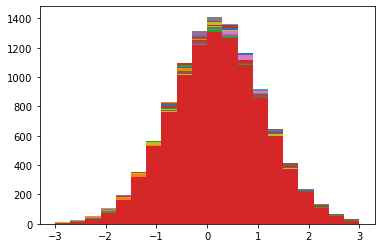

In [5]:
%%time




for di in range( n_input_dirs ) :

    in_dir = input_dirs[di]

    print('\n\n ====== Input dir: %s :  %s' % (in_dir, input_names[di] ) )
    print('    Unfolding type: %s ,   detector resolution:  %.2f' % (input_lhr_type[di], input_det_res[di]))

    with open( '%s/train-and-true-samples.npy' % in_dir, 'rb') as f :
        train_pts = np.load(f)
        train_det_pts = np.load(f)
        true_pts = np.load(f)
        true_det_pts = np.load(f)

    print('\n\n')
    print(' shape of train_pts:  %s' % str(train_pts.shape))
    print(' shape of true_pts:   %s' % str(true_pts.shape))


    with open( "%s/omnifold-output-weights.npy" % in_dir,'rb') as f :
        main_sample_omnifold_weights = np.load(f)

    main_sample_omnifold_weights = np.clip( main_sample_omnifold_weights, 1e-11, 1e11)

    print('\n\n')
    print(' shape of main_sample_omnifold_weights: %s' % str(main_sample_omnifold_weights.shape))


    unfolded_hist,hist_bin_edges,_ = plt.hist( train_pts[:,0], bins=hist_nbins, weights=main_sample_omnifold_weights, range=[hist_xlow, hist_xhigh] )

    hist_bin_centers = np.zeros( hist_nbins )
    for bi in range(hist_nbins) :
        hist_bin_centers[bi] = 0.5*(hist_bin_edges[bi] + hist_bin_edges[bi+1])    

    bin_width = hist_bin_edges[1] - hist_bin_edges[0]

    weight_sum = np.sum( main_sample_omnifold_weights )
    print('\n\n Sum of ominfold weights:  %.3f' % weight_sum )

    mean_cov = calc_mean_cov( main_sample_omnifold_weights, 0, 0 )

    print( '\n Simple calculation of model pars:     mean = %.5f,     sig2 = %.5f' %
         (mean_cov['mean_x1'], mean_cov['cov_x1x2']))



    n_samples = 0

    for fi in range(5000) :

        fname = '%s/bootstrap-weights-%03d.npy' % (in_dir, fi)

        if exists(fname) :
            n_samples = n_samples + 1

    print("\n Found %d bootstrap samples.\n\n" % n_samples )    


    #--

    boot_hist_content = np.zeros( shape=(n_samples, hist_nbins))


    simple_calc_mean = np.zeros( n_samples )
    simple_calc_cov  = np.zeros( n_samples )


    for bi in range(n_samples) :

        #boot_hist_content.append()

        fname = '%s/bootstrap-weights-%03d.npy' % (in_dir, bi)

        if not exists(fname) :  
            print('\n\n *** Missing %s' % fname )
            continue

        with open(fname,'rb') as f :

            final_push_weights_scaled = np.load(f)
            print(' boot %3d weights: ' % bi, end='')
            print( final_push_weights_scaled)

            hist_content,_,_ = plt.hist( train_pts[:,0], bins=hist_nbins, weights=final_push_weights_scaled, range=[hist_xlow, hist_xhigh] )

            boot_hist_content[bi,:] = hist_content


            mean_cov = calc_mean_cov( final_push_weights_scaled, 0, 0 )

            simple_calc_mean[bi] = mean_cov['mean_x1']
            simple_calc_cov[bi]  = mean_cov['cov_x1x2']


    #--

    simple_calc_ave_mean = np.mean( simple_calc_mean )
    simple_calc_ave_mean2 = np.mean( simple_calc_mean * simple_calc_mean )
    simple_calc_rms_mean = np.sqrt( simple_calc_ave_mean2 - simple_calc_ave_mean * simple_calc_ave_mean )


    simple_calc_ave_sig2 = np.mean( simple_calc_cov )
    simple_calc_ave_sig22 = np.mean( simple_calc_cov * simple_calc_cov )
    simple_calc_rms_sig2 = np.sqrt( simple_calc_ave_sig22 - simple_calc_ave_sig2 * simple_calc_ave_sig2 )


    #--



    have_fits = False

    if exists( "%s/fit-results.npy" % in_dir ) :
        have_fits = True
        print("\n\n Have fit results file.\n\n")

    if have_fits :

        ndim = 1

        with open( '%s/fit-results.npy' % in_dir, 'rb' ) as f :
            fit_results_mean_val = np.load(f, allow_pickle=True )
            fit_results_mean_err = np.load(f, allow_pickle=True )
            fit_results_cov_val = np.load(f, allow_pickle=True )
            fit_results_cov_err = np.load(f, allow_pickle=True )        


        ave_fit_err_mean = np.zeros( ndim )

        ave_fit_err_cov = np.zeros( shape=(ndim,ndim) )

        for fi in range(ndim) :

            ave_fit_err_mean[fi] = np.mean( fit_results_mean_err[fi,:])

            print( '%d : ave fit error, mean :  %8.4f' % (fi, ave_fit_err_mean[fi]))

        for fi1 in range(ndim) :
            for fi2 in range(fi1,ndim) :


                ave_fit_err_cov[fi1,fi2] = np.mean( fit_results_cov_err[fi1,fi2,:])

                print( 'fi1, fi2 : %d, %d    ave fit error, cov : %8.4f' % (fi1,fi2, ave_fit_err_cov[fi1,fi2]))


        ii = 0

        pi = 0
        results_fit_err[di, ii, pi] = ave_fit_err_mean[0]

        pi = 1
        results_fit_err[di, ii, pi] = ave_fit_err_cov[0,0]

    
    
    
    
    
    
    
    #-- Loop over hyperparameter values
    
    for hpi in range( n_hp_vals ) :
        
        print('\n\n\n ++++ Hyperparameter val %2d :  %.6f \n' % (hpi, hp_vals[hpi]))
    
    
        hist_corr_mat = np.zeros( shape=(hist_nbins, hist_nbins) )
        hist_cov_mat = np.zeros( shape=(hist_nbins, hist_nbins) )

        for bi in range(hist_nbins) :

            for bj in range( hist_nbins ) :

                ccm = np.corrcoef( np.row_stack( ((boot_hist_content[:,bi], boot_hist_content[:,bj])) ) )
                cvm =      np.cov( np.row_stack( ((boot_hist_content[:,bi], boot_hist_content[:,bj])) ) )

                hist_corr_mat[bi,bj] = ccm[0,1]

                hist_cov_mat[bi,bj] = cvm[0,1]


        #--

        hist_cov_pinv = np.linalg.pinv( hist_cov_mat, hp_vals[hpi] )

        #--

        hist_cov_mat_diagonal = np.copy( hist_cov_mat )
        for bi in range(hist_nbins) :
            for bj in range(hist_nbins) :
                if bi != bj : hist_cov_mat_diagonal[bi,bj] = 0.

        hist_cov_inv_diagonal = np.linalg.inv( hist_cov_mat_diagonal )
        print(hist_cov_inv_diagonal)        

        #--


        chi2_fit_mu_val = np.zeros( len(boot_hist_content) )
        chi2_fit_mu_err = np.zeros( len(boot_hist_content) )

        chi2_fit_sig2_val = np.zeros( len(boot_hist_content) )
        chi2_fit_sig2_err = np.zeros( len(boot_hist_content) )

        chi2_fit_diag_mu_val = np.zeros( len(boot_hist_content) )
        chi2_fit_diag_mu_err = np.zeros( len(boot_hist_content) )

        chi2_fit_diag_sig2_val = np.zeros( len(boot_hist_content) )
        chi2_fit_diag_sig2_err = np.zeros( len(boot_hist_content) )



        for si in range( len(boot_hist_content) ) :

            # Initialize Minuit and set up fit:
            theta = 1
            mu = 0.2
            sigma2 = 0.81
            #fitType = 'full cov'

            parin   = np.array([theta, mu, sigma2])      # initial values (here = true)
            parname = ['theta', 'mu', 'sigma2']
            parname_latex = [r'$\theta$', r'$\mu$', r'$\sigma^2$']
            parstep = np.array([0.01, 0.1, 0.1])           # initial setp sizes
            parfix  = [False, False, False]            # change to fix/free param.
            parlim  = [(0.5, 1.5), (None, None), (0., None)]

            chisq = ChiSquared( boot_hist_content[si], hist_bin_edges, hist_cov_pinv, fitType)
            chisq_diag = ChiSquared( boot_hist_content[si], hist_bin_edges, hist_cov_inv_diagonal, fitType)


            m = Minuit(chisq, parin, name=parname)
            m.errors = parstep
            m.fixed = parfix
            m.limits = parlim
            m.errordef = 1.0                      # errors from chi2 = chi2min + 1


            m_diag = Minuit(chisq_diag, parin, name=parname)
            m_diag.errors = parstep
            m_diag.fixed = parfix
            m_diag.limits = parlim
            m_diag.errordef = 1.0                      # errors from chi2 = chi2min + 1    


            # do the fit, get errors, extract results
            m.migrad()                                        # minimize -logL
            parhat = m.values                                 # max-likelihood estimates
            sigma_parhat = m.errors                           # standard deviations
            cov = m.covariance                                # covariance matrix
            rho = m.covariance.correlation()                  # correlation coeffs.

            m_diag.migrad()                                        # minimize -logL
            parhat_diag = m_diag.values                                 # max-likelihood estimates
            sigma_parhat_diag = m_diag.errors                           # standard deviations
            cov_diag = m_diag.covariance                                # covariance matrix
            rho_diag = m_diag.covariance.correlation()                  # correlation coeffs.


            chi2_fit_mu_val[si] = parhat[1]
            chi2_fit_mu_err[si] = sigma_parhat[1]

            chi2_fit_sig2_val[si] = parhat[2]
            chi2_fit_sig2_err[si] = sigma_parhat[2]


            chi2_fit_diag_mu_val[si] = parhat_diag[1]
            chi2_fit_diag_mu_err[si] = sigma_parhat_diag[1]

            chi2_fit_diag_sig2_val[si] = parhat_diag[2]
            chi2_fit_diag_sig2_err[si] = sigma_parhat_diag[2]


            print(' %3d : mu %8.4f +/- %8.4f  (%8.4f +/- %8.4f)    sig2 %8.4f +/- %8.4f  (%8.4f +/- %8.4f)' %
                  (si, 
                   parhat[1], sigma_parhat[1],
                   parhat_diag[1], sigma_parhat_diag[1],
                   parhat[2], sigma_parhat[2],
                   parhat_diag[2], sigma_parhat_diag[2],
                  )
                 )

        #--


        mean_mu = np.mean( chi2_fit_mu_val )
        mean_mu2 = np.mean( chi2_fit_mu_val * chi2_fit_mu_val )
        rms_mu = np.sqrt( mean_mu2 - mean_mu * mean_mu )

        mean_sig2 = np.mean( chi2_fit_sig2_val )
        mean_sig22 = np.mean( chi2_fit_sig2_val * chi2_fit_sig2_val )
        rms_sig2 = np.sqrt( mean_sig22 - mean_sig2 * mean_sig2 )

        mean_mu_fit_err = np.mean( chi2_fit_mu_err )
        mean_sig2_fit_err = np.mean( chi2_fit_sig2_err )


        mean_mu_fit_err2 = np.mean( chi2_fit_mu_err * chi2_fit_mu_err )
        mean_mu_fit_err_rms = np.sqrt( mean_mu_fit_err2 - mean_mu_fit_err * mean_mu_fit_err )

        mean_sig2_fit_err2 = np.mean( chi2_fit_sig2_err * chi2_fit_sig2_err )
        mean_sig2_fit_err_rms = np.sqrt( mean_sig2_fit_err2 - mean_sig2_fit_err * mean_sig2_fit_err )






        mean_mu_diag = np.mean( chi2_fit_diag_mu_val )
        mean_mu2_diag = np.mean( chi2_fit_diag_mu_val * chi2_fit_diag_mu_val )
        rms_mu_diag = np.sqrt( mean_mu2_diag - mean_mu_diag * mean_mu_diag )

        mean_sig2_diag = np.mean( chi2_fit_diag_sig2_val )
        mean_sig22_diag = np.mean( chi2_fit_diag_sig2_val * chi2_fit_diag_sig2_val )
        rms_sig2_diag = np.sqrt( mean_sig22_diag - mean_sig2_diag * mean_sig2_diag )

        mean_mu_fit_err_diag = np.mean( chi2_fit_diag_mu_err )
        mean_sig2_fit_err_diag = np.mean( chi2_fit_diag_sig2_err )



        mean_mu_fit_err2_diag = np.mean( chi2_fit_diag_mu_err * chi2_fit_diag_mu_err )
        mean_mu_fit_err_rms_diag = np.sqrt( mean_mu_fit_err2_diag - mean_mu_fit_err_diag * mean_mu_fit_err_diag )

        mean_sig2_fit_err2_diag = np.mean( chi2_fit_diag_sig2_err * chi2_fit_diag_sig2_err )
        mean_sig2_fit_err_rms_diag = np.sqrt( mean_sig2_fit_err2_diag - mean_sig2_fit_err_diag * mean_sig2_fit_err_diag )








        print('\n\n')
        print(' mean: %7.4f, rms %7.4f, mean fit err %7.4f  |  diag. chi2 fit   %7.4f, rms %7.4f, mean fit err %7.4f' % 
              (mean_mu, rms_mu, mean_mu_fit_err,    mean_mu_diag, rms_mu_diag, mean_mu_fit_err_diag))
        print(' sig2: %7.4f, rms %7.4f, mean fit err %7.4f  |  diag. chi2 fit   %7.4f, rms %7.4f, mean fit err %7.4f' % 
              (mean_sig2, rms_sig2, mean_sig2_fit_err,   mean_sig2_diag, rms_sig2_diag, mean_sig2_fit_err_diag))
        print('\n\n')










        #-- Model mean

        pi = 0

        ii = 0
        results_inference_mean[hpi, di, ii, pi] = simple_calc_ave_mean
        results_rms[hpi, di, ii, pi] = simple_calc_rms_mean

        ii = 1
        results_inference_mean[hpi, di, ii, pi] = mean_mu
        results_fit_err[hpi, di, ii, pi] = mean_mu_fit_err
        results_rms[hpi, di, ii, pi] = rms_mu

        ii = 2
        results_inference_mean[hpi, di, ii, pi] = mean_mu_diag
        results_fit_err[hpi, di, ii, pi] = mean_mu_fit_err_diag
        results_rms[hpi, di, ii, pi] = rms_mu_diag



        #-- stat err on above

        ii = 0
        results_inference_mean_stat_err[hpi, di, ii, pi] = simple_calc_rms_mean / np.sqrt( n_samples )    
        results_rms_stat_err[hpi, di, ii, pi] = simple_calc_rms_mean / np.sqrt( 2 * n_samples )

        ii = 1
        results_inference_mean_stat_err[hpi, di, ii, pi] = rms_mu / np.sqrt( n_samples )
        results_fit_err_stat_err[hpi, di, ii, pi] = mean_mu_fit_err_rms / np.sqrt( n_samples )
        results_rms_stat_err[hpi, di, ii, pi] = rms_mu / np.sqrt( 2 * n_samples )


        ii = 2
        results_inference_mean_stat_err[hpi, di, ii, pi] = rms_mu_diag / np.sqrt( n_samples )
        results_fit_err_stat_err[hpi, di, ii, pi] = mean_mu_fit_err_rms_diag / np.sqrt( n_samples )
        results_rms_stat_err[hpi, di, ii, pi] = rms_mu_diag / np.sqrt( 2 * n_samples ) 









        #-- Model sig2

        pi = 1

        ii = 0
        results_inference_mean[hpi, di, ii, pi] = simple_calc_ave_sig2
        results_rms[hpi, di, ii, pi] = simple_calc_rms_sig2

        ii = 1
        results_inference_mean[hpi, di, ii, pi] = mean_sig2
        results_fit_err[hpi, di, ii, pi] = mean_sig2_fit_err
        results_rms[hpi, di, ii, pi] = rms_sig2

        ii = 2
        results_inference_mean[hpi, di, ii, pi] = mean_sig2_diag
        results_fit_err[hpi, di, ii, pi] = mean_sig2_fit_err_diag
        results_rms[hpi, di, ii, pi] = rms_sig2_diag



        #-- stat err on above

        ii = 0
        results_inference_mean_stat_err[hpi, di, ii, pi] = simple_calc_rms_sig2 / np.sqrt( n_samples )    
        results_rms_stat_err[hpi, di, ii, pi] = simple_calc_rms_sig2 / np.sqrt( 2 * n_samples )

        ii = 1
        results_inference_mean_stat_err[hpi, di, ii, pi] = rms_sig2 / np.sqrt( n_samples )
        results_fit_err_stat_err[hpi, di, ii, pi] = mean_sig2_fit_err_rms / np.sqrt( n_samples )
        results_rms_stat_err[hpi, di, ii, pi] = rms_sig2 / np.sqrt( 2 * n_samples )


        ii = 2
        results_inference_mean_stat_err[hpi, di, ii, pi] = rms_sig2_diag / np.sqrt( n_samples )
        results_fit_err_stat_err[hpi, di, ii, pi] = mean_sig2_fit_err_rms_diag / np.sqrt( n_samples )
        results_rms_stat_err[hpi, di, ii, pi] = rms_sig2_diag / np.sqrt( 2 * n_samples ) 


        #--












        print('\n ====== End of this dir: %s :  %s' % (in_dir, input_names[di] ) )


In [6]:
results_inference_mean

array([[[[ 0.20026573,  0.8114612 ],
         [ 0.08907787,  0.68770913],
         [ 0.19965337,  0.80976172]],

        [[ 0.19842436,  0.81168591],
         [-0.48823507,  0.48088918],
         [ 0.19844137,  0.81123584]],

        [[ 0.19959532,  0.81397521],
         [ 0.05506059,  1.14189489],
         [ 0.19882303,  0.81453086]],

        [[ 0.20171016,  0.84165302],
         [ 0.65547423,  0.7758398 ],
         [ 0.20217929,  0.83933953]]],


       [[[ 0.20026573,  0.8114612 ],
         [ 0.08907787,  0.68770913],
         [ 0.19965337,  0.80976172]],

        [[ 0.19842436,  0.81168591],
         [ 0.17191982,  0.7722693 ],
         [ 0.19844137,  0.81123584]],

        [[ 0.19959532,  0.81397521],
         [ 0.3956316 ,  1.1084151 ],
         [ 0.19882303,  0.81453086]],

        [[ 0.20171016,  0.84165302],
         [ 0.30770147,  0.59007892],
         [ 0.20217929,  0.83933953]]],


       [[[ 0.20026573,  0.8114612 ],
         [ 0.08907787,  0.68770913],
         [ 0.19965

In [7]:
results_fit_err

array([[[[0.00899085, 0.00899085],
         [0.00811125, 0.01042791],
         [0.00661074, 0.00868064]],

        [[0.        , 0.        ],
         [0.00387338, 0.0067458 ],
         [0.00656834, 0.00866364]],

        [[0.        , 0.        ],
         [0.00300448, 0.00345768],
         [0.00600949, 0.0080363 ]],

        [[0.        , 0.        ],
         [0.00420503, 0.0046503 ],
         [0.00531765, 0.00716575]]],


       [[[0.00899161, 0.00899161],
         [0.01145885, 0.01145885],
         [0.00661074, 0.00868064]],

        [[0.        , 0.        ],
         [0.0090321 , 0.01090291],
         [0.00656834, 0.00866364]],

        [[0.        , 0.        ],
         [0.00988092, 0.01195787],
         [0.00600949, 0.0080363 ]],

        [[0.        , 0.        ],
         [0.00983267, 0.01348936],
         [0.00531765, 0.00716575]]],


       [[[0.00900695, 0.00900695],
         [0.01149407, 0.01149407],
         [0.00661074, 0.00868064]],

        [[0.        , 0.        ]

In [8]:
results_rms

array([[[[0.00899521, 0.01174102],
         [0.00826365, 0.01088028],
         [0.00913928, 0.01185565]],

        [[0.00929799, 0.01252469],
         [0.00418041, 0.00694884],
         [0.00951524, 0.01285151]],

        [[0.01065782, 0.01428753],
         [0.00288964, 0.00324633],
         [0.01080981, 0.01500477]],

        [[0.01177861, 0.01687584],
         [0.00340309, 0.00331376],
         [0.01203106, 0.0173479 ]]],


       [[[0.00899521, 0.01174102],
         [0.00826365, 0.01088028],
         [0.00913928, 0.01185565]],

        [[0.00929799, 0.01252469],
         [0.00901477, 0.00970198],
         [0.00951524, 0.01285151]],

        [[0.01065782, 0.01428753],
         [0.01027813, 0.01111893],
         [0.01080981, 0.01500477]],

        [[0.01177861, 0.01687584],
         [0.03469225, 0.04540571],
         [0.01203106, 0.0173479 ]]],


       [[[0.00899521, 0.01174102],
         [0.00826365, 0.01088028],
         [0.00913928, 0.01185565]],

        [[0.00929799, 0.01252469]

In [9]:
results_inference_mean_stat_err 

array([[[[0.00040228, 0.00052507],
         [0.00036956, 0.00048658],
         [0.00040872, 0.0005302 ]],

        [[0.00041582, 0.00056012],
         [0.00018695, 0.00031076],
         [0.00042553, 0.00057474]],

        [[0.00047663, 0.00063896],
         [0.00012923, 0.00014518],
         [0.00048343, 0.00067103]],

        [[0.00052676, 0.00075471],
         [0.00015219, 0.0001482 ],
         [0.00053805, 0.00077582]]],


       [[[0.00040228, 0.00052507],
         [0.00036956, 0.00048658],
         [0.00040872, 0.0005302 ]],

        [[0.00041582, 0.00056012],
         [0.00040315, 0.00043389],
         [0.00042553, 0.00057474]],

        [[0.00047663, 0.00063896],
         [0.00045965, 0.00049725],
         [0.00048343, 0.00067103]],

        [[0.00052676, 0.00075471],
         [0.00155148, 0.00203061],
         [0.00053805, 0.00077582]]],


       [[[0.00040228, 0.00052507],
         [0.00036956, 0.00048658],
         [0.00040872, 0.0005302 ]],

        [[0.00041582, 0.00056012]

In [10]:
results_fit_err_stat_err

array([[[[0.00000000e+00, 0.00000000e+00],
         [1.03396844e-06, 5.80798800e-06],
         [6.36423576e-07, 3.80160441e-06]],

        [[0.00000000e+00, 0.00000000e+00],
         [2.47620963e-06, 6.62366897e-06],
         [5.62540801e-07, 4.42902222e-06]],

        [[0.00000000e+00, 0.00000000e+00],
         [4.42580087e-07, 5.50237249e-07],
         [9.27507527e-07, 4.53200198e-06]],

        [[0.00000000e+00, 0.00000000e+00],
         [9.85662469e-07, 1.43657257e-06],
         [7.34894864e-07, 3.43567431e-06]]],


       [[[0.00000000e+00, 0.00000000e+00],
         [1.03396844e-06, 5.80798800e-06],
         [6.36423576e-07, 3.80160441e-06]],

        [[0.00000000e+00, 0.00000000e+00],
         [5.45389927e-07, 5.03475213e-06],
         [5.62540801e-07, 4.42902222e-06]],

        [[0.00000000e+00, 0.00000000e+00],
         [4.46267176e-06, 7.00530704e-06],
         [9.27507527e-07, 4.53200198e-06]],

        [[0.00000000e+00, 0.00000000e+00],
         [7.02920079e-05, 1.31994440e-

In [11]:
results_rms_stat_err

array([[[[2.84453503e-04, 3.71283720e-04],
         [2.61319413e-04, 3.44064803e-04],
         [2.89009543e-04, 3.74908414e-04]],

        [[2.94028345e-04, 3.96065430e-04],
         [1.32196203e-04, 2.19741461e-04],
         [3.00898173e-04, 4.06400411e-04]],

        [[3.37029711e-04, 4.51811222e-04],
         [9.13785226e-05, 1.02658009e-04],
         [3.41836205e-04, 4.74492393e-04]],

        [[3.72472407e-04, 5.33660944e-04],
         [1.07615148e-04, 1.04790216e-04],
         [3.80455594e-04, 5.48588653e-04]]],


       [[[2.84453503e-04, 3.71283720e-04],
         [2.61319413e-04, 3.44064803e-04],
         [2.89009543e-04, 3.74908414e-04]],

        [[2.94028345e-04, 3.96065430e-04],
         [2.85071909e-04, 3.06803490e-04],
         [3.00898173e-04, 4.06400411e-04]],

        [[3.37029711e-04, 4.51811222e-04],
         [3.25023058e-04, 3.51611565e-04],
         [3.41836205e-04, 4.74492393e-04]],

        [[3.72472407e-04, 5.33660944e-04],
         [1.09706536e-03, 1.43585477e-

In [12]:
with open( 'hyperparameter-scan-results.npy', 'wb' ) as f :
    np.save( f, results_inference_mean )
    np.save( f, results_fit_err )
    np.save( f, results_rms )
    np.save( f, results_inference_mean_stat_err )
    np.save( f, results_fit_err_stat_err )
    np.save( f, results_rms_stat_err )    

In [13]:
print('\n\n Done.\n\n')



 Done.




In [14]:
di = 0
hpi = 0

print('\n\n' )


for pi in range(n_pars) :
    for ii in range(n_inference_types) :
        
        for hpi in range(n_hp_vals) :
            
            print(' %-20s :  hp val %10.6f | ' % ( inference_names[ii], hp_vals[hpi]), end='')
            print(' %5s  inf. ave.  %8.4f, fit err. %6.4f, rms %6.4f | ' % 
                  (par_names[pi], 
                   results_inference_mean[hpi,di,ii,pi], 
                   results_fit_err[hpi,di,ii,pi], 
                   results_rms[hpi,di,ii,pi]), end='')
            print()
        print()
    
print('\n\n' )




 Unbinned ML fit      :  hp val   0.000000 |     mu  inf. ave.    0.2003, fit err. 0.0090, rms 0.0090 | 
 Unbinned ML fit      :  hp val   0.000010 |     mu  inf. ave.    0.2003, fit err. 0.0090, rms 0.0090 | 
 Unbinned ML fit      :  hp val   0.000022 |     mu  inf. ave.    0.2003, fit err. 0.0090, rms 0.0090 | 
 Unbinned ML fit      :  hp val   0.000046 |     mu  inf. ave.    0.2003, fit err. 0.0092, rms 0.0090 | 
 Unbinned ML fit      :  hp val   0.000100 |     mu  inf. ave.    0.2003, fit err. 0.0000, rms 0.0090 | 
 Unbinned ML fit      :  hp val   0.000215 |     mu  inf. ave.    0.2003, fit err. 0.0000, rms 0.0090 | 
 Unbinned ML fit      :  hp val   0.000464 |     mu  inf. ave.    0.2003, fit err. 0.0000, rms 0.0090 | 
 Unbinned ML fit      :  hp val   0.001000 |     mu  inf. ave.    0.2003, fit err. 0.0000, rms 0.0090 | 
 Unbinned ML fit      :  hp val   0.002154 |     mu  inf. ave.    0.2003, fit err. 0.0000, rms 0.0090 | 
 Unbinned ML fit      :  hp val   0.004642 |     mu 

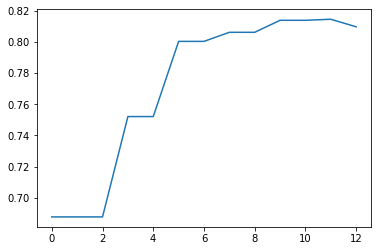

In [15]:

di=0
ii=1
pi=1


plt.plot(results_inference_mean[:,di,ii,pi])



<function matplotlib.pyplot.show(close=None, block=None)>

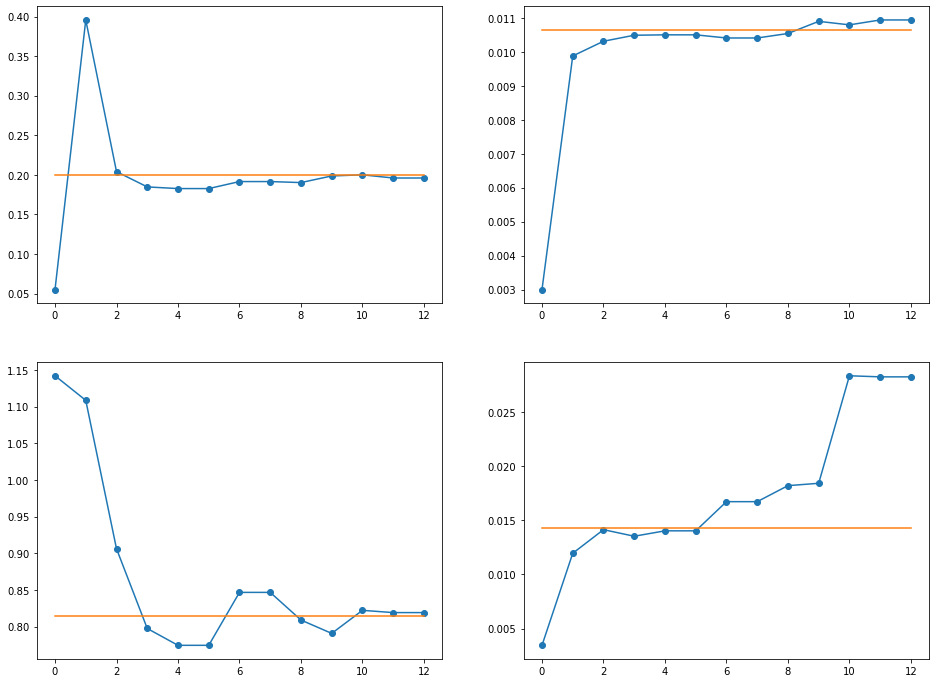

In [16]:
fig,ax = plt.subplots( 2, 2, figsize=(2*8,2*6))

di = 2






pi = 0

axi = ax[0,0]
ii=1
axi.plot( results_inference_mean[:,di,ii,pi], marker='o' )
ii=0
axi.plot( results_inference_mean[:,di,ii,pi] )

axi = ax[0,1]
ii=1
axi.plot( results_fit_err[:,di,ii,pi], marker='o' )
ii=0
axi.plot( results_rms[:,di,ii,pi] )





pi = 1

axi = ax[1,0]
ii=1
axi.plot( results_inference_mean[:,di,ii,pi], marker='o' )
ii=0
axi.plot( results_inference_mean[:,di,ii,pi] )



axi = ax[1,1]
ii=1
axi.plot( results_fit_err[:,di,ii,pi], marker='o' )
ii=0
axi.plot( results_rms[:,di,ii,pi] )



plt.show


In [17]:
for hpi in range(n_hp_vals) :
    print(' %3d : hp_val %.6f' % (hpi, hp_vals[hpi]))

   0 : hp_val 0.000000
   1 : hp_val 0.000010
   2 : hp_val 0.000022
   3 : hp_val 0.000046
   4 : hp_val 0.000100
   5 : hp_val 0.000215
   6 : hp_val 0.000464
   7 : hp_val 0.001000
   8 : hp_val 0.002154
   9 : hp_val 0.004642
  10 : hp_val 0.010000
  11 : hp_val 0.021544
  12 : hp_val 0.046416
